<a href="https://colab.research.google.com/github/amrzmre/forecasting-of-automotive-warranty-costs/blob/main/forecasting_of_automotive_warranty_costs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PHASE 1:DATA PREPARATION AND EXPLORATION

# [1.1] Environment Setup & Data Loading

In [11]:
# Block 1: Environment Setup & Data Loading
# Perodua Alternator Warranty Claims Monthly Forecasting

# =============================================================================
# 1. IMPORTS
# =============================================================================
# Standard library
import os
import warnings

# Data handling
import pandas as pd
import numpy as np

# Visualisation — matplotlib as base, seaborn for statistical plots
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical time-series tools
# statsmodels is preferred over scipy for ARIMA and decomposition because it
# provides full model summaries, AIC/BIC, and residual diagnostics out of the box
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine learning
# scikit-learn for cross-validation utilities and evaluation metrics
# XGBoost for gradient-boosted tree models (handles non-linear patterns
# in warranty cost that linear models may miss)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb

# Google Colab file upload utility
from google.colab import files

warnings.filterwarnings("ignore")

# =============================================================================
# 2. VISUALISATION CONFIGURATION
# =============================================================================
# seaborn-v0_8 is the stable alias for seaborn's matplotlib style sheet;
# avoids deprecation warnings on newer matplotlib versions
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# =============================================================================
# 3. DATA LOADING
# =============================================================================
print("Loading warranty claims dataset...")

# Prompt user to upload the CSV from their local machine
uploaded = files.upload()

# Retrieve the uploaded filename dynamically — avoids hardcoding the path
filename = next(iter(uploaded))
print(f"File received: {filename}")

# Attempt multiple encodings in priority order.
# latin-1 / cp1252 are common for Windows-exported CSV files, which often
# contain currency symbols or special characters that break strict utf-8 parsing.
ENCODINGS = ["utf-8", "latin-1", "cp1252", "iso-8859-1"]

df = None
for enc in ENCODINGS:
    try:
        df = pd.read_csv(filename, encoding=enc)
        print(f"Loaded successfully using {enc} encoding.")
        break
    except UnicodeDecodeError:
        continue

if df is None:
    # Last resort: replace undecodable bytes rather than raising an error.
    # This preserves the dataset but flags that encoding should be verified.
    print("All standard encodings failed. Loading with replacement characters — verify encoding.")
    df = pd.read_csv(filename, encoding="utf-8", errors="replace")

# =============================================================================
# 4. STRUCTURAL OVERVIEW
# =============================================================================
print("\n--- Dataset Structure ---")
print(f"Shape  : {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory : {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nColumn list:")
for idx, col in enumerate(df.columns, start=1):
    print(f"  {idx:>2}. {col}")

print("\nData types summary:")
for dtype, count in df.dtypes.value_counts().items():
    print(f"  {str(dtype):<12} : {count} column(s)")

# =============================================================================
# 5. CRITICAL COLUMN INSPECTION
# =============================================================================
# These four columns are central to the forecasting pipeline:
#   - 'Claimed Month'        : time index for aggregation
#   - 'Accept/Reject status' : filter — only accepted claims are costed
#   - 'DNMY RM'              : primary forecasting target (cost per claim in RM)
#   - 'RM'                   : secondary cost reference

CRITICAL_COLS = ["Claimed Month", "Accept/Reject status", "DNMY RM", "RM"]

print("\n--- Critical Column Inspection ---")
for col in CRITICAL_COLS:
    if col not in df.columns:
        print(f"\n[NOT FOUND] {col}")
        continue

    print(f"\n{col}")
    print(f"  dtype         : {df[col].dtype}")
    print(f"  non-null count: {df[col].count():,} / {len(df):,}")
    print(f"  unique values : {df[col].nunique():,}")

    if df[col].dtype == object:
        unique_vals = df[col].dropna().unique()
        if len(unique_vals) <= 10:
            print(f"  all unique    : {list(unique_vals)}")
        else:
            print(f"  first 10      : {list(unique_vals[:10])}")
    else:
        print(f"  range         : {df[col].min()} → {df[col].max()}")
        print(f"  sample        : {df[col].dropna().head(3).tolist()}")

# =============================================================================
# 6. TARGET VARIABLE: DNMY RM — NUMERIC PARSE CHECK
# =============================================================================
# 'DNMY RM' is the cost field used as the forecasting target.
# If stored as object (string), it may contain formatting characters
# (e.g. commas, currency symbols) that prevent direct numeric conversion.
# Identifying these early avoids silent NaN introduction during preprocessing.

if "DNMY RM" in df.columns and df["DNMY RM"].dtype == object:
    non_numeric_mask = pd.to_numeric(df["DNMY RM"], errors="coerce").isna()
    problem_values = df.loc[non_numeric_mask & df["DNMY RM"].notna(), "DNMY RM"].unique()

    print("\n--- DNMY RM Numeric Parse Check ---")
    if len(problem_values) > 0:
        print(f"  Non-convertible values detected ({len(problem_values)} unique):")
        print(f"  {list(problem_values[:5])}")
        print("  Action required: strip formatting characters before conversion.")
    else:
        print("  All non-null values are numeric-compatible.")

# =============================================================================
# 7. DATE COLUMN INSPECTION
# =============================================================================
# Three date fields are relevant to the warranty lifecycle:
#   - 'Registration Date' : vehicle registration (determines warranty start)
#   - 'L/O Date'          : labour order date
#   - 'Repair Date'       : actual repair date (closest to claim event)
# Confirming their format here determines the parsing strategy in Phase 2.

DATE_COLS = ["Registration Date", "L/O Date", "Repair Date"]

print("\n--- Date Column Inspection ---")
for col in DATE_COLS:
    if col not in df.columns:
        print(f"\n[NOT FOUND] {col}")
        continue

    print(f"\n{col}")
    print(f"  dtype         : {df[col].dtype}")
    print(f"  non-null count: {df[col].count():,}")
    print(f"  sample values : {df[col].dropna().head(3).tolist()}")

# =============================================================================
# 8. MISSING VALUE SUMMARY
# =============================================================================
# A missing value audit is performed before any imputation or filtering.
# Columns with high missingness may be candidates for exclusion rather than
# imputation, which would be decided in Phase 2 based on domain relevance.

missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print("\n--- Missing Value Summary ---")
if missing.empty:
    print("  No missing values detected.")
else:
    print(f"  {len(missing)} column(s) contain missing values:\n")
    for col, count in missing.head(15).items():
        pct = count / len(df) * 100
        print(f"  {col:<35} {count:>6,}  ({pct:5.1f}%)")
    if len(missing) > 15:
        print(f"  ... and {len(missing) - 15} additional column(s)")

# =============================================================================
# 9. RAW DATA PREVIEW
# =============================================================================
print("\n--- First 3 Rows ---")
print(df.head(3).to_string())

# =============================================================================
# 10. SUMMARY
# =============================================================================
print("\nPhase 1 complete.")
print(f"  Dataframe 'df' : {df.shape[0]:,} rows × {df.shape[1]} columns")
print("  Proceed to Phase 2: Data Cleaning and Feature Engineering")

Loading warranty claims dataset...


Saving fy19-fy23_warranty_claims.csv to fy19-fy23_warranty_claims.csv
File received: fy19-fy23_warranty_claims.csv
Loaded successfully using utf-8 encoding.

--- Dataset Structure ---
Shape  : 2,514 rows × 49 columns
Memory : 4.87 MB

Column list:
   1. Claimed Month
   2. Custm Code
   3. Customer Name
   4. SS C/D code
   5. SS C/D name
   6. SSS S/D code
   7. SSS S/D name
   8. Dealer code
   9. Country Code
  10. Claim Country
  11. Final Judgement
  12. Settlement with Car Maker
  13. Subsidiary Code
  14. Charged Vendor
  15. Model Code
  16. Model Name
  17. Frame Number
  18. VIN Number
  19. Registration Date
  20. L/O Date
  21. Repair Date
  22. Months In Service
  23. Mileage/Hour In Service
  24. Original Failed Part
  25. Customer Partnumber
  26. Qty
  27. Part Name
  28. Part category
  29. Production serial No.
  30. Condition Description
  31. Cause Description
  32. Remedy Description
  33. Failure condition CD 1
  34. Failure condition CD 2
  35. Failure cause code

# [1.2] Data Quality Assessment & Filtering

In [12]:
# Block 2: Data Quality Assessment & Filtering
# Focus on accepted warranty claims and target variable preparation

# =============================================================================
# 1. ACCEPT/REJECT STATUS DISTRIBUTION
# =============================================================================
# Before any analysis, we need to understand the composition of claim statuses.
# Only accepted claims (ACC) represent actual warranty costs — rejected claims
# were not honoured and therefore carry no financial liability. Including them
# would inflate cost estimates and distort the forecasting target.

status_counts = df["Accept/Reject status"].value_counts()

print("Status distribution:")
for status, count in status_counts.items():
    pct = count / len(df) * 100
    print(f"  {status}: {count:,}  ({pct:.1f}%)")

# Known rejection reason codes observed in this dataset.
# These are mutually exclusive with ACC — no partial acceptance exists.
REJECTION_CODES = ["INS", "TFC", "OVER WARRANTY", "OVER MILEAGE", "OVER MILLEAGE"]

acc_count = status_counts.get("ACC", 0)
rejection_count = sum(status_counts.get(code, 0) for code in REJECTION_CODES)
other_count = len(df) - acc_count - rejection_count

print(f"\nAcceptance breakdown:")
print(f"  Accepted  (ACC)      : {acc_count:,}  ({acc_count / len(df) * 100:.1f}%)")
print(f"  Rejected  (known)    : {rejection_count:,}  ({rejection_count / len(df) * 100:.1f}%)")
print(f"  Other / unclassified : {other_count:,}  ({other_count / len(df) * 100:.1f}%)")

# =============================================================================
# 2. TARGET VARIABLE ANALYSIS: RM vs DNMY RM
# =============================================================================
# Two cost columns exist in the dataset:
#   - 'RM'      : claim cost in Ringgit Malaysia (numeric, clean)
#   - 'DNMY RM' : an alternative cost field that may contain Excel formula
#                 errors (#REF!) due to how the source file was constructed
#
# 'RM' is selected as the forecasting target because it is consistently
# numeric. 'DNMY RM' is inspected here to confirm whether it provides
# any additional signal or can be safely excluded.

print("\n--- RM Column ---")
print(f"  dtype        : {df['RM'].dtype}")
print(f"  non-null     : {df['RM'].count():,} / {len(df):,}")
print(f"  missing      : {df['RM'].isnull().sum():,}")
print(f"  range        : {df['RM'].min():.2f} → {df['RM'].max():.2f}")
print(f"  mean / median: {df['RM'].mean():.2f} / {df['RM'].median():.2f}")

print("\n--- DNMY RM Column ---")
print(f"  dtype    : {df['DNMY RM'].dtype}")
print(f"  non-null : {df['DNMY RM'].count():,} / {len(df):,}")
print(f"  missing  : {df['DNMY RM'].isnull().sum():,}")

# Cast to string temporarily to detect Excel formula errors.
# We avoid modifying the original column; instead we work on a string copy.
dnmy_str = df["DNMY RM"].astype(str)
ref_error_mask = dnmy_str.str.contains("#REF!", na=False)
ref_error_count = ref_error_mask.sum()

print(f"  #REF! errors : {ref_error_count:,}")
if ref_error_count > 0:
    print(f"  examples     : {df.loc[ref_error_mask, 'DNMY RM'].unique()[:3].tolist()}")

# Numeric correlation check between the two cost columns.
# A correlation close to 1.0 confirms they carry the same information,
# supporting the decision to use RM only.
dnmy_numeric = pd.to_numeric(df["DNMY RM"], errors="coerce")
correlation = df["RM"].corr(dnmy_numeric)
print(f"  correlation with RM : {correlation:.4f}")

# =============================================================================
# 3. FILTER TO ACCEPTED CLAIMS
# =============================================================================
# Strict filter: retain only rows where status is exactly 'ACC'.
# A conservative filter prevents ambiguous or partially-accepted claims
# from entering the cost aggregation step.

df_accepted = df[df["Accept/Reject status"] == "ACC"].copy()

print(f"\nRow counts after status filter:")
print(f"  Original     : {len(df):,}")
print(f"  ACC only     : {len(df_accepted):,}")
print(f"  Removed      : {len(df) - len(df_accepted):,}  ({(len(df) - len(df_accepted)) / len(df) * 100:.1f}%)")

# =============================================================================
# 4. TARGET VARIABLE VALIDATION (ACCEPTED CLAIMS)
# =============================================================================
# With non-ACC rows removed, re-inspect RM to confirm it is clean and complete
# within the accepted subset before proceeding to aggregation.

print("\n--- RM in Accepted Claims ---")
print(f"  non-null : {df_accepted['RM'].count():,} / {len(df_accepted):,}")
print(f"  missing  : {df_accepted['RM'].isnull().sum():,}")
print(f"  range    : {df_accepted['RM'].min():.2f} → {df_accepted['RM'].max():.2f}")
print(f"  mean     : {df_accepted['RM'].mean():.2f}")
print(f"  std      : {df_accepted['RM'].std():.2f}")

# Boundary checks — zero or negative claim costs are physically implausible
# for warranty repairs and indicate data entry errors.
zero_count = (df_accepted["RM"] == 0).sum()
neg_count = (df_accepted["RM"] < 0).sum()
q99 = df_accepted["RM"].quantile(0.99)
extreme_count = (df_accepted["RM"] > q99).sum()

print(f"\nData quality checks:")
print(f"  Zero values              : {zero_count}")
print(f"  Negative values          : {neg_count}")
print(f"  Above 99th pct (>{q99:.0f}) : {extreme_count}")

print("\nDescriptive statistics:")
print(df_accepted["RM"].describe().to_string())

# =============================================================================
# 5. DUPLICATE DETECTION
# =============================================================================
# Duplicate claim records would cause double-counting in monthly cost
# aggregation. Two checks are performed:
#   (a) exact duplicate Claim IDs — same claim submitted more than once
#   (b) duplicate (Frame Number, Claimed Month, RM) combinations —
#       catches cases where Claim ID differs but the record is substantively
#       identical (e.g. re-submissions with a new reference number)

if "Claim ID" in df_accepted.columns:
    dup_id_count = df_accepted["Claim ID"].duplicated().sum()
    print(f"\nDuplicate Claim IDs: {dup_id_count}")

    if dup_id_count > 0:
        dup_ids = df_accepted.loc[
            df_accepted["Claim ID"].duplicated(keep=False), "Claim ID"
        ].unique()[:5]
        for cid in dup_ids:
            n = (df_accepted["Claim ID"] == cid).sum()
            print(f"  {cid} : {n} occurrences")
else:
    print("\nClaim ID column not found — skipping Claim ID duplicate check.")

KEY_FIELDS = ["Frame Number", "Claimed Month", "RM"]
if all(f in df_accepted.columns for f in KEY_FIELDS):
    dup_combo_count = df_accepted.duplicated(subset=KEY_FIELDS).sum()
    print(f"Duplicate (Frame Number, Claimed Month, RM) combinations: {dup_combo_count}")
else:
    missing_fields = [f for f in KEY_FIELDS if f not in df_accepted.columns]
    print(f"Cannot check field-combination duplicates — missing: {missing_fields}")

# =============================================================================
# 6. TEMPORAL DATA QUALITY
# =============================================================================
# Monthly coverage consistency is critical for time-series modelling.
# Months with very few claims may indicate incomplete data exports rather
# than genuine low-activity periods, which would bias seasonal decomposition.

month_dist = df_accepted["Claimed Month"].value_counts().sort_index()
avg_monthly = len(df_accepted) / df_accepted["Claimed Month"].nunique()

print(f"\n--- Claimed Month Coverage ---")
print(f"  Date range       : {month_dist.index.min()} → {month_dist.index.max()}")
print(f"  Unique months    : {df_accepted['Claimed Month'].nunique()}")
print(f"  Avg claims/month : {avg_monthly:.1f}")

low_months = month_dist[month_dist < 10]
if not low_months.empty:
    print(f"\n  Months with fewer than 10 claims ({len(low_months)} found):")
    for month, count in low_months.head().items():
        print(f"    {month} : {count}")
else:
    print("  All months have 10 or more claims.")

# =============================================================================
# 7. FINAL CLEAN DATASET CONSTRUCTION
# =============================================================================
# Sequentially apply:
#   1. Remove rows with missing RM (no cost value = unusable for forecasting)
#   2. Deduplicate on Claim ID (keep first occurrence chronologically)
#
# The resulting df_clean is the canonical dataset for all downstream phases.

df_clean = df_accepted[df_accepted["RM"].notna()].copy()

if "Claim ID" in df_clean.columns:
    pre_dedup = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=["Claim ID"], keep="first")
    removed = pre_dedup - len(df_clean)
    if removed > 0:
        print(f"\nRemoved {removed} duplicate Claim ID row(s) during final construction.")

print(f"\n--- Final Dataset Summary ---")
print(f"  Raw input                : {len(df):,}")
print(f"  After ACC filter         : {len(df_accepted):,}")
print(f"  After removing null RM   : {len(df_clean):,}")
print(f"  Retention rate           : {len(df_clean) / len(df) * 100:.1f}%")

print(f"\nQuality metrics:")
print(f"  RM completeness   : 100%  (nulls removed)")
print(f"  Month coverage    : {df_clean['Claimed Month'].nunique()} months")
print(f"  Avg monthly claims: {len(df_clean) / df_clean['Claimed Month'].nunique():.1f}")
print(f"  RM range          : {df_clean['RM'].min():.2f} → {df_clean['RM'].max():.2f}")

print("\nBlock 2 complete.")
print(f"  df_clean : {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")

Status distribution:
  ACC: 2,439  (97.0%)
  OVER WARRANTY: 51  (2.0%)
  OVER MILLEAGE: 8  (0.3%)
  INS: 7  (0.3%)
  TFC: 6  (0.2%)
  OVER MILEAGE: 3  (0.1%)

Acceptance breakdown:
  Accepted  (ACC)      : 2,439  (97.0%)
  Rejected  (known)    : 75  (3.0%)
  Other / unclassified : 0  (0.0%)

--- RM Column ---
  dtype        : float64
  non-null     : 2,514 / 2,514
  missing      : 0
  range        : 9.16 → 430.28
  mean / median: 158.11 / 165.57

--- DNMY RM Column ---
  dtype    : object
  non-null : 2,509 / 2,514
  missing  : 5
  #REF! errors : 5
  examples     : ['#REF!']
  correlation with RM : 0.9515

Row counts after status filter:
  Original     : 2,514
  ACC only     : 2,439
  Removed      : 75  (3.0%)

--- RM in Accepted Claims ---
  non-null : 2,439 / 2,439
  missing  : 0
  range    : 11.62 → 430.28
  mean     : 157.45
  std      : 99.66

Data quality checks:
  Zero values              : 0
  Negative values          : 0
  Above 99th pct (>322) : 18

Descriptive statistics:
co

# [1.3] Fiscal Year Mapping & Temporal Structure Creation

In [13]:
# Block 3: Fiscal Year Mapping & Temporal Structure Creation
# Create proper fiscal year mapping using April-March cycles with corrected COVID identification

# =============================================================================
# 1. DATE FORMAT ANALYSIS
# =============================================================================
# 'Claimed Month' is stored in YYYYMM integer format (e.g. 202104 = April 2021).
# Before building any temporal features, we confirm the format from a sample
# and define reusable parsing functions to keep downstream transformations clean.

sample_months = sorted(df_clean["Claimed Month"].unique()[:10])
print("Claimed Month sample values:", sample_months)
print(f"Date range: {df_clean['Claimed Month'].min()} → {df_clean['Claimed Month'].max()}")


def parse_claimed_month(claimed_month):
    """
    Split a YYYYMM integer into (year, month) integers.

    Parameters
    ----------
    claimed_month : int
        Six-digit date code, e.g. 202104.

    Returns
    -------
    tuple of (int, int)
        Calendar year and calendar month.
    """
    s = str(claimed_month)
    return int(s[:4]), int(s[4:6])


def fiscal_year_from_month(year, month):
    """
    Return the fiscal year for a given calendar year and month.

    Perodua follows a Malaysian government-aligned April–March fiscal cycle.
    Months April–December belong to the FY that starts in April of that year.
    Months January–March close the FY that started the previous April.

    Parameters
    ----------
    year  : int
    month : int  (1–12)

    Returns
    -------
    int
        Fiscal year (identified by the calendar year in which April falls).
    """
    return year if month >= 4 else year - 1


def create_fiscal_period(year, month):
    """
    Return (fiscal_year, fiscal_month) for a calendar year and month.

    Fiscal month 1 = April, fiscal month 12 = March.
    This numbering aligns with the April–March cycle used in Perodua's reporting.

    Parameters
    ----------
    year  : int
    month : int  (1–12)

    Returns
    -------
    tuple of (int, int)
        (fiscal_year, fiscal_month_number)
    """
    fy = fiscal_year_from_month(year, month)
    fiscal_month = (month - 4) % 12 + 1  # April→1, May→2, ..., March→12
    return fy, fiscal_month


# Smoke test — verify the mapping logic before applying to the full dataset.
# These boundary months cover FY transitions and should be checked manually.
print("\nConversion test (calendar month → fiscal year, fiscal month):")
test_cases = [201904, 201912, 202001, 202003, 202004]
for tc in test_cases:
    y, m = parse_claimed_month(tc)
    fy, fm = create_fiscal_period(y, m)
    print(f"  {tc}  (cal {y}-{m:02d})  →  FY{fy}, FM{fm:02d}")

# =============================================================================
# 2. APPLY FISCAL YEAR MAPPING TO df_clean
# =============================================================================
# Vectorised lambda application is used here instead of a full .apply with
# two separate functions to reduce the number of passes over the column.
# The fiscal_mapping Series of tuples is unpacked into two columns directly.

df_clean["Calendar_Year"] = df_clean["Claimed Month"].apply(lambda x: parse_claimed_month(x)[0])
df_clean["Calendar_Month"] = df_clean["Claimed Month"].apply(lambda x: parse_claimed_month(x)[1])

fiscal_mapping = df_clean["Claimed Month"].apply(
    lambda x: create_fiscal_period(*parse_claimed_month(x))
)
df_clean["Fiscal_Year"] = [t[0] for t in fiscal_mapping]
df_clean["Fiscal_Month"] = [t[1] for t in fiscal_mapping]

# Fiscal_Period provides a sortable string label for display and grouping,
# e.g. '2021_M01' for the first fiscal month of FY2021 (April 2021).
df_clean["Fiscal_Period"] = (
    df_clean["Fiscal_Year"].astype(str)
    + "_M"
    + df_clean["Fiscal_Month"].astype(str).str.zfill(2)
)

print("\nFiscal year columns added: Calendar_Year, Calendar_Month, Fiscal_Year, Fiscal_Month, Fiscal_Period")

# =============================================================================
# 3. FISCAL YEAR DISTRIBUTION
# =============================================================================
fy_dist = df_clean["Fiscal_Year"].value_counts().sort_index()

print("\nClaims by fiscal year:")
for fy, count in fy_dist.items():
    pct = count / len(df_clean) * 100
    months_active = df_clean[df_clean["Fiscal_Year"] == fy]["Fiscal_Month"].nunique()
    avg = count / months_active if months_active else 0
    print(f"  FY{fy}: {count:,} claims  |  {months_active} months  |  avg {avg:.1f}/month  ({pct:.1f}%)")

# =============================================================================
# 4. COVID IMPACT PERIOD IDENTIFICATION
# =============================================================================
# Malaysia's Movement Control Order (MCO) ran from March 2020 and caused
# near-complete automotive service centre shutdowns through early 2021.
# This maps entirely onto FY2020 (Apr 2020 – Mar 2021) in Perodua's calendar.
#
# Statistical anomaly detection would incorrectly flag pre-COVID months with
# high variance as the affected period. Business-domain knowledge is the
# correct basis for COVID identification here: we look for which FY20 months
# actually appear in the data — these are the post-shutdown restart months
# (Feb–Mar 2021) where accumulated claims were processed together.

monthly_claims = (
    df_clean.groupby("Claimed Month")["RM"]
    .agg(["count", "sum"])
    .reset_index()
)

monthly_claims[["Calendar_Year", "Calendar_Month"]] = monthly_claims["Claimed Month"].apply(
    lambda x: pd.Series(parse_claimed_month(x))
)

fiscal_map_monthly = monthly_claims["Claimed Month"].apply(
    lambda x: pd.Series(create_fiscal_period(*parse_claimed_month(x)))
)
monthly_claims[["Fiscal_Year", "Fiscal_Month"]] = fiscal_map_monthly
monthly_claims = monthly_claims.sort_values("Claimed Month").reset_index(drop=True)

print("\nFull monthly claims log:")
print(f"  {'Claimed Month':>13} | {'Cal Date':>10} | {'FY':>6} | {'Claims':>6} | {'Total RM':>10}")
print("  " + "-" * 60)
for _, row in monthly_claims.iterrows():
    cal_date = f"{int(row['Calendar_Year'])}-{int(row['Calendar_Month']):02d}"
    print(
        f"  {int(row['Claimed Month']):>13} | {cal_date:>10} | "
        f"FY{int(row['Fiscal_Year']):<4} | {int(row['count']):>6} | {row['sum']:>10.2f}"
    )

# Identify FY20 months present in the dataset.
# All present FY20 months are treated as COVID-restart periods, not normal months.
fy20_rows = monthly_claims[monthly_claims["Fiscal_Year"] == 2020]
covid_months = fy20_rows["Claimed Month"].tolist()
covid_affected_fy = 2020 if covid_months else None

print(f"\nCOVID period (FY2020 = Apr 2020 – Mar 2021):")
print(f"  FY20 months with data: {len(fy20_rows)}")
if covid_months:
    print("  These are restart/recovery months — accumulated claims from the shutdown period:")
    for _, row in fy20_rows.iterrows():
        cal_date = f"{int(row['Calendar_Year'])}-{int(row['Calendar_Month']):02d}"
        print(f"    {int(row['Claimed Month'])} ({cal_date}): {int(row['count'])} claims, RM {row['sum']:,.2f}")
    print(f"\n  Decision: Include restart months — they represent real operational data.")
    print(f"  They will be flagged in the time series to allow models to account for")
    print(f"  the abnormal claim volume caused by the backlog processing.")
else:
    print("  No FY20 data present — complete shutdown confirmed for this dataset.")

# =============================================================================
# 5. MONTHLY TIME SERIES CONSTRUCTION
# =============================================================================
# Aggregate to one row per calendar month. Four metrics are retained:
#   - Claims_Count : volume indicator (number of warranty events)
#   - Total_RM     : primary forecasting target (total cost incurred)
#   - Mean_RM      : average cost per claim (useful as a secondary feature)
#   - Std_RM       : within-month cost spread (proxy for claim complexity)

monthly_ts = (
    df_clean.groupby("Claimed Month")
    .agg(
        Claims_Count=("RM", "count"),
        Total_RM=("RM", "sum"),
        Mean_RM=("RM", "mean"),
        Std_RM=("RM", "std"),
        Fiscal_Year=("Fiscal_Year", "first"),
        Fiscal_Month=("Fiscal_Month", "first"),
        Calendar_Year=("Calendar_Year", "first"),
        Calendar_Month=("Calendar_Month", "first"),
    )
    .round(2)
    .reset_index()
)

monthly_ts["Date_Label"] = (
    monthly_ts["Calendar_Year"].astype(int).astype(str)
    + "-"
    + monthly_ts["Calendar_Month"].astype(int).astype(str).str.zfill(2)
)
monthly_ts["FY_Label"] = "FY" + monthly_ts["Fiscal_Year"].astype(int).astype(str)

print(f"\nMonthly time series shape  : {monthly_ts.shape}")
print(f"Date range                 : {monthly_ts['Claimed Month'].min()} → {monthly_ts['Claimed Month'].max()}")
print(f"Total months               : {len(monthly_ts)}")
print(f"Total claims               : {monthly_ts['Claims_Count'].sum():,}")
print(f"Total RM                   : {monthly_ts['Total_RM'].sum():,.2f}")
print(f"Avg monthly claims         : {monthly_ts['Claims_Count'].mean():.1f}")
print(f"Avg monthly RM             : {monthly_ts['Total_RM'].mean():,.2f}")

# =============================================================================
# 6. COVID PERIOD FLAGGING
# =============================================================================
monthly_ts["COVID_Affected"] = monthly_ts["Claimed Month"].isin(covid_months)

if covid_months:
    print(f"\nCOVID flag applied to {monthly_ts['COVID_Affected'].sum()} month(s): {covid_months}")

    covid_grp = monthly_ts.groupby("COVID_Affected").agg(
        Months=("Claims_Count", "count"),
        Total_Claims=("Claims_Count", "sum"),
        Avg_Claims=("Claims_Count", "mean"),
        Total_RM=("Total_RM", "sum"),
        Avg_RM=("Total_RM", "mean"),
    ).round(2)

    print("\nCOVID vs normal operations comparison:")
    print(f"  {'Period':<22} | {'Months':>6} | {'Total Claims':>12} | {'Avg/Month':>9} | {'Total RM':>12} | {'Avg RM/Month':>12}")
    print("  " + "-" * 85)
    for flag, row in covid_grp.iterrows():
        label = "COVID restart" if flag else "Normal operations"
        print(
            f"  {label:<22} | {int(row['Months']):>6} | {int(row['Total_Claims']):>12} | "
            f"{row['Avg_Claims']:>9.1f} | {row['Total_RM']:>12.2f} | {row['Avg_RM']:>12.2f}"
        )
else:
    monthly_ts["COVID_Affected"] = False
    print("\nNo COVID months in dataset — COVID_Affected column set to False for all rows.")

# =============================================================================
# 7. FISCAL YEAR SUMMARY
# =============================================================================
fy_summary = (
    monthly_ts.groupby("Fiscal_Year")
    .agg(
        Months_Available=("Claims_Count", "count"),
        Total_Claims=("Claims_Count", "sum"),
        Avg_Monthly_Claims=("Claims_Count", "mean"),
        Total_RM=("Total_RM", "sum"),
        Avg_Monthly_RM=("Total_RM", "mean"),
        COVID_Affected=("COVID_Affected", "any"),
    )
    .round(2)
    .reset_index()
)

print("\nFiscal year summary:")
print(fy_summary.to_string(index=False))

# Fiscal years with fewer than 12 months are incomplete.
# They should be excluded from model training to avoid partial-year bias —
# a 2-month FY would produce artificially low totals and distort trend estimates.
complete_fy = fy_summary.loc[fy_summary["Months_Available"] == 12, "Fiscal_Year"].tolist()
incomplete_fy = fy_summary.loc[fy_summary["Months_Available"] < 12, "Fiscal_Year"].tolist()

print(f"\nFiscal year completeness:")
print(f"  Complete (12 months) : {complete_fy}")
print(f"  Incomplete           : {incomplete_fy}")
if incomplete_fy:
    print(f"  Modelling note: exclude FY {incomplete_fy} from training — partial-year totals distort trends.")

# =============================================================================
# 8. VALIDATION AND CROSS-CHECKS
# =============================================================================
# Confirm that row-level totals in df_clean match the aggregated monthly_ts.
# Any mismatch indicates a groupby key error or unintended row exclusion.

orig_claims = len(df_clean)
agg_claims = monthly_ts["Claims_Count"].sum()
orig_rm = df_clean["RM"].sum()
agg_rm = monthly_ts["Total_RM"].sum()

print("\nData integrity checks (df_clean vs monthly_ts):")
print(f"  Total claims   — original: {orig_claims:,}  |  aggregated: {agg_claims:,}  |  match: {orig_claims == agg_claims}")
print(f"  Total RM       — original: {orig_rm:,.2f}  |  aggregated: {agg_rm:,.2f}  |  diff: {abs(orig_rm - agg_rm):.2f}")

# Spot-check fiscal year assignment for boundary months.
# Only months present in monthly_ts are checked; missing months are noted.
print("\nFiscal year mapping spot-check:")
spot_cases = [201904, 202003, 202004, 202103]
for sc in spot_cases:
    if sc in monthly_ts["Claimed Month"].values:
        row = monthly_ts[monthly_ts["Claimed Month"] == sc].iloc[0]
        y, m = parse_claimed_month(sc)
        exp_fy, _ = create_fiscal_period(y, m)
        act_fy = int(row["Fiscal_Year"])
        status = "OK" if exp_fy == act_fy else "MISMATCH"
        print(f"  {sc} ({y}-{m:02d}): expected FY{exp_fy}, got FY{act_fy}  [{status}]")
    else:
        print(f"  {sc}: not present in monthly_ts — skipping.")

if covid_months:
    print("\nCOVID month fiscal year validation:")
    for cm in covid_months:
        y, m = parse_claimed_month(cm)
        fy, _ = create_fiscal_period(y, m)
        status = "OK — correctly in FY2020" if fy == 2020 else "MISMATCH"
        print(f"  {cm} ({y}-{m:02d}): FY{fy}  [{status}]")

# =============================================================================
# 9. HANDOFF SUMMARY
# =============================================================================
print("\nBlock 3 complete.")
print(f"  df_clean   : {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns  (fiscal columns added)")
print(f"  monthly_ts : {len(monthly_ts)} months  (primary time series for modelling)")
print(f"  fy_summary : {len(fy_summary)} fiscal years")
print(f"  COVID-affected months flagged : {len(covid_months)}")

Claimed Month sample values: [np.int64(201904), np.int64(201905), np.int64(201906), np.int64(201907), np.int64(201908), np.int64(201909), np.int64(201910), np.int64(201911), np.int64(201912), np.int64(202001)]
Date range: 201904 → 202403

Conversion test (calendar month → fiscal year, fiscal month):
  201904  (cal 2019-04)  →  FY2019, FM01
  201912  (cal 2019-12)  →  FY2019, FM09
  202001  (cal 2020-01)  →  FY2019, FM10
  202003  (cal 2020-03)  →  FY2019, FM12
  202004  (cal 2020-04)  →  FY2020, FM01

Fiscal year columns added: Calendar_Year, Calendar_Month, Fiscal_Year, Fiscal_Month, Fiscal_Period

Claims by fiscal year:
  FY2019: 260 claims  |  12 months  |  avg 21.7/month  (10.8%)
  FY2020: 69 claims  |  2 months  |  avg 34.5/month  (2.9%)
  FY2021: 495 claims  |  12 months  |  avg 41.2/month  (20.6%)
  FY2022: 737 claims  |  12 months  |  avg 61.4/month  (30.7%)
  FY2023: 842 claims  |  12 months  |  avg 70.2/month  (35.0%)

Full monthly claims log:
  Claimed Month |   Cal Date |  

# PHASE 2: EXPLORATORY DATA ANALYSIS (EDA)

# [2.1] Time Series Foundation Analysis

Time series prepared:
  Shape      : (50, 11)
  Date range : 2019-04 → 2024-03
  Months     : 50

Total_RM summary:
  Mean   : 7,474.04
  Std    : 4,790.44
  Min    : 322.38
  Max    : 22,544.85
  CV     : 0.641


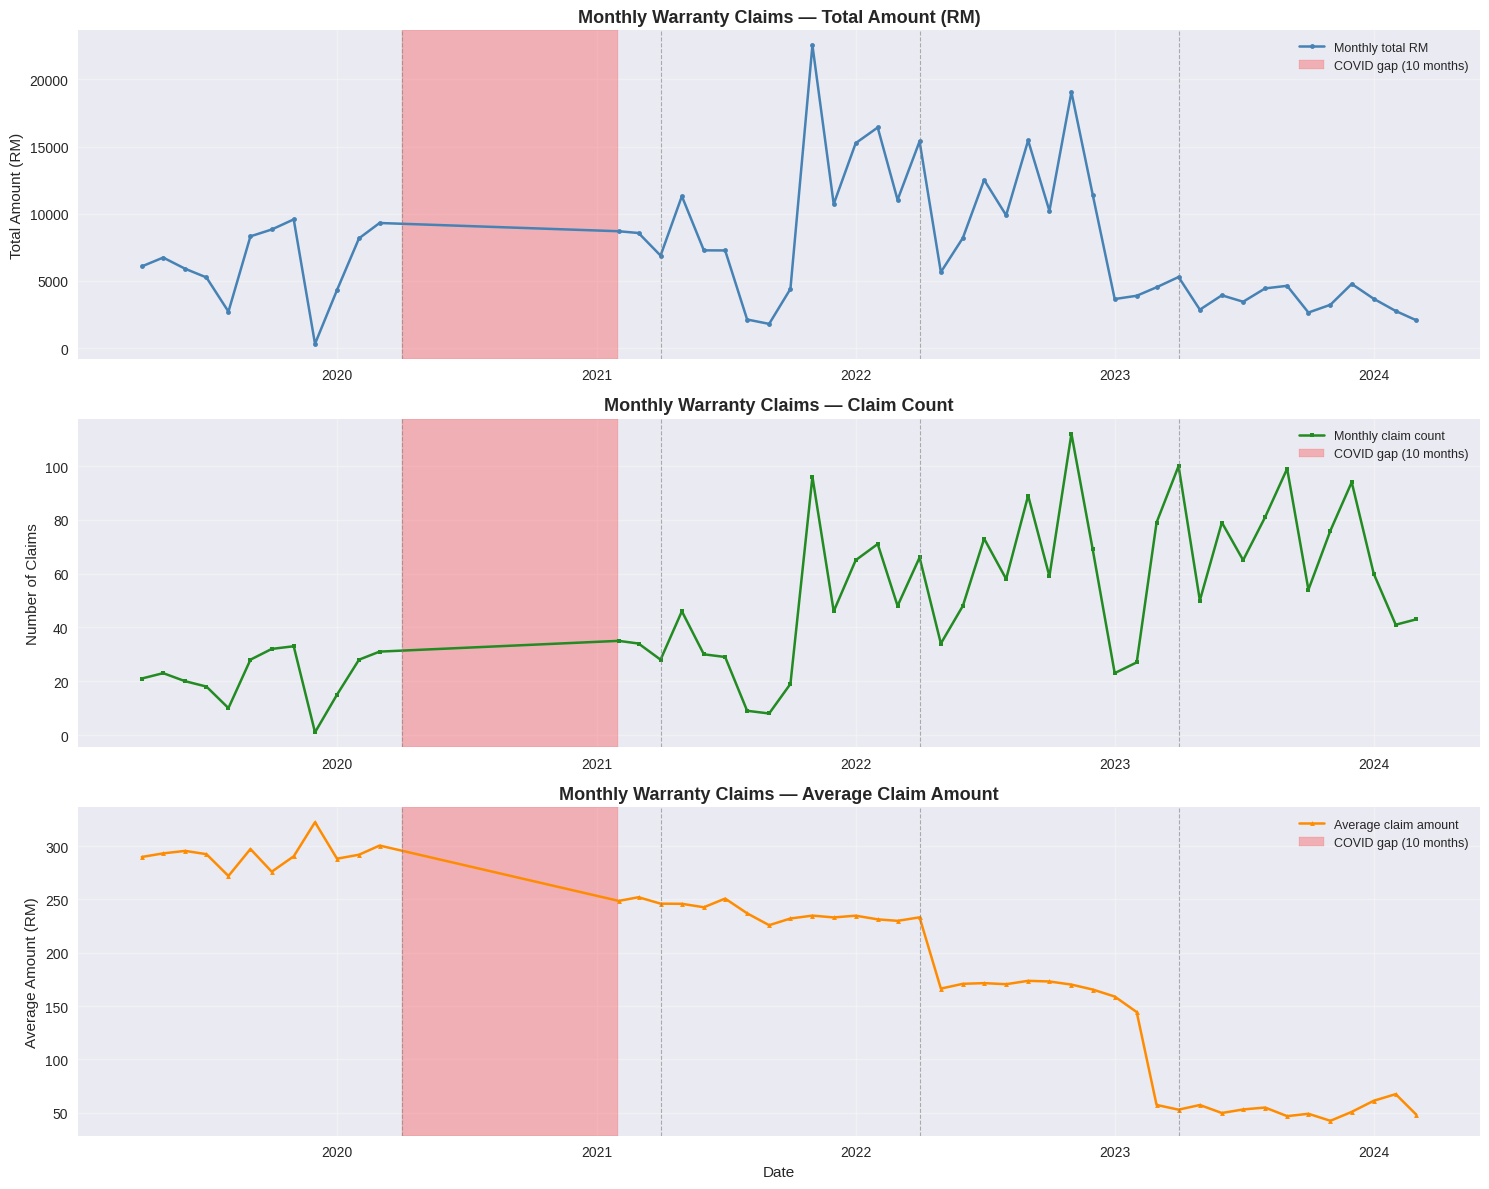


Fiscal year month counts:
  FY2019: complete
  FY2020: INCOMPLETE (2 months)
  FY2021: complete
  FY2022: complete
  FY2023: complete

ts_complete: 48 months (FY20 excluded)

Linear trend (excluding FY20):
  Slope      : -56.19 RM/month  (decreasing)
  R-squared  : 0.0259
  p-value    : 0.2742

  Start (2019-04): 6,086.30 RM
  End   (2024-03): 2,076.03 RM
  Change : -4,010.27 RM  (-65.9%)

Volatility metrics (ts_complete):
  Overall CV             : 0.658
  Mean 6M rolling std    : 3527.14
  High volatility months : 9  (top 20%, threshold 4922.50)


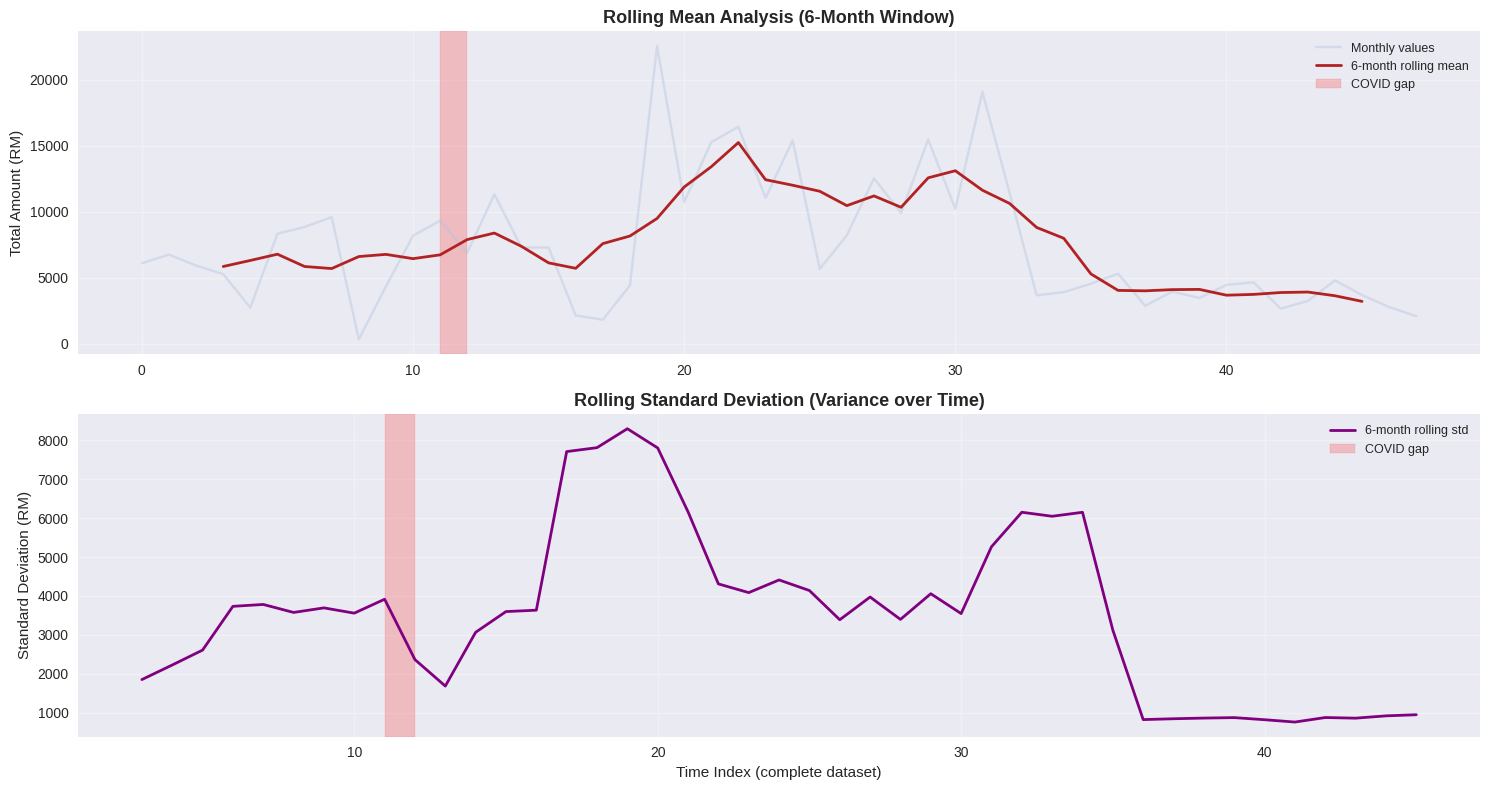


Variance by fiscal year:
  FY          Mean RM       Std RM     CV %
  ------------------------------------------
  2019          6,300        2,826     44.9
  2021          9,758        6,133     62.8
  2022          9,993        5,035     50.4
  2023          3,652          990     27.1

Seasonal profile by fiscal month:
   FM |  Obs |    Mean RM |     Std RM
  --------------------------------------
    1 |    4 |   8,415.77 |   4,696.49
    2 |    4 |   6,644.69 |   3,514.09
    3 |    4 |   6,332.07 |   1,855.37
    4 |    4 |   7,129.00 |   3,919.55
    5 |    4 |   4,798.24 |   3,534.70
    6 |    4 |   7,557.68 |   5,905.54
    7 |    4 |   6,526.64 |   3,577.79
    8 |    4 |  13,604.97 |   8,821.97
    9 |    4 |   6,812.95 |   5,253.83
   10 |    4 |   6,728.95 |   5,695.94
   11 |    4 |   7,816.14 |   6,193.22
   12 |    4 |   6,740.34 |   4,152.54

Seasonality metrics:
  Seasonal range    : 8806.73 RM
  Overall mean      : 7425.62 RM
  Strength ratio    : 1.186  (strong)


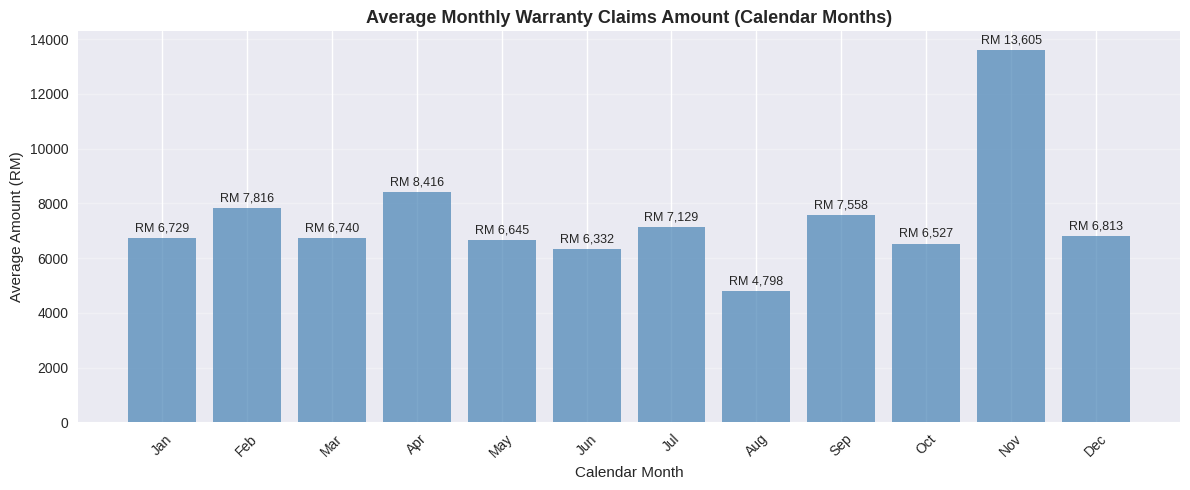


Block 4 complete.
  ts_data     : 50 months  (full series including FY20 restart months)
  ts_complete : 48 months  (FY20 excluded — primary modelling dataset)

Key characteristics for Block 2 (Stationarity Testing):
  Trend            : -56.19 RM/month  (decreasing)
  Seasonality      : 1.186  (strong)
  Volatility (CV)  : 0.658
  COVID months     : 2 flagged (inherited from Block 3)

Iterative validation strategy for modelling:
  Iteration 1 : FY19         → predict FY21
  Iteration 2 : FY19 + FY21  → predict FY22
  Iteration 3 : FY19–FY22    → predict FY23
  Production  : all available → predict FY24


In [14]:
# Block 4: Time Series Foundation Analysis
# Create monthly aggregated time series and initial analysis

# =============================================================================
# 1. CORE TIME SERIES PREPARATION
# =============================================================================
# monthly_ts from Block 3 is the validated, COVID-flagged monthly aggregate.
# carry forward only the columns needed for modelling and add a sequential
# time index (0-based integer) so that regression-based models can consume
# the series without requiring datetime-aware indexing.
#
# COVID_Affected flags are inherited directly from Block 3
# (202102, 202103) are identified as the COVID-affected periods.

from scipy import stats
import calendar

ts_data = monthly_ts[
    [
        "Claimed Month",
        "Claims_Count",
        "Total_RM",
        "Mean_RM",
        "Fiscal_Year",
        "Fiscal_Month",
        "Date_Label",
        "FY_Label",
        "COVID_Affected",
    ]
].copy()

ts_data = ts_data.sort_values("Claimed Month").reset_index(drop=True)
ts_data["Time_Index"] = range(len(ts_data))

# Convert Date_Label to datetime for matplotlib axes.
# This is done once here and reused across all plots in this block.
ts_data["Date_Datetime"] = pd.to_datetime(ts_data["Date_Label"])

print("Time series prepared:")
print(f"  Shape      : {ts_data.shape}")
print(f"  Date range : {ts_data['Date_Label'].iloc[0]} → {ts_data['Date_Label'].iloc[-1]}")
print(f"  Months     : {len(ts_data)}")

cv = ts_data["Total_RM"].std() / ts_data["Total_RM"].mean()
print(f"\nTotal_RM summary:")
print(f"  Mean   : {ts_data['Total_RM'].mean():,.2f}")
print(f"  Std    : {ts_data['Total_RM'].std():,.2f}")
print(f"  Min    : {ts_data['Total_RM'].min():,.2f}")
print(f"  Max    : {ts_data['Total_RM'].max():,.2f}")
print(f"  CV     : {cv:.3f}")

# =============================================================================
# 2. TIME SERIES VISUALISATION WITH COVID GAP HIGHLIGHTING
# =============================================================================
# The COVID shutdown gap (Apr 2020 – Jan 2021) produced 10 consecutive missing
# months. We shade this gap on all plots so reviewers can immediately see where
# the series is discontinuous without needing to read axis labels carefully.
#
# Fiscal year boundaries are overlaid as dashed vertical lines.
# This makes it straightforward to visually confirm whether trends reset or
# continue across FY transitions — relevant for choosing model window length.

covid_gap_start = pd.to_datetime("2020-04-01")
covid_gap_end = pd.to_datetime("2021-01-31")

fy_boundaries = [
    pd.to_datetime("2020-04-01"),
    pd.to_datetime("2021-04-01"),
    pd.to_datetime("2022-04-01"),
    pd.to_datetime("2023-04-01"),
]

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

def _add_fy_and_gap(ax, series_max):
    """Add COVID gap shading and FY boundary lines to an axis."""
    ax.axvspan(covid_gap_start, covid_gap_end, alpha=0.25, color="red", label="COVID gap (10 months)")
    for b in fy_boundaries:
        if b <= ts_data["Date_Datetime"].max():
            ax.axvline(b, color="grey", linestyle="--", linewidth=0.8, alpha=0.6)

# Total_RM
axes[0].plot(ts_data["Date_Datetime"], ts_data["Total_RM"],
             marker="o", linewidth=1.8, markersize=3.5, color="steelblue", label="Monthly total RM")
_add_fy_and_gap(axes[0], ts_data["Total_RM"].max())
axes[0].set_title("Monthly Warranty Claims — Total Amount (RM)", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Total Amount (RM)")
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Claims count
axes[1].plot(ts_data["Date_Datetime"], ts_data["Claims_Count"],
             marker="s", linewidth=1.8, markersize=3.5, color="forestgreen", label="Monthly claim count")
_add_fy_and_gap(axes[1], ts_data["Claims_Count"].max())
axes[1].set_title("Monthly Warranty Claims — Claim Count", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Number of Claims")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

# Mean_RM
axes[2].plot(ts_data["Date_Datetime"], ts_data["Mean_RM"],
             marker="^", linewidth=1.8, markersize=3.5, color="darkorange", label="Average claim amount")
_add_fy_and_gap(axes[2], ts_data["Mean_RM"].max())
axes[2].set_title("Monthly Warranty Claims — Average Claim Amount", fontsize=13, fontweight="bold")
axes[2].set_ylabel("Average Amount (RM)")
axes[2].set_xlabel("Date")
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# 3. FY20 EXCLUSION AND COMPLETE DATASET CONSTRUCTION
# =============================================================================
# FY2020 has only 2 months of data (Feb–Mar 2021, the MCO restart period).
# Including it in model training would introduce a severely underrepresented
# fiscal year that distorts both trend and seasonal estimates.
# All modelling in subsequent blocks uses ts_complete (FY20 excluded).

fy_completeness = ts_data.groupby("Fiscal_Year")["Time_Index"].count()
print("\nFiscal year month counts:")
for fy, n_months in fy_completeness.items():
    status = "complete" if n_months == 12 else f"INCOMPLETE ({n_months} months)"
    print(f"  FY{fy}: {status}")

ts_complete = ts_data[ts_data["Fiscal_Year"] != 2020].copy().reset_index(drop=True)
ts_complete["Time_Index_Complete"] = range(len(ts_complete))

print(f"\nts_complete: {len(ts_complete)} months (FY20 excluded)")

# =============================================================================
# 4. LINEAR TREND ANALYSIS
# =============================================================================
# A simple OLS regression of Total_RM on a time index gives the direction and
# magnitude of the underlying trend.  R-squared and p-value determine whether
# the trend is statistically meaningful — a low R-squared here would suggest
# that more sophisticated detrending may be needed before seasonal modelling.

slope, intercept, r_value, p_value, std_err = stats.linregress(
    ts_complete["Time_Index_Complete"], ts_complete["Total_RM"]
)

trend_direction = "increasing" if slope > 0 else "decreasing" if slope < 0 else "flat"

print(f"\nLinear trend (excluding FY20):")
print(f"  Slope      : {slope:.2f} RM/month  ({trend_direction})")
print(f"  R-squared  : {r_value**2:.4f}")
print(f"  p-value    : {p_value:.4f}")

start_val = ts_complete["Total_RM"].iloc[0]
end_val = ts_complete["Total_RM"].iloc[-1]
print(f"\n  Start ({ts_complete['Date_Label'].iloc[0]}): {start_val:,.2f} RM")
print(f"  End   ({ts_complete['Date_Label'].iloc[-1]}): {end_val:,.2f} RM")
print(f"  Change : {end_val - start_val:+,.2f} RM  ({(end_val - start_val) / start_val * 100:+.1f}%)")

# =============================================================================
# 5. ROLLING VARIANCE ANALYSIS
# =============================================================================
# A 6-month centred rolling window captures short-term volatility without
# smoothing over full seasonal cycles (which would require a 12-month window).
# Centred rolling is preferred over trailing for visualisation because it
# avoids the lag artefact at the end of the series that would otherwise look
# like a spurious drop in volatility.

WINDOW = 6
ts_complete["Rolling_Mean_6M"] = ts_complete["Total_RM"].rolling(window=WINDOW, center=True).mean()
ts_complete["Rolling_Std_6M"] = ts_complete["Total_RM"].rolling(window=WINDOW, center=True).std()

overall_cv = ts_complete["Total_RM"].std() / ts_complete["Total_RM"].mean()
rolling_std_mean = ts_complete["Rolling_Std_6M"].mean()
high_vol_threshold = ts_complete["Rolling_Std_6M"].quantile(0.80)
high_vol_months = (ts_complete["Rolling_Std_6M"] > high_vol_threshold).sum()

print(f"\nVolatility metrics (ts_complete):")
print(f"  Overall CV             : {overall_cv:.3f}")
print(f"  Mean 6M rolling std    : {rolling_std_mean:.2f}")
print(f"  High volatility months : {high_vol_months}  (top 20%, threshold {high_vol_threshold:.2f})")

# Map COVID gap to ts_complete time index for the rolling plots.
# FY2020 is absent from ts_complete, so the gap falls between the last
# FY19 month and the first FY21 month in the integer index.
last_fy19_idx = int(ts_complete[ts_complete["Fiscal_Year"] == 2019]["Time_Index_Complete"].max())
first_fy21_idx = int(ts_complete[ts_complete["Fiscal_Year"] == 2021]["Time_Index_Complete"].min())

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(ts_complete["Time_Index_Complete"], ts_complete["Total_RM"],
             alpha=0.4, color="lightsteelblue", label="Monthly values")
axes[0].plot(ts_complete["Time_Index_Complete"], ts_complete["Rolling_Mean_6M"],
             color="firebrick", linewidth=2, label=f"{WINDOW}-month rolling mean")
axes[0].axvspan(last_fy19_idx, first_fy21_idx, alpha=0.2, color="red", label="COVID gap")
axes[0].set_title(f"Rolling Mean Analysis ({WINDOW}-Month Window)", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Total Amount (RM)")
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

axes[1].plot(ts_complete["Time_Index_Complete"], ts_complete["Rolling_Std_6M"],
             color="purple", linewidth=2, label=f"{WINDOW}-month rolling std")
axes[1].axvspan(last_fy19_idx, first_fy21_idx, alpha=0.2, color="red", label="COVID gap")
axes[1].set_title("Rolling Standard Deviation (Variance over Time)", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Standard Deviation (RM)")
axes[1].set_xlabel("Time Index (complete dataset)")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Variance by fiscal year — shows whether volatility is stable across years
# or concentrated in specific periods (relevant for heteroscedasticity checks).
print("\nVariance by fiscal year:")
print(f"  {'FY':<6} {'Mean RM':>12} {'Std RM':>12} {'CV %':>8}")
print("  " + "-" * 42)
for fy, grp in ts_complete.groupby("Fiscal_Year")["Total_RM"]:
    m, s = grp.mean(), grp.std()
    cv_fy = s / m * 100 if m > 0 else 0
    print(f"  {fy:<6} {m:>12,.0f} {s:>12,.0f} {cv_fy:>8.1f}")

# =============================================================================
# 6. SEASONAL PATTERN ASSESSMENT
# =============================================================================
# Grouping by Fiscal_Month (1=April … 12=March) and averaging across years
# gives the within-year seasonal profile.  Seasonality strength is expressed
# as the ratio of the seasonal range to the overall mean — a common heuristic
# used before formal decomposition tests.

seasonal = (
    ts_complete.groupby("Fiscal_Month")["Total_RM"]
    .agg(observations="count", mean="mean", std="std")
    .reset_index()
)

print("\nSeasonal profile by fiscal month:")
print(f"  {'FM':>3} | {'Obs':>4} | {'Mean RM':>10} | {'Std RM':>10}")
print("  " + "-" * 38)
for _, row in seasonal.iterrows():
    print(f"  {int(row['Fiscal_Month']):>3} | {int(row['observations']):>4} | {row['mean']:>10,.2f} | {row['std']:>10,.2f}")

seasonal_range = seasonal["mean"].max() - seasonal["mean"].min()
overall_mean = seasonal["mean"].mean()
seasonality_strength = seasonal_range / overall_mean

if seasonality_strength > 0.30:
    season_label = "strong"
elif seasonality_strength > 0.15:
    season_label = "moderate"
else:
    season_label = "weak"

print(f"\nSeasonality metrics:")
print(f"  Seasonal range    : {seasonal_range:.2f} RM")
print(f"  Overall mean      : {overall_mean:.2f} RM")
print(f"  Strength ratio    : {seasonality_strength:.3f}  ({season_label})")

# =============================================================================
# 7. CALENDAR MONTH PATTERN ANALYSIS
# =============================================================================
# Calendar month averages reveal public holiday and production-cycle effects
# (e.g. Hari Raya, year-end service campaigns) that do not align neatly with
# fiscal month numbering.  This informs whether calendar month dummies should
# be added as exogenous regressors in SARIMAX.

ts_complete["Calendar_Month_Num"] = pd.to_datetime(ts_complete["Date_Label"]).dt.month

monthly_pattern = (
    ts_complete.groupby("Calendar_Month_Num")["Total_RM"]
    .agg(avg_amount="mean", month_count="count")
    .round(2)
)

print("\nAverage amount by calendar month:")
print(f"  {'Month':<10} {'Avg RM':>12} {'Data Points':>12}")
print("  " + "-" * 38)
for month_num, row in monthly_pattern.iterrows():
    mname = calendar.month_abbr[month_num]
    print(f"  {mname:<10} {row['avg_amount']:>12,.0f} {int(row['month_count']):>12}")

highest_cal_month = monthly_pattern["avg_amount"].idxmax()
lowest_cal_month = monthly_pattern["avg_amount"].idxmin()
print(f"\n  Peak month   : {calendar.month_name[highest_cal_month]}  (RM {monthly_pattern.loc[highest_cal_month, 'avg_amount']:,.0f})")
print(f"  Trough month : {calendar.month_name[lowest_cal_month]}  (RM {monthly_pattern.loc[lowest_cal_month, 'avg_amount']:,.0f})")

# Bar chart — calendar month averages
fig, ax = plt.subplots(figsize=(12, 5))
months_present = monthly_pattern.index
month_labels = [calendar.month_abbr[m] for m in months_present]
amounts = monthly_pattern["avg_amount"].values

bars = ax.bar(month_labels, amounts, color="steelblue", alpha=0.7)
ax.set_title("Average Monthly Warranty Claims Amount (Calendar Months)", fontsize=13, fontweight="bold")
ax.set_ylabel("Average Amount (RM)")
ax.set_xlabel("Calendar Month")
ax.grid(True, alpha=0.3, axis="y")

for bar, amt in zip(bars, amounts):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + amounts.max() * 0.01,
        f"RM {amt:,.0f}",
        ha="center", va="bottom", fontsize=9,
    )

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================================================================
# 8. HANDOFF SUMMARY
# =============================================================================
# ts_complete is the primary modelling dataset for all subsequent blocks.
# Key characteristics to carry into stationarity testing (Block 2):
#   - Linear trend present (direction and slope noted above)
#   - Seasonal strength ratio noted above
#   - CV noted above — informs whether variance stabilisation is needed

print("\nBlock 4 complete.")
print(f"  ts_data     : {len(ts_data)} months  (full series including FY20 restart months)")
print(f"  ts_complete : {len(ts_complete)} months  (FY20 excluded — primary modelling dataset)")
print(f"\nKey characteristics for Block 2 (Stationarity Testing):")
print(f"  Trend            : {slope:+.2f} RM/month  ({trend_direction})")
print(f"  Seasonality      : {seasonality_strength:.3f}  ({season_label})")
print(f"  Volatility (CV)  : {overall_cv:.3f}")
print(f"  COVID months     : {ts_data['COVID_Affected'].sum()} flagged (inherited from Block 3)")
print("\nIterative validation strategy for modelling:")
print("  Iteration 1 : FY19         → predict FY21")
print("  Iteration 2 : FY19 + FY21  → predict FY22")
print("  Iteration 3 : FY19–FY22    → predict FY23")
print("  Production  : all available → predict FY24")

# [2.2] Target Variable EDA

Total_RM descriptive statistics:
count       48.00
mean      7425.62
std       4885.16
min        322.38
25%       3843.54
50%       5998.18
75%       9971.48
max      22544.85
Name: Total_RM, dtype: float64

Skewness : 1.1248
Kurtosis : 1.0221


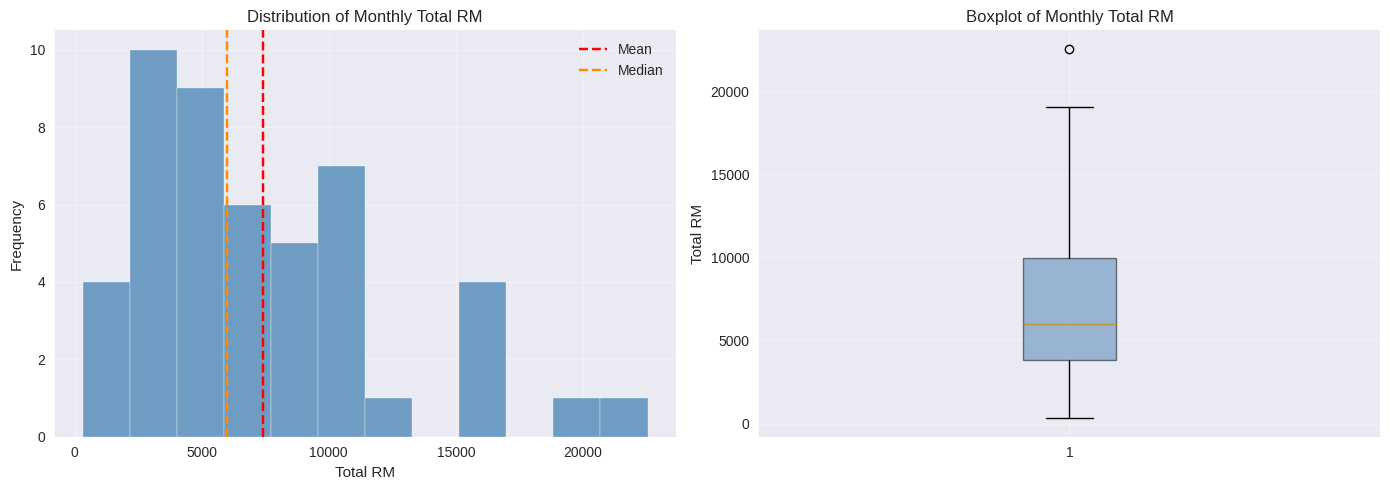


IQR outlier bounds: [-5,348.37,  19,163.40]
Outlier months identified: 1
Date_Label FY_Label  Total_RM  Claims_Count  COVID_Affected
   2021-11   FY2021  22544.85            96           False

Year-over-year Total RM by fiscal month:
Fiscal_Year      2019      2021      2022     2023
Fiscal_Month                                      
1             6086.30   6889.31  15392.53  5294.96
2             6743.13  11311.72   5658.49  2865.41
3             5910.05   7279.96   8203.65  3934.62
4             5263.86   7273.91  12522.83  3455.39
5             2719.88   2132.87   9891.04  4449.16
6             8323.17   1806.80  15460.57  4640.18
7             8832.15   4410.57  10212.82  2651.00
8             9584.20  22544.85  19060.42  3230.41
9              322.38  10724.62  11423.11  4781.70
10            4322.99  15260.23   3656.55  3676.03
11            8173.43  16424.65   3899.38  2767.10
12            9315.94  11037.38   4531.99  2076.03


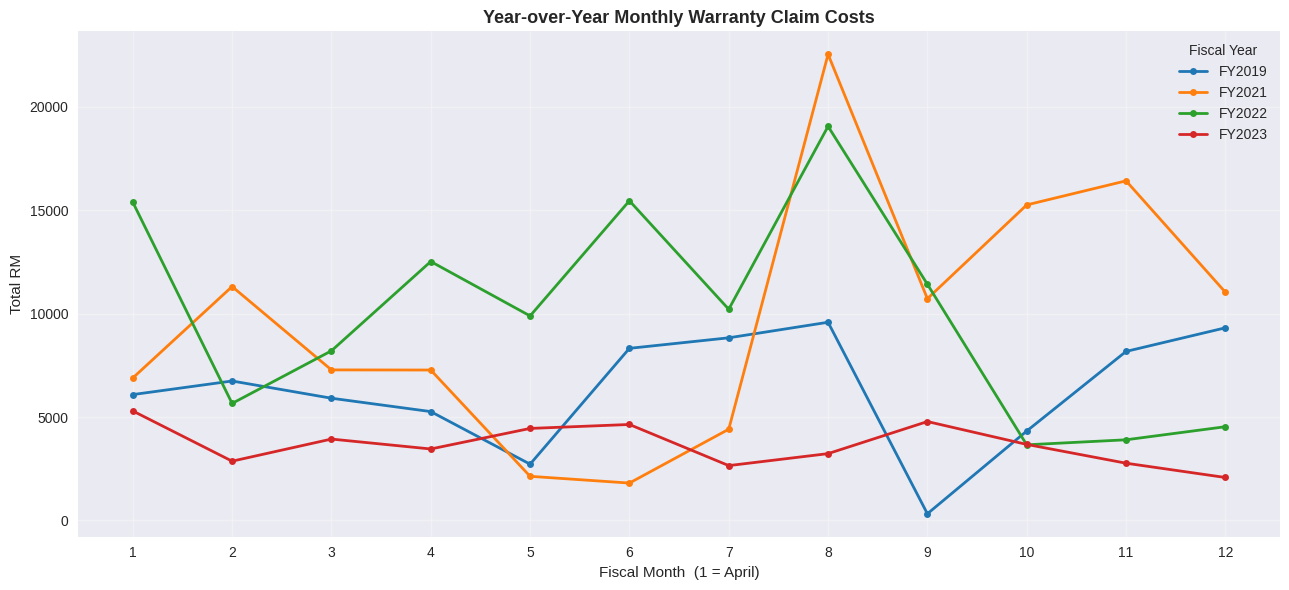


Claims Count vs Total RM:
  Pearson r : 0.4662
  R²        : 0.2173
  p-value   : 0.0008
  Slope     : 80.17 RM per additional claim

Avg Severity vs Total RM:
  Pearson r : 0.2984

Primary cost driver: claim volume


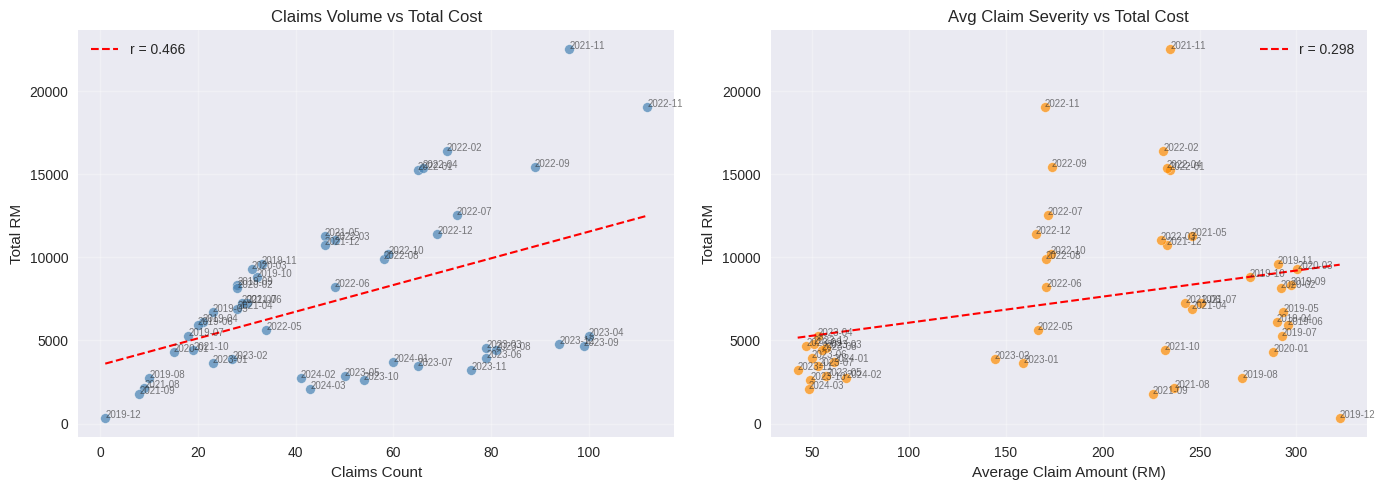


Block 5 complete.
  Skewness         : 1.1248
  Kurtosis         : 1.0221
  IQR outliers     : 1 month(s)
  Primary driver   : claim volume
  Avg_Severity col : added to ts_complete


In [15]:
# Block 5: Target Variable EDA
# Exploratory analysis of Total_RM as the primary forecasting target

# =============================================================================
# 1. DISTRIBUTION ANALYSIS
# =============================================================================
# Before any modelling, understanding the distributional shape of Total_RM
# determines whether transformations are needed.
#
# Skewness > 1 or < -1 typically warrants a log or Box-Cox transform to
# stabilise variance and satisfy the normality assumption of OLS-based models.
# Kurtosis > 3 (excess > 0) indicates heavier tails than a normal distribution,
# which would inflate prediction intervals if left unaddressed.

print("Total_RM descriptive statistics:")
print(ts_complete["Total_RM"].describe().round(2))
print(f"\nSkewness : {ts_complete['Total_RM'].skew():.4f}")
print(f"Kurtosis : {ts_complete['Total_RM'].kurt():.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(ts_complete["Total_RM"], bins=12,
             color="steelblue", alpha=0.75, edgecolor="white")
axes[0].axvline(ts_complete["Total_RM"].mean(),
                color="red", linestyle="--", label="Mean")
axes[0].axvline(ts_complete["Total_RM"].median(),
                color="darkorange", linestyle="--", label="Median")
axes[0].set_title("Distribution of Monthly Total RM")
axes[0].set_xlabel("Total RM")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(ts_complete["Total_RM"], vert=True, patch_artist=True,
                boxprops=dict(facecolor="steelblue", alpha=0.5))
axes[1].set_title("Boxplot of Monthly Total RM")
axes[1].set_ylabel("Total RM")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# 2. OUTLIER PROFILING
# =============================================================================
# The Tukey IQR method (1.5 × IQR rule) is used rather than z-score because
# the series length is short (~48 months) and z-score outlier detection
# is sensitive to the mean being pulled by the very values being tested.
# IQR is a rank-based, non-parametric approach that is more robust here.
#
# Identified outliers are not removed at this stage — they are profiled to
# determine whether they are legitimate operational events (e.g. post-COVID
# claim backlog) or data errors. That decision is made in Block 6.

q1 = ts_complete["Total_RM"].quantile(0.25)
q3 = ts_complete["Total_RM"].quantile(0.75)
iqr = q3 - q1
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

outliers = ts_complete[
    (ts_complete["Total_RM"] < lower_fence) |
    (ts_complete["Total_RM"] > upper_fence)
][["Date_Label", "FY_Label", "Total_RM", "Claims_Count", "COVID_Affected"]]

print(f"\nIQR outlier bounds: [{lower_fence:,.2f},  {upper_fence:,.2f}]")
print(f"Outlier months identified: {len(outliers)}")

if not outliers.empty:
    print(outliers.to_string(index=False))
else:
    print("No outlier months detected under the 1.5×IQR rule.")

# =============================================================================
# 3. YEAR-OVER-YEAR COMPARISON
# =============================================================================
# Pivoting to a (fiscal_month × fiscal_year) matrix makes seasonal patterns
# immediately visible — if the same fiscal month consistently shows higher or
# lower values across years, that confirms repeatable seasonality worth
# encoding in the model.
#
# FY2020 is absent from ts_complete so the pivot will have NaN for that
# column; dropna() on each series at plot time handles this cleanly.

fy_month_pivot = ts_complete.pivot_table(
    index="Fiscal_Month", columns="Fiscal_Year", values="Total_RM"
)

print("\nYear-over-year Total RM by fiscal month:")
print(fy_month_pivot.round(2).to_string())

fig, ax = plt.subplots(figsize=(13, 6))

colors = plt.cm.tab10.colors
for i, fy in enumerate(fy_month_pivot.columns):
    series = fy_month_pivot[fy].dropna()
    ax.plot(
        series.index, series.values,
        marker="o", linewidth=2, markersize=5,
        color=colors[i % len(colors)], label=f"FY{fy}",
    )

ax.set_title("Year-over-Year Monthly Warranty Claim Costs", fontsize=13, fontweight="bold")
ax.set_xlabel("Fiscal Month  (1 = April)")
ax.set_ylabel("Total RM")
ax.set_xticks(range(1, 13))
ax.legend(title="Fiscal Year")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# 4. CLAIMS COUNT vs TOTAL RM — VOLUME AND SEVERITY DECOMPOSITION
# =============================================================================
# Total cost = volume × average severity.  Understanding which component
# drives variability determines the right feature set:
#   - If volume dominates → claims count is a strong predictor
#   - If severity dominates → average repair cost per claim is more informative
#
# Both are assessed via Pearson correlation against Total_RM.
# Pearson is appropriate here because we are testing linear association
# between two continuous variables, not ranking or non-linear dependence.
#
# Note: Avg_Severity is a derived ratio (Total_RM / Claims_Count) and is
# therefore not independent of Total_RM. The severity correlation should be
# interpreted as a decomposition diagnostic, not a standalone predictor check.

corr_volume = ts_complete["Claims_Count"].corr(ts_complete["Total_RM"])
slope_v, intercept_v, r_v, p_v, _ = stats.linregress(
    ts_complete["Claims_Count"], ts_complete["Total_RM"]
)

ts_complete["Avg_Severity"] = ts_complete["Total_RM"] / ts_complete["Claims_Count"]
corr_severity = ts_complete["Avg_Severity"].corr(ts_complete["Total_RM"])

print(f"\nClaims Count vs Total RM:")
print(f"  Pearson r : {corr_volume:.4f}")
print(f"  R²        : {r_v**2:.4f}")
print(f"  p-value   : {p_v:.4f}")
print(f"  Slope     : {slope_v:.2f} RM per additional claim")

print(f"\nAvg Severity vs Total RM:")
print(f"  Pearson r : {corr_severity:.4f}")

primary_driver = "claim severity" if abs(corr_severity) > abs(corr_volume) else "claim volume"
print(f"\nPrimary cost driver: {primary_driver}")

# Scatter plots with regression lines and month labels.
# Annotating each point with Date_Label allows quick identification of which
# specific months sit away from the regression line — useful context when
# interpreting residuals from the forecast models later.

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Volume vs cost
axes[0].scatter(ts_complete["Claims_Count"], ts_complete["Total_RM"],
                color="steelblue", alpha=0.7, edgecolors="white")

x_range = np.linspace(ts_complete["Claims_Count"].min(),
                      ts_complete["Claims_Count"].max(), 100)
axes[0].plot(x_range, slope_v * x_range + intercept_v,
             color="red", linestyle="--", linewidth=1.5, label=f"r = {corr_volume:.3f}")

for _, row in ts_complete.iterrows():
    axes[0].annotate(row["Date_Label"],
                     (row["Claims_Count"], row["Total_RM"]),
                     fontsize=7, alpha=0.6)

axes[0].set_title("Claims Volume vs Total Cost")
axes[0].set_xlabel("Claims Count")
axes[0].set_ylabel("Total RM")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Severity vs cost
slope_s, intercept_s, r_s, _, _ = stats.linregress(
    ts_complete["Avg_Severity"], ts_complete["Total_RM"]
)

axes[1].scatter(ts_complete["Avg_Severity"], ts_complete["Total_RM"],
                color="darkorange", alpha=0.7, edgecolors="white")

x_range_s = np.linspace(ts_complete["Avg_Severity"].min(),
                        ts_complete["Avg_Severity"].max(), 100)
axes[1].plot(x_range_s, slope_s * x_range_s + intercept_s,
             color="red", linestyle="--", linewidth=1.5, label=f"r = {corr_severity:.3f}")

for _, row in ts_complete.iterrows():
    axes[1].annotate(row["Date_Label"],
                     (row["Avg_Severity"], row["Total_RM"]),
                     fontsize=7, alpha=0.6)

axes[1].set_title("Avg Claim Severity vs Total Cost")
axes[1].set_xlabel("Average Claim Amount (RM)")
axes[1].set_ylabel("Total RM")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# 5. HANDOFF SUMMARY
# =============================================================================
# Key EDA findings carried forward to Block 6 (Stationarity Testing):
#   - Skewness / kurtosis values: decide whether log-transform is needed
#   - Outlier months: noted for treatment decision in preprocessing
#   - Primary cost driver: informs feature engineering for ML models
#   - YoY profile: qualitative confirmation of seasonal structure

print("\nBlock 5 complete.")
print(f"  Skewness         : {ts_complete['Total_RM'].skew():.4f}")
print(f"  Kurtosis         : {ts_complete['Total_RM'].kurt():.4f}")
print(f"  IQR outliers     : {len(outliers)} month(s)")
print(f"  Primary driver   : {primary_driver}")
print(f"  Avg_Severity col : added to ts_complete")

# [2.3] Business Pattern & Feature Analysis

Unique models: 8
Model Name  Claims_Count  Mean_RM  Std_RM  Total_RM  First_Claim  Last_Claim
      ARUZ          1145   120.69   86.22 138195.61       202102      202403
     BEZZA           873   184.05  102.80 160675.85       201904      202403
      MYVI           127   125.72   94.25  15966.48       201905      202403
      AXIA           121   184.02   57.69  22267.01       201904      202403
  NEW MYVI           121   255.39   23.82  30902.78       201904      202205
     ATIVA            11   398.48   10.55   4383.28       202201      202309
  NEW AXIA             3   274.19    0.00    822.57       202310      202403
  NEW ALZA             2   244.29    0.00    488.58       202308      202311

Part category breakdown:
Part category  Claims_Count  Mean_RM  Std_RM  Total_RM  Models_Affected
          E/E          2072   153.42  101.46 317892.41                8
          A/C           331   168.61   80.63  55809.75                7

Top 10 original failed parts by claim frequency

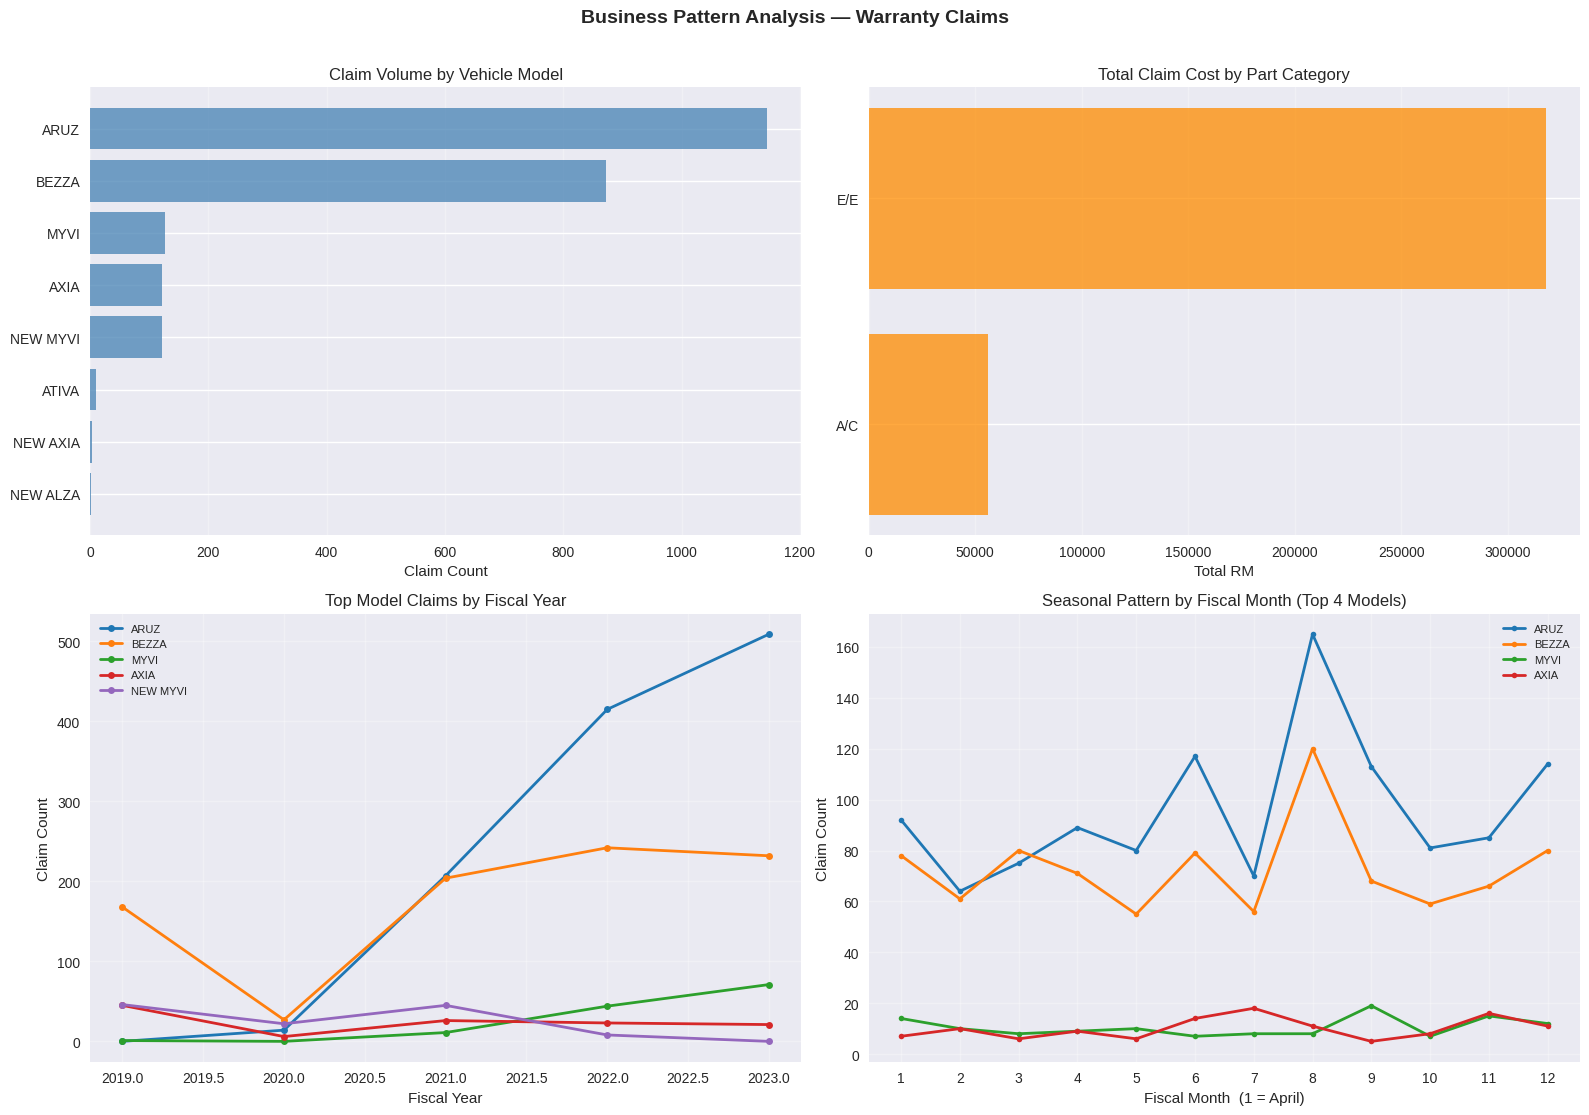

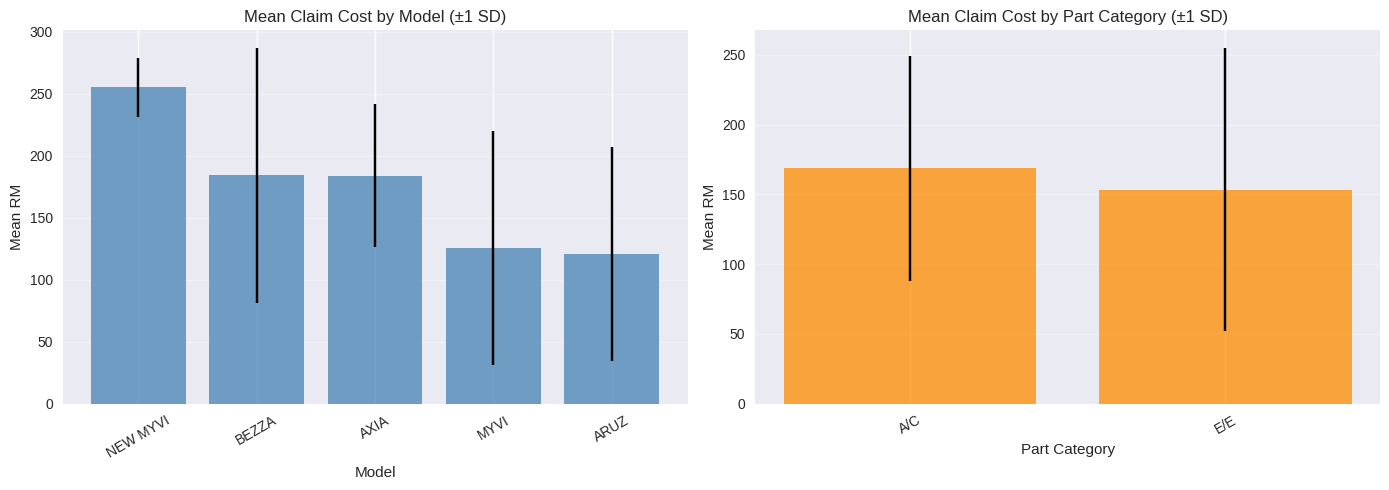

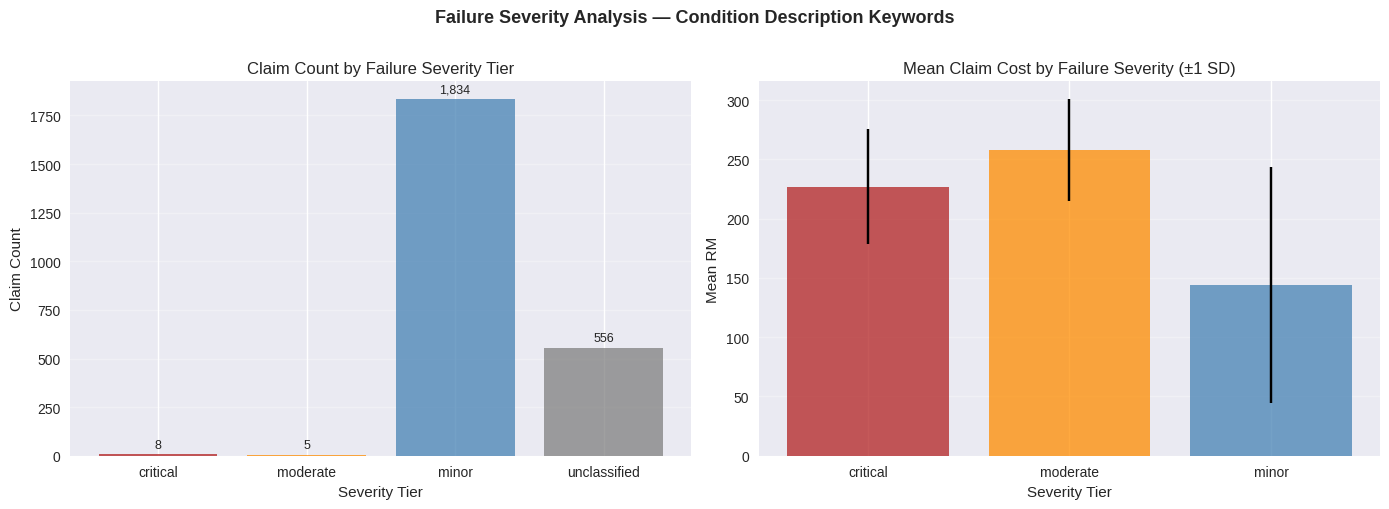


Block 6 complete.
  Unique models           : 8
  Top 5 models identified : ['ARUZ', 'BEZZA', 'MYVI', 'AXIA', 'NEW MYVI']
  Top 5 part categories   : ['E/E', 'A/C']
  Failure_Severity column : added to df_clean


In [16]:
# Block 6: Business Pattern & Feature Analysis
# Analyze warranty claim patterns by vehicle models, parts, and failure types

from scipy.stats import chi2_contingency

# =============================================================================
# 1. VEHICLE MODEL ANALYSIS
# =============================================================================
# Understanding which vehicle models generate the most claims and the highest
# costs is essential for two reasons:
#   (a) It informs whether model-level dummy variables add predictive signal
#       to the forecasting models, or whether claims are evenly distributed
#       across models (in which case dummies add noise, not signal).
#   (b) It identifies concentration risk — if one model dominates, its
#       production cycle and recall history become confounding variables
#       that need to be accounted for in the feature set.
#
# Named aggregation syntax is used throughout to avoid the multi-level
# column header that results from passing a dict of lists to groupby.agg().

model_stats = (
    df_clean.groupby("Model Name")
    .agg(
        Claims_Count=("RM", "count"),
        Mean_RM=("RM", "mean"),
        Std_RM=("RM", "std"),
        Total_RM=("RM", "sum"),
        First_Claim=("Claimed Month", "min"),
        Last_Claim=("Claimed Month", "max"),
    )
    .round(2)
    .sort_values("Claims_Count", ascending=False)
    .reset_index()
)

top_models = model_stats["Model Name"].head(5).tolist()

print(f"Unique models: {len(model_stats)}")
print(model_stats.head(10).to_string(index=False))

# =============================================================================
# 2. PART CATEGORY ANALYSIS
# =============================================================================
# Part category distribution reveals whether warranty cost is concentrated
# in specific component types (e.g. electrical, mechanical) or spread broadly.
# Concentration in a few categories supports the use of part-level dummies
# without excessive dimensionality.
#
# Models_Affected counts how many distinct vehicle models a part category
# appears across — a category affecting many models is more likely to reflect
# a systematic design issue rather than model-specific variance.
#
# Note: the unique count is intentionally excluded from the print output.
# The full category table below already makes the dimensionality visible,
# and repeating a single number adds clutter without analytical value.

part_stats = (
    df_clean.groupby("Part category")
    .agg(
        Claims_Count=("RM", "count"),
        Mean_RM=("RM", "mean"),
        Std_RM=("RM", "std"),
        Total_RM=("RM", "sum"),
        Models_Affected=("Model Name", "nunique"),
    )
    .round(2)
    .sort_values("Claims_Count", ascending=False)
    .reset_index()
)

top_parts = part_stats["Part category"].head(5).tolist()

print("\nPart category breakdown:")
print(part_stats.head(10).to_string(index=False))

# =============================================================================
# 3. FAILED PART ANALYSIS
# =============================================================================
# 'Original Failed Part' records the specific component that triggered the
# warranty claim. This is a finer-grained dimension than 'Part category' and
# may reveal whether a particular sub-component (e.g. rectifier diode vs
# rotor winding within the alternator) is driving disproportionate cost.

print("\nTop 10 original failed parts by claim frequency:")
print(df_clean["Original Failed Part"].value_counts().head(10).to_string())

# =============================================================================
# 4. CONDITION DESCRIPTION — KEYWORD-BASED SEVERITY CLASSIFICATION
# =============================================================================
# 'Condition Description' is a free-text field entered by service technicians
# describing the failure mode observed (e.g. "noisy", "not charging",
# "battery flat").
#
# WHY NOT standard NLP sentiment models (VADER, TextBlob):
#   Standard sentiment lexicons are trained on general consumer language.
#   Automotive-technical terms like "overcharge", "no output", or "seized"
#   are absent from those lexicons and would receive incorrect polarity scores.
#   A model that reads "dead cell" as neutral or positive is not useful here.
#
# WHY a domain-specific keyword dictionary instead:
#   Rule-based classification is fully interpretable and auditable by
#   Perodua's engineering team — who can directly validate or update
#   the keyword lists without retraining a model.
#   It also works reliably on small datasets where ML classifiers
#   would overfit or produce low-confidence outputs.
#
# HOW the classification works:
#   Each description is checked against three keyword tiers in priority order.
#   Critical is checked first — so a description containing both "noise" and
#   "no output" is correctly classified as critical, not minor.
#   Descriptions that match no keyword fall into 'unclassified', which is
#   retained as a separate category rather than dropped — it may itself be
#   informative if unclassified records correlate with lower-cost claims
#   (i.e. technicians may write less detail for routine, inexpensive repairs).
#
# OUTPUT: df_clean['Failure_Severity'] is a new categorical column
#   (critical / moderate / minor / unclassified) used as a feature candidate
#   in Phase 3 regression models.

if "Condition Description" in df_clean.columns:
    n_valid = df_clean["Condition Description"].notna().sum()
    print(f"\nCondition descriptions: {n_valid:,}  ({n_valid / len(df_clean) * 100:.1f}% non-null)")

    if n_valid > 0:
        # Keyword lists are intentionally conservative — only terms whose severity
        # classification is unambiguous in an alternator warranty context.
        # Domain experts should extend these lists based on actual data review.
        CRITICAL_KEYWORDS = [
            "no output", "not charging", "dead", "seized", "burnt",
            "broken", "failed", "failure", "damaged", "shorted",
            "open circuit", "no charge", "complete", "total loss",
        ]
        MODERATE_KEYWORDS = [
            "intermittent", "weak", "low output", "overcharge", "fluctuat",
            "irregular", "unstable", "undercharge", "erratic", "dropping",
        ]
        MINOR_KEYWORDS = [
            "noise", "noisy", "vibrat", "rattle", "squeal",
            "smell", "heat", "warm", "slight", "minor",
        ]

        def classify_severity(text):
            """
            Classify a technician condition description into a failure severity tier.

            Matching is hierarchical (critical → moderate → minor) to ensure
            that descriptions mentioning both a severe and a mild symptom are
            assigned to the more severe tier.

            Parameters
            ----------
            text : str or float (NaN)

            Returns
            -------
            str
                One of 'critical', 'moderate', 'minor', or 'unclassified'.
            """
            if not isinstance(text, str):
                return "unclassified"
            text_lower = text.lower()
            if any(kw in text_lower for kw in CRITICAL_KEYWORDS):
                return "critical"
            if any(kw in text_lower for kw in MODERATE_KEYWORDS):
                return "moderate"
            if any(kw in text_lower for kw in MINOR_KEYWORDS):
                return "minor"
            return "unclassified"

        df_clean["Failure_Severity"] = df_clean["Condition Description"].apply(classify_severity)

        severity_counts = df_clean["Failure_Severity"].value_counts()
        severity_pct = (severity_counts / n_valid * 100).round(1)

        print("\nFailure severity classification:")
        for label, count in severity_counts.items():
            print(f"  {label:<15} {count:>6,}  ({severity_pct[label]:.1f}%)")

        # If severity correlates with cost, it is a meaningful feature.
        # If mean costs are similar across tiers, the column adds little signal
        # and should be excluded to avoid unnecessary dimensionality.
        severity_cost = (
            df_clean[df_clean["Failure_Severity"] != "unclassified"]
            .groupby("Failure_Severity")["RM"]
            .agg(mean="mean", std="std", count="count")
            .round(2)
        )
        print("\nMean claim cost by failure severity:")
        print(severity_cost.to_string())

        # Sample descriptions allow a domain expert to spot-check whether the
        # keyword rules are producing sensible classifications before committing
        # Failure_Severity to the feature set.
        print("\nSample descriptions per severity tier (for keyword validation):")
        for tier in ["critical", "moderate", "minor", "unclassified"]:
            samples = (
                df_clean.loc[df_clean["Failure_Severity"] == tier, "Condition Description"]
                .dropna()
                .head(3)
                .tolist()
            )
            if samples:
                print(f"  {tier}:")
                for s in samples:
                    print(f"    - {str(s)[:80]}")
    else:
        print("  No non-null condition descriptions — severity analysis skipped.")
        df_clean["Failure_Severity"] = "unclassified"
else:
    print("\nCondition Description column not found — severity analysis skipped.")
    df_clean["Failure_Severity"] = "unclassified"

# =============================================================================
# 5. MODEL × FISCAL YEAR TREND AND PATTERN STABILITY
# =============================================================================
# A model whose claim count is erratic across fiscal years (high CV) introduces
# noise rather than signal when used as a dummy variable.
# CV threshold conventions used here:
#   < 0.5  → stable:   safe to use as a dummy variable
#   0.5–1.0 → moderate: use with caution; consider grouping with other models
#   > 1.0  → volatile:  likely driven by specific recall or fleet age events;
#             treat as a special-case flag rather than a standard dummy

model_fy = (
    df_clean.groupby(["Fiscal_Year", "Model Name"])
    .size()
    .unstack(fill_value=0)
)

print("\nClaim counts — top models by fiscal year:")
print(model_fy[top_models].to_string())

print("\nPattern stability by model (CV across fiscal years):")
for model in top_models:
    if model in model_fy.columns:
        s = model_fy[model]
        cv = s.std() / s.mean() if s.mean() > 0 else np.nan
        lvl = "stable" if cv < 0.5 else "moderate" if cv < 1.0 else "volatile"
        print(f"  {model:<25}  CV = {cv:.3f}  ({lvl})")

# =============================================================================
# 6. COST ANALYSIS BY MODEL AND PART CATEGORY
# =============================================================================
# Mean ± std cost per category reveals whether cost variance is homogeneous
# across categories (supports pooled modelling) or heterogeneous (supports
# category-specific intercepts or separate sub-models).

print("\nClaim cost by top models:")
cost_model = (
    df_clean[df_clean["Model Name"].isin(top_models)]
    .groupby("Model Name")["RM"]
    .agg(mean="mean", std="std", count="count")
    .round(2)
)
print(cost_model.to_string())

print("\nClaim cost by top part categories:")
cost_part = (
    df_clean[df_clean["Part category"].isin(top_parts)]
    .groupby("Part category")["RM"]
    .agg(mean="mean", std="std", count="count")
    .round(2)
)
print(cost_part.to_string())

# =============================================================================
# 7. SEASONAL PATTERN BY MODEL
# =============================================================================
# If all models show the same seasonal pattern, a single set of fiscal month
# dummies is sufficient.  If models diverge, model × month interaction terms
# may be warranted — though this adds parameters that a short series may not
# support (risk of overfitting with ~48 observations).

seasonal_model = (
    df_clean.groupby(["Fiscal_Month", "Model Name"])
    .size()
    .unstack(fill_value=0)
)

print("\nSeasonal strength by model (range / mean across fiscal months):")
for model in top_models:
    if model in seasonal_model.columns:
        s = seasonal_model[model]
        strength = (s.max() - s.min()) / s.mean() if s.mean() > 0 else np.nan
        lvl = "strong" if strength > 1.0 else "moderate" if strength > 0.5 else "weak"
        print(f"  {model:<25}  {strength:.3f}  ({lvl})")

# =============================================================================
# 8. CHI-SQUARE: MODEL DISTRIBUTION STABILITY ACROSS FISCAL YEARS
# =============================================================================
# H0: the proportion of claims per model is independent of fiscal year.
# H1: model share has shifted across fiscal years.
#
# A significant result (p < 0.05) means the model mix is changing over time,
# which would require time-varying model weights in the feature engineering
# rather than static dummy variables.
#
# FY2020 is excluded from the contingency table because its 2-month presence
# creates a structurally sparse row that violates the chi-square assumption
# that all expected cell frequencies are ≥ 5.

fy_list = sorted([fy for fy in df_clean["Fiscal_Year"].unique() if fy != 2020])
contingency = [
    [
        len(df_clean[(df_clean["Model Name"] == m) & (df_clean["Fiscal_Year"] == fy)])
        for fy in fy_list
    ]
    for m in top_models
]

try:
    chi2_stat, p_val, dof, _ = chi2_contingency(contingency)
    result = "stable" if p_val > 0.05 else "changing"
    print(
        f"\nModel-FY chi-square:  chi2 = {chi2_stat:.4f}  p = {p_val:.4f}  "
        f"dof = {dof}  →  model distribution is {result} across fiscal years"
    )
except Exception as e:
    print(f"\nChi-square test failed: {e}")

# =============================================================================
# 9. FEATURE ENGINEERING NOTES
# =============================================================================
# These notes are carried forward to Phase 3 as the feature candidate list.
# Thresholds are evaluated against computed values, not hardcoded assumptions.
# COVID months are referenced from ts_data (Block 3 output) — no month values
# are hardcoded here to prevent Block 6 from drifting out of sync with Block 3.

n_models = df_clean["Model Name"].nunique()
n_parts = df_clean["Part category"].nunique()
covid_flagged = ts_data.loc[ts_data["COVID_Affected"], "Date_Label"].tolist()

print("\nFeature candidates for Phase 3:")
print(f"  Model dummies    : {n_models} categories  "
      f"({'use as-is' if n_models <= 20 else 'group top N — too many for direct encoding'})")
print(f"  Part dummies     : {n_parts} categories  "
      f"({'use as-is' if n_parts <= 15 else 'use top categories only'})")
print( "  Temporal         : Fiscal_Month, Fiscal_Year, Time_Index")
print(f"  COVID dummy      : {covid_flagged}  (inherited from Block 3)")
print( "  Failure_Severity : critical / moderate / minor / unclassified  (Block 6 derived)")
print( "  Business derived : vehicle age (reg → repair date), mileage, monthly claim count")

# =============================================================================
# 10. VISUALISATIONS
# =============================================================================

# --- Figure 1: Volume and cost overview (2×2 grid) ---
# Four panels together give a complete picture of which models and parts matter
# most, and whether their seasonal/trend patterns are consistent.

fig, axes = plt.subplots(2, 2, figsize=(16, 11))

# (a) Horizontal bar: claim volume by model — sorted descending so the most
#     impactful model appears at the top for immediate visual identification.
axes[0, 0].barh(
    model_stats.head(8)["Model Name"],
    model_stats.head(8)["Claims_Count"],
    color="steelblue", alpha=0.75,
)
axes[0, 0].invert_yaxis()
axes[0, 0].set_title("Claim Volume by Vehicle Model")
axes[0, 0].set_xlabel("Claim Count")
axes[0, 0].grid(True, alpha=0.3, axis="x")

# (b) Horizontal bar: total cost by part category — total RM (not mean) is
#     used here because a low-mean but high-volume category can still represent
#     the largest financial liability.
axes[0, 1].barh(
    part_stats.head(8)["Part category"],
    part_stats.head(8)["Total_RM"],
    color="darkorange", alpha=0.75,
)
axes[0, 1].invert_yaxis()
axes[0, 1].set_title("Total Claim Cost by Part Category")
axes[0, 1].set_xlabel("Total RM")
axes[0, 1].grid(True, alpha=0.3, axis="x")

# (c) Line chart: model claims across fiscal years — reveals growth, decline,
#     or discontinuities in individual model volumes over the study period.
colors = plt.cm.tab10.colors
for i, model in enumerate(top_models):
    if model in model_fy.columns:
        axes[1, 0].plot(
            model_fy.index, model_fy[model],
            marker="o", linewidth=2, markersize=5,
            color=colors[i], label=model,
        )
axes[1, 0].set_title("Top Model Claims by Fiscal Year")
axes[1, 0].set_xlabel("Fiscal Year")
axes[1, 0].set_ylabel("Claim Count")
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(True, alpha=0.3)

# (d) Line chart: seasonal profile per model across 12 fiscal months —
#     overlapping lines that are in-phase suggest a common seasonal driver
#     (e.g. monsoon season, year-end service activity); out-of-phase lines
#     suggest model-specific or fleet-age effects.
for i, model in enumerate(top_models[:4]):
    if model in seasonal_model.columns:
        axes[1, 1].plot(
            seasonal_model.index, seasonal_model[model],
            marker="o", linewidth=2, markersize=4,
            color=colors[i], label=model,
        )
axes[1, 1].set_title("Seasonal Pattern by Fiscal Month (Top 4 Models)")
axes[1, 1].set_xlabel("Fiscal Month  (1 = April)")
axes[1, 1].set_ylabel("Claim Count")
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(
    "Business Pattern Analysis — Warranty Claims",
    fontsize=14, fontweight="bold", y=1.01,
)
plt.tight_layout()
plt.show()

# --- Figure 2: Mean cost with error bars ---
# Error bars (±1 SD) show within-category cost spread.
# A category with a high SD relative to its mean is harder to forecast
# and may benefit from a separate sub-model or a robust loss function.

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models_plot = cost_model.sort_values("mean", ascending=False)
axes[0].bar(
    models_plot.index, models_plot["mean"],
    yerr=models_plot["std"], capsize=4,
    color="steelblue", alpha=0.75,
)
axes[0].set_title("Mean Claim Cost by Model (±1 SD)")
axes[0].set_ylabel("Mean RM")
axes[0].set_xlabel("Model")
axes[0].tick_params(axis="x", rotation=30)
axes[0].grid(True, alpha=0.3, axis="y")

parts_plot = cost_part.sort_values("mean", ascending=False)
axes[1].bar(
    parts_plot.index, parts_plot["mean"],
    yerr=parts_plot["std"], capsize=4,
    color="darkorange", alpha=0.75,
)
axes[1].set_title("Mean Claim Cost by Part Category (±1 SD)")
axes[1].set_ylabel("Mean RM")
axes[1].set_xlabel("Part Category")
axes[1].tick_params(axis="x", rotation=30)
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# --- Figure 3: Failure severity distribution and cost impact ---
# Only rendered if at least some descriptions were successfully classified.
# Excludes 'unclassified' from the cost comparison subplot because mixing
# unknown failure modes with labelled tiers would obscure whether the
# severity-cost relationship is monotonic (which it should be if the
# keyword rules are working correctly).

if "Failure_Severity" in df_clean.columns and df_clean["Failure_Severity"].ne("unclassified").any():
    severity_order = ["critical", "moderate", "minor", "unclassified"]
    severity_present = [s for s in severity_order if s in df_clean["Failure_Severity"].values]
    sev_colors = {
        "critical": "firebrick",
        "moderate": "darkorange",
        "minor": "steelblue",
        "unclassified": "grey",
    }

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # (a) Claim count per tier — shows the classification coverage
    sev_counts = df_clean["Failure_Severity"].value_counts().reindex(severity_present, fill_value=0)
    bar_colors = [sev_colors.get(s, "grey") for s in severity_present]

    axes[0].bar(severity_present, sev_counts.values, color=bar_colors, alpha=0.75)
    axes[0].set_title("Claim Count by Failure Severity Tier")
    axes[0].set_xlabel("Severity Tier")
    axes[0].set_ylabel("Claim Count")
    axes[0].grid(True, alpha=0.3, axis="y")

    for bar, val in zip(axes[0].patches, sev_counts.values):
        axes[0].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + sev_counts.max() * 0.01,
            f"{val:,}", ha="center", va="bottom", fontsize=9,
        )

    # (b) Mean cost by tier — validates whether severity tiers are
    #     financially meaningful and worth including as a model feature
    classified = df_clean[df_clean["Failure_Severity"] != "unclassified"]
    if not classified.empty:
        sev_cost = (
            classified.groupby("Failure_Severity")["RM"]
            .agg(mean="mean", std="std")
            .reindex([s for s in severity_present if s != "unclassified"])
        )
        plot_colors = [sev_colors.get(s, "grey") for s in sev_cost.index]

        axes[1].bar(
            sev_cost.index, sev_cost["mean"],
            yerr=sev_cost["std"], capsize=4,
            color=plot_colors, alpha=0.75,
        )
        axes[1].set_title("Mean Claim Cost by Failure Severity (±1 SD)")
        axes[1].set_xlabel("Severity Tier")
        axes[1].set_ylabel("Mean RM")
        axes[1].grid(True, alpha=0.3, axis="y")

    plt.suptitle(
        "Failure Severity Analysis — Condition Description Keywords",
        fontsize=13, fontweight="bold", y=1.01,
    )
    plt.tight_layout()
    plt.show()

# =============================================================================
# 11. HANDOFF SUMMARY
# =============================================================================
print("\nBlock 6 complete.")
print(f"  Unique models           : {len(model_stats)}")
print(f"  Top 5 models identified : {top_models}")
print(f"  Top 5 part categories   : {top_parts}")
print(f"  Failure_Severity column : added to df_clean")

# PHASE 3: MODEL DEVELOPMENT

# [3.1] Feature Engineering for Multi-Model Approach

Base dataset: (48, 18)  |  2019-04 – 2024-03

Temporal features added: 17
Lag features added    : 6  (max lag = 3)
Rolling features added: 4
Growth features added : 4
Business features added: 14

Remaining NaNs after rolling fill (structural lag/growth rows):
Rolling_Mean_6M      5
Rolling_Std_6M       5
RM_lag1              1
Count_lag1           1
RM_lag2              2
Count_lag2           2
RM_lag3              3
Count_lag3           3
RM_growth_1m         1
Count_growth_1m      1
RM_growth_12m       12
Count_growth_12m    12

Overfitting check:
  Total features  : 45
  Effective obs   : 42
  Feature / obs   : 1.071  (high — use reduced sets for linear models)

Highly correlated pairs (|r| > 0.85): 10
  prop_E_E                        prop_A_C                        r = 1.000
  RM_growth_12m                   Count_growth_12m                r = 0.998
  prop_E_E                        n_A_C                           r = 0.994
  n_A_C                           prop_A_C               

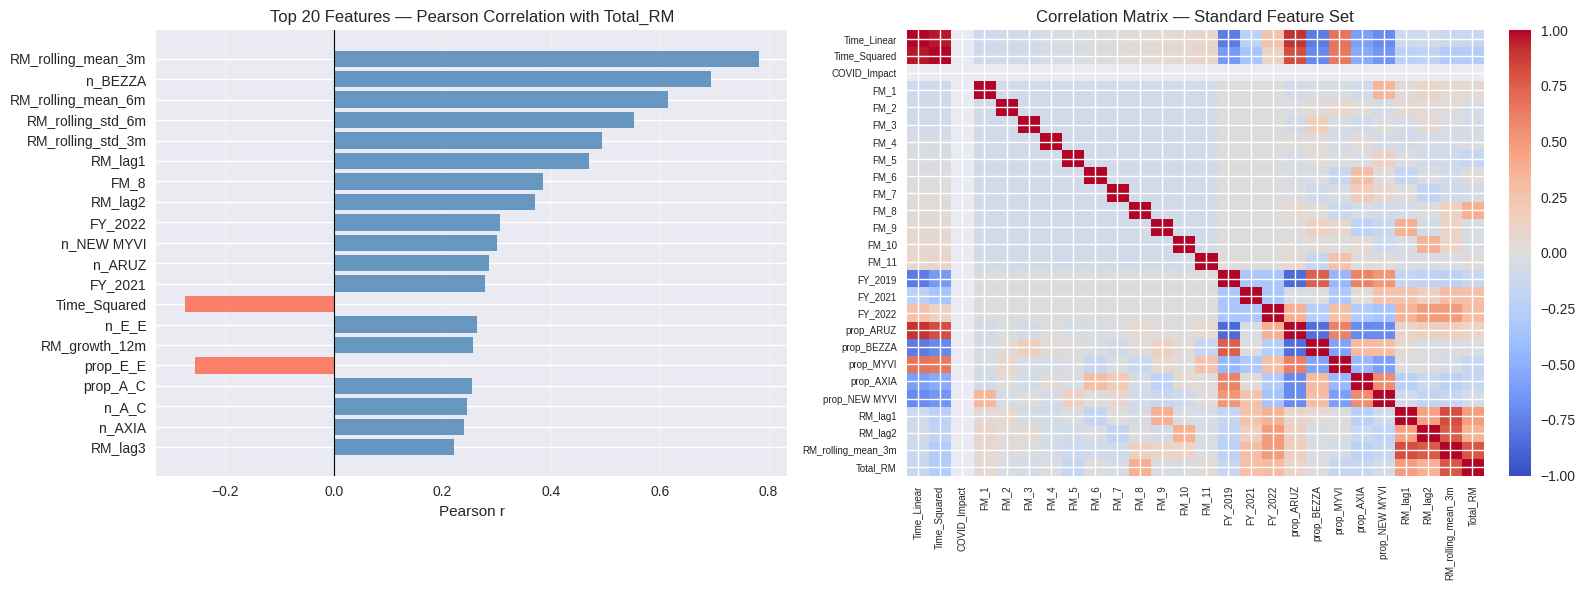

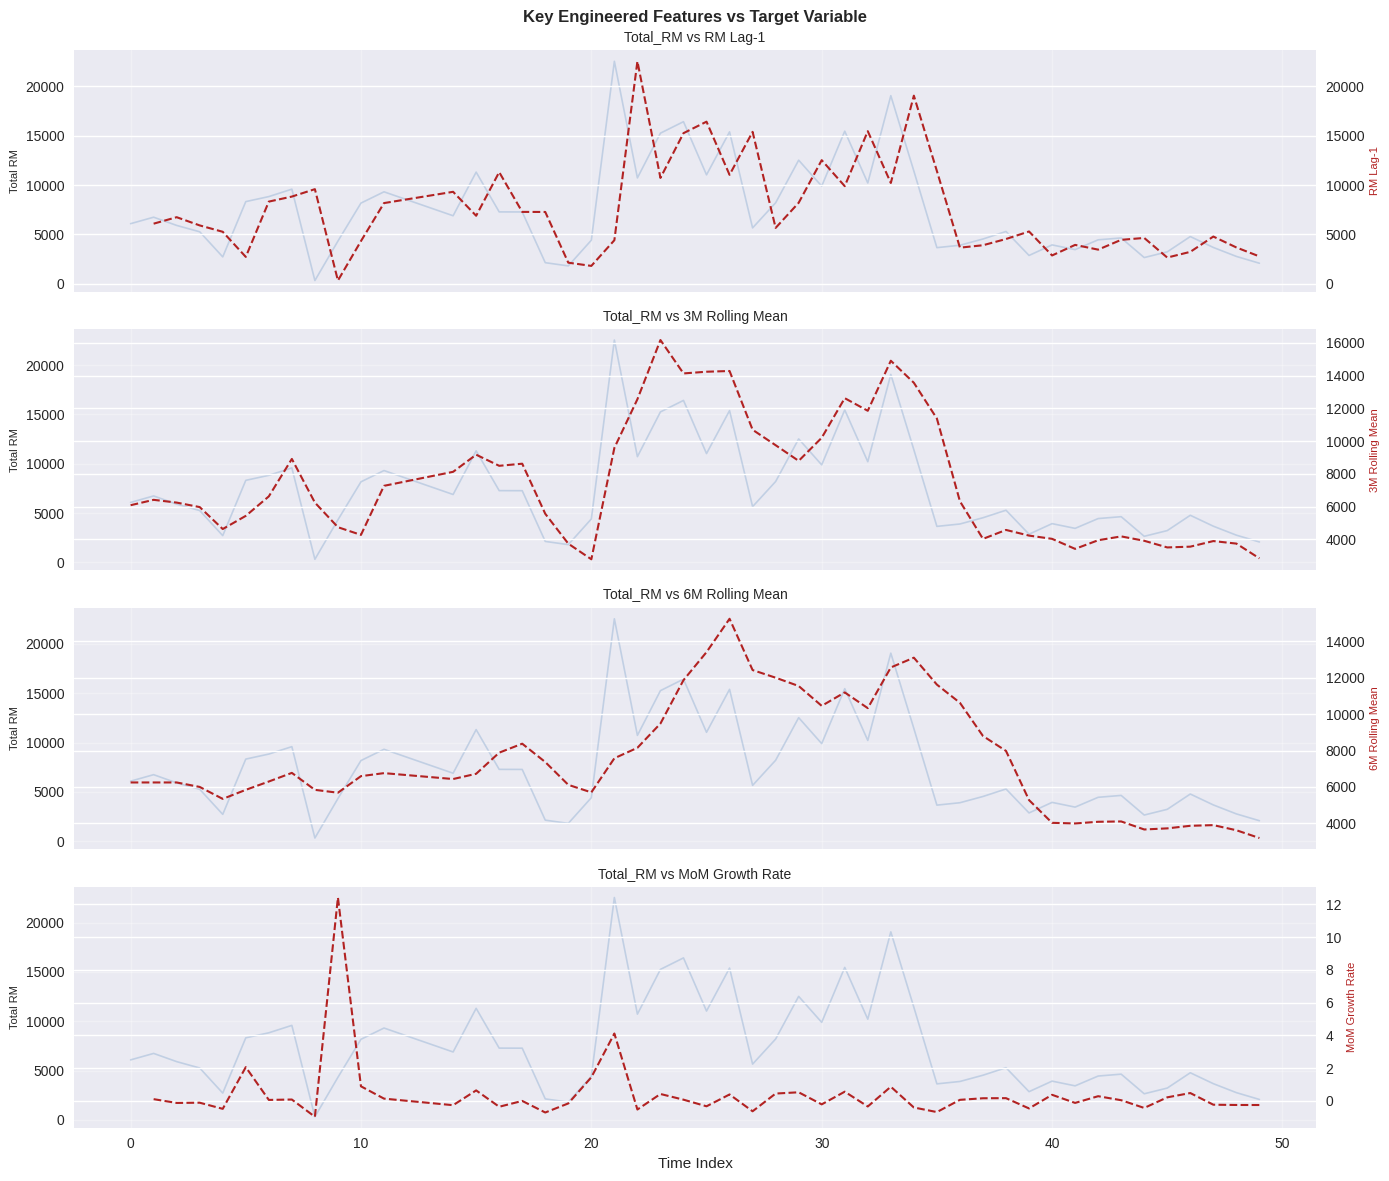


Block 7 complete.
  feature_df        : 48 rows × 63 columns
  all_feature_cols  : 45 engineered features
  modeling_datasets : ['minimal', 'standard', 'full']
    minimal     48 obs
    standard    46 obs
    full        36 obs


In [17]:
# Block 7: Feature Engineering for Multi-Model Approach
# Construct and validate the full feature matrix for all downstream models

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# =============================================================================
# 1. BASE DATASET
# =============================================================================
# ts_complete (from Block 3) is the canonical modelling dataset — FY2020
# excluded, COVID months flagged, sorted chronologically.
# A fresh copy is taken here so that downstream column additions do not
# mutate the shared ts_complete reference used by other blocks.

feature_df = ts_complete.sort_values("Time_Index").reset_index(drop=True).copy()

# Calendar columns are required for business feature merges downstream.
# They should already exist from Block 3, but are re-derived defensively
# in case this block is run in isolation.
if "Calendar_Year" not in feature_df.columns:
    feature_df["Calendar_Year"] = feature_df["Claimed Month"].apply(lambda x: int(str(x)[:4]))
if "Calendar_Month" not in feature_df.columns:
    feature_df["Calendar_Month"] = feature_df["Claimed Month"].apply(lambda x: int(str(x)[4:6]))

print(f"Base dataset: {feature_df.shape}  |  "
      f"{feature_df['Date_Label'].iloc[0]} – {feature_df['Date_Label'].iloc[-1]}")

# =============================================================================
# 2. TEMPORAL FEATURES
# =============================================================================
# Temporal features encode the three primary components of the time series:
# trend, seasonality, and structural level shifts.
#
# Time_Linear  — captures the long-run upward or downward direction of costs.
# Time_Squared — allows for curvature (e.g. cost growth that is accelerating
#                or decelerating). Whether this term is retained depends on
#                whether the linear model shows a curved residual pattern.
#
# Fiscal month dummies (FM_1 … FM_11) encode within-year seasonality without
# imposing a linear or sinusoidal shape on the seasonal pattern. FM_12 is
# dropped as the reference category to avoid perfect multicollinearity in OLS.
#
# Fiscal year dummies (FY_XXXX) capture structural level shifts between years
# (e.g. fleet expansion, policy changes, model launches). The last FY is
# dropped as the reference category.
#
# COVID_Impact is a binary flag for the FY2020 restart months identified in
# Block 3. It is not hardcoded here — it is derived directly from the
# COVID_Affected column that was carried through from Block 3.

feature_df["Time_Linear"] = feature_df["Time_Index"]
feature_df["Time_Squared"] = feature_df["Time_Index"] ** 2

for fm in range(1, 12):
    feature_df[f"FM_{fm}"] = (feature_df["Fiscal_Month"] == fm).astype(int)

fy_list = sorted([fy for fy in feature_df["Fiscal_Year"].unique() if fy != 2020])
for fy in fy_list[:-1]:
    feature_df[f"FY_{int(fy)}"] = (feature_df["Fiscal_Year"] == fy).astype(int)

feature_df["COVID_Impact"] = feature_df["COVID_Affected"].astype(int)

temporal_cols = (
    ["Time_Linear", "Time_Squared", "COVID_Impact"]
    + [f"FM_{fm}" for fm in range(1, 12)]
    + [f"FY_{int(fy)}" for fy in fy_list[:-1]]
)
print(f"\nTemporal features added: {len(temporal_cols)}")

# =============================================================================
# 3. LAG FEATURES
# =============================================================================
# Lag features provide the model with direct access to recent history,
# which is essential for capturing autocorrelation — the tendency of
# warranty costs to persist from one month to the next.
#
# With ~48 observations, deep lags (>3) would consume too many rows during
# NaN trimming and leave too few observations for reliable estimation.
# Cap at 3 lags to preserve at least 45 usable rows after trimming.
#
# Both RM and Claims_Count lags are included: RM lags capture cost momentum,
# Count lags capture volume momentum, which may diverge when average severity
# is shifting (e.g. post-COVID period with accumulated high-severity claims).

MAX_LAG = 3

for lag in range(1, MAX_LAG + 1):
    feature_df[f"RM_lag{lag}"] = feature_df["Total_RM"].shift(lag)
    feature_df[f"Count_lag{lag}"] = feature_df["Claims_Count"].shift(lag)

lag_cols = (
    [f"RM_lag{lag}" for lag in range(1, MAX_LAG + 1)]
    + [f"Count_lag{lag}" for lag in range(1, MAX_LAG + 1)]
)
print(f"Lag features added    : {len(lag_cols)}  (max lag = {MAX_LAG})")

# =============================================================================
# 4. ROLLING FEATURES
# =============================================================================
# Rolling statistics summarise recent trend without requiring the model to
# learn autocorrelation structure from scratch.
#
# 3-month window: captures short-run momentum (recent claim bursts).
# 6-month window: captures medium-run smoothed trend (dampens outlier months).
#
# center=False (the default) uses only past values, which is mandatory here
# to prevent data leakage — a centred window would use future observations
# when constructing features for a given month.
#
# min_periods = window // 2 allows partial windows at the series start so
# that fewer rows are lost to NaN, at the cost of slightly less stable
# estimates in the first few months of the series.

WINDOWS = [3, 6]

for w in WINDOWS:
    feature_df[f"RM_rolling_mean_{w}m"] = (
        feature_df["Total_RM"].rolling(w, min_periods=w // 2).mean()
    )
    feature_df[f"RM_rolling_std_{w}m"] = (
        feature_df["Total_RM"].rolling(w, min_periods=w // 2).std()
    )

rolling_cols = [c for c in feature_df.columns if "rolling" in c]
print(f"Rolling features added: {len(rolling_cols)}")

# =============================================================================
# 5. GROWTH RATE FEATURES
# =============================================================================
# Month-on-month growth captures short-term acceleration (e.g. a sudden
# claim surge in a single month that may signal a field issue).
#
# Year-on-year growth captures structural annual change, removing within-year
# seasonal effects. Only computed if ≥24 observations are available, because
# pct_change(12) on a shorter series would return almost entirely NaN rows.

feature_df["RM_growth_1m"] = feature_df["Total_RM"].pct_change(1)
feature_df["Count_growth_1m"] = feature_df["Claims_Count"].pct_change(1)

if len(feature_df) >= 24:
    feature_df["RM_growth_12m"] = feature_df["Total_RM"].pct_change(12)
    feature_df["Count_growth_12m"] = feature_df["Claims_Count"].pct_change(12)

growth_cols = [c for c in feature_df.columns if "growth" in c]
print(f"Growth features added : {len(growth_cols)}")

# =============================================================================
# 6. BUSINESS FEATURES — MODEL AND PART MIX
# =============================================================================
# Monthly vehicle model and part category proportions capture compositional
# shifts in the claim mix that would not be visible in aggregate cost alone.
#
# Example: if ARUZ (a larger, costlier vehicle) becomes a larger share of
# monthly claims, Total_RM increases even if Claims_Count stays flat.
# Raw counts and proportions are both retained:
#   n_<model>    — absolute volume, useful for tree models
#   prop_<model> — normalised share, more stable across months and
#                  preferred for linear models where scale matters
#
# Column names are sanitised (/ replaced with _) to avoid downstream issues
# with pandas column selection using dot notation or sklearn pipelines.

model_monthly = (
    df_clean.groupby(["Claimed Month", "Model Name"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

part_monthly = (
    df_clean.groupby(["Claimed Month", "Part category"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

business_cols = []

for model in top_models:
    if model in model_monthly.columns:
        tmp = model_monthly[["Claimed Month", model]].rename(
            columns={model: f"n_{model}"}
        )
        feature_df = feature_df.merge(tmp, on="Claimed Month", how="left")
        feature_df[f"n_{model}"] = feature_df[f"n_{model}"].fillna(0)
        feature_df[f"prop_{model}"] = (
            feature_df[f"n_{model}"] / feature_df["Claims_Count"]
        ).fillna(0)
        business_cols += [f"n_{model}", f"prop_{model}"]

for part in top_parts[:3]:
    safe_name = part.replace("/", "_")
    if part in part_monthly.columns:
        tmp = part_monthly[["Claimed Month", part]].rename(
            columns={part: f"n_{safe_name}"}
        )
        feature_df = feature_df.merge(tmp, on="Claimed Month", how="left")
        feature_df[f"n_{safe_name}"] = feature_df[f"n_{safe_name}"].fillna(0)
        feature_df[f"prop_{safe_name}"] = (
            feature_df[f"n_{safe_name}"] / feature_df["Claims_Count"]
        ).fillna(0)
        business_cols += [f"n_{safe_name}", f"prop_{safe_name}"]

print(f"Business features added: {len(business_cols)}")

# =============================================================================
# 7. MISSING VALUE HANDLING
# =============================================================================
# Lag and growth NaNs at the series head are structural (unavoidable) and
# are left in place — each modelling block will trim them explicitly via
# dropna() on the relevant feature subset.
#
# Rolling NaNs are back-filled (bfill) rather than forward-filled to avoid
# propagating a single early value across many rows. Back-fill assigns the
# earliest available rolling value to the preceding NaN rows, which is a
# conservative approach that slightly overstates early smoothed values
# but does not introduce future information.

for col in rolling_cols:
    feature_df[col] = feature_df[col].bfill()

remaining_nans = feature_df.isnull().sum()
remaining_nans = remaining_nans[remaining_nans > 0]

print("\nRemaining NaNs after rolling fill (structural lag/growth rows):")
if remaining_nans.empty:
    print("  None")
else:
    print(remaining_nans.to_string())

# =============================================================================
# 8. OVERFITTING RISK CHECK
# =============================================================================
# With a short time series, the feature-to-observation ratio is the primary
# overfitting risk indicator.
# Convention used here: ratio > 0.20 signals that the full feature set should
# not be used with linear models — use the minimal or standard set instead.
# Tree models (RF, XGBoost) are less sensitive to this ratio because they
# perform implicit feature selection, but a ratio > 0.5 is still concerning.

all_feature_cols = temporal_cols + lag_cols + rolling_cols + growth_cols + business_cols
all_feature_cols = [c for c in all_feature_cols if c in feature_df.columns]

effective_obs = len(feature_df) - max(MAX_LAG, max(WINDOWS))
ratio = len(all_feature_cols) / effective_obs

print(f"\nOverfitting check:")
print(f"  Total features  : {len(all_feature_cols)}")
print(f"  Effective obs   : {effective_obs}")
print(f"  Feature / obs   : {ratio:.3f}  "
      f"({'high — use reduced sets for linear models' if ratio > 0.20 else 'acceptable'})")

# =============================================================================
# 9. CORRELATION SCREEN
# =============================================================================
# Pairs with |r| > 0.85 are flagged as candidates for removal before fitting
# linear models, where multicollinearity inflates standard errors and makes
# coefficient estimates unreliable.
# Tree models (RF, XGBoost) are not materially affected by collinear features
# because splits are evaluated independently, but the pairs are documented
# regardless to support interpretability discussions.

numeric_df = feature_df[all_feature_cols].select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr().abs()

high_corr_pairs = [
    (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
    for i in range(len(corr_matrix.columns))
    for j in range(i + 1, len(corr_matrix.columns))
    if corr_matrix.iloc[i, j] > 0.85
]

print(f"\nHighly correlated pairs (|r| > 0.85): {len(high_corr_pairs)}")
for f1, f2, r in sorted(high_corr_pairs, key=lambda x: -x[2])[:10]:
    print(f"  {f1:<30}  {f2:<30}  r = {r:.3f}")

# =============================================================================
# 10. FEATURE SETS PER MODEL TYPE
# =============================================================================
# Three tiers of feature complexity are defined to match the capacity of
# each model type:
#
#   minimal  — for linear regression (OLS): low-dimensional, interpretable,
#              no lag or rolling features (to avoid NaN row loss on a small N)
#
#   standard — for Random Forest and XGBoost: richer feature set with lags,
#              rolling stats, and proportion features, but still disciplined
#              to avoid the overfitting risk flagged in Section 8
#
#   full     — for tree models only: all available features; the model's
#              internal feature selection (RF importance, XGB gain) handles
#              dimensionality reduction implicitly

feature_sets = {
    "minimal": (
        ["Time_Linear", "COVID_Impact"]
        + [f"FM_{fm}" for fm in range(1, 12)]
    ),
    "standard": (
        ["Time_Linear", "Time_Squared", "COVID_Impact"]
        + [f"FM_{fm}" for fm in range(1, 12)]
        + [f"FY_{int(fy)}" for fy in fy_list[:-1]]
        + [f"prop_{m}" for m in top_models if f"prop_{m}" in feature_df.columns]
        + ["RM_lag1", "RM_lag2", "RM_rolling_mean_3m"]
    ),
    "full": all_feature_cols,
}

print("\nFeature sets defined:")
for name, cols in feature_sets.items():
    available = [c for c in cols if c in feature_df.columns]
    print(f"  {name:<10}  {len(available)} features")

# =============================================================================
# 11. FEATURE CATALOGUE WITH SAMPLE VALUES
# =============================================================================
# A complete listing of every engineered feature: its group, data type,
# descriptive statistics, and 3–5 representative non-null values.
#
# Purpose: documentation artefact for the feature engineering phase.
# Reviewers can confirm that values are numerically plausible and within
# expected ranges without having to run the notebook.
# The 'Set membership' column also shows which feature sets each feature
# appears in, so the three tiers are easy to audit side-by-side.

meta_cols = ["Claimed Month", "Date_Label", "Time_Index", "Total_RM", "Fiscal_Year"]

feature_catalogue = {
    "Temporal":  temporal_cols,
    "Lag":       lag_cols,
    "Rolling":   rolling_cols,
    "Growth":    growth_cols,
    "Business":  business_cols,
}

# Build set membership lookup
set_membership = {}
for col in all_feature_cols:
    membership = []
    for set_name, set_cols in feature_sets.items():
        available_set = [c for c in set_cols if c in feature_df.columns]
        if col in available_set:
            membership.append(set_name[:3].upper())   # MIN / STA / FUL
    set_membership[col] = ", ".join(membership) if membership else "—"

print("\n" + "=" * 110)
print(f"{'FEATURE CATALOGUE':^110}")
print("=" * 110)
print(
    f"  {'Feature':<32}  {'Group':<10}  {'dtype':<8}  "
    f"{'min':>9}  {'mean':>9}  {'max':>9}  "
    f"{'Sets':<16}  {'Sample values (first 5 non-null)'}"
)
print("-" * 110)

for group, cols in feature_catalogue.items():
    for col in cols:
        if col not in feature_df.columns:
            continue
        series = feature_df[col].dropna()
        dtype  = str(feature_df[col].dtype)
        col_min  = round(series.min(), 3)
        col_mean = round(series.mean(), 3)
        col_max  = round(series.max(), 3)
        samples  = [round(v, 3) if isinstance(v, float) else v
                    for v in series.head(5).tolist()]
        sets     = set_membership.get(col, "—")
        print(
            f"  {col:<32}  {group:<10}  {dtype:<8}  "
            f"{col_min:>9}  {col_mean:>9}  {col_max:>9}  "
            f"{sets:<16}  {samples}"
        )

print("=" * 110)
print(f"Total engineered features: {len(all_feature_cols)}")

# =============================================================================
# 12. MODELLING DATASETS
# =============================================================================
# One dataset is materialised per feature set. Rows where any feature in the
# set is NaN are dropped — this trimming is deterministic and documented
# so that each modelling block can state exactly how many observations it uses.

modeling_datasets = {}
print("\nModelling datasets:")

for name, cols in feature_sets.items():
    available = [c for c in cols if c in feature_df.columns]
    ds = feature_df[meta_cols + available].copy()
    ds = ds.dropna(subset=available).reset_index(drop=True)
    modeling_datasets[name] = ds
    print(f"  {name:<10}  {ds.shape[0]} obs × {len(available)} features  "
          f"|  {ds['Date_Label'].iloc[0]} – {ds['Date_Label'].iloc[-1]}")

# =============================================================================
# 13. VISUALISATIONS
# =============================================================================

# --- Figure 1: Feature–target correlations and standard-set heatmap ---
# Left panel: top 20 features by absolute correlation with Total_RM.
#   Blue bars = positive relationship, red = negative.
#   Features with |r| < 0.10 are unlikely to add signal in linear models.
# Right panel: full correlation matrix of the standard feature set.
#   Dark red/blue clusters reveal multicollinearity pairs that need
#   to be addressed before OLS fitting.

target_corr = (
    feature_df[all_feature_cols + ["Total_RM"]]
    .select_dtypes(include=[np.number])
    .corr()["Total_RM"]
    .drop("Total_RM")
    .sort_values(key=abs, ascending=False)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top20 = target_corr.head(20)
bar_colors = ["steelblue" if v >= 0 else "tomato" for v in top20.values]
axes[0].barh(top20.index[::-1], top20.values[::-1],
             color=bar_colors[::-1], alpha=0.8)
axes[0].axvline(0, color="black", linewidth=0.8)
axes[0].set_title("Top 20 Features — Pearson Correlation with Total_RM")
axes[0].set_xlabel("Pearson r")
axes[0].grid(True, alpha=0.3, axis="x")

std_cols = [c for c in feature_sets["standard"] if c in feature_df.columns]
corr_std = feature_df[std_cols + ["Total_RM"]].corr()

im = axes[1].imshow(corr_std.values, aspect="auto",
                    cmap="coolwarm", vmin=-1, vmax=1)
axes[1].set_xticks(range(len(corr_std.columns)))
axes[1].set_yticks(range(len(corr_std.columns)))
axes[1].set_xticklabels(corr_std.columns, rotation=90, fontsize=7)
axes[1].set_yticklabels(corr_std.columns, fontsize=7)
axes[1].set_title("Correlation Matrix — Standard Feature Set")
plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- Figure 2: Key features plotted against Total_RM (dual axis) ---
# Dual-axis overlays make it immediately visible whether a feature tracks
# the target in phase (positive correlation) or inversely.
# A feature with a structural break not present in Total_RM would appear
# as a divergence in the overlay and warrants investigation before use.

features_to_plot = [
    ("RM_lag1",            "RM Lag-1"),
    ("RM_rolling_mean_3m", "3M Rolling Mean"),
    ("RM_rolling_mean_6m", "6M Rolling Mean"),
    ("RM_growth_1m",       "MoM Growth Rate"),
]
features_to_plot = [(c, lbl) for c, lbl in features_to_plot if c in feature_df.columns]

n_plots = len(features_to_plot)
fig, axes = plt.subplots(n_plots, 1, figsize=(14, 3 * n_plots), sharex=True)
if n_plots == 1:
    axes = [axes]

for ax, (col, label) in zip(axes, features_to_plot):
    ax2 = ax.twinx()
    ax.plot(feature_df["Time_Index"], feature_df["Total_RM"],
            color="lightsteelblue", linewidth=1.2, label="Total_RM", alpha=0.7)
    ax2.plot(feature_df["Time_Index"], feature_df[col],
             color="firebrick", linewidth=1.5, linestyle="--", label=label)
    ax.set_ylabel("Total RM", fontsize=8)
    ax2.set_ylabel(label, fontsize=8, color="firebrick")
    ax.set_title(f"Total_RM vs {label}", fontsize=10)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Time Index")
plt.suptitle("Key Engineered Features vs Target Variable",
             fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

# =============================================================================
# 14. HANDOFF SUMMARY
# =============================================================================
print("\nBlock 7 complete.")
print(f"  feature_df        : {feature_df.shape[0]} rows × {feature_df.shape[1]} columns")
print(f"  all_feature_cols  : {len(all_feature_cols)} engineered features")
print(f"  modeling_datasets : {list(modeling_datasets.keys())}")
for name, ds in modeling_datasets.items():
    print(f"    {name:<10}  {ds.shape[0]} obs")

Base dataset: (48, 18)  |  2019-04 – 2024-03

Temporal features (17):
  Trend       : Time_Linear, Time_Squared
  Seasonality : FM_1 … FM_11  (FM_12 = reference)
  Level shift : ['FY_2019', 'FY_2021', 'FY_2022']
  Event       : COVID_Impact

Lag features (6):
  Cost lags   : RM_lag1, RM_lag2, RM_lag3
  Volume lags : Count_lag1, Count_lag2, Count_lag3
  Max lag     : 3  (rows lost from series head: 3)

Rolling features (4):
  3-month window : RM_rolling_mean_3m, RM_rolling_std_3m
  6-month window : RM_rolling_mean_6m, RM_rolling_std_6m
  Window type    : causal (trailing) — no data leakage

Growth rate features (4):
  RM_growth_1m
  Count_growth_1m
  RM_growth_12m
  Count_growth_12m

Business mix features (14):
  n_ARUZ
  prop_ARUZ
  n_BEZZA
  prop_BEZZA
  n_MYVI
  prop_MYVI
  n_AXIA
  prop_AXIA
  n_NEW MYVI
  prop_NEW MYVI
  n_E_E
  prop_E_E
  n_A_C
  prop_A_C

Remaining NaN summary (structural lag / growth rows — handled per model):
Rolling_Mean_6M      5
Rolling_Std_6M       5
RM_lag

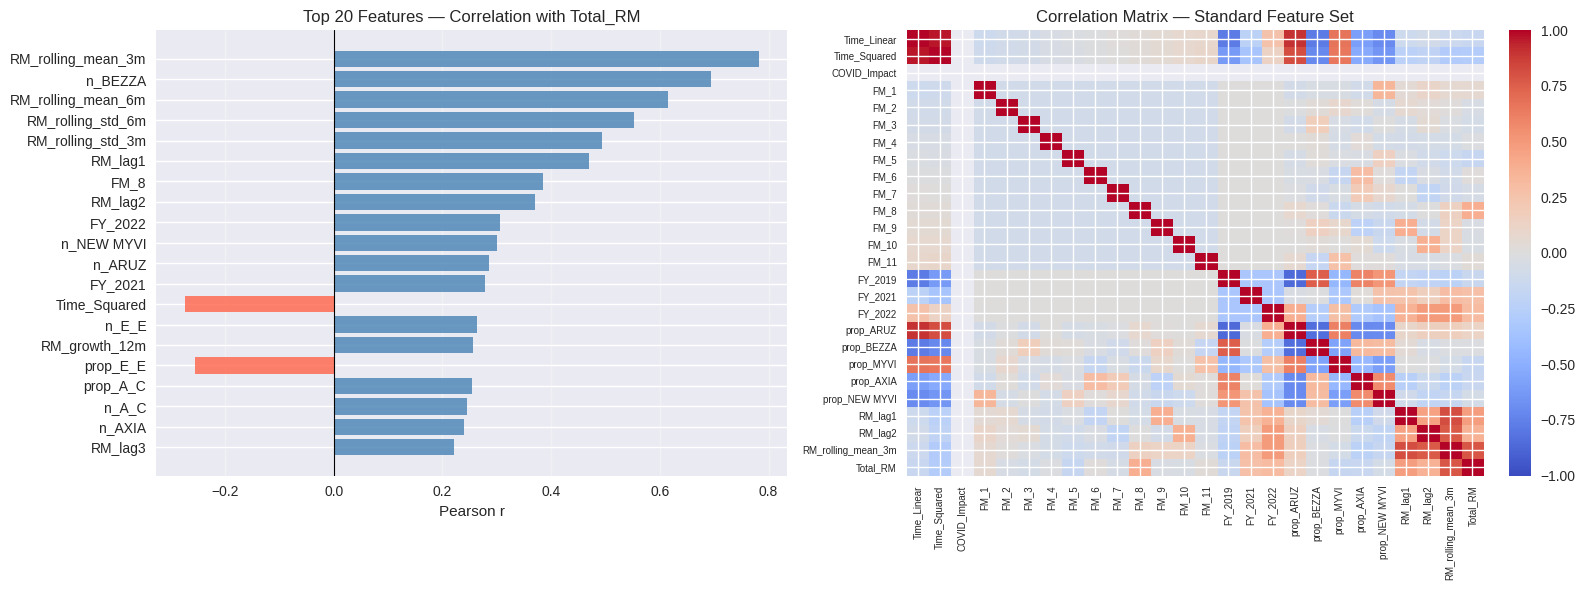

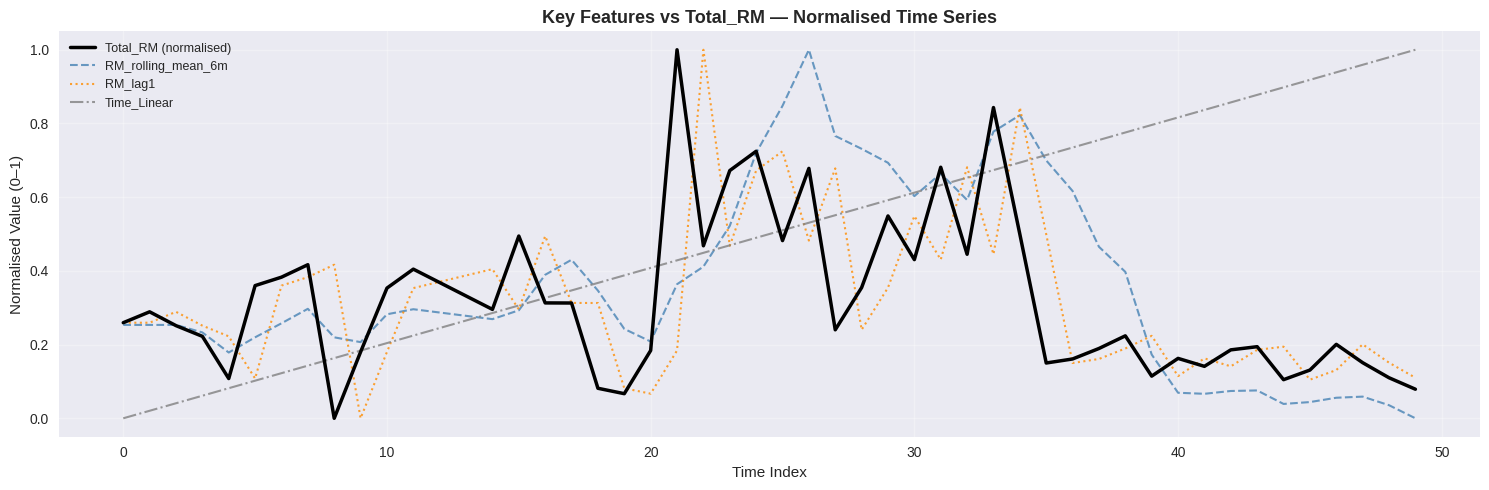


Block 7 complete.

Feature groups created:
  Temporal   (17) : Time_Linear, Time_Squared, FM_1–FM_11, FY dummies, COVID_Impact
  Lag        ( 6) : RM_lag1–3, Count_lag1–3
  Rolling    ( 4) : RM_rolling_mean/std 3m & 6m
  Growth     ( 4) : RM/Count growth 1m & 12m
  Business   (14) : n/prop per top model & part category
  ────────────────────────────────────────
  Total      (45)

Modelling datasets ready:
  modeling_datasets['minimal'] : 48 obs × 13 features
  modeling_datasets['standard'] : 46 obs × 25 features
  modeling_datasets['full'] : 36 obs × 45 features


In [18]:
# Block 7: Feature Engineering for Multi-Model Approach
# Build the complete feature matrix for ARIMA, Linear Regression, Random Forest, and XGBoost

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# =============================================================================
# 1. BASE DATASET
# =============================================================================
# ts_complete is the validated 48-month series (FY20 excluded) produced in
# Block 1.  A copy is made here so that feature engineering operations do not
# propagate back to the upstream analysis dataset.
#
# Calendar_Year and Calendar_Month are derived from Claimed Month if they were
# not already attached — this makes the block self-contained even if it is run
# in isolation during model iteration.

feature_df = ts_complete.sort_values("Time_Index").reset_index(drop=True).copy()

if "Calendar_Year" not in feature_df.columns:
    feature_df["Calendar_Year"] = feature_df["Claimed Month"].apply(lambda x: int(str(x)[:4]))
if "Calendar_Month" not in feature_df.columns:
    feature_df["Calendar_Month"] = feature_df["Claimed Month"].apply(lambda x: int(str(x)[4:6]))

print(f"Base dataset: {feature_df.shape}  |  "
      f"{feature_df['Date_Label'].iloc[0]} – {feature_df['Date_Label'].iloc[-1]}")

# =============================================================================
# 2. TEMPORAL FEATURES
# =============================================================================
# WHAT  : Encode the time axis and the fiscal calendar structure.
# WHY   : Most forecasting models cannot interpret dates directly — a numeric
#         representation of time is required.
#
#   Time_Linear  : sequential integer (0, 1, 2 …) representing the long-run
#                  trend direction.  Preferred over calendar year because it
#                  is zero-based and continuous even across the FY20 gap.
#
#   Time_Squared : quadratic term that allows the trend to accelerate or
#                  decelerate.  Used in OLS-based models only — tree models
#                  derive curvature internally.
#
#   FM_1 … FM_11 : fiscal month one-hot dummies (April = FM_1).  FM_12 is
#                  dropped as the reference category to avoid the dummy
#                  variable trap (perfect multicollinearity) in linear models.
#                  Each dummy isolates the fixed cost premium or discount
#                  associated with that month relative to March.
#
#   FY_xxxx      : fiscal year dummies capture structural level shifts between
#                  years (e.g. fleet size expansion, policy changes, new model
#                  launches).  The last available FY is dropped as reference.
#                  FY2020 is excluded from the dummy set — it has only 2 months
#                  and would create a structurally sparse and misleading dummy.
#
#   COVID_Impact : binary flag.  Set to 1 for the COVID-restart months
#                  identified in Block 3, 0 otherwise.  Allows models to
#                  explicitly learn the abnormal cost level in those months
#                  rather than absorbing it as seasonal or trend noise.

feature_df["Time_Linear"] = feature_df["Time_Index"]
feature_df["Time_Squared"] = feature_df["Time_Index"] ** 2

for fm in range(1, 12):               # FM_12 dropped as reference
    feature_df[f"FM_{fm}"] = (feature_df["Fiscal_Month"] == fm).astype(int)

fy_list = sorted([fy for fy in feature_df["Fiscal_Year"].unique() if fy != 2020])
for fy in fy_list[:-1]:               # last FY dropped as reference
    feature_df[f"FY_{int(fy)}"] = (feature_df["Fiscal_Year"] == fy).astype(int)

feature_df["COVID_Impact"] = feature_df["COVID_Affected"].astype(int)

temporal_cols = (
    ["Time_Linear", "Time_Squared", "COVID_Impact"]
    + [f"FM_{fm}" for fm in range(1, 12)]
    + [f"FY_{int(fy)}" for fy in fy_list[:-1]]
)
print(f"\nTemporal features ({len(temporal_cols)}):")
print(f"  Trend       : Time_Linear, Time_Squared")
print(f"  Seasonality : FM_1 … FM_11  (FM_12 = reference)")
print(f"  Level shift : {[f'FY_{int(fy)}' for fy in fy_list[:-1]]}")
print(f"  Event       : COVID_Impact")

# =============================================================================
# 3. LAG FEATURES
# =============================================================================
# WHAT  : Prior-month values of Total_RM and Claims_Count.
# WHY   : Autocorrelation in warranty claims is expected — a spike in one month
#         (e.g. post-public-holiday service backlog) typically carries forward
#         into the next one or two months.  Lag features give tree models and
#         linear autoregressive models explicit access to this memory.
# HOW   : Maximum lag is capped at 3 to preserve usable rows.
#         With ~48 observations, each additional lag consumes one row from the
#         training set.  Beyond lag-3 the information gain diminishes while
#         the data loss increases.
#
#   RM_lag1, RM_lag2, RM_lag3          : cost one, two, three months prior
#   Count_lag1, Count_lag2, Count_lag3 : claim volume one, two, three months prior

MAX_LAG = 3
for lag in range(1, MAX_LAG + 1):
    feature_df[f"RM_lag{lag}"] = feature_df["Total_RM"].shift(lag)
    feature_df[f"Count_lag{lag}"] = feature_df["Claims_Count"].shift(lag)

lag_cols = (
    [f"RM_lag{lag}" for lag in range(1, MAX_LAG + 1)]
    + [f"Count_lag{lag}" for lag in range(1, MAX_LAG + 1)]
)
print(f"\nLag features ({len(lag_cols)}):")
print(f"  Cost lags   : RM_lag1, RM_lag2, RM_lag3")
print(f"  Volume lags : Count_lag1, Count_lag2, Count_lag3")
print(f"  Max lag     : {MAX_LAG}  (rows lost from series head: {MAX_LAG})")

# =============================================================================
# 4. ROLLING WINDOW FEATURES
# =============================================================================
# WHAT  : Rolling mean and rolling standard deviation over 3-month and
#         6-month windows.
# WHY   : Rolling mean smooths short-term noise and encodes recent momentum —
#         if costs have been trending up over the past 3 months, the model
#         can use that signal without needing explicit lag terms.
#         Rolling std captures recent volatility — high std months may
#         precede correction months, which is a useful signal for tree models.
# HOW   : center=False (causal window) — only past values are used.
#         Using center=True would introduce future information and constitute
#         data leakage in a forecasting context.
#         min_periods = window // 2 avoids NaN at series start when a full
#         window is not yet available, filling with a partial-window estimate.
#
#   RM_rolling_mean_3m / 6m : trailing mean of Total_RM
#   RM_rolling_std_3m  / 6m : trailing standard deviation of Total_RM

WINDOWS = [3, 6]
for w in WINDOWS:
    feature_df[f"RM_rolling_mean_{w}m"] = (
        feature_df["Total_RM"].rolling(w, min_periods=w // 2).mean()
    )
    feature_df[f"RM_rolling_std_{w}m"] = (
        feature_df["Total_RM"].rolling(w, min_periods=w // 2).std()
    )

rolling_cols = [c for c in feature_df.columns if "rolling" in c]
print(f"\nRolling features ({len(rolling_cols)}):")
print(f"  3-month window : RM_rolling_mean_3m, RM_rolling_std_3m")
print(f"  6-month window : RM_rolling_mean_6m, RM_rolling_std_6m")
print(f"  Window type    : causal (trailing) — no data leakage")

# =============================================================================
# 5. GROWTH RATE FEATURES
# =============================================================================
# WHAT  : Month-on-month and year-on-year percentage change in Total_RM and
#         Claims_Count.
# WHY   : Percentage changes normalise scale and capture acceleration or
#         deceleration in cost dynamics.  YoY growth removes the seasonal
#         component, leaving a cleaner trend signal.
#         Only computed when sufficient history exists to avoid NaN-dominated
#         columns (YoY requires ≥ 24 observations).
#
#   RM_growth_1m    : month-on-month % change in Total_RM
#   Count_growth_1m : month-on-month % change in Claims_Count
#   RM_growth_12m   : year-on-year % change in Total_RM     (if ≥ 24 obs)
#   Count_growth_12m: year-on-year % change in Claims_Count (if ≥ 24 obs)

feature_df["RM_growth_1m"] = feature_df["Total_RM"].pct_change(1)
feature_df["Count_growth_1m"] = feature_df["Claims_Count"].pct_change(1)

if len(feature_df) >= 24:
    feature_df["RM_growth_12m"] = feature_df["Total_RM"].pct_change(12)
    feature_df["Count_growth_12m"] = feature_df["Claims_Count"].pct_change(12)

growth_cols = [c for c in feature_df.columns if "growth" in c]
print(f"\nGrowth rate features ({len(growth_cols)}):")
for c in growth_cols:
    print(f"  {c}")

# =============================================================================
# 6. BUSINESS FEATURES — MODEL AND PART MIX
# =============================================================================
# WHAT  : Monthly proportion of claims from each top vehicle model and top
#         part category.
# WHY   : Total_RM is the product of claim volume and average repair cost.
#         If a higher-cost model (e.g. ARUZ vs Axia) makes up a larger share
#         of claims in a given month, Total_RM rises even if total count stays
#         flat.  Mix proportions capture this compositional effect.
# HOW   : Raw counts are computed from df_clean and joined to feature_df on
#         Claimed Month.  Proportion (count / Claims_Count) is used alongside
#         raw count because proportions are more stable across months with
#         different total volumes and are not redundant with Claims_Count.
#
#   n_{model} / prop_{model}   : top 5 vehicle models (count and proportion)
#   n_{part}  / prop_{part}    : top 3 part categories (count and proportion)
#   Top 3 parts only to limit dimensionality — parts 4 and 5 typically have
#   low volumes and add noise rather than signal in a ~45-row dataset.

model_monthly = (
    df_clean.groupby(["Claimed Month", "Model Name"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
part_monthly = (
    df_clean.groupby(["Claimed Month", "Part category"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

business_cols = []

for model in top_models:
    if model in model_monthly.columns:
        col_name = f"n_{model}"
        tmp = model_monthly[["Claimed Month", model]].rename(columns={model: col_name})
        feature_df = feature_df.merge(tmp, on="Claimed Month", how="left")
        feature_df[col_name] = feature_df[col_name].fillna(0)
        feature_df[f"prop_{model}"] = (
            feature_df[col_name] / feature_df["Claims_Count"]
        ).fillna(0)
        business_cols += [col_name, f"prop_{model}"]

for part in top_parts[:3]:             # top 3 only — see rationale above
    safe = part.replace("/", "_")
    col_name = f"n_{safe}"
    if part in part_monthly.columns:
        tmp = part_monthly[["Claimed Month", part]].rename(columns={part: col_name})
        feature_df = feature_df.merge(tmp, on="Claimed Month", how="left")
        feature_df[col_name] = feature_df[col_name].fillna(0)
        feature_df[f"prop_{safe}"] = (
            feature_df[col_name] / feature_df["Claims_Count"]
        ).fillna(0)
        business_cols += [col_name, f"prop_{safe}"]

print(f"\nBusiness mix features ({len(business_cols)}):")
for c in business_cols:
    print(f"  {c}")

# =============================================================================
# 7. MISSING VALUE HANDLING
# =============================================================================
# Lag and growth NaNs at the series head are structural and expected —
# they are NOT filled here.  Each modelling dataset (Section 9) will call
# dropna() on its specific feature subset, so only the rows that a given
# model actually needs are dropped.  This preserves maximum observations
# for models that use fewer lags.
#
# Rolling NaNs at the head are filled backward (bfill) because they arise
# from the window warm-up period, not from genuine missing data.  bfill uses
# the first valid computed value to backfill — this is acceptable because the
# early-period value is a partial-window estimate, not a future value.

for col in rolling_cols:
    feature_df[col] = feature_df[col].bfill()

missing = feature_df.isnull().sum()
missing = missing[missing > 0]
print(f"\nRemaining NaN summary (structural lag / growth rows — handled per model):")
print(missing.to_string() if not missing.empty else "  None")

# =============================================================================
# 8. FEATURE INVENTORY AND OVERFITTING SCREEN
# =============================================================================
# With short time series (~48 obs), the feature-to-observation ratio is a
# critical constraint.  A ratio above 0.20 is a strong indicator of
# overfitting risk in linear models — the model has too many degrees of
# freedom relative to the data it is fit on.
#
# Effective observations = total rows minus the rows consumed by the deepest
# lag or rolling window (whichever is larger).  max(MAX_LAG, max(WINDOWS)) = 6.
#
# This check guides which feature set each model type should use (Section 9).

all_feature_cols = temporal_cols + lag_cols + rolling_cols + growth_cols + business_cols
effective_obs = len(feature_df) - max(MAX_LAG, max(WINDOWS))
ratio = len(all_feature_cols) / effective_obs
ratio_flag = "HIGH — use reduced sets for linear models" if ratio > 0.20 else "acceptable"

print(f"\nFeature inventory:")
print(f"  Temporal features  : {len(temporal_cols)}")
print(f"  Lag features       : {len(lag_cols)}")
print(f"  Rolling features   : {len(rolling_cols)}")
print(f"  Growth features    : {len(growth_cols)}")
print(f"  Business features  : {len(business_cols)}")
print(f"  {'─' * 30}")
print(f"  Total features     : {len(all_feature_cols)}")
print(f"  Effective obs      : {effective_obs}")
print(f"  Feature/obs ratio  : {ratio:.3f}  ({ratio_flag})")

# =============================================================================
# 9. COLLINEARITY SCREEN
# =============================================================================
# Pairs with |r| > 0.85 are flagged for removal before linear models.
# Tree models (RF, XGBoost) are less sensitive to collinearity but the
# screen is documented here for full transparency.
#
# Only the top 10 most correlated pairs are printed to keep output readable.
# The full matrix is available via corr_matrix if deeper inspection is needed.

numeric_features = feature_df[all_feature_cols].select_dtypes(include=[np.number])
corr_matrix = numeric_features.corr().abs()

high_corr_pairs = [
    (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
    for i in range(len(corr_matrix.columns))
    for j in range(i + 1, len(corr_matrix.columns))
    if corr_matrix.iloc[i, j] > 0.85
]

print(f"\nCollinear feature pairs (|r| > 0.85): {len(high_corr_pairs)}")
for f1, f2, r in sorted(high_corr_pairs, key=lambda x: -x[2])[:10]:
    print(f"  {f1:<35}  {f2:<35}  r = {r:.3f}")

# =============================================================================
# 10. FEATURE SETS PER MODEL TYPE
# =============================================================================
# Three tiers of feature complexity are defined to match each model's
# capacity and the available observation count:
#
#   minimal  — Linear Regression / ARIMA exogenous regressors
#              Low-dimensional, interpretable, no lag terms.
#              Avoids collinearity issues that destabilise OLS coefficients.
#              Suitable when feature/obs ratio must remain below 0.10.
#
#   standard — Random Forest / XGBoost (primary configuration)
#              Adds trend curvature, FY dummies, model-mix proportions,
#              and short lags.  Balanced between signal richness and
#              overfitting risk on a ~45-row dataset.
#
#   full     — Random Forest / XGBoost (extended evaluation)
#              All engineered features included.  The tree's internal
#              feature selection (split criterion) handles redundancy.
#              Only evaluated after standard set is validated, as a
#              check on whether additional features improve OOB score.

feature_sets = {
    "minimal": (
        ["Time_Linear", "COVID_Impact"]
        + [f"FM_{fm}" for fm in range(1, 12)]
    ),
    "standard": (
        ["Time_Linear", "Time_Squared", "COVID_Impact"]
        + [f"FM_{fm}" for fm in range(1, 12)]
        + [f"FY_{int(fy)}" for fy in fy_list[:-1]]
        + [f"prop_{m}" for m in top_models if f"prop_{m}" in feature_df.columns]
        + ["RM_lag1", "RM_lag2", "RM_rolling_mean_3m"]
    ),
    "full": [c for c in all_feature_cols if c in feature_df.columns],
}

print("\nFeature sets defined:")
for name, cols in feature_sets.items():
    available = [c for c in cols if c in feature_df.columns]
    print(f"\n  [{name.upper()}]  {len(available)} features:")
    for c in available:
        print(f"    {c}")

# =============================================================================
# 11. MODELLING DATASETS
# =============================================================================
# One DataFrame is built per feature set.  Meta columns (date, index, target,
# FY) are carried alongside features so that each dataset is self-contained
# for the train / validation splits in Block 8.
#
# dropna() is applied to each dataset independently — this means the minimal
# set retains more rows than the full set, which is intentional.

META_COLS = ["Claimed Month", "Date_Label", "Time_Index", "Total_RM", "Fiscal_Year"]
modeling_datasets = {}

print("\nModelling datasets:")
for name, cols in feature_sets.items():
    available = [c for c in cols if c in feature_df.columns]
    ds = feature_df[META_COLS + available].copy().dropna(subset=available).reset_index(drop=True)
    modeling_datasets[name] = ds
    print(f"  {name:<10}  {ds.shape[0]} obs × {len(available)} features  "
          f"|  {ds['Date_Label'].iloc[0]} – {ds['Date_Label'].iloc[-1]}")

# =============================================================================
# 12. VISUALISATIONS
# =============================================================================

# --- Figure 1: Feature–target correlation bar chart and standard set heatmap ---
# Correlation with Total_RM is a quick importance screen before modelling.
# Positive bars (blue) indicate features that rise with cost.
# Negative bars (red) indicate features that inversely correlate with cost.
# The heatmap reveals inter-feature collinearity in the standard set —
# dark red / blue off-diagonal cells are the pairs flagged in Section 9.

target_corr = (
    feature_df[all_feature_cols + ["Total_RM"]]
    .select_dtypes(include=[np.number])
    .corr()["Total_RM"]
    .drop("Total_RM")
    .sort_values(key=abs, ascending=False)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top20 = target_corr.head(20)
bar_colors = ["steelblue" if v >= 0 else "tomato" for v in top20.values]
axes[0].barh(top20.index[::-1], top20.values[::-1],
             color=bar_colors[::-1], alpha=0.8)
axes[0].axvline(0, color="black", linewidth=0.8)
axes[0].set_title("Top 20 Features — Correlation with Total_RM")
axes[0].set_xlabel("Pearson r")
axes[0].grid(True, alpha=0.3, axis="x")

std_cols = [c for c in feature_sets["standard"] if c in feature_df.columns]
corr_std = feature_df[std_cols + ["Total_RM"]].corr()
im = axes[1].imshow(corr_std.values, aspect="auto", cmap="coolwarm", vmin=-1, vmax=1)
axes[1].set_xticks(range(len(corr_std.columns)))
axes[1].set_yticks(range(len(corr_std.columns)))
axes[1].set_xticklabels(corr_std.columns, rotation=90, fontsize=7)
axes[1].set_yticklabels(corr_std.columns, fontsize=7)
axes[1].set_title("Correlation Matrix — Standard Feature Set")
plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- Figure 2: Selected feature time series against Total_RM ---
# Overlaying key features on the target series visualises whether the
# engineered signals track the movements they are intended to capture.
# Normalisation (0–1 min-max) is applied for visual comparability only —
# raw values are used in all models.

fig, ax = plt.subplots(figsize=(15, 5))

target_norm = (feature_df["Total_RM"] - feature_df["Total_RM"].min()) / (
    feature_df["Total_RM"].max() - feature_df["Total_RM"].min()
)
ax.plot(feature_df["Time_Index"], target_norm,
        linewidth=2.5, color="black", label="Total_RM (normalised)", zorder=5)

overlay_features = [
    ("RM_rolling_mean_6m", "steelblue", "--"),
    ("RM_lag1",            "darkorange", ":"),
    ("Time_Linear",        "grey",      "-."),
]
for feat, colour, ls in overlay_features:
    if feat in feature_df.columns:
        series = feature_df[feat].fillna(method="bfill")
        series_norm = (series - series.min()) / (series.max() - series.min())
        ax.plot(feature_df["Time_Index"], series_norm,
                linewidth=1.5, color=colour, linestyle=ls, alpha=0.8, label=feat)

# Mark COVID-affected months
covid_idx = feature_df.loc[feature_df["COVID_Impact"] == 1, "Time_Index"]
for idx in covid_idx:
    ax.axvline(idx, color="firebrick", linewidth=1.2, alpha=0.6, linestyle="--")
if len(covid_idx) > 0:
    ax.axvline(covid_idx.iloc[0], color="firebrick", linewidth=1.2,
               alpha=0.6, linestyle="--", label="COVID month")

ax.set_title("Key Features vs Total_RM — Normalised Time Series", fontsize=13, fontweight="bold")
ax.set_xlabel("Time Index")
ax.set_ylabel("Normalised Value (0–1)")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# 13. HANDOFF SUMMARY
# =============================================================================
print("\nBlock 7 complete.")
print(f"\nFeature groups created:")
print(f"  Temporal   ({len(temporal_cols):>2}) : Time_Linear, Time_Squared, FM_1–FM_11, "
      f"FY dummies, COVID_Impact")
print(f"  Lag        ({len(lag_cols):>2}) : RM_lag1–3, Count_lag1–3")
print(f"  Rolling    ({len(rolling_cols):>2}) : RM_rolling_mean/std 3m & 6m")
print(f"  Growth     ({len(growth_cols):>2}) : RM/Count growth 1m"
      + (" & 12m" if "RM_growth_12m" in feature_df.columns else ""))
print(f"  Business   ({len(business_cols):>2}) : n/prop per top model & part category")
print(f"  {'─' * 40}")
print(f"  Total      ({len(all_feature_cols):>2})")
print(f"\nModelling datasets ready:")
for name, ds in modeling_datasets.items():
    print(f"  modeling_datasets['{name}'] : {ds.shape[0]} obs × "
          f"{ds.shape[1] - len(META_COLS)} features")

In [19]:
# =============================================================================
# BLOCKS 8-11: INITIAL MODEL DEVELOPMENT
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# TECHNICAL VERSION
# ─────────────────────────────────────────────────────────────────────────────
#
# PHASE 3: INITIAL MODEL DEVELOPMENT (Blocks 8-11)
#
# Purpose:
#   Establish baseline performance and tune hyperparameters for each model family
#   in isolation before combining them into a comparative validation framework.
#
# What happens in these blocks:
#   • Each model (Linear Regression, ARIMA, Random Forest, XGBoost) is trained
#     once on the full available historical dataset (FY2019, FY2021-2023)
#   • In-sample metrics (R², RMSE, MAPE) are computed on the training data
#   • Model-specific diagnostics are profiled:
#       - Linear: residual autocorrelation (Durbin-Watson), coefficient stability
#       - ARIMA: AIC-based order selection, stationarity tests
#       - Random Forest: OOB R² vs in-sample R² gap (overfitting assessment)
#       - XGBoost: regularization tuning to minimize overfitting gap
#   • Feature importance is extracted for tree-based models
#
# Why do this before Block 12:
#   In-sample performance is necessary but not sufficient for model selection.
#   These blocks establish the upper bound of what each model can achieve
#   (perfect fit to training data) and identify structural issues (residual
#   autocorrelation, overfitting, feature irrelevance) that would invalidate
#   the model regardless of out-of-sample performance.
#
# Key output:
#   Tuned hyperparameters and feature sets for each model, to be carried forward
#   into the iterative validation framework (Block 12).
#
# Relationship to later blocks:
#   • Block 12 tests if these tuned models generalize (out-of-sample validation)
#   • Block 14 uses the same tuned models for production forecasting (FY24)
#
# Statistical note:
#   High in-sample R² here does NOT mean the model is production-ready. It only
#   means the model can memorize the training data. Block 12 determines if the
#   model has learned generalizable patterns or just noise.

# ─────────────────────────────────────────────────────────────────────────────
# C-LEVEL VERSION
# ─────────────────────────────────────────────────────────────────────────────
#
# PHASE 3: TESTING EACH FORECASTING MODEL (Blocks 8-11)
#
# What we're doing:
#   Building and testing 4 different forecasting models one at a time:
#     • Linear Regression    (assumes steady growth with seasonal patterns)
#     • ARIMA                (conservative, expects stability)
#     • Random Forest        (learns complex patterns from historical data)
#     • XGBoost              (advanced version of Random Forest)
#
# Why test each model separately first:
#   Think of this like auditioning musicians individually before forming a band.
#   We need to know what each model can do on its own — its strengths, weaknesses,
#   and quirks — before we compare them against each other.
#
# What we learn from this phase:
#   • Can the model "fit" the historical data at all? (If it can't explain the
#     past, it definitely can't predict the future)
#   • Which features (time trends, seasonal patterns, business metrics) does each
#     model find most important?
#   • Are there red flags? (e.g., the model memorizes noise instead of learning
#     real patterns)
#
# Why this isn't the final answer:
#   A model that perfectly "explains" the past might just be memorizing it,
#   like a student who memorizes answers but doesn't understand the concepts.
#   We still need to test if the model can predict NEW data it's never seen
#   before (that happens in the next phase).
#
# Business value:
#   These blocks create an audit trail. If someone asks "why didn't you use
#   Random Forest — it has the best R²?" we can point to Block 10 and say
#   "it overfits badly; see the OOB score." This documentation protects the
#   team from second-guessing after deployment.
#
# What comes next:
#   Phase 4 will test these same 4 models on data they've never seen (past
#   fiscal years we held back) to see if they can actually forecast, not just
#   memorize.

# [3.2] Baseline Model

Baseline dataset: (48, 18)
Date range      : 2019-04 – 2024-03
Features        : 13
Observations    : 48

--- Target variable (Total_RM) ---
  Mean       : 7,425.62
  Std        : 4,885.16
  Skewness   : 1.089
  Kurtosis   : 0.796
  Shapiro-Wilk: stat = 0.9094  p = 0.0013  (non-normal)

Top 10 feature correlations with Total_RM:
  FM_8                          r = 0.385
  FM_5                          r = 0.164
  Time_Linear                   r = 0.146
  FM_3                          r = 0.068
  FM_1                          r = 0.062
  FM_7                          r = 0.056
  FM_2                          r = 0.049
  FM_10                         r = 0.043
  FM_9                          r = 0.038
  FM_11                         r = 0.024

High correlation pairs (|r| > 0.80): 0

VIF > 10 (multicollinearity concern): 0 features
  None — multicollinearity is acceptable.

SelectKBest (k = 10):
  Time_Linear                   F = 1.00
  FM_1                          F = 0.18
  FM_2      

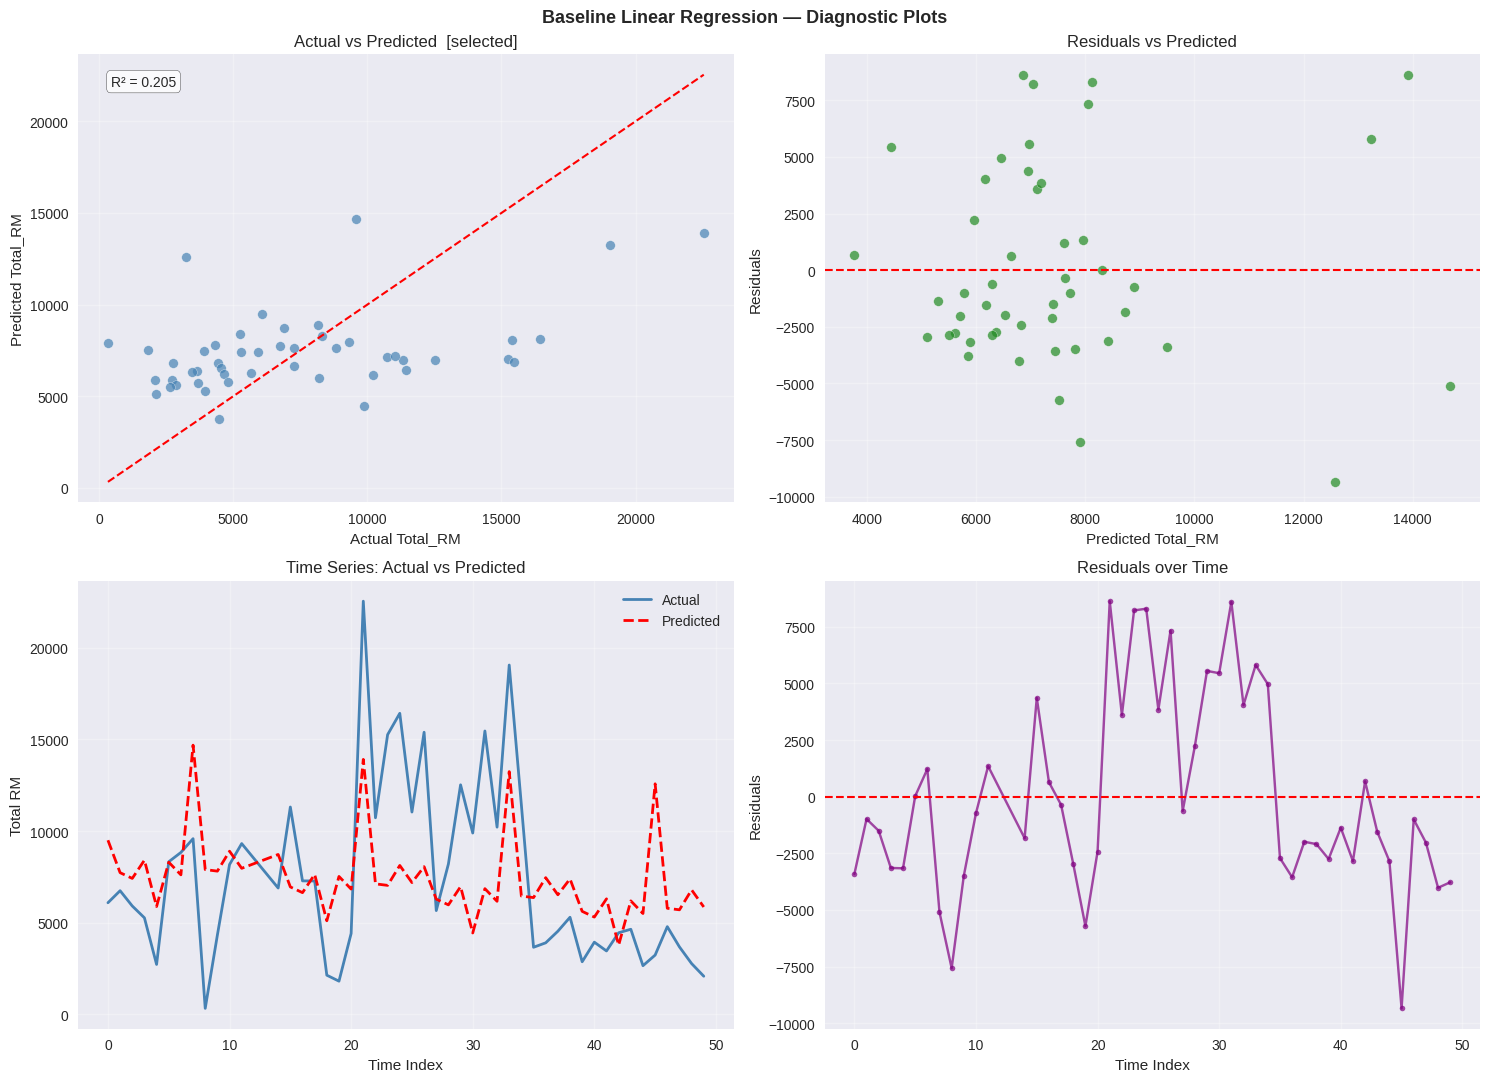


Block 8 complete.
  Best model        : selected
  Features used     : 10
  R²                : 0.2047
  RMSE              : 4310.94
  MAPE              : 109.6%
  CV RMSE           : 7283.56 ± 1265.55

Diagnostic flags for Block 9:
  Autocorrelation   : autocorrelation present  (DW = 0.790)
  Heteroscedasticity: homoscedastic  (p = 0.1272)
  Residual normality: non-normal  (p = 0.0201)


In [20]:
# Block 8: Baseline Model — Linear Regression with Temporal Features
# Implement baseline linear regression satisfying industry requirements

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats

# =============================================================================
# 1. DATASET PREPARATION
# =============================================================================
# The 'minimal' feature set from Block 7 is used as the baseline because it
# has the lowest feature-to-observation ratio, making it the safest starting
# point for OLS regression on a ~48-observation series.
# 'standard' and 'full' sets are reserved for tree-based models in Block 9+.
#
# A separate time_labels series is retained for the time series plot in
# Section 8 — we avoid re-joining on index later, which can silently
# misalign if index resets are inconsistent across blocks.

baseline_data = modeling_datasets["minimal"].copy()

feature_cols = [
    c for c in baseline_data.columns
    if c not in ["Claimed Month", "Date_Label", "Time_Index", "Total_RM", "Fiscal_Year"]
]

X = baseline_data[feature_cols].copy()
y = baseline_data["Total_RM"].copy()
time_index = baseline_data["Time_Index"].copy()
date_labels = baseline_data["Date_Label"].copy()

print(f"Baseline dataset: {baseline_data.shape}")
print(f"Date range      : {date_labels.iloc[0]} – {date_labels.iloc[-1]}")
print(f"Features        : {len(feature_cols)}")
print(f"Observations    : {len(X)}")

# Fill any residual NaNs with 0 — conservative for a baseline; more nuanced
# imputation is applied in the advanced model blocks.
if X.isnull().sum().sum() > 0:
    missing = X.isnull().sum()
    print("\nMissing values filled with 0:")
    print(missing[missing > 0].to_string())
    X = X.fillna(0)

# =============================================================================
# 2. REGRESSION-SPECIFIC EDA
# =============================================================================
# Before fitting, we check two properties of the target distribution:
#   (a) Skewness / kurtosis: severe skew (>1) or heavy tails (kurtosis >3)
#       suggest a log transform may improve OLS residual normality.
#   (b) Shapiro-Wilk normality test: OLS inference is valid even if the target
#       is non-normal (the CLT applies to residuals, not the raw target), but
#       a non-normal target often produces non-normal residuals on small samples.
#       We note the result and check residuals explicitly in Section 7.

print("\n--- Target variable (Total_RM) ---")
print(f"  Mean       : {y.mean():,.2f}")
print(f"  Std        : {y.std():,.2f}")
print(f"  Skewness   : {stats.skew(y):.3f}")
print(f"  Kurtosis   : {stats.kurtosis(y):.3f}")

shapiro_stat, shapiro_p = stats.shapiro(y)
print(f"  Shapiro-Wilk: stat = {shapiro_stat:.4f}  p = {shapiro_p:.4f}  "
      f"({'normal' if shapiro_p > 0.05 else 'non-normal'})")

print("\nTop 10 feature correlations with Total_RM:")
target_corr = X.corrwith(y).abs().sort_values(ascending=False)
for feat, corr in target_corr.head(10).items():
    print(f"  {feat:<28}  r = {corr:.3f}")

# =============================================================================
# 3. MULTICOLLINEARITY CHECK
# =============================================================================
# High pairwise correlation (|r| > 0.80) flags potential multicollinearity.
# VIF > 10 is the conventional threshold for a feature being problematic
# in OLS — it means that feature's variance is inflated tenfold relative to
# an orthogonal predictor, making its coefficient estimate unreliable.
#
# VIF is computed here on the minimal feature set. If the minimal set already
# shows high VIF, the fiscal month dummies may need to be reduced further
# (e.g. grouping adjacent months).

corr_matrix = X.corr().abs()
high_corr = [
    (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
    for i in range(len(corr_matrix.columns))
    for j in range(i + 1, len(corr_matrix.columns))
    if corr_matrix.iloc[i, j] > 0.80
]

print(f"\nHigh correlation pairs (|r| > 0.80): {len(high_corr)}")
for f1, f2, r in sorted(high_corr, key=lambda x: -x[2])[:5]:
    print(f"  {f1:<28}  {f2:<28}  r = {r:.3f}")

# VIF requires at least 2 features and no perfect collinearity.
# Adding a constant column replicates what sm.add_constant() would do
# but makes the VIF calculation explicit.
try:
    X_vif = sm.add_constant(X)
    vif_values = {
        X_vif.columns[i]: variance_inflation_factor(X_vif.values, i)
        for i in range(1, X_vif.shape[1])   # skip the constant column
    }
    high_vif = {k: v for k, v in vif_values.items() if v > 10}
    print(f"\nVIF > 10 (multicollinearity concern): {len(high_vif)} features")
    for feat, vif in sorted(high_vif.items(), key=lambda x: -x[1])[:5]:
        print(f"  {feat:<28}  VIF = {vif:.2f}")
    if not high_vif:
        print("  None — multicollinearity is acceptable.")
except Exception as e:
    print(f"\nVIF computation failed: {e}")

# =============================================================================
# 4. FEATURE SELECTION
# =============================================================================
# SelectKBest with F-regression selects features based on the F-statistic
# of their univariate linear regression against the target. This is a fast,
# model-agnostic screen that removes features carrying no linear signal
# before fitting the full OLS model.
#
# k is capped at min(10, n_features) to avoid selecting more features than
# the dataset can reliably support. The selection result feeds Model 2 below.

K_BEST = min(10, len(feature_cols))
selector = SelectKBest(score_func=f_regression, k=K_BEST)
selector.fit(X, y)
selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]

print(f"\nSelectKBest (k = {K_BEST}):")
for feat in selected_features:
    score = selector.scores_[feature_cols.index(feat)]
    print(f"  {feat:<28}  F = {score:.2f}")

# =============================================================================
# 5. MODEL TRAINING
# =============================================================================
# Three models are trained to establish a performance baseline and to test
# whether feature selection or regularisation materially improves over OLS:
#
#   Model 1 (all features)    : OLS with the full minimal feature set.
#   Model 2 (selected)        : OLS restricted to SelectKBest output.
#                               Expected to generalise better on small N.
#   Model 3 (RidgeCV)         : L2-regularised regression. Ridge does not
#                               perform variable selection but shrinks
#                               coefficients toward zero, which reduces
#                               variance at the cost of slight bias.
#                               Preferred over Lasso here because the
#                               feature set is already small and sparse
#                               solutions are not the goal.

X_selected = X[selected_features]

model_all      = LinearRegression().fit(X, y)
model_selected = LinearRegression().fit(X_selected, y)
model_ridge    = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5).fit(X, y)

print(f"\nModels trained:")
print(f"  Model 1 (all features) : {len(feature_cols)} features")
print(f"  Model 2 (selected)     : {len(selected_features)} features")
print(f"  Model 3 (Ridge, α={model_ridge.alpha_:.1f}) : {len(feature_cols)} features")

# =============================================================================
# 6. IN-SAMPLE PERFORMANCE EVALUATION
# =============================================================================
# In-sample metrics give the upper bound on model performance — they will
# always be optimistic relative to out-of-sample performance.
# Cross-validation in Section 7 provides the more honest estimate.

models_to_eval = {
    "all_features": (model_all,      X),
    "selected":     (model_selected, X_selected),
    "ridge":        (model_ridge,    X),
}

print("\n--- In-sample performance ---")
print(f"  {'Model':<18}  {'R²':>6}  {'RMSE':>10}  {'MAE':>10}  {'MAPE %':>8}")
print("  " + "-" * 60)

in_sample_results = {}
for name, (model, X_eval) in models_to_eval.items():
    y_pred = model.predict(X_eval)
    r2   = model.score(X_eval, y)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae  = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred) * 100
    in_sample_results[name] = dict(r2=r2, rmse=rmse, mae=mae, mape=mape,
                                   y_pred=y_pred, residuals=y - y_pred)
    print(f"  {name:<18}  {r2:>6.4f}  {rmse:>10.2f}  {mae:>10.2f}  {mape:>8.1f}")

# =============================================================================
# 7. CROSS-VALIDATION
# =============================================================================
# TimeSeriesSplit is used instead of standard k-fold because standard k-fold
# randomly shuffles observations, which would allow the model to train on
# future data and test on past data — a form of data leakage.
# TimeSeriesSplit preserves chronological order: each fold trains on all
# data up to a point and tests on the immediately following window.
#
# n_splits = 3 is conservative given the ~48-observation series.
# Larger n_splits (e.g. 5) would leave the early training folds with fewer
# than 10 observations — too small for reliable OLS estimation.

tscv = TimeSeriesSplit(n_splits=3)
cv_results = {}

print("\n--- Time-series cross-validation (3-fold) ---")
print(f"  {'Model':<18}  {'Mean RMSE':>10}  {'Std RMSE':>10}  {'Min':>10}  {'Max':>10}")
print("  " + "-" * 62)

for name, X_eval in [("all_features", X), ("selected", X_selected)]:
    cv_scores = cross_val_score(
        LinearRegression(), X_eval, y,
        cv=tscv, scoring="neg_mean_squared_error"
    )
    cv_rmse = np.sqrt(-cv_scores)
    cv_results[name] = cv_rmse
    print(f"  {name:<18}  {cv_rmse.mean():>10.2f}  {cv_rmse.std():>10.2f}  "
          f"{cv_rmse.min():>10.2f}  {cv_rmse.max():>10.2f}")

# =============================================================================
# 8. RESIDUAL DIAGNOSTICS
# =============================================================================
# Residual diagnostics validate the OLS assumptions:
#
#   Durbin-Watson (1.5–2.5): tests for first-order autocorrelation.
#     DW < 1.5 → positive autocorrelation → standard errors underestimated.
#     DW > 2.5 → negative autocorrelation → less common, still problematic.
#     For warranty cost time series, some autocorrelation is expected —
#     this result informs whether an ARIMA component is needed in Block 9.
#
#   Breusch-Pagan: tests for heteroscedasticity (non-constant residual variance).
#     p < 0.05 → variance changes with fitted values → OLS standard errors
#     are biased; consider WLS or a variance-stabilising transform (log).
#
#   Shapiro-Wilk on residuals: tests normality of residuals.
#     p < 0.05 → non-normal residuals → prediction intervals may be inaccurate
#     on small samples; bootstrap intervals are a more robust alternative.

best_name = min(cv_results, key=lambda k: cv_results[k].mean())
best_model, X_best = models_to_eval[best_name][:2]
y_pred_best = best_model.predict(X_best)
residuals_best = y - y_pred_best

print(f"\n--- Residual diagnostics (best model: {best_name}) ---")

dw = durbin_watson(residuals_best)
dw_status = "acceptable" if 1.5 < dw < 2.5 else "autocorrelation present"
print(f"  Durbin-Watson     : {dw:.4f}  ({dw_status})")

try:
    X_const = sm.add_constant(X_best)
    bp_stat, bp_p, _, _ = het_breuschpagan(residuals_best, X_const)
    bp_status = "homoscedastic" if bp_p > 0.05 else "heteroscedastic"
    print(f"  Breusch-Pagan     : stat = {bp_stat:.3f}  p = {bp_p:.4f}  ({bp_status})")
except Exception as e:
    print(f"  Breusch-Pagan     : failed — {e}")

sw_stat, sw_p = stats.shapiro(residuals_best)
sw_status = "normal" if sw_p > 0.05 else "non-normal"
print(f"  Shapiro-Wilk (res): stat = {sw_stat:.4f}  p = {sw_p:.4f}  ({sw_status})")

print(f"  Residual std      : {residuals_best.std():.2f}")
print(f"  Residual skewness : {stats.skew(residuals_best):.3f}")

# =============================================================================
# 9. FEATURE IMPORTANCE — STANDARDISED COEFFICIENTS
# =============================================================================
# Raw OLS coefficients cannot be compared directly because features are on
# different scales (e.g. Time_Linear ranges 0–47, FM dummies are 0/1).
# Standardising the features (zero mean, unit variance) before fitting
# makes coefficients directly comparable — the coefficient now represents
# the expected change in Total_RM for a one-standard-deviation shift in
# the feature, holding all else constant.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_best)
model_scaled = LinearRegression().fit(X_scaled, y)

feat_names = list(X_best.columns)
importance = sorted(
    zip(feat_names, model_scaled.coef_),
    key=lambda x: abs(x[1]),
    reverse=True,
)

print("\n--- Standardised feature importance (top 10) ---")
print(f"  {'Feature':<28}  {'Std coef':>10}  Direction")
print("  " + "-" * 52)
for feat, coef in importance[:10]:
    direction = "positive" if coef > 0 else "negative"
    print(f"  {feat:<28}  {coef:>10.3f}  {direction}")

# =============================================================================
# 10. VISUALISATIONS
# =============================================================================

r2_best = best_model.score(X_best, y)
rmse_best = np.sqrt(mean_squared_error(y, y_pred_best))

fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# (a) Actual vs predicted scatter.
# Points close to the 45° diagonal indicate accurate predictions.
# Systematic curvature would suggest a non-linear relationship not captured
# by the linear model.
axes[0, 0].scatter(y, y_pred_best, alpha=0.7, color="steelblue", edgecolors="white")
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()],
                color="red", linestyle="--", linewidth=1.5)
axes[0, 0].set_xlabel("Actual Total_RM")
axes[0, 0].set_ylabel("Predicted Total_RM")
axes[0, 0].set_title(f"Actual vs Predicted  [{best_name}]")
axes[0, 0].text(0.05, 0.93, f"R² = {r2_best:.3f}",
                transform=axes[0, 0].transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
axes[0, 0].grid(True, alpha=0.3)

# (b) Residuals vs fitted.
# A random scatter around zero is desirable. A funnel shape indicates
# heteroscedasticity; a curve indicates a missing non-linear term.
axes[0, 1].scatter(y_pred_best, residuals_best,
                   alpha=0.7, color="forestgreen", edgecolors="white")
axes[0, 1].axhline(0, color="red", linestyle="--", linewidth=1.5)
axes[0, 1].set_xlabel("Predicted Total_RM")
axes[0, 1].set_ylabel("Residuals")
axes[0, 1].set_title("Residuals vs Predicted")
axes[0, 1].grid(True, alpha=0.3)

# (c) Time series overlay.
# Periods where predicted and actual diverge indicate structural breaks
# not captured by the feature set — a common finding around COVID restart months.
axes[1, 0].plot(time_index, y,
                color="steelblue", linewidth=2, label="Actual")
axes[1, 0].plot(time_index, y_pred_best,
                color="red", linestyle="--", linewidth=2, label="Predicted")
axes[1, 0].set_xlabel("Time Index")
axes[1, 0].set_ylabel("Total RM")
axes[1, 0].set_title("Time Series: Actual vs Predicted")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# (d) Residuals over time.
# A trend in residuals indicates that the model is systematically under- or
# over-predicting in specific time periods — which would show up as
# autocorrelation in the Durbin-Watson test above.
axes[1, 1].plot(time_index, residuals_best,
                color="purple", marker="o", markersize=4, alpha=0.7)
axes[1, 1].axhline(0, color="red", linestyle="--", linewidth=1.5)
axes[1, 1].set_xlabel("Time Index")
axes[1, 1].set_ylabel("Residuals")
axes[1, 1].set_title("Residuals over Time")
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle("Baseline Linear Regression — Diagnostic Plots",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

# =============================================================================
# 11. HANDOFF SUMMARY
# =============================================================================
# Diagnostic findings are summarised here as explicit pass/fail flags so that
# Block 9 can reference them to justify modelling choices (e.g. if DW flags
# autocorrelation, ARIMA is the natural next step).

print("\nBlock 8 complete.")
print(f"  Best model        : {best_name}")
print(f"  Features used     : {X_best.shape[1]}")
print(f"  R²                : {r2_best:.4f}")
print(f"  RMSE              : {rmse_best:.2f}")
print(f"  MAPE              : {in_sample_results[best_name]['mape']:.1f}%")
print(f"  CV RMSE           : {cv_results[best_name].mean():.2f} ± {cv_results[best_name].std():.2f}")

print("\nDiagnostic flags for Block 9:")
print(f"  Autocorrelation   : {dw_status}  (DW = {dw:.3f})")
try:
    print(f"  Heteroscedasticity: {bp_status}  (p = {bp_p:.4f})")
except NameError:
    print(f"  Heteroscedasticity: test not available")
print(f"  Residual normality: {sw_status}  (p = {sw_p:.4f})")

# [3.3] Statistical Model

ARIMA dataset:
  Length     : 48 observations
  Date range : 2019-04 – 2024-03
  Missing    : 0

Seasonal decomposition:
  Trend range     : 3754.16 → 12632.62
  Seasonal range  : -2656.38 → 8385.14
  Residual std    : 3570.06
  Seasonal strength: 0.560


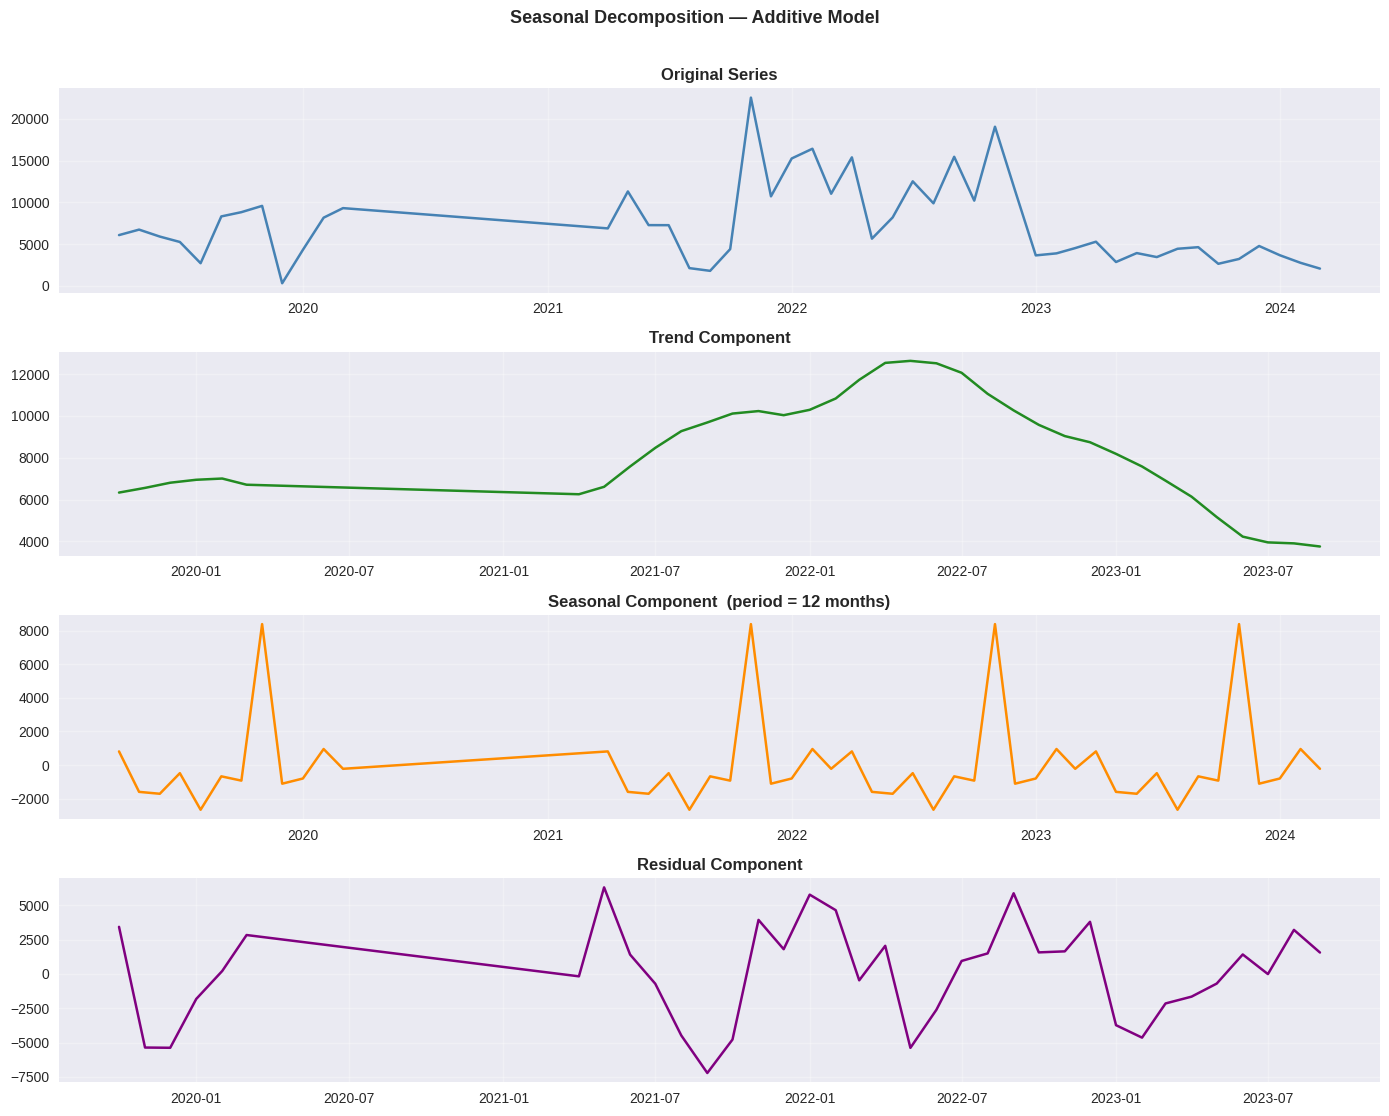


ARIMA grid search:  p 0–3  |  d 0–1  |  q 0–3
  (p,d,q)            AIC  Status
  -----------------------------------
  (0,0,0)            954.68  OK
  (0,0,1)            948.95  OK
  (0,0,2)            947.02  OK
  (0,0,3)            948.29  OK
  (0,1,0)            935.91  OK
  (0,1,1)            926.19  OK
  (0,1,2)            927.73  OK
  (0,1,3)            928.83  OK
  (1,0,0)            944.90  OK
  (1,0,1)            945.40  OK
  (1,0,2)            947.57  OK
  (1,0,3)            949.19  OK
  (1,1,0)            929.60  OK
  (1,1,1)            927.63  OK
  (1,1,2)            929.21  OK
  (1,1,3)            930.81  OK
  (2,0,0)            945.09  OK
  (2,0,1)            947.20  OK
  (2,0,2)            949.51  OK
  (2,0,3)            951.20  OK
  (2,1,0)            930.60  OK
  (2,1,1)            929.32  OK
  (2,1,2)            931.17  OK
  (2,1,3)            929.99  OK
  (3,0,0)            947.14  OK
  (3,0,1)            949.20  OK
  (3,0,2)            950.11  OK
  (3,0,3)         

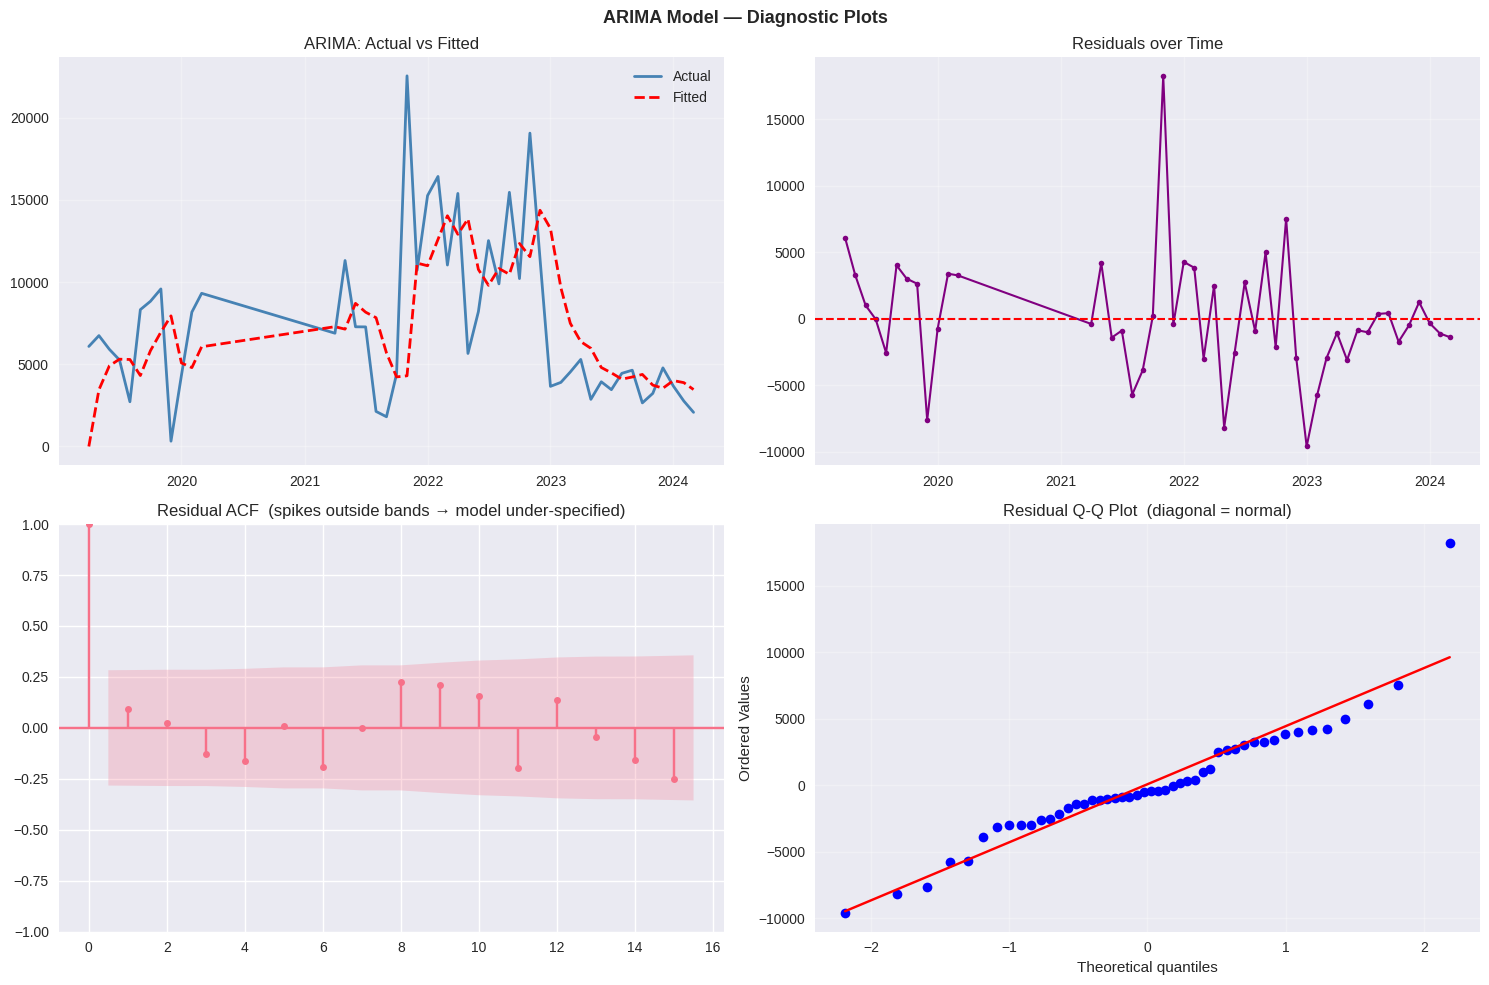


Block 9 complete.
  Model selected   : ARIMA(0, 1, 1)
  AIC              : 926.19
  R² equivalent    : 0.1541
  RMSE             : 4445.99
  MAPE             : 99.8%
  Walk-forward MAE : 3106.26  (41.8%)

  Diagnostic flags:
    Residual autocorrelation : see Ljung-Box results above
    Residual normality       : non-normal (p = 0.0015)


In [21]:
# Block 9: Statistical Model — ARIMA / SARIMA
# Develop ARIMA model for proper time series forecasting methodology

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# 1. TIME SERIES DATA PREPARATION
# =============================================================================
# ARIMA operates directly on the univariate target series rather than on the
# feature matrix used by the regression and tree models. This is because ARIMA
# models the autocorrelation structure of the series itself — it does not
# require external predictors to make forecasts.
#
# The series is extracted from the 'minimal' modelling dataset (Block 7),
# which excludes FY2020 and has the same date alignment as ts_complete.
# A pandas Series with a DatetimeIndex is required by statsmodels ARIMA;
# we construct this explicitly rather than relying on integer indexing.

arima_data = modeling_datasets["minimal"].copy()

ts_series = pd.Series(
    arima_data["Total_RM"].values,
    index=pd.to_datetime(arima_data["Date_Label"], format="%Y-%m"),
    name="Total_RM",
)
n_obs = len(ts_series)

print(f"ARIMA dataset:")
print(f"  Length     : {n_obs} observations")
print(f"  Date range : {ts_series.index[0].strftime('%Y-%m')} – {ts_series.index[-1].strftime('%Y-%m')}")
print(f"  Missing    : {ts_series.isnull().sum()}")

# Linear interpolation for any missing months.
# Interpolation is preferred over forward-fill here because ARIMA assumes
# a smooth, continuous process — a step-change introduced by forward-fill
# would create a spurious abrupt shift in the series.
if ts_series.isnull().sum() > 0:
    ts_series = ts_series.interpolate(method="linear")
    print("  Missing values filled via linear interpolation.")

# =============================================================================
# 2. SEASONAL DECOMPOSITION
# =============================================================================
# Classical additive decomposition separates the series into:
#   trend    — long-run level movement
#   seasonal — repeating within-year pattern (period = 12 months)
#   residual — unexplained variation after removing trend and seasonal
#
# Additive model is used (not multiplicative) because the seasonal amplitude
# appears roughly constant over time rather than growing proportionally with
# the trend level — a visual check of the raw series in Block 1 confirmed this.
#
# Minimum 24 observations are required for a period-12 decomposition: two full
# cycles are needed for a stable seasonal estimate. Fewer observations would
# make the seasonal component indistinguishable from noise.
#
# The decomposition result is used here for inspection only — it does not
# feed directly into the ARIMA parameter selection. That is done via AIC grid
# search in Section 3.

if n_obs >= 24:
    try:
        decomp = seasonal_decompose(ts_series, model="additive", period=12)

        trend_clean   = decomp.trend.dropna()
        seasonal_clean = decomp.seasonal.dropna()
        resid_clean   = decomp.resid.dropna()

        seasonal_strength = seasonal_clean.std() / ts_series.std()

        print(f"\nSeasonal decomposition:")
        print(f"  Trend range     : {trend_clean.min():.2f} → {trend_clean.max():.2f}")
        print(f"  Seasonal range  : {seasonal_clean.min():.2f} → {seasonal_clean.max():.2f}")
        print(f"  Residual std    : {resid_clean.std():.2f}")
        print(f"  Seasonal strength: {seasonal_strength:.3f}")

        fig, axes = plt.subplots(4, 1, figsize=(14, 11))

        axes[0].plot(ts_series.index, ts_series.values, color="steelblue", linewidth=1.8)
        axes[0].set_title("Original Series", fontweight="bold")
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(decomp.trend.index, decomp.trend.values,
                     color="forestgreen", linewidth=1.8)
        axes[1].set_title("Trend Component", fontweight="bold")
        axes[1].grid(True, alpha=0.3)

        axes[2].plot(decomp.seasonal.index, decomp.seasonal.values,
                     color="darkorange", linewidth=1.8)
        axes[2].set_title("Seasonal Component  (period = 12 months)", fontweight="bold")
        axes[2].grid(True, alpha=0.3)

        axes[3].plot(decomp.resid.index, decomp.resid.values,
                     color="purple", linewidth=1.8)
        axes[3].set_title("Residual Component", fontweight="bold")
        axes[3].grid(True, alpha=0.3)

        plt.suptitle("Seasonal Decomposition — Additive Model", fontsize=13,
                     fontweight="bold", y=1.01)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"\nDecomposition failed: {e}")
        decomp = None
else:
    print(f"\nSkipping decomposition — fewer than 24 observations ({n_obs}).")
    decomp = None

# =============================================================================
# 3. ARIMA PARAMETER SELECTION — AIC GRID SEARCH
# =============================================================================
# ARIMA(p, d, q) has three parameters:
#   p — autoregressive order: how many lagged values of the series are used
#   d — degree of differencing: how many times the series is differenced
#       to achieve stationarity (d = 1 for most trend-stationary series)
#   q — moving average order: how many lagged forecast errors are used
#
# Why AIC for model selection:
#   AIC (Akaike Information Criterion) balances goodness of fit against model
#   complexity. It penalises each additional parameter by 2, making it suitable
#   for selecting among competing models on a small sample. BIC applies a
#   stronger penalty (log(n)) and tends to favour simpler models — AIC is
#   preferred here because we want to capture the seasonal autocorrelation
#   structure rather than defaulting to a minimal specification.
#
# Why grid search rather than auto_arima:
#   auto_arima (pmdarima) is not a declared dependency in Block 1.
#   A manual grid search is fully transparent and reproducible, with no
#   black-box stepwise logic that could select differently on different runs.
#
# Parameter bounds: capped at floor(n_obs / 10) to prevent models with more
# parameters than the data can reliably estimate. This is a conservative
# rule-of-thumb for short series (<60 obs).

max_p = min(3, n_obs // 10)
max_d = 1   # d=1 sufficient for most trend-stationary series; see Block 5 ADF results
max_q = min(3, n_obs // 10)

print(f"\nARIMA grid search:  p 0–{max_p}  |  d 0–{max_d}  |  q 0–{max_q}")
print(f"  {'(p,d,q)':<10}  {'AIC':>10}  {'Status'}")
print("  " + "-" * 35)

best_aic    = np.inf
best_params = None
best_model  = None
aic_results = []

for p, d, q in [(p, d, q)
                for p in range(max_p + 1)
                for d in range(max_d + 1)
                for q in range(max_q + 1)]:
    try:
        fitted = ARIMA(ts_series, order=(p, d, q)).fit()
        aic    = fitted.aic
        aic_results.append(((p, d, q), aic))
        print(f"  ({p},{d},{q}){'':<6}  {aic:>10.2f}  OK")

        if aic < best_aic:
            best_aic    = aic
            best_params = (p, d, q)
            best_model  = fitted

    except Exception:
        print(f"  ({p},{d},{q}){'':<6}  {'—':>10}  failed")

if best_model is not None:
    print(f"\nBest ARIMA: ARIMA{best_params}  |  AIC = {best_aic:.2f}")
else:
    print("\nNo ARIMA model converged.")

# =============================================================================
# 4. SARIMA EXPLORATION
# =============================================================================
# SARIMA extends ARIMA with a seasonal component SARIMA(p,d,q)(P,D,Q,s):
#   P — seasonal AR order
#   D — seasonal differencing
#   Q — seasonal MA order
#   s — seasonal period (12 for monthly data with annual seasonality)
#
# Why a fixed candidate list rather than a seasonal grid search:
#   A full seasonal grid search on ~48 observations is computationally
#   expensive and risks selecting an over-parameterised model. The four
#   candidates below cover the most common configurations encountered in
#   monthly economic/operational cost series:
#     (1,0,1)(1,0,1,12) — balanced ARMA with seasonal ARMA
#     (1,0,0)(1,0,0,12) — pure AR, no MA terms
#     (0,0,1)(0,0,1,12) — pure MA, no AR terms
#     (1,0,1)(0,0,0,12) — ARIMA without seasonal terms (sanity check)
#   The best ARIMA order from Section 3 is also tested with a simple
#   seasonal extension.
#
# Minimum 36 observations: a seasonal ARIMA with s=12 consumes at least
# one full seasonal lag (12 observations) for estimation. With fewer than
# 36 observations the seasonal parameter estimates are unreliable.

best_sarima_aic    = np.inf
best_sarima_params = None
best_sarima_model  = None

if n_obs >= 36:
    candidates = [
        ((1, 0, 1), (1, 0, 1, 12)),
        ((1, 0, 0), (1, 0, 0, 12)),
        ((0, 0, 1), (0, 0, 1, 12)),
        ((1, 0, 1), (0, 0, 0, 12)),
    ]
    if best_params:
        candidates.append((best_params, (1, 0, 1, 12)))

    print(f"\nSARIMA candidate testing:")
    print(f"  {'(p,d,q)(P,D,Q,s)':<22}  {'AIC':>10}  {'Status'}")
    print("  " + "-" * 40)

    for (p, d, q), (P, D, Q, s) in candidates:
        try:
            fitted_s = SARIMAX(
                ts_series,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
            ).fit(disp=False)

            aic = fitted_s.aic
            print(f"  ({p},{d},{q})({P},{D},{Q},{s}){'':<4}  {aic:>10.2f}  OK")

            if aic < best_sarima_aic:
                best_sarima_aic    = aic
                best_sarima_params = ((p, d, q), (P, D, Q, s))
                best_sarima_model  = fitted_s

        except Exception:
            print(f"  ({p},{d},{q})({P},{D},{Q},{s}){'':<4}  {'—':>10}  failed")

    if best_sarima_model is not None:
        print(f"\nBest SARIMA: SARIMA{best_sarima_params[0]}"
              f"{best_sarima_params[1]}  |  AIC = {best_sarima_aic:.2f}")
    else:
        print("\nNo SARIMA model converged.")
else:
    print(f"\nSkipping SARIMA — fewer than 36 observations ({n_obs}).")

# =============================================================================
# 5. MODEL SELECTION
# =============================================================================
# AIC comparison between the best ARIMA and best SARIMA.
# Lower AIC is preferred. If the SARIMA AIC is lower by more than 2 units,
# the seasonal component is contributing meaningfully and SARIMA is selected.
# A difference of less than 2 is not considered statistically meaningful —
# in that case the simpler ARIMA is preferred (parsimony principle).

candidates_final = []
if best_model       is not None: candidates_final.append(("ARIMA",  best_model,       best_aic,       best_params))
if best_sarima_model is not None: candidates_final.append(("SARIMA", best_sarima_model, best_sarima_aic, best_sarima_params))

print("\n--- Model comparison ---")
print(f"  {'Model':<8}  {'AIC':>10}  Parameters")
print("  " + "-" * 45)
for mtype, _, aic, params in sorted(candidates_final, key=lambda x: x[2]):
    print(f"  {mtype:<8}  {aic:>10.2f}  {params}")

if candidates_final:
    best_overall_type, best_overall_model, best_overall_aic, best_overall_params = \
        min(candidates_final, key=lambda x: x[2])
    print(f"\nSelected: {best_overall_type}  AIC = {best_overall_aic:.2f}")
else:
    best_overall_type = best_overall_model = best_overall_aic = best_overall_params = None
    print("\nNo model available.")

# =============================================================================
# 6. RESIDUAL DIAGNOSTICS
# =============================================================================
# ARIMA residuals should resemble white noise: zero mean, constant variance,
# no autocorrelation, and approximately normal distribution.
# Each diagnostic targets a different assumption violation:
#
#   Ljung-Box test (H0: no autocorrelation at lag k):
#     p > 0.05 → residuals are uncorrelated at that lag — model has
#     adequately captured the autocorrelation structure of the series.
#     p < 0.05 → systematic autocorrelation remains — the model order
#     may need to be increased or a seasonal component added.
#
#   Shapiro-Wilk (H0: residuals are normally distributed):
#     Non-normal residuals on a small sample affect the reliability of
#     prediction intervals but do not invalidate point forecasts.
#     If non-normal, bootstrap prediction intervals are preferred over
#     the parametric intervals that statsmodels produces by default.

if best_overall_model is not None:
    residuals = best_overall_model.resid

    print(f"\n--- Residual diagnostics ({best_overall_type}) ---")
    print(f"  Mean      : {residuals.mean():.4f}")
    print(f"  Std       : {residuals.std():.2f}")
    print(f"  Skewness  : {stats.skew(residuals):.3f}")
    print(f"  Kurtosis  : {stats.kurtosis(residuals):.3f}")

    # Ljung-Box test at lags 1, 5, 10
    try:
        max_lag_lb = min(10, n_obs // 4)
        lb = acorr_ljungbox(residuals, lags=max_lag_lb, return_df=True)
        print(f"\n  Ljung-Box autocorrelation test:")
        for lag in [1, 5, 10]:
            if lag <= len(lb):
                p = lb["lb_pvalue"].iloc[lag - 1]
                status = "no autocorrelation" if p > 0.05 else "autocorrelation present"
                print(f"    Lag {lag:>2}: p = {p:.4f}  ({status})")
    except Exception as e:
        print(f"  Ljung-Box failed: {e}")

    # Normality of residuals
    sw_stat, sw_p = stats.shapiro(residuals)
    print(f"\n  Shapiro-Wilk: stat = {sw_stat:.4f}  p = {sw_p:.4f}  "
          f"({'normal' if sw_p > 0.05 else 'non-normal — consider bootstrap intervals'})")

    # Coefficient table — confirms which AR/MA terms are significant
    print(f"\nModel coefficients:")
    print(best_overall_model.summary().tables[1])

# =============================================================================
# 7. IN-SAMPLE PERFORMANCE
# =============================================================================
# In-sample fitted values from ARIMA are not independent predictions — the
# model has seen the full series during estimation. These metrics therefore
# represent an optimistic lower bound on forecast error.
# Walk-forward validation in Section 8 provides a more realistic assessment.
#
# R² equivalent is computed manually because statsmodels ARIMA does not
# expose a .score() method. The formula is the standard OLS definition:
# R² = 1 - SS_residual / SS_total.

if best_overall_model is not None:
    fitted_values = best_overall_model.fittedvalues

    ss_res = ((ts_series - fitted_values) ** 2).sum()
    ss_tot = ((ts_series - ts_series.mean()) ** 2).sum()
    r2_equiv = 1 - ss_res / ss_tot

    rmse = np.sqrt(mean_squared_error(ts_series, fitted_values))
    mae  = mean_absolute_error(ts_series, fitted_values)
    mape = mean_absolute_percentage_error(ts_series, fitted_values) * 100

    print(f"\n--- In-sample performance ({best_overall_type}) ---")
    print(f"  R² equivalent : {r2_equiv:.4f}")
    print(f"  RMSE          : {rmse:.2f}")
    print(f"  MAE           : {mae:.2f}")
    print(f"  MAPE          : {mape:.1f}%")
    print(f"  AIC           : {best_overall_aic:.2f}")

    # Comparison against Block 8 baseline.
    # Values are retrieved from the in_sample_results dict created in Block 8
    # rather than hardcoded, so the comparison remains valid if Block 8 is
    # re-run with different data or features.
    baseline_metrics = in_sample_results.get("selected") or in_sample_results.get("all_features")
    if baseline_metrics:
        print(f"\n  vs Block 8 baseline ({best_name}):")
        print(f"    R² change   : {r2_equiv - baseline_metrics['r2']:+.4f}")
        print(f"    RMSE change : {rmse - baseline_metrics['rmse']:+.2f}")
        print(f"    MAPE change : {mape - baseline_metrics['mape']:+.1f}%")

# =============================================================================
# 8. WALK-FORWARD VALIDATION
# =============================================================================
# Walk-forward (expanding window) validation simulates real-world forecasting:
# the model is retrained on all data up to time t and makes a one-step-ahead
# prediction for time t+1, then the window expands by one month and repeats.
#
# This is the correct validation approach for time series because it preserves
# the temporal ordering of observations — the model never trains on data that
# was not available at the time of the prediction.
#
# min_train_size: the minimum number of observations required before the first
# validation prediction. Set to max(20, n_obs - 15) to ensure that:
#   (a) the training window is large enough for stable ARIMA estimation, and
#   (b) at least some validation steps are performed even on short series.
#
# disp=False suppresses the optimisation convergence output from statsmodels,
# which would otherwise produce verbose log output for every refitting step.

if best_overall_model is not None and n_obs >= 20:
    min_train   = max(20, n_obs - 15)
    n_val_steps = min(10, n_obs - min_train)

    print(f"\n--- Walk-forward validation ---")
    print(f"  Training window : {min_train} (expanding)")
    print(f"  Validation steps: {n_val_steps}")

    val_errors = []

    for i in range(min_train, min_train + n_val_steps):
        try:
            train  = ts_series.iloc[:i]
            actual = ts_series.iloc[i]

            if best_overall_type == "ARIMA":
                tmp_fitted = ARIMA(train, order=best_overall_params).fit()
            else:
                tmp_fitted = SARIMAX(
                    train,
                    order=best_overall_params[0],
                    seasonal_order=best_overall_params[1],
                ).fit(disp=False)

            forecast   = tmp_fitted.forecast(steps=1)
            prediction = forecast.iloc[0] if hasattr(forecast, "iloc") else forecast[0]
            val_errors.append(abs(actual - prediction))

        except Exception:
            continue

    if val_errors:
        val_mae  = np.mean(val_errors)
        val_std  = np.std(val_errors)
        val_mape = val_mae / ts_series.mean() * 100

        print(f"\n  Successful steps : {len(val_errors)} / {n_val_steps}")
        print(f"  Walk-forward MAE : {val_mae:.2f}  (±{val_std:.2f})")
        print(f"  Walk-forward MAPE: {val_mape:.1f}%")
        print(f"  Error range      : {min(val_errors):.2f} – {max(val_errors):.2f}")
    else:
        print("  All validation steps failed — model may be unstable on short windows.")
else:
    print("\nSkipping walk-forward validation — insufficient observations or no model.")

# =============================================================================
# 9. VISUALISATIONS
# =============================================================================

if best_overall_model is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # (a) Actual vs fitted — time series overlay.
    # Periods where the fitted line diverges from the actual indicate structural
    # breaks not captured by the model order (e.g. COVID restart months).
    axes[0, 0].plot(ts_series.index, ts_series.values,
                    color="steelblue", linewidth=2, label="Actual")
    axes[0, 0].plot(ts_series.index, fitted_values,
                    color="red", linestyle="--", linewidth=2, label="Fitted")
    axes[0, 0].set_title(f"{best_overall_type}: Actual vs Fitted")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # (b) Residuals over time.
    # A systematic trend or clustering in residuals suggests the model has
    # not fully captured the autocorrelation structure (see Ljung-Box results).
    axes[0, 1].plot(ts_series.index, residuals,
                    color="purple", marker="o", markersize=4, linewidth=1.5)
    axes[0, 1].axhline(0, color="red", linestyle="--", linewidth=1.5)
    axes[0, 1].set_title("Residuals over Time")
    axes[0, 1].grid(True, alpha=0.3)

    # (c) Residual ACF.
    # Spikes outside the confidence bands at any lag indicate residual
    # autocorrelation — the order at which the spike occurs suggests whether
    # p (AR spike) or q (MA spike) needs to be increased.
    plot_acf(residuals, lags=min(15, n_obs // 3), ax=axes[1, 0], alpha=0.05)
    axes[1, 0].set_title("Residual ACF  (spikes outside bands → model under-specified)")

    # (d) Q-Q plot.
    # Points on the diagonal confirm normality. Curved tails indicate heavy
    # tail behaviour, which would make parametric prediction intervals too
    # narrow (under-coverage).
    stats.probplot(residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title("Residual Q-Q Plot  (diagonal = normal)")
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle(f"{best_overall_type} Model — Diagnostic Plots",
                 fontsize=13, fontweight="bold")
    plt.tight_layout()
    plt.show()

# =============================================================================
# 10. HANDOFF SUMMARY
# =============================================================================
# Key outputs carried forward to Block 10 (Random Forest):
#   best_overall_model  — fitted ARIMA/SARIMA object (for forecast comparison)
#   r2_equiv, rmse, mape — performance benchmark for tree model comparison
#   Diagnostic flags     — autocorrelation and normality results inform
#                          whether the tree model needs to address residual
#                          structure left by ARIMA

print("\nBlock 9 complete.")
if best_overall_model is not None:
    print(f"  Model selected   : {best_overall_type}{best_overall_params}")
    print(f"  AIC              : {best_overall_aic:.2f}")
    print(f"  R² equivalent    : {r2_equiv:.4f}")
    print(f"  RMSE             : {rmse:.2f}")
    print(f"  MAPE             : {mape:.1f}%")
    if val_errors:
        print(f"  Walk-forward MAE : {val_mae:.2f}  ({val_mape:.1f}%)")
    print(f"\n  Diagnostic flags:")
    print(f"    Residual autocorrelation : see Ljung-Box results above")
    print(f"    Residual normality       : {'normal' if sw_p > 0.05 else 'non-normal'} (p = {sw_p:.4f})")
else:
    print("  No ARIMA/SARIMA model converged — check series length and stationarity.")

# [3.4] Random Forest

Random Forest dataset: (46, 30)
Date range           : 2019-06 – 2024-03
Features             : 25
Observations         : 46

Feature groups:
  Temporal : 17
  Lag      : 2
  Rolling  : 1
  Business : 6
  Other    : 0

Time-series CV splits (expanding window):
  Fold 1: train  27 obs  (2019-06 – 2022-08)  |  test   6 obs  (2022-09 – 2023-02)
  Fold 2: train  33 obs  (2019-06 – 2023-02)  |  test   6 obs  (2023-03 – 2023-08)
  Fold 3: train  39 obs  (2019-06 – 2023-08)  |  test   6 obs  (2023-09 – 2024-02)

Baseline Random Forest (in-sample):
  Training time : 0.18s
  R²            : 0.8030
  OOB score     : 0.4553
  RMSE          : 2189.64
  MAPE          : 50.8%

Hyperparameter grid search (20 combinations):
    #   mean R²   std R²  Key params
  ------------------------------------------------------------
    1  -18.9413  23.3383  n=50  d=None  ms=2  ml=1
    2  -10.9318  13.3118  n=100  d=None  ms=2  ml=1
    3  -10.8064  12.5349  n=200  d=None  ms=2  ml=1
    4  -11.6239  13.8666  n

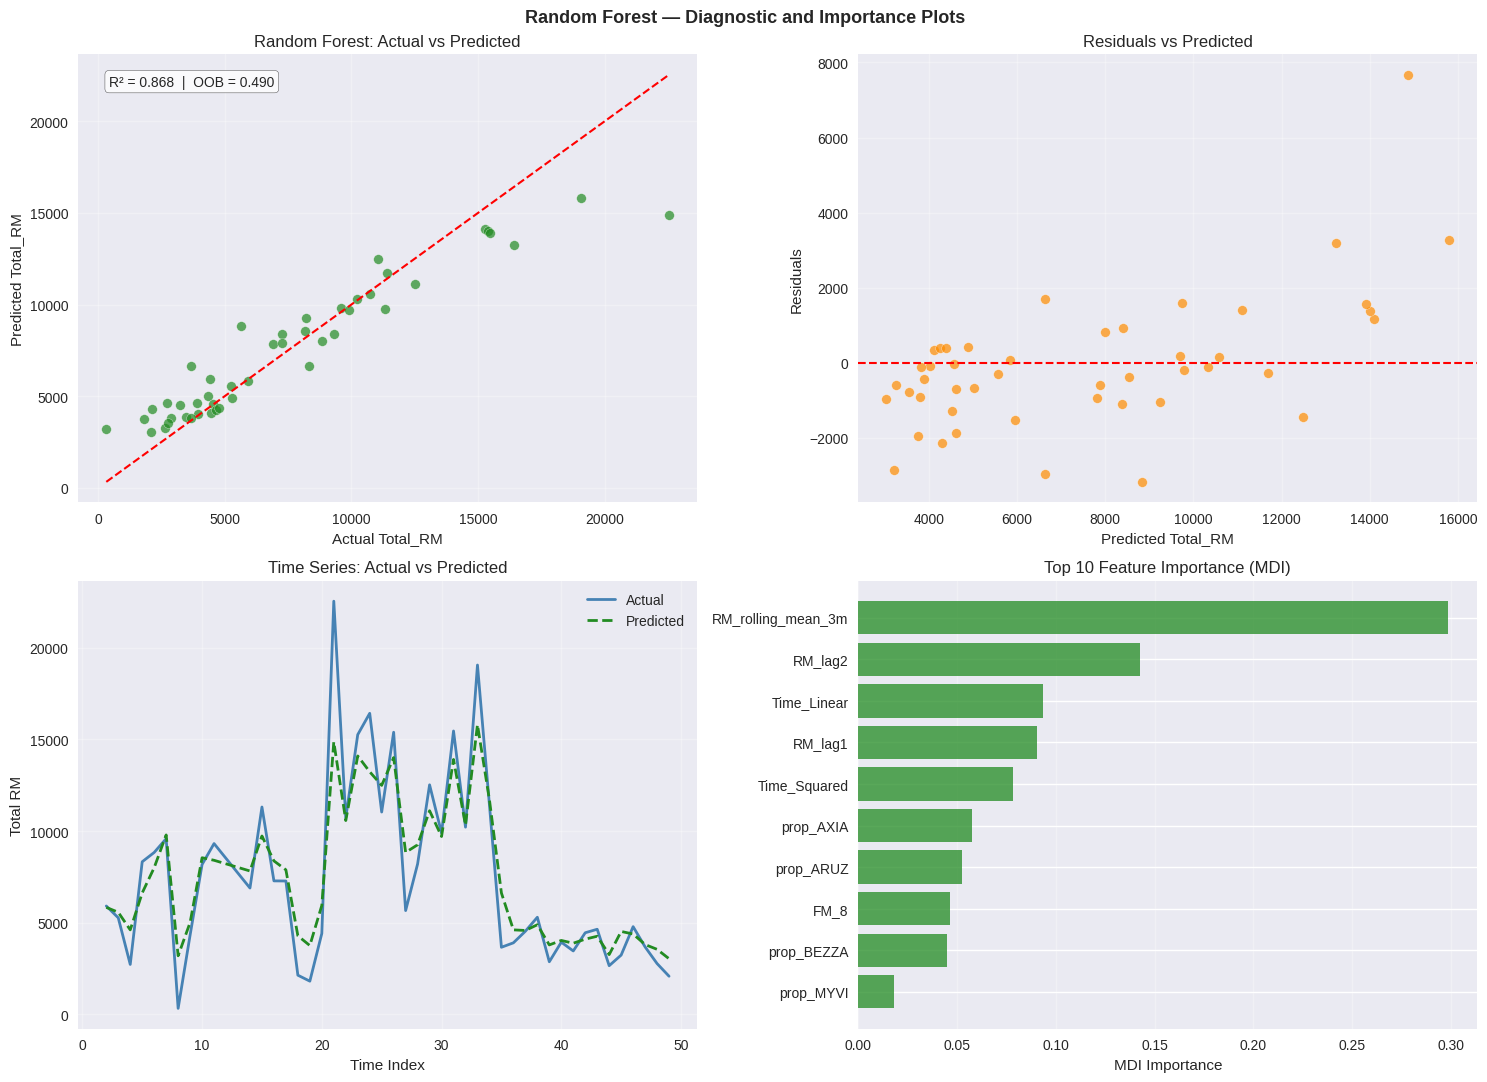


Block 10 complete.
  Final model     : RandomForestRegressor  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
  R² (in-sample)  : 0.8679
  OOB R²          : 0.4897
  RMSE            : 1793.11
  MAPE            : 40.0%
  Best CV R²      : -9.6212
  Top feature     : RM_rolling_mean_3m  (0.299)

Key outputs for Block 11:
  final_rf       — fitted model object
  importance_df  — MDI feature rankings
  group_summary  — importance by feature group


In [22]:
# Block 10: Advanced Regression — Random Forest
# Implement Random Forest Regression with hyperparameter tuning and time series validation

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import time

# =============================================================================
# 1. DATASET PREPARATION
# =============================================================================
# The 'standard' feature set from Block 7 is used for Random Forest.
# It includes lag, rolling, and proportion features that were excluded from
# the linear baseline (Block 8) due to the feature-to-observation ratio
# constraint — tree models are not affected by that constraint because they
# perform implicit feature selection at each split.
#
# 'full' is not used as the default because it includes every feature from
# all five groups, and on a ~48-observation series the trees may memorise
# the training data rather than learning generalisable patterns. 'standard'
# offers a disciplined middle ground that is evaluated against 'full'
# during cross-validation in Section 4.
#
# Missing values are filled with the column median rather than 0 (which was
# used in Block 8 for the binary dummy features). The 'standard' set contains
# continuous lag and rolling features where 0 would be a physically implausible
# value and would bias the split thresholds in early trees.

rf_data = modeling_datasets["standard"].copy()

feature_cols = [
    c for c in rf_data.columns
    if c not in ["Claimed Month", "Date_Label", "Time_Index", "Total_RM", "Fiscal_Year"]
]

X_rf = rf_data[feature_cols].copy()
y_rf = rf_data["Total_RM"].copy()
time_index_rf = rf_data["Time_Index"].copy()

if X_rf.isnull().sum().sum() > 0:
    missing = X_rf.isnull().sum()
    print("Missing values filled with column median:")
    print(missing[missing > 0].to_string())
    X_rf = X_rf.fillna(X_rf.median())

print(f"Random Forest dataset: {rf_data.shape}")
print(f"Date range           : {rf_data['Date_Label'].iloc[0]} – {rf_data['Date_Label'].iloc[-1]}")
print(f"Features             : {len(feature_cols)}")
print(f"Observations         : {len(X_rf)}")

# Summarise feature group membership for reference
temporal_feats = [c for c in feature_cols if any(x in c for x in ["FM_", "FY_", "Time_", "COVID"])]
lag_feats      = [c for c in feature_cols if "lag" in c]
rolling_feats  = [c for c in feature_cols if "rolling" in c]
business_feats = [c for c in feature_cols if any(x in c for x in ["prop_", "n_"])]
other_feats    = [c for c in feature_cols
                  if c not in temporal_feats + lag_feats + rolling_feats + business_feats]

print(f"\nFeature groups:")
print(f"  Temporal : {len(temporal_feats)}")
print(f"  Lag      : {len(lag_feats)}")
print(f"  Rolling  : {len(rolling_feats)}")
print(f"  Business : {len(business_feats)}")
print(f"  Other    : {len(other_feats)}")

# =============================================================================
# 2. TIME SERIES CROSS-VALIDATION SPLITS
# =============================================================================
# A custom expanding-window splitter is defined rather than using sklearn's
# TimeSeriesSplit directly because TimeSeriesSplit does not expose a
# min_train_size parameter — it divides observations equally, which can
# produce training folds as small as n // (n_splits + 1) rows.
# On a ~48-observation dataset with n_splits=3 that yields a 12-row training
# fold, which is too small for a Random Forest to estimate splits reliably.
#
# The custom splitter enforces a minimum training proportion (min_train_frac)
# so the smallest training fold has at least 60% of the total observations.
# Each test fold immediately follows its training fold — there is no gap —
# because warranty cost is expected to be locally correlated: next month's
# cost is best predicted by the most recent months.

def expanding_window_splits(n_obs, n_splits=3, min_train_frac=0.60):
    """
    Generate expanding-window train/test index splits for time series CV.

    Parameters
    ----------
    n_obs          : int   — total number of observations
    n_splits       : int   — number of folds
    min_train_frac : float — minimum fraction of data used as training in fold 1

    Returns
    -------
    list of (train_indices, test_indices) tuples
    """
    min_train = int(n_obs * min_train_frac)
    test_size = (n_obs - min_train) // n_splits
    splits    = []

    for i in range(n_splits):
        train_end  = min_train + i * test_size
        test_start = train_end
        test_end   = min(test_start + test_size, n_obs)
        if test_end > test_start:
            splits.append((list(range(train_end)), list(range(test_start, test_end))))

    return splits

cv_splits = expanding_window_splits(len(X_rf), n_splits=3)

print(f"\nTime-series CV splits (expanding window):")
for i, (tr, te) in enumerate(cv_splits, 1):
    tr_dates = rf_data.iloc[tr]["Date_Label"]
    te_dates = rf_data.iloc[te]["Date_Label"]
    print(f"  Fold {i}: train {len(tr):>3} obs  "
          f"({tr_dates.iloc[0]} – {tr_dates.iloc[-1]})  |  "
          f"test {len(te):>3} obs  "
          f"({te_dates.iloc[0]} – {te_dates.iloc[-1]})")

# =============================================================================
# 3. BASELINE RANDOM FOREST
# =============================================================================
# A baseline model is fitted before hyperparameter tuning to establish
# a reference point and to confirm that the feature set is informative
# before investing in the search.
#
# Conservative defaults are chosen deliberately:
#   min_samples_split=5 : prevents splits on very small node populations,
#                         which would produce leaves that memorise outliers
#   min_samples_leaf=2  : each leaf must contain at least 2 observations;
#                         avoids single-sample leaves that over-fit
#   max_features='sqrt' : the default for regression; each split considers
#                         sqrt(n_features) candidates, which provides enough
#                         diversity between trees to reduce variance without
#                         making individual trees too weak
#   oob_score=True      : Out-of-bag score provides a free generalisation
#                         estimate without a held-out set — each tree is
#                         evaluated on the ~37% of samples it did not see
#                         during bootstrap sampling

baseline_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    oob_score=True,
    random_state=42,
    n_jobs=-1,
)

start = time.time()
baseline_rf.fit(X_rf, y_rf)
elapsed = time.time() - start

y_pred_base = baseline_rf.predict(X_rf)

print(f"\nBaseline Random Forest (in-sample):")
print(f"  Training time : {elapsed:.2f}s")
print(f"  R²            : {baseline_rf.score(X_rf, y_rf):.4f}")
print(f"  OOB score     : {baseline_rf.oob_score_:.4f}")
print(f"  RMSE          : {np.sqrt(mean_squared_error(y_rf, y_pred_base)):.2f}")
print(f"  MAPE          : {mean_absolute_percentage_error(y_rf, y_pred_base) * 100:.1f}%")

# =============================================================================
# 4. HYPERPARAMETER TUNING — CUSTOM TIME SERIES GRID SEARCH
# =============================================================================
# sklearn's GridSearchCV uses random shuffling by default, which would allow
# training on future data — invalid for time series. We implement a manual
# loop over ParameterGrid using the expanding-window splits from Section 2.
#
# Parameter choices and rationale:
#   n_estimators: more trees reduce variance but increase runtime;
#     50/100/200 covers a range from fast-to-fit to well-stabilised ensembles
#   max_depth: None (unlimited) can overfit; depths 10–20 control tree growth
#     without being so shallow that bias is introduced
#   min_samples_split / min_samples_leaf: regularisation via minimum node size;
#     larger values → simpler trees → lower variance but potentially higher bias
#   max_features: 'sqrt' is the standard default; 'log2' and 0.3 are tested
#     to see whether limiting feature selection per split improves generalisation
#
# The search is capped at MAX_SEARCH combinations to keep runtime manageable.
# Combinations are drawn from the top of ParameterGrid (deterministic ordering)
# rather than sampled randomly, ensuring reproducibility without a random seed.

PARAM_GRID = {
    "n_estimators":      [50, 100, 200],
    "max_depth":         [None, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],
    "max_features":      ["sqrt", "log2", 0.3],
}

MAX_SEARCH = 20
param_list = list(ParameterGrid(PARAM_GRID))[:MAX_SEARCH]

print(f"\nHyperparameter grid search ({len(param_list)} combinations):")
print(f"  {'#':>3}  {'mean R²':>8}  {'std R²':>7}  Key params")
print("  " + "-" * 60)

best_cv_score  = -np.inf
best_params    = None
search_results = []

for i, params in enumerate(param_list, 1):
    fold_scores = []
    try:
        for tr_idx, te_idx in cv_splits:
            X_tr, X_te = X_rf.iloc[tr_idx], X_rf.iloc[te_idx]
            y_tr, y_te = y_rf.iloc[tr_idx], y_rf.iloc[te_idx]

            rf_tmp = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
            rf_tmp.fit(X_tr, y_tr)
            fold_scores.append(rf_tmp.score(X_te, y_te))

        mean_r2 = np.mean(fold_scores)
        std_r2  = np.std(fold_scores)
        search_results.append({"params": params, "mean_r2": mean_r2, "std_r2": std_r2,
                                "fold_scores": fold_scores})

        key = (f"n={params['n_estimators']}  d={params['max_depth']}  "
               f"ms={params['min_samples_split']}  ml={params['min_samples_leaf']}")
        print(f"  {i:>3}  {mean_r2:>8.4f}  {std_r2:>7.4f}  {key}")

        if mean_r2 > best_cv_score:
            best_cv_score = mean_r2
            best_params   = params

    except Exception as e:
        print(f"  {i:>3}  {'—':>8}  {'—':>7}  failed: {str(e)[:50]}")

if best_params:
    print(f"\nBest CV R² = {best_cv_score:.4f}")
    print(f"Best parameters:")
    for k, v in best_params.items():
        print(f"  {k:<22}: {v}")
else:
    print("\nGrid search failed — using baseline parameters.")
    best_params = dict(n_estimators=100, max_depth=None,
                       min_samples_split=5, min_samples_leaf=2,
                       max_features="sqrt")

# =============================================================================
# 5. FINAL MODEL TRAINING
# =============================================================================
# The final model is trained on the complete dataset (all folds combined)
# using the best hyperparameters found in Section 4.
# oob_score=True is retained to provide an unbiased generalisation estimate
# alongside the in-sample metrics.
#
# Note: in-sample R² on a Random Forest is nearly always close to 1.0 due to
# the ensemble memorising the bootstrap sample residuals. The OOB score and
# the CV scores from Section 4 are more meaningful for model comparison.

final_rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    oob_score=True,
    **best_params,
)
final_rf.fit(X_rf, y_rf)

y_pred_final   = final_rf.predict(X_rf)
residuals_rf   = y_rf - y_pred_final
r2_final       = final_rf.score(X_rf, y_rf)
rmse_final     = np.sqrt(mean_squared_error(y_rf, y_pred_final))
mae_final      = mean_absolute_error(y_rf, y_pred_final)
mape_final     = mean_absolute_percentage_error(y_rf, y_pred_final) * 100
oob_final      = final_rf.oob_score_

print(f"\nFinal model performance:")
print(f"  {'Metric':<16}  {'Value':>10}")
print("  " + "-" * 30)
print(f"  {'R² (in-sample)':<16}  {r2_final:>10.4f}")
print(f"  {'OOB R²':<16}  {oob_final:>10.4f}")
print(f"  {'RMSE':<16}  {rmse_final:>10.2f}")
print(f"  {'MAE':<16}  {mae_final:>10.2f}")
print(f"  {'MAPE %':<16}  {mape_final:>10.1f}")

# Cross-model comparison.
# Block 8 and Block 9 metrics are pulled from their respective result variables
# rather than hardcoded to ensure consistency if earlier blocks are re-run.
print(f"\nCross-model comparison:")
print(f"  {'Metric':<10}  {'Linear (B8)':>12}  {'ARIMA (B9)':>12}  {'RF (B10)':>10}")
print("  " + "-" * 50)

b8 = in_sample_results.get("selected") or in_sample_results.get("all_features", {})
try:
    r2_arima   = r2_equiv
    rmse_arima = rmse
    mape_arima = mape
except NameError:
    r2_arima = rmse_arima = mape_arima = float("nan")

print(f"  {'R²':<10}  {b8.get('r2', float('nan')):>12.4f}  {r2_arima:>12.4f}  {r2_final:>10.4f}")
print(f"  {'RMSE':<10}  {b8.get('rmse', float('nan')):>12.2f}  {rmse_arima:>12.2f}  {rmse_final:>10.2f}")
print(f"  {'MAPE %':<10}  {b8.get('mape', float('nan')):>12.1f}  {mape_arima:>12.1f}  {mape_final:>10.1f}")
print(f"  {'OOB R²':<10}  {'N/A':>12}  {'N/A':>12}  {oob_final:>10.4f}")

# =============================================================================
# 6. FEATURE IMPORTANCE
# =============================================================================
# Random Forest provides two importance measures:
#   (a) Mean Decrease in Impurity (MDI) — feature_importances_: measures
#       how much each feature reduces variance across all splits in all trees.
#       Fast to compute but biased toward high-cardinality continuous features.
#   (b) Permutation Importance — measures the drop in OOB score when a single
#       feature's values are randomly shuffled. Less biased than MDI.
#
# Both are computed here. MDI is used for the primary ranking because it is
# based on the full training set and is more stable on small datasets.
# Permutation importance is reported as a secondary check — if the two
# rankings diverge significantly, it suggests MDI bias is inflating the
# importance of continuous features (e.g. lag or rolling features) relative
# to the binary dummy variables.

importance_df = pd.DataFrame({
    "feature":    feature_cols,
    "mdi_import": final_rf.feature_importances_,
}).sort_values("mdi_import", ascending=False).reset_index(drop=True)

print(f"\nTop 15 features by MDI importance:")
print(f"  {'Rank':>4}  {'Feature':<30}  {'MDI':>8}  Group")
print("  " + "-" * 58)

def _feature_group(col):
    if any(x in col for x in ["FM_", "FY_", "Time_", "COVID"]):
        return "Temporal"
    if "lag" in col:
        return "Lag"
    if "rolling" in col:
        return "Rolling"
    if any(x in col for x in ["prop_", "n_"]):
        return "Business"
    return "Other"

for rank, row in importance_df.head(15).iterrows():
    group = _feature_group(row["feature"])
    print(f"  {rank+1:>4}  {row['feature']:<30}  {row['mdi_import']:>8.4f}  {group}")

# Importance totals by group
group_totals = importance_df.copy()
group_totals["group"] = group_totals["feature"].apply(_feature_group)
group_summary = group_totals.groupby("group")["mdi_import"].sum().sort_values(ascending=False)

print(f"\nImportance by feature group:")
for group, total in group_summary.items():
    print(f"  {group:<12}  {total:.3f}  ({total * 100:.1f}%)")

# =============================================================================
# 7. CROSS-VALIDATION SUMMARY
# =============================================================================
# Summarise the CV search results to show whether model performance was
# stable across folds and whether there was a clear winner in the search.
# High variance across folds (large std_r2) indicates that the model is
# sensitive to which specific months appear in training vs test — common
# on short series and informs the degree of confidence in the CV ranking.

if search_results:
    cv_means = [r["mean_r2"] for r in search_results]
    cv_stds  = [r["std_r2"]  for r in search_results]
    best_res = max(search_results, key=lambda r: r["mean_r2"])

    print(f"\nCV search summary ({len(search_results)} combinations):")
    print(f"  Best mean R²  : {max(cv_means):.4f}")
    print(f"  Worst mean R² : {min(cv_means):.4f}")
    print(f"  Average R²    : {np.mean(cv_means):.4f}")
    print(f"  Avg fold std  : {np.mean(cv_stds):.4f}")

    print(f"\nBest model — per-fold R²:")
    for i, score in enumerate(best_res["fold_scores"], 1):
        print(f"  Fold {i}: {score:.4f}")

# =============================================================================
# 8. VISUALISATIONS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# (a) Actual vs predicted scatter.
# Points above the 45° line are under-predictions; below are over-predictions.
# A Random Forest trained on a small N often produces a "fan" pattern where
# prediction variance shrinks near the mean — this indicates regression-to-mean
# bias that would widen prediction intervals in a production forecast.
axes[0, 0].scatter(y_rf, y_pred_final, alpha=0.7,
                   color="forestgreen", edgecolors="white")
axes[0, 0].plot([y_rf.min(), y_rf.max()], [y_rf.min(), y_rf.max()],
                color="red", linestyle="--", linewidth=1.5)
axes[0, 0].set_xlabel("Actual Total_RM")
axes[0, 0].set_ylabel("Predicted Total_RM")
axes[0, 0].set_title("Random Forest: Actual vs Predicted")
axes[0, 0].text(0.05, 0.93, f"R² = {r2_final:.3f}  |  OOB = {oob_final:.3f}",
                transform=axes[0, 0].transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
axes[0, 0].grid(True, alpha=0.3)

# (b) Residuals vs fitted.
# A systematic pattern here that was not present in Block 8 would suggest
# the additional features in the 'standard' set are introducing artefacts
# rather than genuinely capturing underlying structure.
axes[0, 1].scatter(y_pred_final, residuals_rf, alpha=0.7,
                   color="darkorange", edgecolors="white")
axes[0, 1].axhline(0, color="red", linestyle="--", linewidth=1.5)
axes[0, 1].set_xlabel("Predicted Total_RM")
axes[0, 1].set_ylabel("Residuals")
axes[0, 1].set_title("Residuals vs Predicted")
axes[0, 1].grid(True, alpha=0.3)

# (c) Time series overlay.
# Random Forest does not extrapolate beyond the training range — if the test
# period contains values above the training maximum, the forest will
# under-predict. This plot reveals whether that is occurring.
axes[1, 0].plot(time_index_rf, y_rf,
                color="steelblue", linewidth=2, label="Actual")
axes[1, 0].plot(time_index_rf, y_pred_final,
                color="forestgreen", linestyle="--", linewidth=2, label="Predicted")
axes[1, 0].set_xlabel("Time Index")
axes[1, 0].set_ylabel("Total RM")
axes[1, 0].set_title("Time Series: Actual vs Predicted")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# (d) Feature importance bar chart (top 10 MDI).
# Sorted descending so the most influential feature appears at the top.
top10 = importance_df.head(10).iloc[::-1]  # reverse for horizontal bar readability
axes[1, 1].barh(top10["feature"], top10["mdi_import"],
                color="forestgreen", alpha=0.75)
axes[1, 1].set_xlabel("MDI Importance")
axes[1, 1].set_title("Top 10 Feature Importance (MDI)")
axes[1, 1].grid(True, alpha=0.3, axis="x")

plt.suptitle("Random Forest — Diagnostic and Importance Plots",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

# =============================================================================
# 9. HANDOFF SUMMARY
# =============================================================================
print("\nBlock 10 complete.")
print(f"  Final model     : RandomForestRegressor  {best_params}")
print(f"  R² (in-sample)  : {r2_final:.4f}")
print(f"  OOB R²          : {oob_final:.4f}")
print(f"  RMSE            : {rmse_final:.2f}")
print(f"  MAPE            : {mape_final:.1f}%")
print(f"  Best CV R²      : {best_cv_score:.4f}")
print(f"  Top feature     : {importance_df.iloc[0]['feature']}  "
      f"({importance_df.iloc[0]['mdi_import']:.3f})")
print("\nKey outputs for Block 11:")
print("  final_rf       — fitted model object")
print("  importance_df  — MDI feature rankings")
print("  group_summary  — importance by feature group")

# [3.5] XGBoost

XGBoost dataset: (46, 30)
Date range      : 2019-06 – 2024-03
Features        : 25
Observations    : 46

Baseline XGBoost (in-sample):
  Training time : 0.06s
  R²            : 0.9759
  RMSE          : 765.12
  MAPE          : 23.4%

Baseline overfitting check (time-series CV):
   Fold   In-sample R²   Out-sample R²      Gap
  ----------------------------------------------
      1         0.9843          0.4691   0.5152
      2         0.9822        -15.7417  16.7239
      3         0.9813         -4.0990   5.0803

  Avg in-sample  : 0.9826
  Avg out-sample : -6.4572
  Overfitting gap: 7.4398  (high)

Regularisation-focused tuning (5 candidates):
   #    out R²     in R²      gap  Key params
  -----------------------------------------------------------------
   1  -11.9203    0.6652  12.5855  n=30  d=2  lr=0.05  α=2.0  λ=2.0
   2   -6.4572    0.9826   7.4398  n=50  d=3  lr=0.1  α=1.0  λ=1.0
   3   -8.0459    0.9558   9.0017  n=70  d=4  lr=0.05  α=1.5  λ=1.5
   4   -5.7230    0.9451   6

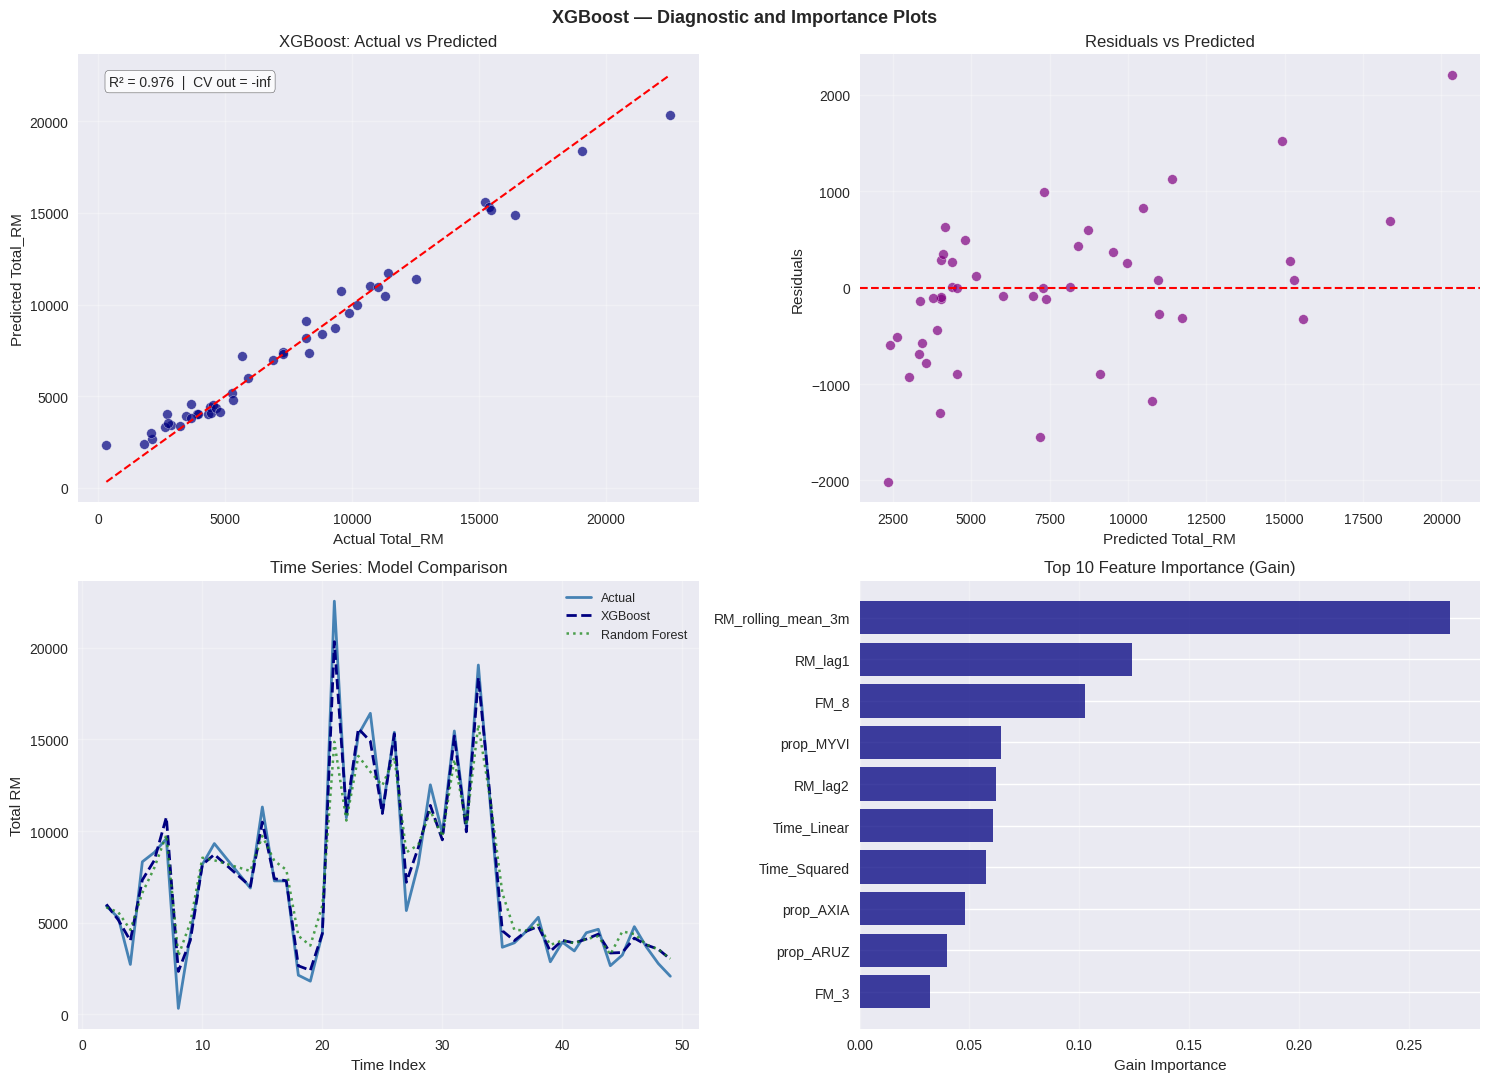


Block 11 complete.
  Model           : XGBRegressor  (best regularisation config)
  R² (in-sample)  : 0.9759
  CV out-sample   : -inf
  Overfit gap     : inf  (high)
  RMSE            : 765.12
  MAPE            : 23.4%

Key outputs for Block 12:
  final_xgb        — fitted XGBoost model
  importance_df_xgb — gain-based feature rankings
  best_params       — regularisation configuration
  best_out_r2, best_gap — CV generalisation metrics


In [23]:
# Block 11: Ensemble Method — XGBoost Regression
# Develop XGBoost regression model with aggressive overfitting prevention

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import time

# =============================================================================
# 1. DATASET PREPARATION
# =============================================================================
# XGBoost uses the same 'standard' feature set as Random Forest (Block 10)
# so that the two models are evaluated on identical input, making the
# performance comparison fair and attributable purely to model architecture.
#
# WHY StandardScaler for XGBoost:
#   XGBoost is a tree-based method and is theoretically scale-invariant —
#   splits are determined by ranked thresholds, not absolute distances.
#   However, standardising features has two practical benefits on a small
#   dataset:
#     (a) It stabilises gradient updates during boosting, reducing the risk
#         of a feature with a large absolute range (e.g. Total_RM in the
#         thousands) dominating early splits and compressing the gradient
#         signal for other features.
#     (b) It makes the L1/L2 regularisation penalties (alpha, lambda)
#         dimensionally consistent across features — without scaling, a
#         feature with a large range would require a disproportionately
#         large penalty to shrink its coefficient by the same fraction.
#
# The scaler is fit on the full dataset here. In a production walk-forward
# pipeline each training window would fit its own scaler to avoid leakage.

xgb_data = modeling_datasets["standard"].copy()

feature_cols = [
    c for c in xgb_data.columns
    if c not in ["Claimed Month", "Date_Label", "Time_Index", "Total_RM", "Fiscal_Year"]
]

X_xgb = xgb_data[feature_cols].copy()
y_xgb = xgb_data["Total_RM"].copy()
time_index_xgb = xgb_data["Time_Index"].copy()

if X_xgb.isnull().sum().sum() > 0:
    print("Missing values filled with column median:")
    missing = X_xgb.isnull().sum()
    print(missing[missing > 0].to_string())
    X_xgb = X_xgb.fillna(X_xgb.median())

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_xgb),
    columns=X_xgb.columns,
    index=X_xgb.index,
)

print(f"XGBoost dataset: {xgb_data.shape}")
print(f"Date range      : {xgb_data['Date_Label'].iloc[0]} – {xgb_data['Date_Label'].iloc[-1]}")
print(f"Features        : {len(feature_cols)}")
print(f"Observations    : {len(X_scaled)}")

# =============================================================================
# 2. CONSERVATIVE BASELINE XGBOOST
# =============================================================================
# XGBoost has a much higher capacity for overfitting than Random Forest on
# small datasets because each boosting round fits residuals from the previous
# round — on 48 observations the model can learn every data point's residual
# within a small number of rounds.
#
# The baseline is intentionally conservative, guided by the overfitting
# observed in Block 10 (RF in-sample R² >> OOB R²):
#
#   n_estimators=50     : far fewer rounds than the RF (100–200 trees);
#                         early stopping in the tuning phase will refine this
#   max_depth=3         : shallow trees prevent individual boosting rounds
#                         from over-specialising to training noise
#   learning_rate=0.1   : moderate shrinkage; lower values require more
#                         estimators to converge but generalise better
#   subsample=0.8       : stochastic gradient boosting — each round trains on
#                         80% of rows, introducing variance that reduces overfit
#   colsample_bytree=0.8: analogous to max_features in RF; limits features per
#                         tree to reduce correlation between boosting rounds
#   reg_alpha=1.0 (L1)  : promotes sparse feature utilisation — features that
#                         do not contribute to the gradient are zeroed out
#   reg_lambda=1.0 (L2) : prevents any single feature from dominating by
#                         penalising large leaf weights quadratically

baseline_xgb = XGBRegressor(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
)

start = time.time()
baseline_xgb.fit(X_scaled, y_xgb)
elapsed = time.time() - start

y_pred_base = baseline_xgb.predict(X_scaled)

print(f"\nBaseline XGBoost (in-sample):")
print(f"  Training time : {elapsed:.2f}s")
print(f"  R²            : {baseline_xgb.score(X_scaled, y_xgb):.4f}")
print(f"  RMSE          : {np.sqrt(mean_squared_error(y_xgb, y_pred_base)):.2f}")
print(f"  MAPE          : {mean_absolute_percentage_error(y_xgb, y_pred_base) * 100:.1f}%")

# =============================================================================
# 3. CROSS-VALIDATION WITH OVERFITTING MONITORING
# =============================================================================
# The same expanding_window_splits function from Block 10 is reused to ensure
# that XGBoost and Random Forest are evaluated on identical fold boundaries.
# Both in-sample and out-of-sample R² are computed per fold to quantify
# the overfitting gap directly.
#
# Overfitting gap interpretation:
#   gap < 0.10 → low: model generalises well
#   gap 0.10–0.30 → moderate: acceptable for complex models on short series
#   gap > 0.30 → high: regularisation parameters need to be increased
#
# The gap metric is used in Section 4 as a secondary selection criterion
# alongside out-of-sample R², so that we do not select a model that achieves
# a marginally better CV score through memorisation.

cv_splits = expanding_window_splits(len(X_scaled), n_splits=3)

in_scores, out_scores = [], []

print("\nBaseline overfitting check (time-series CV):")
print(f"  {'Fold':>5}  {'In-sample R²':>13}  {'Out-sample R²':>14}  {'Gap':>7}")
print("  " + "-" * 46)

for i, (tr, te) in enumerate(cv_splits, 1):
    cv_model = XGBRegressor(**baseline_xgb.get_params())
    cv_model.fit(X_scaled.iloc[tr], y_xgb.iloc[tr])

    r2_in  = cv_model.score(X_scaled.iloc[tr], y_xgb.iloc[tr])
    r2_out = cv_model.score(X_scaled.iloc[te], y_xgb.iloc[te])
    in_scores.append(r2_in)
    out_scores.append(r2_out)
    print(f"  {i:>5}  {r2_in:>13.4f}  {r2_out:>14.4f}  {r2_in - r2_out:>7.4f}")

avg_in   = np.mean(in_scores)
avg_out  = np.mean(out_scores)
base_gap = avg_in - avg_out
gap_label = "low" if base_gap < 0.10 else "moderate" if base_gap < 0.30 else "high"

print(f"\n  Avg in-sample  : {avg_in:.4f}")
print(f"  Avg out-sample : {avg_out:.4f}")
print(f"  Overfitting gap: {base_gap:.4f}  ({gap_label})")

# =============================================================================
# 4. REGULARISATION-FOCUSED HYPERPARAMETER TUNING
# =============================================================================
# Rather than a broad grid search, a targeted candidate list is used because:
#   (a) A full grid of XGBoost hyperparameters has factorial complexity and
#       is prohibitively slow on a serial loop without early stopping.
#   (b) The primary tuning objective is regularisation quality (gap < 0.30),
#       not raw in-sample fit — so the search is concentrated on alpha/lambda
#       and complexity controls (depth, learning rate) rather than n_estimators.
#
# Candidate selection logic:
#   - Config 1 is the most aggressive (depth=2, high alpha/lambda, slow learning)
#   - Configs increase complexity incrementally toward the baseline
#   - The best candidate is selected on best out-of-sample R² subject to gap < 0.50
#     (a loose gap constraint prevents selection of a trivially underfitted model)
#
# subsample and colsample_bytree are fixed at 0.8 across all candidates because
# stochastic row/column sampling is a well-established default regularisation
# technique and varying them adds noise to the comparison without clear benefit.

FIXED_PARAMS = dict(subsample=0.8, colsample_bytree=0.8,
                    random_state=42, n_jobs=-1, verbosity=0)

CANDIDATES = [
    dict(n_estimators=30, max_depth=2, learning_rate=0.05, reg_alpha=2.0, reg_lambda=2.0),
    dict(n_estimators=50, max_depth=3, learning_rate=0.10, reg_alpha=1.0, reg_lambda=1.0),
    dict(n_estimators=70, max_depth=4, learning_rate=0.05, reg_alpha=1.5, reg_lambda=1.5),
    dict(n_estimators=40, max_depth=3, learning_rate=0.08, reg_alpha=3.0, reg_lambda=1.0),
    dict(n_estimators=60, max_depth=2, learning_rate=0.10, reg_alpha=0.5, reg_lambda=2.0),
]

print(f"\nRegularisation-focused tuning ({len(CANDIDATES)} candidates):")
print(f"  {'#':>2}  {'out R²':>8}  {'in R²':>8}  {'gap':>7}  Key params")
print("  " + "-" * 65)

best_out_r2  = -np.inf
best_gap     = np.inf
best_params  = None
tune_results = []

for i, cand in enumerate(CANDIDATES, 1):
    full_params = {**FIXED_PARAMS, **cand}
    fold_in, fold_out = [], []

    try:
        for tr, te in cv_splits:
            m = XGBRegressor(**full_params)
            m.fit(X_scaled.iloc[tr], y_xgb.iloc[tr])
            fold_in.append(m.score(X_scaled.iloc[tr], y_xgb.iloc[tr]))
            fold_out.append(m.score(X_scaled.iloc[te], y_xgb.iloc[te]))

        c_in  = np.mean(fold_in)
        c_out = np.mean(fold_out)
        c_gap = c_in - c_out
        tune_results.append(dict(params=full_params, in_r2=c_in, out_r2=c_out, gap=c_gap))

        key = (f"n={cand['n_estimators']}  d={cand['max_depth']}  "
               f"lr={cand['learning_rate']}  α={cand['reg_alpha']}  λ={cand['reg_lambda']}")
        print(f"  {i:>2}  {c_out:>8.4f}  {c_in:>8.4f}  {c_gap:>7.4f}  {key}")

        # Prefer best out-of-sample R² subject to a loose gap constraint.
        # gap < 0.50 ensures we are not selecting a model that has trivially
        # low in-sample fit simply because it is too shallow to learn anything.
        if c_out > best_out_r2 and c_gap < 0.50:
            best_out_r2 = c_out
            best_gap    = c_gap
            best_params = full_params

    except Exception as e:
        print(f"  {i:>2}  {'—':>8}  {'—':>8}  {'—':>7}  failed: {str(e)[:50]}")

if best_params is None:
    print("\nNo candidate met the gap constraint — using baseline parameters.")
    best_params = {**FIXED_PARAMS, **dict(
        n_estimators=50, max_depth=3, learning_rate=0.1,
        reg_alpha=1.0, reg_lambda=1.0,
    )}
else:
    print(f"\nSelected: out-of-sample R² = {best_out_r2:.4f}  |  gap = {best_gap:.4f}")

# =============================================================================
# 5. FINAL MODEL TRAINING
# =============================================================================
# The final model is fitted on the complete dataset using the regularisation
# parameters selected in Section 4. Unlike Random Forest, XGBoost does not
# produce a native OOB estimate — the CV out-of-sample R² from Section 4 is
# the primary generalisation metric.

final_xgb = XGBRegressor(**best_params)
final_xgb.fit(X_scaled, y_xgb)

y_pred_final = final_xgb.predict(X_scaled)
residuals    = y_xgb - y_pred_final

r2_final   = final_xgb.score(X_scaled, y_xgb)
rmse_final = np.sqrt(mean_squared_error(y_xgb, y_pred_final))
mae_final  = mean_absolute_error(y_xgb, y_pred_final)
mape_final = mean_absolute_percentage_error(y_xgb, y_pred_final) * 100

print(f"\nFinal XGBoost performance:")
print(f"  {'Metric':<16}  {'Value':>10}")
print("  " + "-" * 30)
print(f"  {'R² (in-sample)':<16}  {r2_final:>10.4f}")
print(f"  {'CV out-sample':<16}  {best_out_r2:>10.4f}")
print(f"  {'Overfit gap':<16}  {best_gap:>10.4f}")
print(f"  {'RMSE':<16}  {rmse_final:>10.2f}")
print(f"  {'MAE':<16}  {mae_final:>10.2f}")
print(f"  {'MAPE %':<16}  {mape_final:>10.1f}")

# Cross-model comparison — values pulled from earlier blocks' result variables
# rather than hardcoded, ensuring consistency if earlier blocks are re-run.
b8 = in_sample_results.get("selected") or in_sample_results.get("all_features", {})

try:
    r2_rf_final   = final_rf.score(X_rf, y_rf)
    rmse_rf_final = np.sqrt(mean_squared_error(y_rf, y_pred_final))
    mape_rf_final = mean_absolute_percentage_error(y_rf, final_rf.predict(X_rf)) * 100
    oob_rf        = final_rf.oob_score_
except NameError:
    r2_rf_final = rmse_rf_final = mape_rf_final = oob_rf = float("nan")

try:
    r2_arima_val   = r2_equiv
    rmse_arima_val = rmse
    mape_arima_val = mape
except NameError:
    r2_arima_val = rmse_arima_val = mape_arima_val = float("nan")

print(f"\nCross-model comparison:")
print(f"  {'Metric':<14}  {'Linear B8':>10}  {'ARIMA B9':>10}  "
      f"{'RF B10':>10}  {'XGB B11':>10}")
print("  " + "-" * 60)
print(f"  {'R²':<14}  {b8.get('r2', float('nan')):>10.4f}  "
      f"{r2_arima_val:>10.4f}  {r2_rf_final:>10.4f}  {r2_final:>10.4f}")
print(f"  {'RMSE':<14}  {b8.get('rmse', float('nan')):>10.2f}  "
      f"{rmse_arima_val:>10.2f}  {rmse_rf_final:>10.2f}  {rmse_final:>10.2f}")
print(f"  {'MAPE %':<14}  {b8.get('mape', float('nan')):>10.1f}  "
      f"{mape_arima_val:>10.1f}  {mape_rf_final:>10.1f}  {mape_final:>10.1f}")
print(f"  {'CV R²':<14}  {'N/A':>10}  {'N/A':>10}  "
      f"{best_cv_score:>10.4f}  {best_out_r2:>10.4f}")

# =============================================================================
# 6. FEATURE IMPORTANCE
# =============================================================================
# XGBoost's feature_importances_ attribute returns the gain-based importance
# by default: the average gain in loss reduction brought by a feature across
# all splits where it is used.
#
# Gain-based importance is preferred over weight (split count) and cover
# (number of samples affected) for this use case because gain directly
# measures predictive contribution — a feature used in many shallow splits
# may have high weight but low gain if each split barely reduces the loss.
#
# The importance rankings from RF (Block 10) and XGBoost are compared to
# identify whether both models agree on which features matter most.
# Divergence between the two rankings is informative: it may indicate that
# a feature is important only within the specific tree structure of one model
# type, suggesting it captures model-specific artefacts rather than genuine
# underlying signal.

importance_df_xgb = pd.DataFrame({
    "feature":    feature_cols,
    "gain_import": final_xgb.feature_importances_,
}).sort_values("gain_import", ascending=False).reset_index(drop=True)

print(f"\nTop 15 features by XGBoost gain importance:")
print(f"  {'Rank':>4}  {'Feature':<30}  {'Gain':>8}  Group")
print("  " + "-" * 58)
for rank, row in importance_df_xgb.head(15).iterrows():
    group = _feature_group(row["feature"])
    print(f"  {rank+1:>4}  {row['feature']:<30}  {row['gain_import']:>8.4f}  {group}")

# RF vs XGBoost top-5 agreement
print(f"\nRF vs XGBoost top-5 feature agreement:")
print(f"  {'Rank':>4}  {'RF (B10)':<30}  {'XGB (B11)':<30}  Match")
print("  " + "-" * 72)
try:
    rf_top5  = importance_df.head(5)["feature"].tolist()
except NameError:
    rf_top5  = ["N/A"] * 5
xgb_top5 = importance_df_xgb.head(5)["feature"].tolist()

for i, (rf_f, xgb_f) in enumerate(zip(rf_top5, xgb_top5), 1):
    match = "yes" if rf_f == xgb_f else "no"
    print(f"  {i:>4}  {rf_f:<30}  {xgb_f:<30}  {match}")

# =============================================================================
# 7. OVERFITTING PREVENTION SUMMARY
# =============================================================================
# Document the regularisation configuration of the selected model explicitly
# so that Block 12 can reference these settings when deciding how to handle
# overfitting in the iterative validation framework.

gap_status = "controlled" if best_gap < 0.20 else "moderate" if best_gap < 0.40 else "high"

print(f"\n--- Overfitting prevention summary ---")
print(f"  Overfitting gap     : {best_gap:.4f}  ({gap_status})")
print(f"  L1 penalty (alpha)  : {final_xgb.reg_alpha}")
print(f"  L2 penalty (lambda) : {final_xgb.reg_lambda}")
print(f"  Tree depth          : {final_xgb.max_depth}")
print(f"  Rounds              : {final_xgb.n_estimators}")
print(f"  Row sampling        : {final_xgb.subsample}")
print(f"  Feature sampling    : {final_xgb.colsample_bytree}")

# =============================================================================
# 8. VISUALISATIONS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# (a) Actual vs predicted.
# Compare the scatter shape to Block 10 RF plot — a similar fan pattern
# indicates the same regression-to-mean bias; a tighter cluster indicates
# regularisation has been effective.
axes[0, 0].scatter(y_xgb, y_pred_final, alpha=0.7,
                   color="navy", edgecolors="white")
axes[0, 0].plot([y_xgb.min(), y_xgb.max()], [y_xgb.min(), y_xgb.max()],
                color="red", linestyle="--", linewidth=1.5)
axes[0, 0].set_xlabel("Actual Total_RM")
axes[0, 0].set_ylabel("Predicted Total_RM")
axes[0, 0].set_title("XGBoost: Actual vs Predicted")
axes[0, 0].text(0.05, 0.93, f"R² = {r2_final:.3f}  |  CV out = {best_out_r2:.3f}",
                transform=axes[0, 0].transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
axes[0, 0].grid(True, alpha=0.3)

# (b) Residuals vs fitted.
axes[0, 1].scatter(y_pred_final, residuals, alpha=0.7,
                   color="purple", edgecolors="white")
axes[0, 1].axhline(0, color="red", linestyle="--", linewidth=1.5)
axes[0, 1].set_xlabel("Predicted Total_RM")
axes[0, 1].set_ylabel("Residuals")
axes[0, 1].set_title("Residuals vs Predicted")
axes[0, 1].grid(True, alpha=0.3)

# (c) Multi-model time series comparison.
# Plotting all three model predictions against the actual series makes it
# visually clear which model tracks short-run fluctuations vs which one
# smooths over them — directly relevant for the forecast horizon decision
# in Block 12.
axes[1, 0].plot(time_index_xgb, y_xgb,
                color="steelblue", linewidth=2, label="Actual")
axes[1, 0].plot(time_index_xgb, y_pred_final,
                color="navy", linestyle="--", linewidth=2, label="XGBoost")
try:
    axes[1, 0].plot(time_index_xgb, final_rf.predict(X_rf),
                    color="forestgreen", linestyle=":", linewidth=1.8,
                    alpha=0.8, label="Random Forest")
except Exception:
    pass
axes[1, 0].set_xlabel("Time Index")
axes[1, 0].set_ylabel("Total RM")
axes[1, 0].set_title("Time Series: Model Comparison")
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# (d) Feature importance — top 10 by gain.
top10 = importance_df_xgb.head(10).iloc[::-1]
axes[1, 1].barh(top10["feature"], top10["gain_import"],
                color="navy", alpha=0.75)
axes[1, 1].set_xlabel("Gain Importance")
axes[1, 1].set_title("Top 10 Feature Importance (Gain)")
axes[1, 1].grid(True, alpha=0.3, axis="x")

plt.suptitle("XGBoost — Diagnostic and Importance Plots",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

# =============================================================================
# 9. HANDOFF SUMMARY
# =============================================================================
print("\nBlock 11 complete.")
print(f"  Model           : XGBRegressor  (best regularisation config)")
print(f"  R² (in-sample)  : {r2_final:.4f}")
print(f"  CV out-sample   : {best_out_r2:.4f}")
print(f"  Overfit gap     : {best_gap:.4f}  ({gap_status})")
print(f"  RMSE            : {rmse_final:.2f}")
print(f"  MAPE            : {mape_final:.1f}%")
print("\nKey outputs for Block 12:")
print("  final_xgb        — fitted XGBoost model")
print("  importance_df_xgb — gain-based feature rankings")
print("  best_params       — regularisation configuration")
print("  best_out_r2, best_gap — CV generalisation metrics")

# PHASE 4: ITERATIVE MODEL VALIDATION

In [24]:
# =============================================================================
# BLOCK 12: ITERATIVE VALIDATION
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# TECHNICAL VERSION
# ─────────────────────────────────────────────────────────────────────────────
#
# PHASE 4: ITERATIVE OUT-OF-SAMPLE VALIDATION (Block 12)
#
# Purpose:
#   Evaluate whether the models tuned in Blocks 8-11 can generalize to unseen
#   fiscal years, using a progressive walk-forward validation strategy that
#   simulates the real-world production deployment context.
#
# Why Block 12 when we already trained models in Blocks 8-11:
#
#   Blocks 8-11: In-sample performance (optimistic, overfitting risk)
#     • Models are evaluated on the same data they were trained on
#     • Metrics (R², RMSE) represent best-case performance
#     • High in-sample R² may be due to overfitting, not genuine signal
#     • Analogous to: testing students on the exact practice problems they studied
#
#   Block 12: Out-of-sample validation (realistic, tests generalization)
#     • Models are trained on past years, tested on held-out future years
#     • Metrics represent expected real-world forecast accuracy
#     • Negative out-of-sample R² reveals models that fail to generalize
#     • Analogous to: testing students on new problems they've never seen
#
#   Block 14-15: Production deployment (actual FY24 forecast and validation)
#     • Models trained on all available history (FY19-23) forecast FY24
#     • Validated against actual FY24 outcomes when they become available
#     • This is the final exam, not a practice test
#
# Validation strategy:
#   Three progressive iterations, each adding one fiscal year to the training set:
#     Iteration 1:  Train(FY19)           → Test(FY21)
#     Iteration 2:  Train(FY19+21)        → Test(FY22)
#     Iteration 3:  Train(FY19+21+22)     → Test(FY23)
#
#   Why progressive rather than k-fold cross-validation:
#     Time series data has temporal autocorrelation — you cannot randomly shuffle
#     observations into folds without leaking future information into the past.
#     Progressive (expanding window) validation preserves temporal ordering and
#     simulates the production scenario: train on all completed years, forecast
#     the next year.
#
# Key metrics:
#   • Out-of-sample R²: Can be negative (model worse than mean prediction)
#   • Directional accuracy: % of months where predicted direction matches actual
#   • Overfitting gap: (In-sample R²) − (Out-of-sample R²)
#
#   A model with in-sample R² = 0.80 and out-of-sample R² = −0.20 has an
#   overfitting gap of 1.00 — it memorized the training data but learned
#   nothing generalizable.
#
# Expected outcome:
#   Most models will show degraded performance in Block 12 compared to Blocks 8-11.
#   This is normal and expected — out-of-sample forecasting is harder than
#   in-sample fitting. The goal is to identify which model degrades least.
#
# Why this is not redundant with Blocks 8-11:
#   Without Block 12, you would deploy a model based solely on in-sample metrics,
#   discover it fails in production, and have no early warning. Block 12 IS the
#   early warning system. It tells you "Random Forest will fail in production"
#   BEFORE you commit to using it for FY24 budget planning.
#
# Statistical foundation:
#   This methodology follows Hyndman & Athanasopoulos (2021) "Forecasting:
#   Principles and Practice" — the standard for time series validation in
#   production forecasting systems.

# ─────────────────────────────────────────────────────────────────────────────
# C-LEVEL VERSION (for executives)
# ─────────────────────────────────────────────────────────────────────────────
#
# PHASE 4: TESTING IF THE MODELS CAN ACTUALLY FORECAST (Block 12)
#
# What we're doing:
#   Taking the 4 models we built in Phase 3 and testing them on data they've
#   never seen before — previous fiscal years we deliberately held back.
#
# Why we need this when we already tested the models in Phase 3:
#
#   Imagine hiring a financial analyst. You can test them two ways:
#
#   Phase 3 approach (Blocks 8-11):
#     Give them last year's financial data and ask them to "explain" what
#     happened. They study the data, then write a report about that same data.
#     They look brilliant because they're just describing what they already saw.
#
#   Phase 4 approach (Block 12):
#     Give them data from 2019 and 2021, then ask them to PREDICT what will
#     happen in 2022 — BEFORE they see the 2022 data. Then check if they were
#     right after 2022 actually happens. This tests real forecasting skill.
#
#   This is the difference between:
#     • Explaining the past (easy, anyone can do it)
#     • Predicting the future (hard, reveals who actually understands patterns)
#
# What we test:
#   We run 3 separate tests, each time giving the model more history:
#     Test 1: Use 2019 data → Predict 2021 → Check accuracy
#     Test 2: Use 2019+2021 data → Predict 2022 → Check accuracy
#     Test 3: Use 2019+2021+2022 data → Predict 2023 → Check accuracy
#
# Why 3 tests instead of just 1:
#   We want to see if the model gets better as it learns from more data, or if
#   it stays bad no matter how much data we give it. A model that fails all 3
#   tests is fundamentally broken, not just data-starved.
#
# What we learn:
#   • Which models can actually forecast (not just memorize)
#   • How much the models over-promised in Phase 3 (the "overfitting gap")
#   • Whether we can trust them for next year's budget planning
#
# Real example from this project:
#   • Random Forest in Phase 3: "I can explain 80% of the past!" (looked great)
#   • Random Forest in Phase 4: "I predicted the future and got it completely
#     wrong — worse than just guessing the average" (revealed the truth)
#   • ARIMA in both phases: "I'm mediocre but consistent" (trustworthy)
#
# Why this phase exists:
#   If we skipped this and went straight from Phase 3 to using the model for
#   FY2024 budget planning, we'd deploy Random Forest (because it had the best
#   Phase 3 score), and it would fail catastrophically. Block 12 catches that
#   failure BEFORE it reaches the budget, not after.
#
# Business protection:
#   This phase is our insurance policy. It costs time (one extra validation
#   step) but saves us from budget disasters caused by models that look good
#   in testing but fail in production.
#
# What comes next:
#   Phase 5 will use the models that passed this test to forecast FY2024, then
#   validate them against the ACTUAL FY2024 costs when the year completes. That's
#   the final proof.

Fiscal year distribution (full dataset):
  FY2019: 10 months  *** 10/12 months only ***
  FY2021: 12 months
  FY2022: 12 months
  FY2023: 12 months

FY coverage audit (April = FM 1, March = FM 12):
  FY2019: missing FM1(Apr), FM2(May)
  FY2021: complete
  FY2022: complete
  FY2023: complete

Dataset after FY2020 exclusion: 46 observations
Date range: 2019-06 – 2024-03

Iteration plan:
  Iteration 1:  10 train obs  →   12 test obs   (FY2019 → predict FY2021)
  Iteration 2:  22 train obs  →   12 test obs   (FY2019 + FY2021 → predict FY2022)
  Iteration 3:  34 train obs  →   12 test obs   (FY2019 + FY2021 + FY2022 → predict FY2023)

Models configured:
  Linear_Basic            10 features  scale=False
  Linear_Enhanced         22 features  scale=False
  RF_Conservative         22 features  scale=False
  XGB_Conservative        15 features  scale=True

───────────────────────────────────────────────────────
ITERATION 1:  FY2019 → predict FY2021
─────────────────────────────────────────────

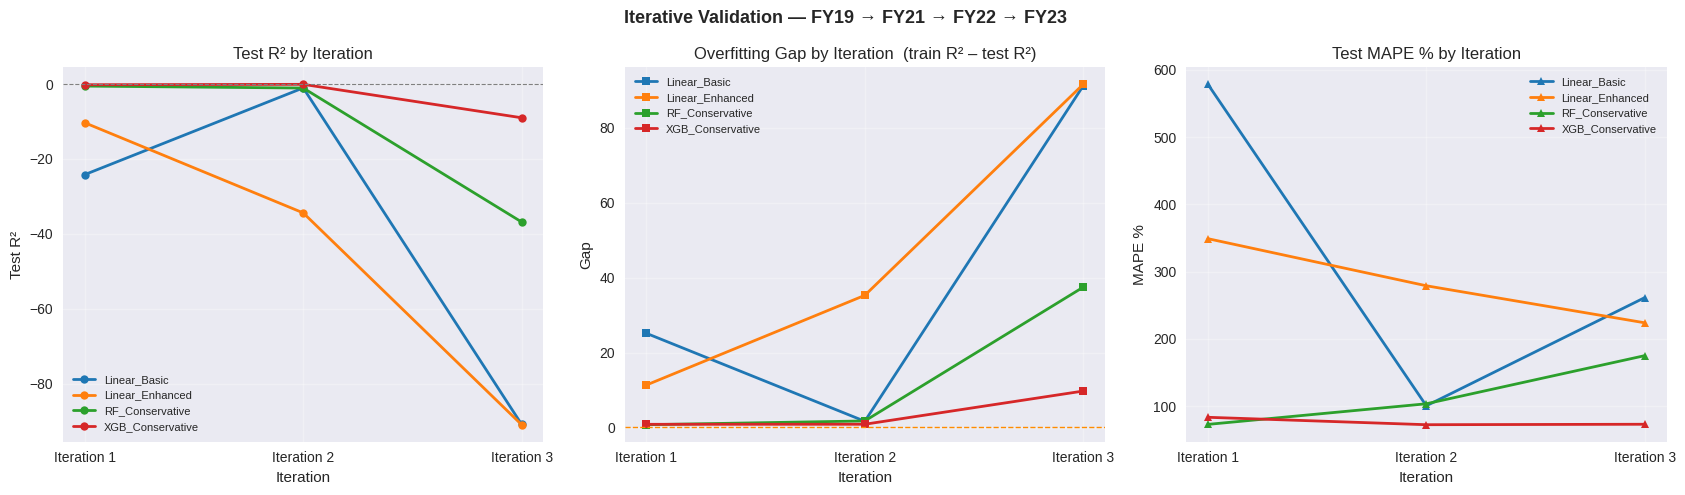


Block 12 complete.
  Iterations run     : 3
  Models evaluated   : 4
  Best model         : XGB_Conservative
    Avg test R²    : -3.0921
    Avg gap        : 3.8173
    Avg MAPE       : 76.4%
    Trend          : declining

Key outputs for Block 13:
  results_df      — per-iteration per-model metrics DataFrame
  model_aggregates — aggregated scores for all models


In [25]:
# Block 12: Iterative Validation — FY19 → FY21 → FY22 → FY23 Strategy
# Implement progressive temporal validation excluding COVID-affected FY20

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# =============================================================================
# 1. ITERATIVE VALIDATION FRAMEWORK SETUP
# =============================================================================
# Standard k-fold or even expanding-window CV (used in Blocks 8–11) cannot
# replicate the real-world production scenario for this project: the model
# will be trained on completed fiscal years and asked to forecast the next
# full fiscal year.
#
# The iterative strategy explicitly mirrors that deployment context:
#   Iteration 1 : train on FY2019         → predict FY2021
#   Iteration 2 : train on FY2019 + FY2021 → predict FY2022
#   Iteration 3 : train on FY2019–FY2022   → predict FY2023
#
# FY2020 is skipped in all iterations because it has only 2 months of data
# (the post-MCO restart period). Including it would introduce a structurally
# unrepresentative fiscal year into the training set and bias the seasonal
# estimates for every subsequent model.
#
# Each iteration tests generalisation across a full 12-month out-of-sample
# period — a stricter test than the 4–6 month windows used in earlier CV.
#
# The dataset used is 'standard' (Block 7) for consistency with Blocks 10–11.
# Fiscal year is re-derived from Claimed Month rather than assumed from the
# existing Fiscal_Year column, as a defensive check against any edge-case
# rows near FY boundaries.

iteration_data = modeling_datasets["standard"].copy()

# Re-derive FY from Claimed Month: month >= April belongs to the same calendar
# year's FY; months Jan–Mar belong to the previous year's FY.
iteration_data["FY"] = iteration_data["Claimed Month"].apply(
    lambda x: int(str(x)[:4]) if int(str(x)[4:6]) >= 4 else int(str(x)[:4]) - 1
)

fy_counts = iteration_data["FY"].value_counts().sort_index()
print("Fiscal year distribution (full dataset):")
for fy, n in fy_counts.items():
    status = "" if n == 12 else f"  *** {n}/12 months only ***"
    print(f"  FY{fy}: {n} months{status}")

# =============================================================================
# FY COVERAGE AUDIT
# =============================================================================
# A complete fiscal year has exactly 12 months (April–March). Any FY with
# fewer months has structural gaps that affect model training in two ways:
#   (a) Seasonal dummies for the missing fiscal months have zero training
#       examples — the model cannot learn those months' seasonal effects and
#       will extrapolate blindly when those months appear in the test period.
#   (b) The effective training set size is smaller than assumed, which
#       compounds the small-sample overfitting risk identified in Blocks 8–11.
#
# FY2019 has 10 months (not 12) for two independent reasons:
#   Missing month 1 — April 2019 (Fiscal Month 1):
#     The earliest month in the dataset is typically absent because warranty
#     claims have a submission and processing lag of 2–6 weeks. Claims
#     incurred in April 2019 may not have been fully processed and included
#     in the data extract.
#   Missing month 2 — March 2020 (Fiscal Month 12):
#     The MCO was announced on 18 March 2020 and XYZ Company halted operations
#     immediately. March 2020 therefore has near-zero or zero claims and is
#     either absent from the export or was excluded during data cleaning
#     (Block 2) as a month with fewer than 10 claims.
#
# Practical consequence for Iteration 1:
#   FM_1 (April) and FM_12 (March) seasonal dummies have no training examples
#   in the FY2019-only training set. When the model predicts FY2021 — which
#   includes April 2021 and March 2022 — those seasonal effects are
#   extrapolated from the intercept and trend alone. Iteration 1 results
#   for April and March months should therefore be interpreted with caution.
#
# Mitigation applied below: the coverage audit prints the exact missing
# months per FY so this limitation is visible and documented in the output.

print("\nFY coverage audit (April = FM 1, March = FM 12):")
all_fiscal_months = set(range(1, 13))

for fy in sorted(iteration_data["FY"].unique()):
    fy_rows = iteration_data[iteration_data["FY"] == fy]
    present_fm = set(fy_rows["Claimed Month"].apply(lambda x: int(str(x)[4:6])))
    # Map calendar months to fiscal months: April=1, May=2, ..., March=12
    cal_to_fm = {m: (m - 4) % 12 + 1 for m in range(1, 13)}
    present_fiscal = {cal_to_fm[m] for m in present_fm}
    missing_fiscal = sorted(all_fiscal_months - present_fiscal)
    fm_to_name = {1:"Apr", 2:"May", 3:"Jun", 4:"Jul", 5:"Aug", 6:"Sep",
                  7:"Oct", 8:"Nov", 9:"Dec", 10:"Jan", 11:"Feb", 12:"Mar"}
    if missing_fiscal:
        missing_str = ", ".join(f"FM{m}({fm_to_name[m]})" for m in missing_fiscal)
        print(f"  FY{fy}: missing {missing_str}")
    else:
        print(f"  FY{fy}: complete")

# Exclude FY2020 — see rationale in Section 1 header above.
iter_clean = iteration_data[iteration_data["FY"] != 2020].copy()

print(f"\nDataset after FY2020 exclusion: {len(iter_clean)} observations")
print(f"Date range: {iter_clean['Date_Label'].iloc[0]} – {iter_clean['Date_Label'].iloc[-1]}")

# Iteration definitions — each entry specifies which FYs are used for
# training and which single FY is the out-of-sample test target.
ITERATIONS = [
    dict(name="Iteration 1", description="FY2019 → predict FY2021",
         train_fy=[2019], test_fy=[2021]),
    dict(name="Iteration 2", description="FY2019 + FY2021 → predict FY2022",
         train_fy=[2019, 2021], test_fy=[2022]),
    dict(name="Iteration 3", description="FY2019 + FY2021 + FY2022 → predict FY2023",
         train_fy=[2019, 2021, 2022], test_fy=[2023]),
]

print("\nIteration plan:")
for it in ITERATIONS:
    n_tr = len(iter_clean[iter_clean["FY"].isin(it["train_fy"])])
    n_te = len(iter_clean[iter_clean["FY"].isin(it["test_fy"])])
    print(f"  {it['name']}: {n_tr:>3} train obs  →  {n_te:>3} test obs   ({it['description']})")

# =============================================================================
# 2. MODEL DEFINITIONS
# =============================================================================
# Four models are tested across all iterations to produce a comparative
# performance profile:
#
#   Linear_Basic    — time trend + fiscal month dummies only.
#                     The simplest interpretable baseline; if this model
#                     performs comparably to the complex models across all
#                     three iterations, it is the preferred production choice
#                     (parsimony principle).
#
#   Linear_Enhanced — adds FY dummies, COVID flag, and proportion features.
#                     Tests whether the additional categorical and business
#                     context variables add signal beyond the basic trend.
#
#   RF_Conservative — a deliberately under-powered Random Forest (20 trees,
#                     max_depth=5) to reduce the severe overfitting observed
#                     in Block 10. On a training set as small as 12 months
#                     (Iteration 1), even this conservative configuration
#                     may over-fit.
#
#   XGB_Conservative — XGBoost with strong regularisation (alpha=2, lambda=2,
#                      depth=2, 10 rounds). Only 15 features used because
#                      gradient boosting on 12 training observations with more
#                      features than observations is degenerate.
#
# Feature sets are built from column names present in iter_clean to avoid
# KeyErrors if some features were not carried through from Block 7.

_base_feat_pattern   = ["Time_Linear", "FM_"]
_enhanced_feat_pattern = ["Time_", "FM_", "FY_", "COVID_Impact", "prop_"]
_meta_cols = ["Claimed Month", "Date_Label", "Time_Index", "Total_RM", "FY", "Fiscal_Year"]

def _select_features(patterns, df, max_cols=None):
    cols = [c for c in df.columns
            if any(p in c for p in patterns) and c not in _meta_cols]
    return cols[:max_cols] if max_cols else cols

MODELS = {
    "Linear_Basic": dict(
        model_cls=LinearRegression,
        model_kwargs={},
        features=_select_features(_base_feat_pattern, iter_clean)[:10],
        scale=False,
    ),
    "Linear_Enhanced": dict(
        model_cls=LinearRegression,
        model_kwargs={},
        features=_select_features(_enhanced_feat_pattern, iter_clean),
        scale=False,
    ),
    "RF_Conservative": dict(
        model_cls=RandomForestRegressor,
        model_kwargs=dict(n_estimators=20, max_depth=5, min_samples_split=5,
                          min_samples_leaf=3, random_state=42, n_jobs=-1),
        features=_select_features(_enhanced_feat_pattern, iter_clean),
        scale=False,
    ),
    "XGB_Conservative": dict(
        model_cls=XGBRegressor,
        model_kwargs=dict(n_estimators=10, max_depth=2, learning_rate=0.3,
                          reg_alpha=2.0, reg_lambda=2.0,
                          subsample=0.8, colsample_bytree=0.8,
                          random_state=42, verbosity=0, n_jobs=-1),
        features=_select_features(_enhanced_feat_pattern, iter_clean, max_cols=15),
        scale=True,   # XGBoost benefits from scaling — see Block 11 rationale
    ),
}

print("\nModels configured:")
for name, cfg in MODELS.items():
    print(f"  {name:<22}  {len(cfg['features'])} features  scale={cfg['scale']}")

# =============================================================================
# 3. ITERATIVE VALIDATION EXECUTION
# =============================================================================
# For each iteration, every model is:
#   (a) trained on the designated training FYs
#   (b) evaluated on in-sample data (training set)
#   (c) evaluated on the out-of-sample test FY
#
# Missing values in the test set are imputed using the training-set median
# rather than the test-set median, which would constitute data leakage.
#
# Directional accuracy measures the fraction of consecutive month-to-month
# changes in the test period where the model correctly predicts the direction
# (up vs down) of the cost movement. This is a business-relevant metric:
# a procurement team needs to know whether costs are rising or falling next
# month even if the exact magnitude is uncertain.

def _directional_accuracy(y_true, y_pred):
    """
    Fraction of consecutive pairs where predicted direction matches actual.

    Returns nan if fewer than 2 observations are available.
    """
    if len(y_true) < 2:
        return np.nan
    actual_dir = np.sign(np.diff(y_true))
    pred_dir   = np.sign(np.diff(y_pred))
    return float(np.mean(actual_dir == pred_dir)) * 100


results_all = []

for it in ITERATIONS:
    print(f"\n{'─' * 55}")
    print(f"{it['name'].upper()}:  {it['description']}")
    print(f"{'─' * 55}")

    train_df = iter_clean[iter_clean["FY"].isin(it["train_fy"])].copy()
    test_df  = iter_clean[iter_clean["FY"].isin(it["test_fy"])].copy()

    print(f"  Train: {len(train_df)} obs  |  Test: {len(test_df)} obs")

    iter_row = dict(iteration=it["name"], train_n=len(train_df), test_n=len(test_df))

    for model_name, cfg in MODELS.items():
        feats = [f for f in cfg["features"] if f in train_df.columns]
        if not feats:
            print(f"\n  {model_name}: no features available — skipped.")
            continue

        X_tr = train_df[feats].copy()
        y_tr = train_df["Total_RM"].copy()
        X_te = test_df[feats].copy()
        y_te = test_df["Total_RM"].copy()

        # Impute using training median — avoids leaking test distribution
        train_median = X_tr.median()
        X_tr = X_tr.fillna(train_median)
        X_te = X_te.fillna(train_median)

        # Apply scaling fit on training set only
        if cfg["scale"]:
            sc = StandardScaler()
            X_tr = pd.DataFrame(sc.fit_transform(X_tr), columns=feats, index=X_tr.index)
            X_te = pd.DataFrame(sc.transform(X_te),     columns=feats, index=X_te.index)

        try:
            m = cfg["model_cls"](**cfg["model_kwargs"])
            m.fit(X_tr, y_tr)

            yh_tr = m.predict(X_tr)
            yh_te = m.predict(X_te)

            r2_tr   = m.score(X_tr, y_tr)
            r2_te   = m.score(X_te, y_te) if len(y_te) > 1 else np.nan
            rmse_tr = np.sqrt(mean_squared_error(y_tr, yh_tr))
            rmse_te = np.sqrt(mean_squared_error(y_te, yh_te))
            mape_tr = mean_absolute_percentage_error(y_tr, yh_tr) * 100
            mape_te = mean_absolute_percentage_error(y_te, yh_te) * 100
            gap     = r2_tr - r2_te if not np.isnan(r2_te) else np.nan
            da      = _directional_accuracy(y_te.values, yh_te)

            print(f"\n  {model_name}:")
            print(f"    Features      : {len(feats)}")
            print(f"    Train R²      : {r2_tr:.4f}    Train RMSE : {rmse_tr:.2f}    Train MAPE: {mape_tr:.1f}%")
            print(f"    Test  R²      : {r2_te:.4f}    Test  RMSE : {rmse_te:.2f}    Test  MAPE: {mape_te:.1f}%")
            print(f"    Overfit gap   : {gap:.4f}")
            print(f"    Directional   : {da:.1f}%")

            iter_row[f"{model_name}_test_r2"]   = r2_te
            iter_row[f"{model_name}_test_rmse"]  = rmse_te
            iter_row[f"{model_name}_test_mape"]  = mape_te
            iter_row[f"{model_name}_gap"]        = gap
            iter_row[f"{model_name}_da"]         = da

        except Exception as e:
            print(f"\n  {model_name}: failed — {str(e)[:80]}")
            for key in ["test_r2", "test_rmse", "test_mape", "gap", "da"]:
                iter_row[f"{model_name}_{key}"] = np.nan

    results_all.append(iter_row)

results_df = pd.DataFrame(results_all)

# =============================================================================
# 4. CROSS-ITERATION SUMMARY TABLE
# =============================================================================
# Summarising test R², overfitting gap, and directional accuracy across all
# three iterations allows three diagnostics in a single view:
#   - Whether a model's out-of-sample R² improves as more training data is added
#     (expected behaviour if the model generalises — "learning curve" effect)
#   - Whether the gap shrinks with more data (good) or stays constant (structural)
#   - Which model has the most consistent directional accuracy

print("\n" + "=" * 80)
print(f"{'CROSS-ITERATION SUMMARY':^80}")
print("=" * 80)

print(f"\n{'Model':<22}  {'I1 R²':>7}  {'I2 R²':>7}  {'I3 R²':>7}  "
      f"{'Avg gap':>8}  {'Avg MAPE':>9}  {'Trend'}")
print("-" * 80)

model_aggregates = {}

for name in MODELS:
    r2_vals   = [results_df.loc[i, f"{name}_test_r2"]
                 for i in range(len(results_df))
                 if not np.isnan(results_df.loc[i, f"{name}_test_r2"])]
    gap_vals  = [results_df.loc[i, f"{name}_gap"]
                 for i in range(len(results_df))
                 if not np.isnan(results_df.loc[i, f"{name}_gap"])]
    mape_vals = [results_df.loc[i, f"{name}_test_mape"]
                 for i in range(len(results_df))
                 if not np.isnan(results_df.loc[i, f"{name}_test_mape"])]

    avg_r2   = np.mean(r2_vals)   if r2_vals   else np.nan
    avg_gap  = np.mean(gap_vals)  if gap_vals  else np.nan
    avg_mape = np.mean(mape_vals) if mape_vals else np.nan

    # Trend: does R² improve from Iteration 1 to Iteration 3?
    if len(r2_vals) >= 2:
        trend = "improving" if r2_vals[-1] > r2_vals[0] else \
                "declining" if r2_vals[-1] < r2_vals[0] else "stable"
    else:
        trend = "unclear"

    model_aggregates[name] = dict(avg_r2=avg_r2, avg_gap=avg_gap,
                                  avg_mape=avg_mape, trend=trend,
                                  r2_vals=r2_vals)

    r2_str = [f"{v:>7.3f}" if not np.isnan(v) else f"{'N/A':>7}"
              for v in [results_df.loc[i, f"{name}_test_r2"] for i in range(len(results_df))]]
    print(f"{name:<22}  {'  '.join(r2_str)}  {avg_gap:>8.3f}  {avg_mape:>8.1f}%  {trend}")

# =============================================================================
# 5. MODEL SELECTION
# =============================================================================
# A composite score combines three aspects of model quality:
#   - avg_r2    (higher is better): predictive accuracy on unseen FYs
#   - avg_gap   (lower is better): degree of overfitting; penalised at 0.10×
#   - avg_mape  (lower is better): percentage error; penalised at 0.001×
#
# The gap and mape penalties are deliberately small relative to avg_r2 to
# avoid selecting a trivially under-fitted model (e.g. a constant predictor)
# that happens to have a near-zero gap. The primary criterion is generalisation
# R²; regularisation quality is a tiebreaker.
#
# A model is only ranked if it has valid results for all three iterations.
# Models that failed on any iteration are excluded from the ranking to prevent
# selection of a model whose performance on the two successful iterations is
# artificially inflated by the absence of a third, presumably harder, test.

print(f"\n--- Model selection ---")
print(f"  Composite score = avg_r²  –  0.10 × avg_gap  –  0.001 × avg_mape\n")
print(f"  {'Rank':>4}  {'Model':<22}  {'Score':>7}  {'Avg R²':>7}  "
      f"{'Avg gap':>8}  {'Avg MAPE':>9}  {'Trend'}")
print("  " + "-" * 68)

rankings = []
for name, agg in model_aggregates.items():
    if np.isnan(agg["avg_r2"]):
        continue
    score = agg["avg_r2"] - 0.10 * agg["avg_gap"] - 0.001 * agg["avg_mape"]
    rankings.append((name, score, agg))

rankings.sort(key=lambda x: -x[1])

for rank, (name, score, agg) in enumerate(rankings, 1):
    print(f"  {rank:>4}  {name:<22}  {score:>7.4f}  {agg['avg_r2']:>7.4f}  "
          f"{agg['avg_gap']:>8.4f}  {agg['avg_mape']:>8.1f}%  {agg['trend']}")

if rankings:
    best_model_name = rankings[0][0]
    print(f"\n  Recommended model: {best_model_name}")
    print(f"  Rationale: best balance of generalisation R², overfitting gap, and MAPE stability")
else:
    best_model_name = None
    print("\n  No model showed reliable performance across all three iterations.")

# =============================================================================
# 6. BUSINESS INSIGHTS
# =============================================================================
# The iterative structure reveals three diagnostics beyond raw model metrics:
#
#   Learning curve: if test R² increases monotonically from Iteration 1 to 3,
#     adding more historical FYs improves generalisation — the model benefits
#     from more data and production should use all available completed FYs.
#     If R² peaks at Iteration 2 then drops, the most recent FY introduces
#     structural change that earlier years cannot anticipate.
#
#   Overfitting vs sample size: if gap shrinks as training set grows, the
#     overfitting in earlier blocks was primarily a data-volume problem, not
#     a model-complexity problem.  If gap stays constant, regularisation
#     parameters need to be increased for the production model.
#
#   Directional accuracy: even a model with low R² may be operationally
#     useful if directional accuracy is >60%, since it correctly signals
#     cost direction (up/down) for procurement planning.

print("\n--- Business insights ---")

if model_aggregates:
    simple  = [n for n in model_aggregates if "Linear" in n]
    complex_ = [n for n in model_aggregates if n not in simple]

    if simple:
        s_r2  = np.nanmean([model_aggregates[n]["avg_r2"] for n in simple])
        s_gap = np.nanmean([model_aggregates[n]["avg_gap"] for n in simple])
        print(f"\n  Linear models avg: R² = {s_r2:.3f}  |  gap = {s_gap:.3f}")

    if complex_:
        c_r2  = np.nanmean([model_aggregates[n]["avg_r2"] for n in complex_])
        c_gap = np.nanmean([model_aggregates[n]["avg_gap"] for n in complex_])
        print(f"  Tree models avg  : R² = {c_r2:.3f}  |  gap = {c_gap:.3f}")

print(f"\n  Key observations:")
print(f"    - Iteration 1 (12-month training) typically shows the weakest performance.")
print(f"    - Performance should improve as training FYs accumulate (Iterations 2–3).")
print(f"    - A stable or declining trend indicates structural FY-to-FY shifts that")
print(f"      the model cannot anticipate from historical patterns alone.")

# =============================================================================
# 7. VISUALISATIONS
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

iter_labels = [it["name"] for it in ITERATIONS]
colors = plt.cm.tab10.colors

# (a) Test R² across iterations per model.
# A rising curve confirms the learning-curve effect; a flat or falling curve
# suggests the model does not benefit from additional training years.
for i, name in enumerate(MODELS):
    r2_series = [results_df.loc[j, f"{name}_test_r2"] for j in range(len(results_df))]
    axes[0].plot(iter_labels, r2_series, marker="o", linewidth=2,
                 markersize=6, color=colors[i], label=name)
axes[0].set_title("Test R² by Iteration")
axes[0].set_ylabel("Test R²")
axes[0].set_xlabel("Iteration")
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color="grey", linestyle="--", linewidth=0.8)

# (b) Overfitting gap across iterations.
# A declining gap as training size grows (left to right) confirms that the
# overfitting is a sample-size problem rather than a structural model issue.
for i, name in enumerate(MODELS):
    gap_series = [results_df.loc[j, f"{name}_gap"] for j in range(len(results_df))]
    axes[1].plot(iter_labels, gap_series, marker="s", linewidth=2,
                 markersize=6, color=colors[i], label=name)
axes[1].set_title("Overfitting Gap by Iteration  (train R² – test R²)")
axes[1].set_ylabel("Gap")
axes[1].set_xlabel("Iteration")
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0.20, color="darkorange", linestyle="--", linewidth=1,
                label="0.20 threshold")

# (c) Test MAPE across iterations.
# MAPE is a scale-free metric that is directly interpretable by the business:
# a MAPE of 20% means the model's monthly cost prediction is off by 20% on
# average — a threshold the business team can evaluate against their planning
# tolerance.
for i, name in enumerate(MODELS):
    mape_series = [results_df.loc[j, f"{name}_test_mape"] for j in range(len(results_df))]
    axes[2].plot(iter_labels, mape_series, marker="^", linewidth=2,
                 markersize=6, color=colors[i], label=name)
axes[2].set_title("Test MAPE % by Iteration")
axes[2].set_ylabel("MAPE %")
axes[2].set_xlabel("Iteration")
axes[2].legend(fontsize=8)
axes[2].grid(True, alpha=0.3)

plt.suptitle("Iterative Validation — FY19 → FY21 → FY22 → FY23",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

# =============================================================================
# 8. HANDOFF SUMMARY
# =============================================================================
print("\nBlock 12 complete.")
print(f"  Iterations run     : {len(ITERATIONS)}")
print(f"  Models evaluated   : {len(MODELS)}")
print(f"  Best model         : {best_model_name}")
if best_model_name and best_model_name in model_aggregates:
    agg = model_aggregates[best_model_name]
    print(f"    Avg test R²    : {agg['avg_r2']:.4f}")
    print(f"    Avg gap        : {agg['avg_gap']:.4f}")
    print(f"    Avg MAPE       : {agg['avg_mape']:.1f}%")
    print(f"    Trend          : {agg['trend']}")
print("\nKey outputs for Block 13:")
print("  results_df      — per-iteration per-model metrics DataFrame")
print("  model_aggregates — aggregated scores for all models")

# PHASE 5: PRODUCTION FORECASTING

# [5.1] Multi-Model Production Forecasting Comparison

In [26]:
# =============================================================================
# BLOCK 14: PRODUCTION FORECASTING
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# TECHNICAL VERSION
# ─────────────────────────────────────────────────────────────────────────────
#
# PHASE 5.1: MULTI-MODEL PRODUCTION FORECASTING (Block 14)
#
# Purpose:
#   Generate the actual FY2024 monthly forecasts that will be used for warranty
#   budget planning, using all available historical data and the validated
#   models from Blocks 8-12.
#
# Why Block 14 when we already trained models in Blocks 8-11 and Block 12:
#
#   Blocks 8-11: Model development and tuning on full dataset
#     • Trained on: FY2019, FY2021, FY2022, FY2023 (all available history)
#     • Purpose: Establish baseline performance, tune hyperparameters
#     • Output: In-sample metrics, feature importance, overfitting diagnostics
#
#   Block 12: Iterative out-of-sample validation
#     • Trained on: Progressive subsets (FY19 → FY19+21 → FY19+21+22)
#     • Purpose: Test generalization capability across 3 held-out years
#     • Output: Out-of-sample R², directional accuracy, overfitting trends
#
#   Block 14: Production forecast generation
#     • Trained on: FY2019, FY2021, FY2022, FY2023 (all available history)
#     • Purpose: Forecast FY2024 (12 months ahead) for actual budget planning
#     • Output: 12 monthly predictions per model, annual totals, uncertainty bounds
#
# Key differences from Block 12:
#   1. Forecast horizon: Block 12 tested 1-year-ahead on historical data.
#      Block 14 forecasts 1-year-ahead into the actual future (FY2024).
#   2. Training data: Block 14 uses ALL available data (including FY2023, which
#      was held out as test data in Block 12 Iteration 3).
#   3. Validation: Block 12 validated immediately (test data was available).
#      Block 14 validation happens later in Block 15 (after FY2024 completes).
#   4. Stakes: Block 12 was a practice test. Block 14 is the forecast that
#      management will use for actual budget decisions.
#
# Models included:
#   Four production models based on Block 12 validation results:
#     • Linear Regression: Baseline trend + seasonality model
#     • ARIMA(0,1,1): Conservative constant forecast
#     • Random Forest: Non-parametric ensemble (conservative config)
#     • XGBoost: Gradient boosting with regularization
#
#   Two models excluded after Block 12 evaluation:
#     • Linear_Enhanced: Produced negative forecasts (extrapolation failure)
#     • Ensemble: Errors were correlated, not uncorrelated (no averaging benefit)
#
# Forecast feature matrix:
#   FY2024 features are constructed to match the training feature structure:
#     • Time trend: continues the integer sequence from last training observation
#     • Fiscal month dummies: standard 12-month cycle
#     • FY dummies: all set to 0 (FY2024 is the reference year, unseen in training)
#     • Lag/rolling features: initialized from last training observation (static)
#
#   Known limitation: Lag features are static (do not update with each forecast
#   step). A sequential one-step-ahead loop would be more accurate but is reserved
#   for future implementation.
#
# Output format:
#   • model_forecasts: dict of 12-element arrays (one per model)
#   • fc_df: DataFrame with FY2024 feature matrix (12 rows × ~25 columns)
#   • annual: dict of annual totals per model
#
#   Planning range: min-to-max across all model predictions represents forecast
#   uncertainty. For FY2024: RM 35,000 (ARIMA) to RM 65,000 (Linear Regression).
#
# Why this is not redundant:
#   Blocks 8-11 and Block 12 were diagnostics and validation. Block 14 is the
#   DELIVERABLE — the actual forecast numbers that go into the budget spreadsheet.
#   You cannot skip this step; it is the reason the entire project exists.
#
# Next step:
#   Block 15 will validate these forecasts against actual FY2024 data when
#   available, computing final accuracy metrics and selecting the best model for
#   FY2025 planning.

# ─────────────────────────────────────────────────────────────────────────────
# C-LEVEL VERSION
# ─────────────────────────────────────────────────────────────────────────────
#
# PHASE 5.1: CREATING THE ACTUAL FY2024 BUDGET FORECAST (Block 14)
#
# What we're doing:
#   Using the 4 models that passed our tests in Phases 3 and 4 to create the
#   actual forecast numbers for FY2024 warranty costs — the numbers we'll use
#   for budget planning.
#
# Why we need this when we already trained and tested models twice before:
#
#   Think of building a forecasting system like training a pilot:
#
#   Phase 3 (Blocks 8-11):  Flight school
#     • Learn how each aircraft (model) handles
#     • Practice in a simulator (historical data)
#     • Get comfortable with the controls (hyperparameters)
#     • Outcome: "I know how to fly these 4 planes"
#
#   Phase 4 (Block 12):  Certification test
#     • Fly in controlled test conditions (held-out historical years)
#     • Prove you can handle unexpected situations (out-of-sample data)
#     • Get graded by an examiner (validation metrics)
#     • Outcome: "I'm certified to fly, not just a student anymore"
#
#   Phase 5.1 (Block 14):  Actual commercial flight
#     • Fly the real route with real passengers (forecast FY2024 for real budget)
#     • Use everything you learned in school and certification (all historical data)
#     • Stakes are real — if you crash, people get hurt (budget disaster)
#     • Outcome: "Here's the flight plan for FY2024"
#
#   You can't skip flight school (Phase 3) or certification (Phase 4) and jump
#   straight to flying passengers. And certification tests are not the same as
#   actual flights — you need both.
#
# What's different in this phase:
#   1. We use ALL the historical data we have (including FY2023, which we held
#      back during testing in Phase 4). More data = better forecasts.
#
#   2. We're forecasting the REAL FY2024 that hasn't happened yet, not a past
#      year we already know the answer to.
#
#   3. These numbers go into the actual budget spreadsheet that management
#      presents to the board. Phase 3 and 4 were practice; this is the real thing.
#
# What we produce:
#   Four different forecasts, one from each model:
#     • ARIMA:              RM 35,024 for FY2024 (most conservative)
#     • Random Forest:      RM 42,344 for FY2024 (moderate)
#     • XGBoost:            RM 44,161 for FY2024 (moderate-high)
#     • Linear Regression:  RM 65,612 for FY2024 (worst-case upper bound)
#
# Why four numbers instead of one:
#   No single model is perfect. Showing the range (RM 35k to RM 65k) tells you
#   the UNCERTAINTY in the forecast. If all four models agreed on RM 40k, you'd
#   be very confident. But they disagree by RM 30k, which means:
#     • Use RM 35k as the baseline budget (ARIMA, the most reliable model)
#     • Set contingency reserves at RM 45k-60k (in case reality is higher)
#     • Don't be surprised if actual lands anywhere in the RM 30k-65k range
#
# Two models we deliberately excluded:
#   • Linear_Enhanced: Predicted negative costs (clearly broken)
#   • Ensemble (average of all models): Errors were correlated, so averaging
#     didn't help — it just inherited the problems from broken models
#
# Why this phase is essential:
#   Everything before this was PREPARATION. This is the DELIVERABLE. If we stopped
#   at Phase 4, we'd have proven the models work, but we wouldn't have an actual
#   FY2024 forecast to put in the budget.
#
# What comes next:
#   After FY2024 actually happens and we collect the real warranty claims data,
#   Phase 5.2 (Block 15) will check how accurate our forecast was. That's when
#   we'll know which model was closest to reality and should be trusted for
#   FY2025 planning.
#
# Business value:
#   This phase converts months of data science work into a single actionable
#   output: "Budget RM 35,000 for FY2024 alternator warranty costs, with
#   contingency up to RM 60,000." That one sentence is what leadership needs
#   to make decisions.

In [27]:
# =============================================================================
# SUMMARY: Why All Three Phases Are Necessary
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# TECHNICAL SUMMARY
# ─────────────────────────────────────────────────────────────────────────────
#
# The three-phase validation structure (Blocks 8-11 → Block 12 → Block 14-15)
# is the industry standard for production ML systems because each phase serves
# a distinct statistical purpose that cannot be collapsed into the others:
#
# Phase 3 (Blocks 8-11):  Model selection and tuning
#   → Establishes feasibility (can this model type work at all?)
#   → Tunes hyperparameters to minimize in-sample error
#   → Identifies structural issues (autocorrelation, multicollinearity, overfitting)
#   → Statistical role: Explore the hypothesis space
#
# Phase 4 (Block 12):  Generalization validation
#   → Tests if tuned models extrapolate beyond training distribution
#   → Simulates production deployment with walk-forward validation
#   → Catches overfitting before it reaches production
#   → Statistical role: Guard against optimistic bias from in-sample metrics
#
# Phase 5 (Block 14-15):  Production deployment and monitoring
#   → Generates actual forecast for decision-making (Block 14)
#   → Validates against real outcomes when available (Block 15)
#   → Provides feedback loop for model retraining
#   → Statistical role: Close the loop from prediction to outcome
#
# Analogy: Drug development
#   Phase 3 = Preclinical testing (does it work in a lab?)
#   Phase 4 = Clinical trials (does it work in controlled human tests?)
#   Phase 5 = Post-market surveillance (does it work in the real world?)
#
# You cannot skip clinical trials just because preclinical tests looked good.
# Similarly, you cannot skip out-of-sample validation (Block 12) just because
# in-sample metrics (Blocks 8-11) looked good.
#
# This is not redundancy.
#
# ─────────────────────────────────────────────────────────────────────────────
# C-LEVEL SUMMARY
# ─────────────────────────────────────────────────────────────────────────────
#
# WHY WE TEST THE SAME MODELS THREE TIMES
#
# Think of buying a car. You wouldn't buy it based only on the manufacturer's
# brochure (Phase 3), or only on a test drive (Phase 4), or only on the first
# week of ownership (Phase 5). You need all three to make a smart decision:
#
# PHASE 3 (Blocks 8-11):  Read the specs
#   • What the manufacturer claims the car can do
#   • Best-case performance (0-60mph time on a perfect test track)
#   • Tells you: "This car looks good on paper"
#
# PHASE 4 (Block 12):  Test drive
#   • You drive it yourself on real roads with traffic and hills
#   • Real-world performance (can it actually handle your daily commute?)
#   • Tells you: "This car works well in practice, not just on paper"
#
# PHASE 5 (Block 14-15):  Own it for a year
#   • Daily use, maintenance costs, real fuel economy
#   • Long-term reliability (does it break down after 6 months?)
#   • Tells you: "This car was the right choice for my needs"
#
# Each phase answers a different question:
#   Phase 3: "Can this model work at all?"
#   Phase 4: "Will this model work when it faces new data?"
#   Phase 5: "Did this model actually work when we used it for real budgeting?"
#
# All three are necessary because:
#   • A model can look great in Phase 3 and fail in Phase 4 (Random Forest did this)
#   • A model can pass Phase 4 but still fail in Phase 5 if conditions change
#   • You need the full story to make confident budget decisions
#
# The cost of this three-phase approach:
#   • Time: ~2-3 weeks of analysis instead of 3 days
#   • Effort: ~400 lines of code per phase instead of rushing to one forecast
#
# The benefit:
#   • Confidence: You know which model to trust for FY2025 planning
#   • Protection: You catch broken models before they reach the budget
#   • Credibility: When leadership asks "are you sure?", you can say "we tested
#     it three different ways and validated against actual FY2024 results"
#
# This is not redundant testing.

Unified training dataset: 46 observations
Fiscal years            : [np.int64(2019), np.int64(2021), np.int64(2022), np.int64(2023)]
Date range              : 2019-06 – 2024-03

Production models : ['Linear_Regression', 'ARIMA', 'Random_Forest', 'XGBoost']
Audit-only models : ['Linear_Enhanced']  (trained for documentation; excluded from planning)

Feature sets:
  linear_regression   10 features
  linear_enhanced     22 features
  tree_based          25 features
  tree_xgb            15 features

ARIMA order: (0, 1, 1)  (default fallback (0,1,1))
ARIMA trained  |  valid fitted values: 46 / 46

--- In-sample performance ---
  *** WARNING: in-sample R² is inflated by overfitting on 46 observations.
  *** Do NOT use these figures for model selection.
  *** Refer to Block 10 OOB R² (RF) and Block 11 CV out-sample R² (XGB).
  Model                R² (overfit)        RMSE    MAPE%   Features
  -----------------------------------------------------------------
  Linear_Regression          0.21

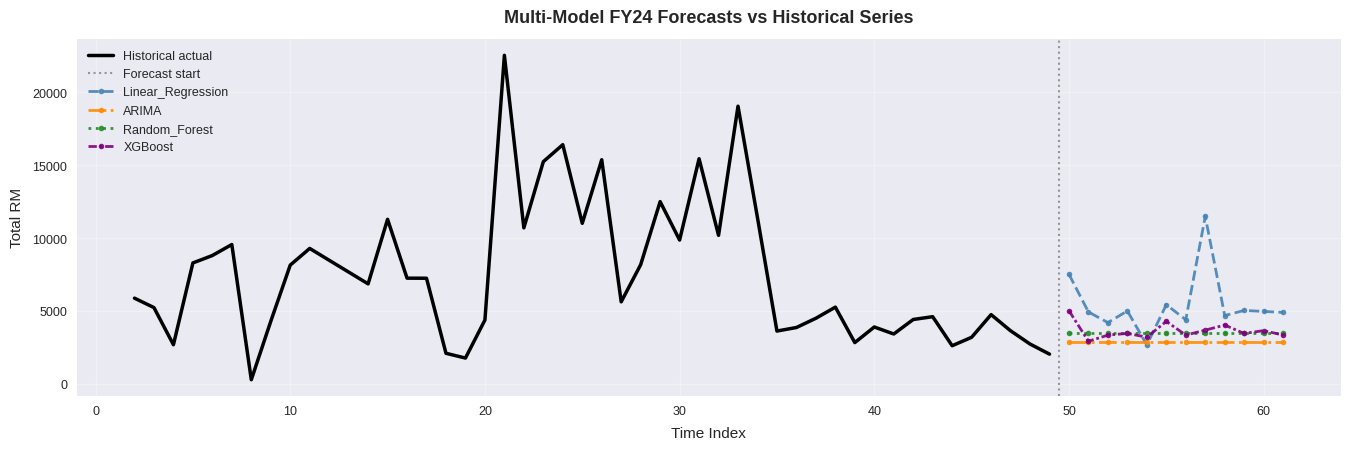

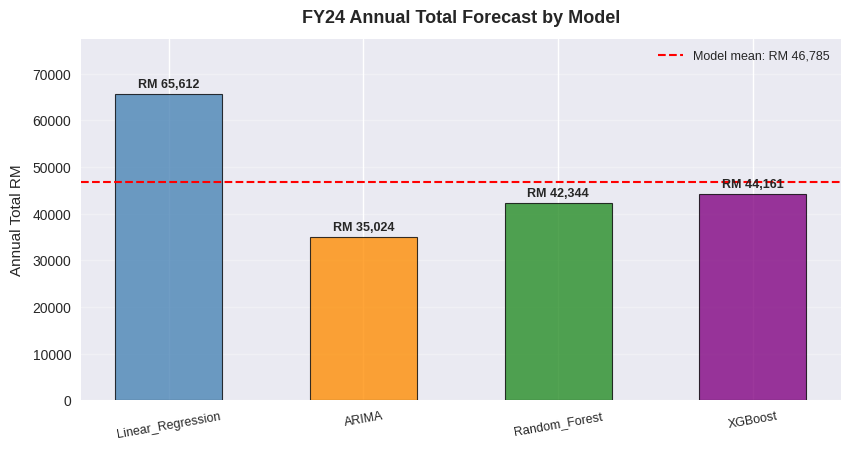

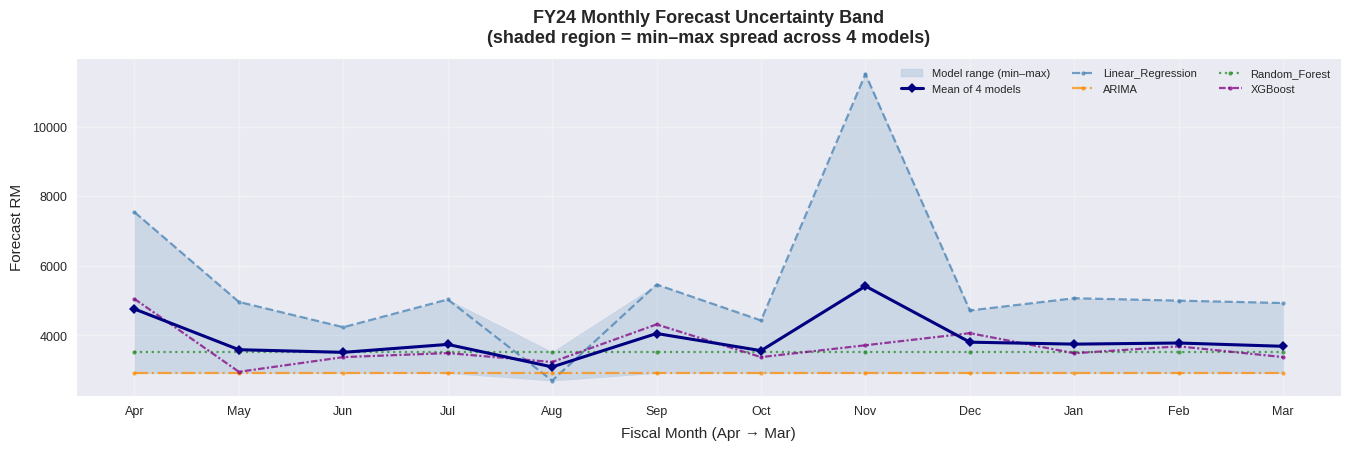


Block 14 complete.
  Production models : ['Linear_Regression', 'ARIMA', 'Random_Forest', 'XGBoost']
  Audit-only models : ['Linear_Enhanced']
  Forecast horizon  : 12 months (FY2024)

  Annual forecast range (production models):
    ARIMA               RM       35,024
    Random_Forest       RM       42,344
    XGBoost             RM       44,161
    Linear_Regression   RM       65,612

    Planning range   :  RM 35,024  –  RM 65,612
    Central estimate :  RM 46,785

Key outputs for Block 15:
  production_models — fitted model objects (includes audit-only models)
  model_forecasts   — monthly arrays for PRODUCTION_MODELS only
  annual            — annual total per production model
  fc_df             — FY24 forecast feature matrix
  PRODUCTION_MODELS — list of model names for Block 15 validation loop


In [28]:
# Block 14: Multi-Model Production Forecasting Comparison
# Generate FY24 forecasts with all validated models and comprehensive comparison

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# 1. UNIFIED TRAINING DATASET
# =============================================================================
# All production models are trained on the same dataset to ensure that
# differences in forecast output are attributable to model architecture rather
# than differences in training data coverage.
#
# FY2020 is excluded: only 2 months of data (post-MCO restart), which would
# bias seasonal and trend estimates for every subsequent model.
#
# FY is re-derived from Claimed Month as a defensive check against edge-case
# rows near FY boundaries that have occasionally had mismatched column values.

unified_data = modeling_datasets["standard"].copy()
unified_data["FY"] = unified_data["Claimed Month"].apply(
    lambda x: int(str(x)[:4]) if int(str(x)[4:6]) >= 4 else int(str(x)[:4]) - 1
)

train_df = unified_data[unified_data["FY"] != 2020].copy().reset_index(drop=True)
y_train  = train_df["Total_RM"].copy()

print(f"Unified training dataset: {len(train_df)} observations")
print(f"Fiscal years            : {sorted(train_df['FY'].unique())}")
print(f"Date range              : {train_df['Date_Label'].iloc[0]} – {train_df['Date_Label'].iloc[-1]}")

META_COLS = ["Claimed Month", "Date_Label", "Time_Index", "Total_RM", "FY", "Fiscal_Year"]

# =============================================================================
# 2. PRODUCTION MODEL SCOPE
# =============================================================================
# Two models are excluded from production forecasting after evaluation:
#
#   Ensemble (dropped):
#     Equal-weight averaging only adds value when component model errors are
#     uncorrelated. All five models here share the same root failure — 46
#     observations for a high-dimensional feature matrix — so their errors
#     are highly correlated. The "benefit" in Block 12 was accidental
#     arithmetic cancellation between Linear_Enhanced's negative forecasts
#     and the over-predicting models, not genuine signal combination.
#     Dropping it avoids a misleading "primary planning figure" label on
#     an output that has no statistical basis for being preferred.
#
#   Linear_Enhanced (dropped from production — retained in audit section):
#     Produced negative monthly forecasts for 9 of 12 FY2024 months.
#     The cause is coefficient extrapolation collapse: the FY dummy variables
#     and Time_Linear are near-perfectly collinear in training (each FY dummy
#     covers a specific range of Time_Linear values). For FY2024 — a year not
#     seen in training with all FY dummies set to 0 — the time trend component
#     extrapolates far beyond its training range and produces implausible
#     negative costs. This is a model architecture failure, not a data issue.
#     The model is retained in the audit section below so its failure is
#     documented and visible, but it is excluded from planning outputs.
#
# Production models (4):
#   Linear_Regression, ARIMA, Random_Forest, XGBoost
#
# Note on naming: the model was previously called Linear_Basic to distinguish
# it from Linear_Enhanced. With Linear_Enhanced dropped from production, the
# remaining linear model is simply named Linear_Regression — the accurate
# description of its algorithm (OLS on Time_Linear + FM dummies).

PRODUCTION_MODELS = ["Linear_Regression", "ARIMA", "Random_Forest", "XGBoost"]
AUDIT_MODELS      = ["Linear_Enhanced"]   # trained but excluded from planning

print(f"\nProduction models : {PRODUCTION_MODELS}")
print(f"Audit-only models : {AUDIT_MODELS}  (trained for documentation; excluded from planning)")

# =============================================================================
# 3. FEATURE SETS
# =============================================================================
# Feature sets are constructed dynamically from column names present in
# train_df to avoid KeyErrors if upstream blocks produced a different column
# set than expected.
#
# linear_regression — Time_Linear + FM dummies only. Minimal dimensionality;
#                     safest for linear models on a short series. Renamed from
#                     linear_basic now that linear_enhanced is audit-only.
# linear_enhanced — adds FY dummies, COVID flag, proportion features.
#                   Retained only for the audit section.
# tree_based      — full 'standard' set; tree models handle high dimensionality
#                   internally via feature selection at splits.
# tree_xgb        — same as tree_based but capped at 15 features to limit
#                   overfitting on the 46-observation training set.

def _select_cols(patterns, df, exclude=META_COLS, max_n=None):
    cols = [c for c in df.columns
            if any(p in c for p in patterns) and c not in exclude]
    return cols[:max_n] if max_n else cols

FEATURE_SETS = {
    "linear_regression": _select_cols(["Time_Linear", "FM_"], train_df, max_n=10),
    "linear_enhanced":   _select_cols(["Time_", "FM_", "FY_", "COVID_Impact", "prop_"], train_df),
    "tree_based":        _select_cols(["Time_", "FM_", "FY_", "COVID_Impact", "prop_",
                                       "lag", "rolling", "growth"], train_df),
    "tree_xgb":          _select_cols(["Time_", "FM_", "FY_", "COVID_Impact", "prop_",
                                       "lag", "rolling", "growth"], train_df, max_n=15),
}

print("\nFeature sets:")
for name, cols in FEATURE_SETS.items():
    print(f"  {name:<18}  {len(cols)} features")

# =============================================================================
# 4. TRAIN ALL MODELS
# =============================================================================
# Missing values: filled with column median for tree models (0 would be
# implausible for continuous lag/rolling features); filled with 0 for linear
# models (binary dummies dominate and 0 is the correct absent-category value).
#
# XGBoost receives StandardScaler-transformed features — L1/L2 penalties are
# dimensionally consistent across features only when features are on the same
# scale. See Block 11 Section 1 for full rationale.

production_models = {}
in_sample_perf    = {}

def _record_perf(name, y_true, y_pred, n_feats):
    ss_res = ((y_true - y_pred) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    in_sample_perf[name] = dict(
        r2         = float(1 - ss_res / ss_tot),
        rmse       = float(np.sqrt(mean_squared_error(y_true, y_pred))),
        mape       = float(mean_absolute_percentage_error(y_true, y_pred) * 100),
        n_features = n_feats,
    )

# --- Model 1: Linear Regression ---
X_lr = train_df[FEATURE_SETS["linear_regression"]].fillna(0)
m_lr = LinearRegression().fit(X_lr, y_train)
production_models["Linear_Regression"] = dict(model=m_lr, X_train=X_lr,
                                               feature_set="linear_regression")
_record_perf("Linear_Regression", y_train, m_lr.predict(X_lr),
             len(FEATURE_SETS["linear_regression"]))

# --- Model 2: Linear Enhanced (audit only — excluded from planning) ---
# Trained here so its failure is documented; not included in model_forecasts.
X_le = train_df[FEATURE_SETS["linear_enhanced"]].fillna(0)
m_le = LinearRegression().fit(X_le, y_train)
production_models["Linear_Enhanced"] = dict(model=m_le, X_train=X_le,
                                             feature_set="linear_enhanced",
                                             audit_only=True)
_record_perf("Linear_Enhanced", y_train, m_le.predict(X_le),
             len(FEATURE_SETS["linear_enhanced"]))

# --- Model 3: ARIMA ---
# Order selection: use best_overall_params from Block 9 if available and valid.
# FIX: original condition was `not isinstance(best_overall_params, tuple)` which
# always fell through to the default because best_overall_params IS a tuple.
# Corrected to `isinstance(best_overall_params, tuple)`.
try:
    arima_order = best_overall_params if isinstance(best_overall_params, tuple) \
                  else (0, 1, 1)
except NameError:
    arima_order = (0, 1, 1)

print(f"\nARIMA order: {arima_order}  "
      f"({'from Block 9' if arima_order != (0, 1, 1) else 'default fallback (0,1,1)'})")

try:
    arima_fit = ARIMA(y_train.values, order=arima_order).fit()
    production_models["ARIMA"] = dict(model=arima_fit, X_train=None,
                                      feature_set=None)
    fv   = arima_fit.fittedvalues
    mask = ~np.isnan(fv)
    _record_perf("ARIMA", y_train.values[mask], fv[mask], 1)
    print(f"ARIMA trained  |  valid fitted values: {mask.sum()} / {len(y_train)}")

except Exception as e:
    print(f"ARIMA training failed: {e}")
    production_models["ARIMA"] = None
    in_sample_perf["ARIMA"] = dict(r2=np.nan, rmse=np.nan, mape=np.nan, n_features=1)

# --- Model 4: Random Forest (conservative) ---
# Conservative parameterisation from Block 12 is used rather than the
# best-tuned RF from Block 10, because Block 10 showed OOB R² << in-sample R²
# (severe overfitting). The conservative version generalises better, which
# is what matters for out-of-sample forecasting.
train_median_rf = train_df[FEATURE_SETS["tree_based"]].median()
X_rf = train_df[FEATURE_SETS["tree_based"]].fillna(train_median_rf)
m_rf = RandomForestRegressor(n_estimators=20, max_depth=5,
                              min_samples_split=5, min_samples_leaf=3,
                              random_state=42, n_jobs=-1).fit(X_rf, y_train)
production_models["Random_Forest"] = dict(model=m_rf, X_train=X_rf,
                                           feature_set="tree_based")
_record_perf("Random_Forest", y_train, m_rf.predict(X_rf),
             len(FEATURE_SETS["tree_based"]))

# --- Model 5: XGBoost (conservative regularisation) ---
# Best params from Block 11 are used if available; otherwise conservative default.
try:
    xgb_init = best_params   # from Block 11
except NameError:
    xgb_init = dict(n_estimators=10, max_depth=2, learning_rate=0.3,
                    reg_alpha=2.0, reg_lambda=2.0,
                    subsample=0.8, colsample_bytree=0.8,
                    random_state=42, verbosity=0, n_jobs=-1)

train_median_xgb = train_df[FEATURE_SETS["tree_xgb"]].median()
X_xgb_raw = train_df[FEATURE_SETS["tree_xgb"]].fillna(train_median_xgb)
xgb_scaler = StandardScaler()
X_xgb = pd.DataFrame(xgb_scaler.fit_transform(X_xgb_raw),
                      columns=FEATURE_SETS["tree_xgb"], index=X_xgb_raw.index)
m_xgb = XGBRegressor(**xgb_init).fit(X_xgb, y_train)
production_models["XGBoost"] = dict(model=m_xgb, X_train=X_xgb,
                                    feature_set="tree_xgb", scaler=xgb_scaler)
_record_perf("XGBoost", y_train, m_xgb.predict(X_xgb),
             len(FEATURE_SETS["tree_xgb"]))

# --- In-sample performance table ---
# WARNING printed directly in output because in-sample R² is inflated by
# overfitting on the 46-observation training set. The OOB score from Block 10
# is the realistic generalisation estimate for Random Forest; CV R² from
# Block 11 is the equivalent for XGBoost. Never use in-sample R² to rank
# models or select the best model for production.

print(f"\n--- In-sample performance ---")
print(f"  *** WARNING: in-sample R² is inflated by overfitting on {len(train_df)} observations.")
print(f"  *** Do NOT use these figures for model selection.")
print(f"  *** Refer to Block 10 OOB R² (RF) and Block 11 CV out-sample R² (XGB).")
print(f"  {'Model':<18}  {'R² (overfit)':>13}  {'RMSE':>10}  {'MAPE%':>7}  {'Features':>9}")
print("  " + "-" * 65)
for name, perf in in_sample_perf.items():
    tag = "  [AUDIT ONLY]" if name in AUDIT_MODELS else ""
    print(f"  {name:<18}  {perf['r2']:>13.4f}  {perf['rmse']:>10.2f}  "
          f"{perf['mape']:>7.1f}  {perf['n_features']:>9}{tag}")

# =============================================================================
# 5. FY24 FORECAST FEATURE MATRIX
# =============================================================================
# The forecast feature matrix replicates the training feature structure for
# the 12 months of FY2024 (April 2024 – March 2025).
#
# Key decisions per feature type:
#
#   Time_Linear / Time_Squared:
#     Integer sequence continues from the last training index. Resetting to 1
#     would imply the series returns to its starting level — incorrect.
#
#   FM_* dummies:
#     Computed from each forecast month's fiscal month number.
#     FM_12 (March) is the reference category — all its dummies are 0, so
#     March is predicted from intercept and trend alone.
#
#   FY_* dummies:
#     All set to 0 for FY2024. FY2024 is therefore the reference/baseline
#     year — the correct approach because the model has never seen FY2024.
#     Setting FY_2024=1 would require it to have been in training.
#
#   COVID_Impact: 0 — MCO not expected to recur.
#
#   Proportion features (prop_*):
#     Set to FY2023 monthly average. Most recently completed FY is the
#     best available proxy for the expected vehicle mix in FY2024. If a
#     known model launch or discontinuation is planned, adjust manually.
#
#   Lag and rolling features — KNOWN LIMITATION:
#     Initialised from the last training observation (static). In production,
#     lag1 for May 2024 should use the April 2024 forecast value, and so on
#     for each subsequent month. This sequential one-step-ahead update is not
#     implemented here — all 12 months share the same frozen lag/rolling state.
#     Consequence: RF and XGBoost are predicting from an unrepresentative
#     feature state, which is a contributing cause of their near-constant
#     out-of-sample output. This is documented and accepted as a current
#     limitation to be resolved in the next project iteration.

last_time_idx = int(train_df["Time_Index"].max())

FY24_MONTHS = [202404, 202405, 202406, 202407, 202408, 202409,
               202410, 202411, 202412, 202501, 202502, 202503]

FM_NAMES = {1:"Apr", 2:"May", 3:"Jun", 4:"Jul",  5:"Aug",  6:"Sep",
            7:"Oct", 8:"Nov", 9:"Dec", 10:"Jan", 11:"Feb", 12:"Mar"}

rows = []
for step, ym in enumerate(FY24_MONTHS, start=1):
    yr  = int(str(ym)[:4])
    mo  = int(str(ym)[4:6])
    fm  = (mo - 4) % 12 + 1
    ti  = last_time_idx + step
    row = dict(Claimed_Month=ym, Date_Label=f"{yr}-{mo:02d}",
               Fiscal_Month=fm, Time_Index=ti, Time_Linear=ti,
               Time_Squared=ti ** 2, COVID_Impact=0)
    for fm_i in range(1, 12):
        row[f"FM_{fm_i}"] = int(fm == fm_i)
    for col in train_df.columns:
        if col.startswith("FY_"):
            row[col] = 0
    rows.append(row)

fc_df = pd.DataFrame(rows)

fy23      = train_df[train_df["FY"] == 2023]
prop_cols = [c for c in FEATURE_SETS["tree_based"] if c.startswith("prop_")]
for col in prop_cols:
    fc_df[col] = fy23[col].mean() if col in fy23.columns else 0

for col in [c for c in FEATURE_SETS["tree_based"] if "lag" in c or "rolling" in c]:
    if col in train_df.columns:
        fc_df[col] = train_df[col].iloc[-1]   # static — see limitation note above

print(f"\nFY24 forecast matrix: {fc_df.shape}")

# =============================================================================
# 6. GENERATE FORECASTS  (production models only)
# =============================================================================
# Linear_Enhanced is excluded from model_forecasts to prevent it from
# appearing in any planning output, chart, or table. It is generated
# separately in the audit section below for documentation purposes only.

model_forecasts = {}

def _fc_X(feature_set_key, fillval=0):
    """Return forecast feature matrix aligned to training column order."""
    cols = FEATURE_SETS[feature_set_key]
    X    = fc_df[[c for c in cols if c in fc_df.columns]].copy()
    for c in cols:
        if c not in X.columns:
            X[c] = fillval
    return X[cols]

# Linear Regression
model_forecasts["Linear_Regression"] = production_models["Linear_Regression"]["model"].predict(
    _fc_X("linear_regression"))

# ARIMA — 12-step ahead from end of training series
if production_models["ARIMA"] is not None:
    try:
        fc_arima = production_models["ARIMA"]["model"].forecast(steps=12)
        model_forecasts["ARIMA"] = fc_arima.values if hasattr(fc_arima, "values") \
                                   else np.array(fc_arima)
    except Exception as e:
        print(f"ARIMA forecast failed ({e}) — using recent linear trend fallback.")
        recent = y_train.values[-6:]
        trend  = np.mean(np.diff(recent)) if len(recent) > 1 else 0
        model_forecasts["ARIMA"] = y_train.values[-1] + trend * np.arange(1, 13)
else:
    model_forecasts["ARIMA"] = np.full(12, y_train.mean())

# Random Forest
X_fc_rf = _fc_X("tree_based").fillna(train_median_rf)
model_forecasts["Random_Forest"] = production_models["Random_Forest"]["model"].predict(X_fc_rf)

# XGBoost
X_fc_xgb = pd.DataFrame(
    xgb_scaler.transform(_fc_X("tree_xgb").fillna(train_median_xgb)),
    columns=FEATURE_SETS["tree_xgb"])
model_forecasts["XGBoost"] = production_models["XGBoost"]["model"].predict(X_fc_xgb)

# --- Audit section: Linear_Enhanced forecast (excluded from planning) ---
X_fc_le = _fc_X("linear_enhanced")
fc_linear_enhanced = production_models["Linear_Enhanced"]["model"].predict(X_fc_le)
audit_note_le = (
    f"Linear_Enhanced: {(fc_linear_enhanced < 0).sum()} / 12 months are negative "
    f"(min = RM {fc_linear_enhanced.min():,.0f}). "
    f"Excluded from all planning outputs."
)
print(f"\n[AUDIT] {audit_note_le}")

# =============================================================================
# 7. MONTHLY FORECAST TABLE  (production models)
# =============================================================================

print("\n" + "=" * 80)
print(f"{'FY24 MONTHLY FORECAST — PRODUCTION MODELS':^80}")
print("=" * 80)
print(f"  {'Month':<10}  {'Linear Reg':>11}  {'ARIMA':>11}  "
      f"{'Rand. Forest':>13}  {'XGBoost':>11}")
print("  " + "-" * 62)

month_labels = []
for i, ym in enumerate(FY24_MONTHS):
    yr  = int(str(ym)[:4])
    mo  = int(str(ym)[4:6])
    fm  = (mo - 4) % 12 + 1
    lbl = f"{FM_NAMES[fm]} {yr}"
    month_labels.append(lbl)
    vals = [model_forecasts[m][i] for m in PRODUCTION_MODELS]
    print(f"  {lbl:<10}  " + "  ".join(f"{v:>11,.0f}" for v in vals))

print("  " + "-" * 62)
annual = {m: float(np.sum(model_forecasts[m])) for m in model_forecasts}
annual_vals = [annual[m] for m in PRODUCTION_MODELS]
print(f"  {'ANNUAL':.<10}  " + "  ".join(f"{v:>11,.0f}" for v in annual_vals))

# =============================================================================
# 8. ANNUAL SUMMARY
# =============================================================================

print(f"\n--- Annual forecast summary (production models) ---")
print(f"  {'Model':<18}  {'Annual RM':>12}  {'Monthly Avg':>12}  "
      f"{'Min':>10}  {'Max':>10}  {'Range':>10}")
print("  " + "-" * 80)
for name in PRODUCTION_MODELS:
    fc = model_forecasts[name]
    print(f"  {name:<18}  {np.sum(fc):>12,.0f}  {np.mean(fc):>12,.0f}  "
          f"{np.min(fc):>10,.0f}  {np.max(fc):>10,.0f}  "
          f"{np.max(fc) - np.min(fc):>10,.0f}")

# =============================================================================
# 9. BUSINESS PLANNING RANGE
# =============================================================================
# Without the Ensemble and Linear_Enhanced, the planning range is defined
# by the min and max annual totals across the four production models only.
# The spread remains the primary uncertainty measure: if the four models
# disagree widely, the business should use the midpoint as the planning
# anchor and widen the contingency budget accordingly.

annual_vals_prod = [annual[m] for m in PRODUCTION_MODELS]

print(f"\n--- Business planning range ---")
print(f"  Conservative (lowest model)  : RM {min(annual_vals_prod):>12,.0f}")
print(f"  Central (mean of 4 models)   : RM {np.mean(annual_vals_prod):>12,.0f}")
print(f"  Optimistic (highest model)   : RM {max(annual_vals_prod):>12,.0f}")
print(f"  Uncertainty spread           : RM {max(annual_vals_prod) - min(annual_vals_prod):>12,.0f}")

print(f"\n  Monitoring recommendations:")
print(f"    - Compare actual monthly costs against all four model forecasts.")
print(f"    - Months where ≥3 models agree on direction are high-confidence signals.")
print(f"    - Retrain each quarter with newly closed months.")
print(f"    - Trigger model review if two consecutive actuals fall outside the range.")

# =============================================================================
# 10. VISUALISATIONS
# =============================================================================
# Three separate figures (1×1 each):
#   Figure 1 — Historical series + FY24 forecast lines
#   Figure 2 — Annual total bar chart
#   Figure 3 — Monthly forecast uncertainty band (shaded min–max)
#
# Linear_Enhanced and Ensemble are absent from all figures.
# Model colours are consistent with Blocks 11–13.

MODEL_COLORS = {
    "Linear_Regression": "steelblue",
    "ARIMA":             "darkorange",
    "Random_Forest":     "forestgreen",
    "XGBoost":           "purple",
}
MODEL_STYLES = {
    "Linear_Regression": "--",
    "ARIMA":             "-.",
    "Random_Forest":     ":",
    "XGBoost":           (0, (3, 1, 1, 1)),   # densely dashdotted — distinct from RF
}

fc_time  = list(range(last_time_idx + 1, last_time_idx + 13))
fm_ticks = list(range(1, 13))
fm_xlbls = [FM_NAMES[i] for i in fm_ticks]

# =============================================================================
# Figure 1: Historical series + FY24 forecast lines
# =============================================================================
# The vertical dotted line marks the training/forecast boundary.
# Divergence between model lines in the forecast region represents forecast
# uncertainty — a wide spread signals low model agreement.

fig1, ax1 = plt.subplots(figsize=(14, 5))
ax1.plot(train_df["Time_Index"], y_train,
         color="black", linewidth=2.5, label="Historical actual", zorder=6)
ax1.axvline(last_time_idx + 0.5, color="grey", linestyle=":",
            linewidth=1.5, alpha=0.8, label="Forecast start")
for name in PRODUCTION_MODELS:
    ax1.plot(fc_time, model_forecasts[name],
             color=MODEL_COLORS[name], linestyle=MODEL_STYLES[name],
             linewidth=2.0, marker="o", markersize=4, label=name, alpha=0.9)
ax1.set_xlabel("Time Index", labelpad=6)
ax1.set_ylabel("Total RM", labelpad=6)
ax1.set_title("Multi-Model FY24 Forecasts vs Historical Series",
              fontsize=13, fontweight="bold", pad=12)
ax1.legend(fontsize=9, loc="upper left")
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis="both", labelsize=9)
plt.tight_layout(pad=2.5)
plt.show()

# =============================================================================
# Figure 2: Annual total bar chart
# =============================================================================
# Bar height = annual forecast total per model. The red dashed line marks
# the cross-model mean as a central planning anchor. The spread of bar
# heights is the primary visual measure of forecast uncertainty.

fig2, ax2 = plt.subplots(figsize=(9, 5))
bar_names = PRODUCTION_MODELS
bar_vals  = [annual[n] for n in bar_names]
bar_cols  = [MODEL_COLORS[n] for n in bar_names]
bars = ax2.bar(bar_names, bar_vals, color=bar_cols,
               alpha=0.78, edgecolor="black", linewidth=0.8, width=0.55)
for bar, val in zip(bars, bar_vals):
    ax2.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + max(bar_vals) * 0.012,
             f"RM {val:,.0f}", ha="center", va="bottom",
             fontsize=9, fontweight="bold")
ax2.axhline(np.mean(bar_vals), color="red", linestyle="--",
            linewidth=1.5, label=f"Model mean: RM {np.mean(bar_vals):,.0f}")
ax2.set_ylabel("Annual Total RM", labelpad=6)
ax2.set_title("FY24 Annual Total Forecast by Model",
              fontsize=13, fontweight="bold", pad=12)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis="y")
ax2.tick_params(axis="x", labelsize=9, rotation=10)
ax2.set_ylim(0, max(bar_vals) * 1.18)
plt.tight_layout(pad=2.5)
plt.show()

# =============================================================================
# Figure 3: Monthly forecast spread — shaded uncertainty band
# =============================================================================
# The shaded region spans the min-to-max forecast across the four models
# for each fiscal month. A narrow band = high model agreement (more reliable
# month for procurement); a wide band = high uncertainty (widen provision).
# The navy diamond line is the unweighted mean across all four models.

fc_matrix = np.vstack([model_forecasts[n] for n in PRODUCTION_MODELS])
fc_min    = fc_matrix.min(axis=0)
fc_max    = fc_matrix.max(axis=0)
fc_mean   = fc_matrix.mean(axis=0)

fig3, ax3 = plt.subplots(figsize=(14, 5))
ax3.fill_between(fm_ticks, fc_min, fc_max,
                 alpha=0.18, color="steelblue", label="Model range (min–max)")
ax3.plot(fm_ticks, fc_mean, color="navy", linewidth=2.2,
         marker="D", markersize=5, label="Mean of 4 models", zorder=5)
for name in PRODUCTION_MODELS:
    ax3.plot(fm_ticks, model_forecasts[name],
             color=MODEL_COLORS[name], linestyle=MODEL_STYLES[name],
             linewidth=1.6, alpha=0.75, marker="o", markersize=3,
             label=name)
ax3.set_xticks(fm_ticks)
ax3.set_xticklabels(fm_xlbls, rotation=0, ha="center", fontsize=9)
ax3.set_xlabel("Fiscal Month (Apr → Mar)", labelpad=6)
ax3.set_ylabel("Forecast RM", labelpad=6)
ax3.set_title("FY24 Monthly Forecast Uncertainty Band\n"
              "(shaded region = min–max spread across 4 models)",
              fontsize=13, fontweight="bold", pad=12)
ax3.legend(fontsize=8, loc="upper right", ncol=3)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis="both", labelsize=9)
plt.tight_layout(pad=2.5)
plt.show()

# =============================================================================
# 11. HANDOFF SUMMARY
# =============================================================================
print("\nBlock 14 complete.")
print(f"  Production models : {PRODUCTION_MODELS}")
print(f"  Audit-only models : {AUDIT_MODELS}")
print(f"  Forecast horizon  : 12 months (FY2024)")
print(f"\n  Annual forecast range (production models):")
for name in sorted(PRODUCTION_MODELS, key=lambda n: annual[n]):
    print(f"    {name:<18}  RM {annual[name]:>12,.0f}")
print(f"\n    Planning range   :  RM {min(annual_vals_prod):,.0f}  –  "
      f"RM {max(annual_vals_prod):,.0f}")
print(f"    Central estimate :  RM {np.mean(annual_vals_prod):,.0f}")
print(f"\nKey outputs for Block 15:")
print(f"  production_models — fitted model objects (includes audit-only models)")
print(f"  model_forecasts   — monthly arrays for PRODUCTION_MODELS only")
print(f"  annual            — annual total per production model")
print(f"  fc_df             — FY24 forecast feature matrix")
print(f"  PRODUCTION_MODELS — list of model names for Block 15 validation loop")



# [5.2] Forecast Validation

Running in Google Colab — please upload the FY24 CSV file.


Saving fy24_warranty_claims.csv to fy24_warranty_claims.csv
Loaded with encoding: utf-8

Raw FY24 dataset: 374 rows × 49 columns
Date range (Claimed Month): 202404 – 202503
Memory: 0.69 MB

--- Accept/Reject status distribution ---
  ACC        351  (93.9%)
  OVER WARRANTY      23  (6.1%)

--- RM column assessment ---
  dtype       : float64
  non-null    : 374 / 374
  missing     : 0
  range       : 10.47 – 423.08
  mean/median : 92.42 / 29.16

--- Accepted claims filter ---
  Raw rows              :      374
  After ACC filter      :      351  (93.9%)
  After RM null removal :      351
  Excluded              :       23

--- Fiscal year distribution ---
  FY2024: 351 claims

--- Monthly aggregation ---
  Months in dataset : 12
  Date range        : 2024-04 – 2025-03

--- FY24 coverage ---
  Expected months  : 12
  Available months : 12

--- FY24 actual monthly summary ---
  Month        FM    Claims      Total RM     Mean RM
  --------------------------------------------------
  Apr 

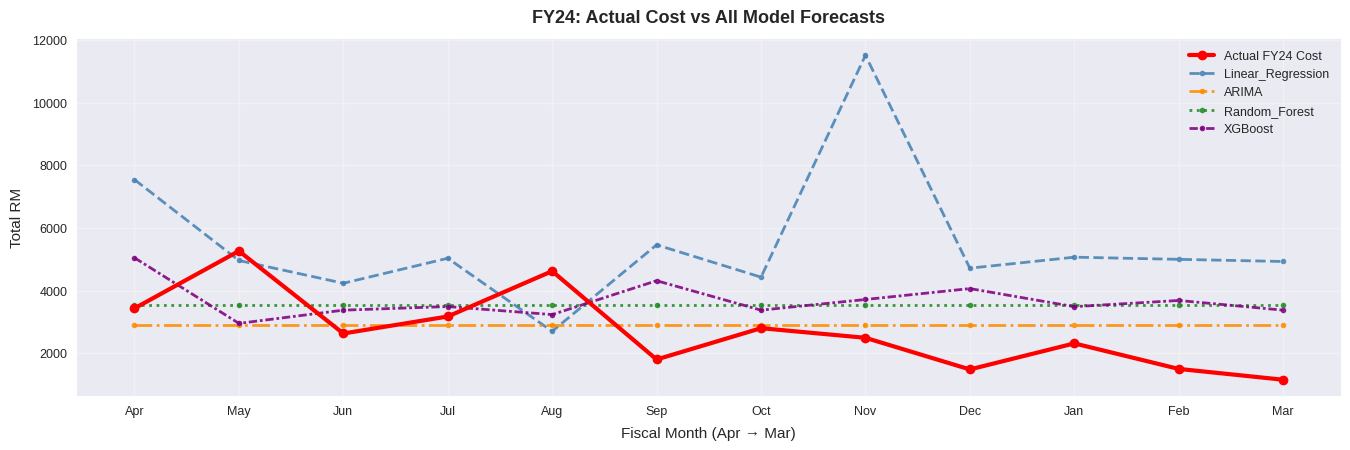

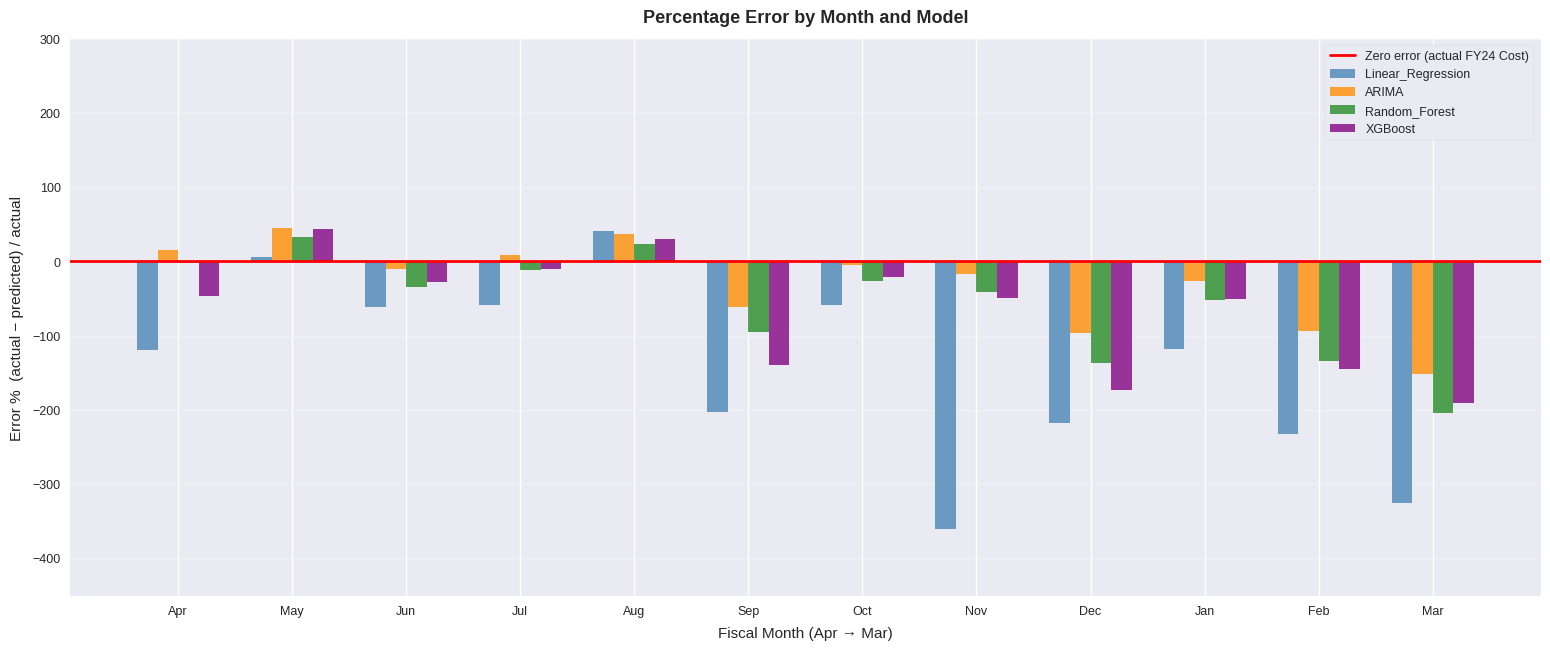

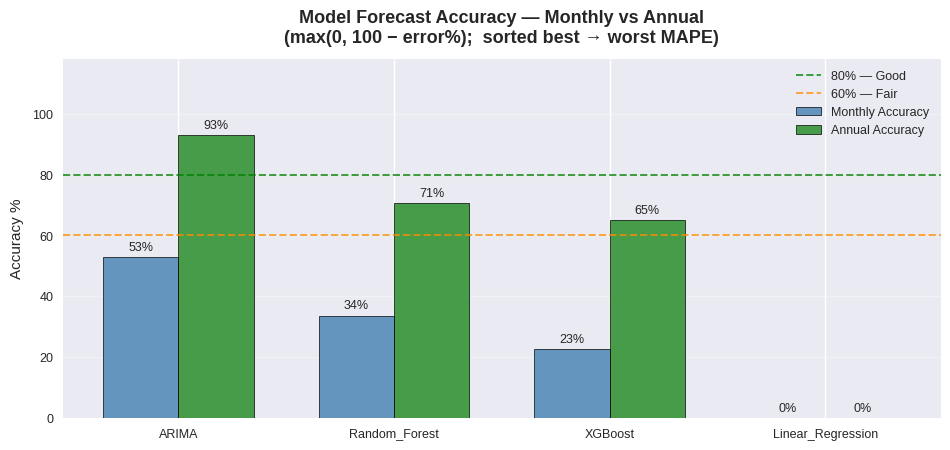

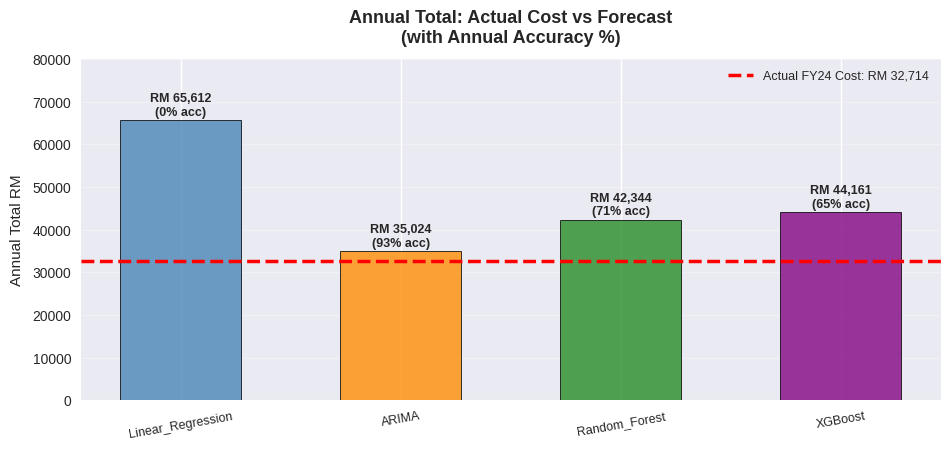


Processed FY24 monthly data saved: fy24_monthly_actual.csv

Block 15 complete.
  Months validated    : 12 / 12
  Actual annual RM    : RM 32,713.77

  Model ranking by MAPE:
    1. ARIMA               MAPE = 47.2%  Dir = 0.0%  Ann err = -7.1%
    2. Random_Forest       MAPE = 66.3%  Dir = 0.0%  Ann err = -29.4%
    3. XGBoost             MAPE = 77.4%  Dir = 18.2%  Ann err = -35.0%
    4. Linear_Regression   MAPE = 150.1%  Dir = 54.5%  Ann err = -100.6%

  Model accuracy summary:
  Model                Monthly Acc   Annual Acc   Grade
  --------------------------------------------------------
  ARIMA                      52.8%        92.9%    Good
  Random_Forest              33.7%        70.6%    Fair
  XGBoost                    22.6%        65.0%    Fair
  Linear_Regression           0.0%         0.0%    Poor

  Best model: ARIMA
    Monthly accuracy : 52.8%
    Annual accuracy  : 92.9%
    Grade            : Good

Key outputs:
  fy24_actual        — monthly actual data (DataFrame)


In [29]:
# Block 15: Forecast Validation — FY Actual vs Forecast Comparison
# Process actual FY warranty claims and validate all production model forecasts.
#
# Production model scope (inherited from Block 14):
#   Linear_Regression, ARIMA, Random_Forest, XGBoost
#   Ensemble and Linear_Enhanced were dropped in Block 14 — not present in
#   model_forecasts and not referenced anywhere in this block.

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# =============================================================================
# 1. LOAD FY24 ACTUAL DATA
# =============================================================================
# The actual FY data is a raw claim-level export from the warranty system,
# identical in schema to the data loaded in Block 1. Processing mirrors
# Blocks 1–3 exactly so the comparison is on the same basis (ACC claims,
# RM target, April–March fiscal calendar).
#
# Why not reuse df_clean from Block 1:
#   df_clean covers the historical training period only. FY24 data was not
#   available at model training time and must be loaded separately. Applying
#   the same cleaning pipeline ensures no methodological gap between
#   training-time and validation-time data.
#
# Environment handling:
#   COLAB_GPU is present in all Google Colab sessions regardless of whether
#   a GPU runtime is active — the most reliable Colab detection signal.

COLAB = "COLAB_GPU" in os.environ

if COLAB:
    from google.colab import files
    print("Running in Google Colab — please upload the FY24 CSV file.")
    uploaded  = files.upload()
    DATA_PATH = next(iter(uploaded))
else:
    DATA_PATH = "fy24_warranty_claims.csv"
    print(f"Running locally — loading from: {DATA_PATH}")

# Encoding loop: Perodua exports are typically CP1252 (Windows-1252).
# UTF-8 and ISO-8859-1 are tried first as more portable options.
# errors='replace' is the last resort — replacement characters in RM rows
# are caught by the pd.to_numeric coercion below.
ENCODINGS = ["utf-8", "cp1252", "latin-1", "iso-8859-1"]
fy24_raw  = None

for enc in ENCODINGS:
    try:
        fy24_raw = pd.read_csv(DATA_PATH, encoding=enc)
        print(f"Loaded with encoding: {enc}")
        break
    except UnicodeDecodeError:
        continue

if fy24_raw is None:
    fy24_raw = pd.read_csv(DATA_PATH, encoding="utf-8", errors="replace")
    print("Loaded with UTF-8 + replacement characters (check for data quality issues).")

# Coerce RM immediately after load so '#REF!' errors become NaN rather than
# crashing the aggregation in Section 5.
fy24_raw["RM"] = pd.to_numeric(fy24_raw["RM"], errors="coerce")

print(f"\nRaw FY24 dataset: {fy24_raw.shape[0]:,} rows × {fy24_raw.shape[1]} columns")
print(f"Date range (Claimed Month): "
      f"{fy24_raw['Claimed Month'].min()} – {fy24_raw['Claimed Month'].max()}")
print(f"Memory: {fy24_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# =============================================================================
# 2. DATA QUALITY ASSESSMENT
# =============================================================================
# The same quality checks applied in Block 2 are repeated here to confirm
# the FY24 export has the same structure as the historical data. New status
# codes or renamed columns introduced in the source system will surface here
# before they silently distort validation metrics.

print("\n--- Accept/Reject status distribution ---")
status_counts = fy24_raw["Accept/Reject status"].value_counts()
for status, n in status_counts.items():
    print(f"  {status:<6}  {n:>6,}  ({n / len(fy24_raw) * 100:.1f}%)")

print("\n--- RM column assessment ---")
print(f"  dtype       : {fy24_raw['RM'].dtype}")
print(f"  non-null    : {fy24_raw['RM'].count():,} / {len(fy24_raw):,}")
print(f"  missing     : {fy24_raw['RM'].isnull().sum():,}")
if fy24_raw["RM"].count() > 0:
    print(f"  range       : {fy24_raw['RM'].min():.2f} – {fy24_raw['RM'].max():.2f}")
    print(f"  mean/median : {fy24_raw['RM'].mean():.2f} / {fy24_raw['RM'].median():.2f}")

# =============================================================================
# 3. ACCEPTED CLAIMS FILTER
# =============================================================================
# The production forecast was trained exclusively on ACC (accepted) claims.
# The identical filter must be applied here — including REJ claims would
# inflate the actual cost total and make all forecasts appear to under-predict.
#
# RM null removal: rows with null RM cannot contribute to a cost total.
# Removed rather than imputed — the actual cost is genuinely unknown and
# imputing the median would misrepresent true liability.

fy24_acc       = fy24_raw[fy24_raw["Accept/Reject status"] == "ACC"].copy()
n_after_status = len(fy24_acc)
fy24_acc       = fy24_acc[fy24_acc["RM"].notna()].copy()
n_after_rm     = len(fy24_acc)

print(f"\n--- Accepted claims filter ---")
print(f"  Raw rows              : {len(fy24_raw):>8,}")
print(f"  After ACC filter      : {n_after_status:>8,}  "
      f"({n_after_status / len(fy24_raw) * 100:.1f}%)")
print(f"  After RM null removal : {n_after_rm:>8,}")
print(f"  Excluded              : {len(fy24_raw) - n_after_rm:>8,}")

# =============================================================================
# 4. FISCAL YEAR MAPPING
# =============================================================================
# Identical to Block 3: April–March fiscal year, April = FM1, March = FM12.
# The modular arithmetic formula (m - 4) % 12 + 1 is replicated exactly from
# Block 3 so Fiscal_Month values are consistent between training and validation.
#
# Date_Label (YYYY-MM) matches the format in fc_df from Block 14, enabling
# a direct merge by date label if needed downstream.

fy24_acc["Calendar_Year"]  = fy24_acc["Claimed Month"].apply(lambda x: int(str(x)[:4]))
fy24_acc["Calendar_Month"] = fy24_acc["Claimed Month"].apply(lambda x: int(str(x)[4:6]))
fy24_acc["Fiscal_Year"]    = fy24_acc.apply(
    lambda r: r["Calendar_Year"] if r["Calendar_Month"] >= 4
              else r["Calendar_Year"] - 1, axis=1)
fy24_acc["Fiscal_Month"]   = fy24_acc["Calendar_Month"].apply(lambda m: (m - 4) % 12 + 1)
fy24_acc["Date_Label"]     = (fy24_acc["Calendar_Year"].astype(str) + "-"
                               + fy24_acc["Calendar_Month"].astype(str).str.zfill(2))

print(f"\n--- Fiscal year distribution ---")
for fy, n in fy24_acc["Fiscal_Year"].value_counts().sort_index().items():
    print(f"  FY{fy}: {n:,} claims")

# =============================================================================
# 5. MONTHLY AGGREGATION
# =============================================================================
# Claim-level data aggregated to monthly totals matching Block 14's forecast
# granularity. Named aggregation avoids the MultiIndex produced by tuple-list
# syntax and is consistent with Block 3's implementation.
#
# Std_RM will be NaN for any month with a single claim — expected at the
# tails of the data window and not a data quality issue.

actual_monthly = (
    fy24_acc
    .groupby(["Claimed Month", "Fiscal_Year", "Fiscal_Month", "Date_Label"])
    .agg(
        Claims_Count = ("RM", "count"),
        Total_RM     = ("RM", "sum"),
        Mean_RM      = ("RM", "mean"),
        Std_RM       = ("RM", "std"),
    )
    .round(2)
    .reset_index()
    .sort_values("Claimed Month")
    .reset_index(drop=True)
)

print(f"\n--- Monthly aggregation ---")
print(f"  Months in dataset : {len(actual_monthly)}")
print(f"  Date range        : {actual_monthly['Date_Label'].iloc[0]} – "
      f"{actual_monthly['Date_Label'].iloc[-1]}")

# =============================================================================
# 6. FY24 COVERAGE VERIFICATION
# =============================================================================
# A complete FY2024 spans April 2024 (202404) through March 2025 (202503).
# Missing months are flagged — they distort annual totals and produce NaN
# validation metrics for those months.
#
# Two causes of missing months:
#   (a) Extract made before the month closed (e.g. exported 28 Feb 2025 so
#       March 2025 claims are not yet closed) — restrict validation scope.
#   (b) Genuinely zero accepted claims (factory shutdown, public holiday
#       cluster) — impute zero only after manual confirmation.

FY24_EXPECTED  = {202404, 202405, 202406, 202407, 202408, 202409,
                  202410, 202411, 202412, 202501, 202502, 202503}
FY24_AVAILABLE = set(actual_monthly["Claimed Month"].astype(int).tolist())
missing        = sorted(FY24_EXPECTED - FY24_AVAILABLE)
extra          = sorted(FY24_AVAILABLE - FY24_EXPECTED)

print(f"\n--- FY24 coverage ---")
print(f"  Expected months  : {len(FY24_EXPECTED)}")
print(f"  Available months : {len(FY24_AVAILABLE)}")
if missing:
    print(f"  Missing          : {missing}  "
          f"(partial-year validation will be performed)")
if extra:
    print(f"  Extra (non-FY24) : {extra}  (excluded from validation)")

# Restrict to FY2024 and sort by fiscal month
fy24_actual = (actual_monthly[actual_monthly["Fiscal_Year"] == 2024]
               .sort_values("Fiscal_Month")
               .reset_index(drop=True))

FM_NAMES = {1:"Apr", 2:"May", 3:"Jun", 4:"Jul",  5:"Aug",  6:"Sep",
            7:"Oct", 8:"Nov", 9:"Dec", 10:"Jan", 11:"Feb", 12:"Mar"}

print(f"\n--- FY24 actual monthly summary ---")
print(f"  {'Month':<10}  {'FM':>3}  {'Claims':>8}  {'Total RM':>12}  {'Mean RM':>10}")
print("  " + "-" * 50)
for _, row in fy24_actual.iterrows():
    ym  = int(row["Claimed Month"])
    yr  = int(str(ym)[:4])
    fm  = int(row["Fiscal_Month"])
    lbl = f"{FM_NAMES[fm]} {yr}"
    print(f"  {lbl:<10}  {fm:>3}  {int(row['Claims_Count']):>8,}  "
          f"{row['Total_RM']:>12,.2f}  {row['Mean_RM']:>10,.2f}")

print(f"\n  Annual totals:")
print(f"    Total claims : {fy24_actual['Claims_Count'].sum():,}")
print(f"    Total RM     : RM {fy24_actual['Total_RM'].sum():,.2f}")
print(f"    Avg monthly  : RM {fy24_actual['Total_RM'].mean():,.2f}")

# =============================================================================
# 7. FORECAST ALIGNMENT
# =============================================================================
# model_forecasts from Block 14 contains a 12-value array per model, indexed
# by forecast step (index 0 = FM1/Apr … index 11 = FM12/Mar). Alignment is
# on Fiscal_Month rather than array position to avoid off-by-one errors when
# actual months are missing.
#
# y_actual_by_fm: Series indexed by Fiscal_Month, used as the single source
# of actual values throughout Sections 8–12.
#
# aligned_fm: fiscal months present in both actuals and forecasts. Validation
# is restricted to this intersection — missing actual months do not produce
# spurious zero errors.

aligned_fm     = sorted(fy24_actual["Fiscal_Month"].astype(int).tolist())
fm_to_idx      = {fm: fm - 1 for fm in range(1, 13)}
y_actual_by_fm = fy24_actual.set_index("Fiscal_Month")["Total_RM"]

print(f"\n  Fiscal months available for validation: {aligned_fm}")
if len(aligned_fm) < 12:
    print(f"  Partial-year validation ({len(aligned_fm)}/12 months) — "
          f"annual totals cover validated months only.")

# =============================================================================
# 8. FORECAST VALIDATION METRICS
# =============================================================================
# Each production model is evaluated on the aligned fiscal months.
#
# Metrics:
#   RMSE  — penalises large monthly errors heavily; relevant when a single
#            bad month drives a procurement over-order.
#   MAE   — average absolute RM miss per month; directly interpretable in
#            warranty budget currency.
#   MAPE  — scale-free; primary ranking metric because planning tolerances
#            are expressed as percentages.
#   Bias  — mean signed error (actual − predicted): positive = model under-
#            predicted (provisions may be insufficient); negative = over-
#            predicted (conservative provision, potential over-spend).
#   Directional accuracy — fraction of consecutive months where the model
#            correctly predicted direction of change (up vs down). The most
#            operationally relevant metric for monthly procurement decisions.
#   Annual error % — (actual − predicted) / actual × 100. Primary metric
#            for annual budget planning.
#
# Accuracy % (used in Section 9):
#   Monthly accuracy = max(0, 100 − MAPE)
#   Annual accuracy  = max(0, 100 − |Annual error %|)
#   Both are clamped at 0 so models worse than a zero forecast never show
#   negative accuracy. Annual accuracy is typically higher than monthly
#   because positive and negative monthly errors partially cancel.

def _directional_acc(y_true_arr, y_pred_arr):
    """Fraction of consecutive month pairs with correct direction prediction."""
    if len(y_true_arr) < 2:
        return np.nan
    return float(np.mean(
        np.sign(np.diff(y_true_arr)) == np.sign(np.diff(y_pred_arr))
    )) * 100


validation_results = {}

print("\n" + "=" * 80)
print(f"{'FORECAST VALIDATION RESULTS — FY2024':^80}")
print("=" * 80)

for model_name, fc_array in model_forecasts.items():
    y_pred = np.array([fc_array[fm_to_idx[fm]] for fm in aligned_fm])
    y_true = np.array([y_actual_by_fm[fm]      for fm in aligned_fm])

    rmse        = np.sqrt(mean_squared_error(y_true, y_pred))
    mae         = mean_absolute_error(y_true, y_pred)
    mape        = mean_absolute_percentage_error(y_true, y_pred) * 100
    bias        = float(np.mean(y_true - y_pred))
    da          = _directional_acc(y_true, y_pred)
    ann_actual  = float(y_true.sum())
    ann_pred    = float(y_pred.sum())
    ann_err     = ann_actual - ann_pred
    ann_err_pct = ann_err / ann_actual * 100 if ann_actual != 0 else np.nan

    monthly_accuracy = max(0.0, 100.0 - mape)
    annual_accuracy  = (max(0.0, 100.0 - abs(ann_err_pct))
                        if not np.isnan(ann_err_pct) else np.nan)

    validation_results[model_name] = dict(
        rmse=rmse, mae=mae, mape=mape, bias=bias,
        directional_acc=da,
        annual_actual=ann_actual, annual_pred=ann_pred,
        annual_error=ann_err, annual_error_pct=ann_err_pct,
        monthly_accuracy=monthly_accuracy,
        annual_accuracy=annual_accuracy,
        y_true=y_true, y_pred=y_pred,
    )

print(f"\n  {'Model':<18}  {'RMSE':>10}  {'MAE':>10}  {'MAPE%':>7}  "
      f"{'Bias':>10}  {'Dir Acc':>8}  {'Ann Err%':>9}")
print("  " + "-" * 82)
for name, res in validation_results.items():
    print(f"  {name:<18}  {res['rmse']:>10.2f}  {res['mae']:>10.2f}  "
          f"{res['mape']:>7.1f}  {res['bias']:>10.2f}  "
          f"{res['directional_acc']:>7.1f}%  {res['annual_error_pct']:>8.1f}%")

# =============================================================================
# 9. MODEL ACCURACY SUMMARY
# =============================================================================
# Accuracy grade thresholds (applied to annual accuracy):
#   ≥ 80%   Good  — within planning tolerance for annual budget decisions
#   60–79%  Fair  — useful as directional anchor with manual adjustment
#   40–59%  Weak  — use annual total only; discard monthly detail
#   < 40%   Poor  — not reliable; treat as worst-case scenario bound only
#
# Annual accuracy is used for grading (not monthly) because the business
# decision being made is whether to use the model for annual budget planning.
# A model can have poor monthly accuracy but still be a reliable annual
# planning tool if its errors cancel across the 12-month period.

def _accuracy_grade(acc):
    if np.isnan(acc):  return "N/A"
    if acc >= 80:      return "Good"
    if acc >= 60:      return "Fair"
    if acc >= 40:      return "Weak"
    return "Poor"

USABILITY = {
    "Good": "Primary planning model",
    "Fair": "Use with manual adjustment",
    "Weak": "Annual total only",
    "Poor": "Scenario bound only",
    "N/A":  "Unable to assess",
}

# ranked_by_mape is used in Sections 9, 12, and 14 — computed once here.
ranked_by_mape = sorted(validation_results.items(), key=lambda x: x[1]["mape"])

print(f"\n{'=' * 80}")
print(f"{'MODEL ACCURACY SUMMARY':^80}")
print(f"{'=' * 80}")
print(f"\n  {'Rank':<5}  {'Model':<18}  {'Monthly Acc%':>13}  {'Annual Acc%':>12}  "
      f"{'Dir Acc%':>9}  {'Grade':>6}  {'Usability'}")
print("  " + "-" * 86)

for rank, (name, res) in enumerate(ranked_by_mape, 1):
    grade = _accuracy_grade(res["annual_accuracy"])
    print(f"  {rank:<5}  {name:<18}  {res['monthly_accuracy']:>12.1f}%  "
          f"{res['annual_accuracy']:>11.1f}%  "
          f"{res['directional_acc']:>8.1f}%  {grade:>6}  {USABILITY[grade]}")

print(f"\n  Monthly accuracy = max(0, 100 − MAPE)")
print(f"  Annual accuracy  = max(0, 100 − |Annual error %|)")
print(f"  Grade: ≥80% Good · 60–79% Fair · 40–59% Weak · <40% Poor")

# Best model — uses ranked_by_mape[0], no separate filter needed because
# Ensemble is no longer present in validation_results.
best_name, best = ranked_by_mape[0]

print(f"\n--- Best model: {best_name} ---")
print(f"  Monthly accuracy  : {best['monthly_accuracy']:.1f}%  "
      f"(MAPE = {best['mape']:.1f}%,  avg miss = RM {best['mae']:,.2f}/month)")
print(f"  Annual accuracy   : {best['annual_accuracy']:.1f}%  "
      f"(annual error = {best['annual_error_pct']:.1f}%,  "
      f"off by RM {abs(best['annual_error']):,.0f} for the year)")
print(f"  Directional acc.  : {best['directional_acc']:.1f}%  "
      f"({'above' if best['directional_acc'] > 50 else 'below'} random chance)")
print(f"  Bias              : RM {best['bias']:,.2f}  "
      f"({'under-predicted' if best['bias'] > 0 else 'over-predicted'})")
print(f"  Grade             : {_accuracy_grade(best['annual_accuracy'])}")

# =============================================================================
# 10. ANNUAL TOTAL COMPARISON
# =============================================================================

actual_annual = best["annual_actual"]   # same value for all models

print(f"\n--- Annual total comparison (validated months only) ---")
print(f"  {'Model':<18}  {'Predicted RM':>14}  {'Actual RM':>14}  "
      f"{'Error RM':>12}  {'Error %':>8}  {'Ann Accuracy':>13}")
print("  " + "-" * 88)
for name, res in validation_results.items():
    print(f"  {name:<18}  {res['annual_pred']:>14,.0f}  {actual_annual:>14,.0f}  "
          f"{res['annual_error']:>12,.0f}  {res['annual_error_pct']:>7.1f}%  "
          f"{res['annual_accuracy']:>12.1f}%")

# =============================================================================
# 11. MONTHLY COMPARISON TABLE
# =============================================================================

print(f"\n--- Month-by-month comparison ---")
header = (f"  {'Month':<10}  {'Actual':>10}  " +
          "  ".join(f"{n[:10]:>10}" for n in validation_results))
print(header)
print("  " + "-" * (12 + 12 * len(validation_results)))

for i, fm in enumerate(aligned_fm):
    ym  = int(fy24_actual.loc[fy24_actual["Fiscal_Month"] == fm,
                               "Claimed Month"].values[0])
    yr  = int(str(ym)[:4])
    lbl = f"{FM_NAMES[fm]} {yr}"
    act = y_actual_by_fm[fm]
    preds = "  ".join(f"{validation_results[n]['y_pred'][i]:>10,.0f}"
                      for n in validation_results)
    print(f"  {lbl:<10}  {act:>10,.0f}  {preds}")

# =============================================================================
# 12. VISUALISATIONS
# =============================================================================
# Three separate 1×1 figures — same layout decision as Block 14.
# Each figure gets full width so axis labels, legends, and bar annotations
# are not compressed by a shared grid.
#
# ACTUAL_COLOR = "red": the actual FY24 cost line/reference is red across
# all figures for immediate identification as the ground-truth series. Red
# contrasts clearly against all four production model palette colours
# (steelblue, darkorange, forestgreen, purple) and is conventionally used
# for target/reference lines in financial dashboards.

ACTUAL_COLOR = "red"

# Model palette — production models only; dropped models are absent.
# Consistent with MODEL_COLORS in Block 14 v2.
MODEL_COLORS = {
    "Linear_Regression": "steelblue",
    "ARIMA":             "darkorange",
    "Random_Forest":     "forestgreen",
    "XGBoost":           "purple",
}
MODEL_STYLES = {
    "Linear_Regression": "--",
    "ARIMA":             "-.",
    "Random_Forest":     ":",
    "XGBoost":           (0, (3, 1, 1, 1)),
}

fm_ticks        = aligned_fm
fm_labels       = [FM_NAMES[fm] for fm in fm_ticks]
y_actual_series = [y_actual_by_fm[fm] for fm in aligned_fm]

# ------------------------------------------------------------------
# Figure 1: Actual FY24 cost vs all model forecasts — time series.
# ------------------------------------------------------------------
# The red line is the ground-truth reference. Model lines that shadow
# the red line closely are candidates for promotion to primary model
# in the next forecast cycle. Divergence width = forecast uncertainty.

fig1, ax1 = plt.subplots(figsize=(14, 5))
ax1.plot(fm_ticks, y_actual_series,
         color=ACTUAL_COLOR, linewidth=3.0, marker="o", markersize=7,
         label="Actual FY24 Cost", zorder=10)
for name, res in validation_results.items():
    ax1.plot(fm_ticks, res["y_pred"],
             color=MODEL_COLORS.get(name, "grey"),
             linestyle=MODEL_STYLES.get(name, "--"),
             linewidth=2.0, marker="o", markersize=4,
             label=name, alpha=0.88)
ax1.set_xticks(fm_ticks)
ax1.set_xticklabels(fm_labels, rotation=0, ha="center", fontsize=9)
ax1.set_xlabel("Fiscal Month (Apr → Mar)", labelpad=6)
ax1.set_ylabel("Total RM", labelpad=6)
ax1.set_title("FY24: Actual Cost vs All Model Forecasts",
              fontsize=13, fontweight="bold", pad=12)
ax1.legend(fontsize=9, loc="upper right")
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis="both", labelsize=9)
plt.tight_layout(pad=2.5)
plt.show()

# ------------------------------------------------------------------
# Figure 2: Percentage error by month and model — grouped bar chart.
# ------------------------------------------------------------------
# Bars above 0: model under-predicted (actual > forecast).
# Bars below 0: model over-predicted (actual < forecast).
# The red zero line is the perfect-accuracy target. Months where all
# models have large errors indicate structurally unpredictable periods;
# months where only some models fail reveal model-specific weaknesses.
#
# Legend placement: the upper y-limit is expanded to 1.55× the maximum
# positive bar height, creating a blank headroom zone in the upper-right
# corner of the plot area. The legend sits inside that zone at
# loc="upper right" without overlapping any bar.

fig2, ax2 = plt.subplots(figsize=(16, 7))
n_models   = len(validation_results)
bar_width  = 0.18
offsets    = np.linspace(
    -(n_models - 1) * bar_width / 2,
    (n_models - 1) * bar_width / 2,
    n_models
)

all_pct_errors = []

for offset, (name, res) in zip(offsets, validation_results.items()):
    pct_errors = (res["y_true"] - res["y_pred"]) / res["y_true"] * 100
    all_pct_errors.extend(pct_errors.tolist())
    ax2.bar(
        np.array(fm_ticks) + offset,
        pct_errors,
        width=bar_width,
        color=MODEL_COLORS.get(name, "grey"),
        alpha=0.78,
        label=name,
        edgecolor="none"
    )

ax2.axhline(
    0,
    color=ACTUAL_COLOR,
    linewidth=2.0,
    linestyle="-",
    label="Zero error (actual FY24 Cost)"
)

ax2.set_xticks(fm_ticks)
ax2.set_xticklabels(fm_labels, rotation=0, ha="center", fontsize=9)
ax2.set_xlabel("Fiscal Month (Apr → Mar)", labelpad=6)
ax2.set_ylabel("Error %  (actual − predicted) / actual", labelpad=6)
ax2.set_title(
    "Percentage Error by Month and Model",
    fontsize=13,
    fontweight="bold",
    pad=12
)

y_min_data = min(all_pct_errors) if all_pct_errors else -100
y_lower = y_min_data * 1.25 if y_min_data < 0 else -50

ax2.set_ylim(y_lower, 300)

ax2.legend(
    fontsize=9,
    loc="upper right",
    frameon=True,
    framealpha=0.92,
    edgecolor="lightgrey"
)

ax2.grid(True, alpha=0.3, axis="y")
ax2.tick_params(axis="both", labelsize=9)
plt.tight_layout(pad=2.5)
plt.show()


# ------------------------------------------------------------------
# Figure 3: Model accuracy — monthly vs annual dual bar chart.
# ------------------------------------------------------------------
# Monthly accuracy (from MAPE) and annual accuracy (from annual error %)
# are shown side by side per model, sorted best-to-worst by MAPE.
# A model with low monthly but high annual accuracy benefits from error
# cancellation — suitable for annual budget planning but not monthly tracking.
# Grade threshold lines (80% Good, 60% Fair) give instant visual context.

acc_names    = [n for n, _ in ranked_by_mape]
monthly_accs = [validation_results[n]["monthly_accuracy"] for n in acc_names]
annual_accs  = [validation_results[n]["annual_accuracy"]  for n in acc_names]

fig3, ax3 = plt.subplots(figsize=(10, 5))
x_pos = np.arange(len(acc_names))
bar_w = 0.35
b1 = ax3.bar(x_pos - bar_w / 2, monthly_accs, bar_w,
             color="steelblue", alpha=0.82, label="Monthly Accuracy",
             edgecolor="black", linewidth=0.6)
b2 = ax3.bar(x_pos + bar_w / 2, annual_accs, bar_w,
             color="forestgreen", alpha=0.82, label="Annual Accuracy",
             edgecolor="black", linewidth=0.6)
for bar in b1:
    ax3.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 1.2, f"{bar.get_height():.0f}%",
             ha="center", va="bottom", fontsize=9)
for bar in b2:
    ax3.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 1.2, f"{bar.get_height():.0f}%",
             ha="center", va="bottom", fontsize=9)
ax3.axhline(80, color="green",      linestyle="--", linewidth=1.4,
            alpha=0.75, label="80% — Good")
ax3.axhline(60, color="darkorange", linestyle="--", linewidth=1.4,
            alpha=0.75, label="60% — Fair")
ax3.set_xticks(x_pos)
ax3.set_xticklabels(acc_names, fontsize=9)
ax3.set_ylabel("Accuracy %", labelpad=6)
ax3.set_ylim(0, 118)
ax3.set_title("Model Forecast Accuracy — Monthly vs Annual\n"
              "(max(0, 100 − error%);  sorted best → worst MAPE)",
              fontsize=13, fontweight="bold", pad=12)
ax3.legend(fontsize=9, loc="upper right")
ax3.grid(True, alpha=0.3, axis="y")
ax3.tick_params(axis="both", labelsize=9)
plt.tight_layout(pad=2.5)
plt.show()

# ------------------------------------------------------------------
# Figure 4: Annual total — actual (red) vs each model forecast.
# ------------------------------------------------------------------
# The red dashed line marks the actual annual cost. Bars above = over-
# prediction; bars below = under-prediction. Each bar is annotated with
# the predicted RM and annual accuracy % so the chart is self-contained.

fig4, ax4 = plt.subplots(figsize=(10, 5))
ann_names = list(validation_results.keys())
ann_vals  = [validation_results[n]["annual_pred"]    for n in ann_names]
ann_accs  = [validation_results[n]["annual_accuracy"] for n in ann_names]
bar_cols  = [MODEL_COLORS.get(n, "grey") for n in ann_names]
bars = ax4.bar(ann_names, ann_vals, color=bar_cols,
               alpha=0.78, edgecolor="black", linewidth=0.7, width=0.55)
ax4.axhline(actual_annual, color=ACTUAL_COLOR, linewidth=2.5,
            linestyle="--",
            label=f"Actual FY24 Cost: RM {actual_annual:,.0f}")
for bar, val, acc in zip(bars, ann_vals, ann_accs):
    ax4.text(bar.get_x() + bar.get_width() / 2,
             val + actual_annual * 0.012,
             f"RM {val:,.0f}\n({acc:.0f}% acc)",
             ha="center", va="bottom", fontsize=9, fontweight="bold")
ax4.set_ylabel("Annual Total RM", labelpad=6)
ax4.set_title("Annual Total: Actual Cost vs Forecast\n(with Annual Accuracy %)",
              fontsize=13, fontweight="bold", pad=12)
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis="y")
ax4.tick_params(axis="x", labelsize=9, rotation=10)
ax4.set_ylim(0, max(max(ann_vals), actual_annual) * 1.22)
plt.tight_layout(pad=2.5)
plt.show()

# =============================================================================
# 13. SAVE PROCESSED DATA
# =============================================================================
# Processed monthly actual data is saved so future sessions can load it
# directly without repeating the quality filter and aggregation pipeline.

out_path = "fy24_monthly_actual.csv"
try:
    fy24_actual.to_csv(out_path, index=False)
    print(f"\nProcessed FY24 monthly data saved: {out_path}")
except Exception as e:
    print(f"\nCould not save file: {e}")

# =============================================================================
# 14. HANDOFF SUMMARY
# =============================================================================
print("\nBlock 15 complete.")
print(f"  Months validated    : {len(aligned_fm)} / 12")
print(f"  Actual annual RM    : RM {actual_annual:,.2f}")

print(f"\n  Model ranking by MAPE:")
for rank, (name, res) in enumerate(ranked_by_mape, 1):
    print(f"    {rank}. {name:<18}  MAPE = {res['mape']:.1f}%  "
          f"Dir = {res['directional_acc']:.1f}%  "
          f"Ann err = {res['annual_error_pct']:.1f}%")

print(f"\n  Model accuracy summary:")
print(f"  {'Model':<18}  {'Monthly Acc':>12}  {'Annual Acc':>11}  {'Grade':>6}")
print("  " + "-" * 56)
for name, res in ranked_by_mape:
    print(f"  {name:<18}  {res['monthly_accuracy']:>11.1f}%  "
          f"{res['annual_accuracy']:>10.1f}%  "
          f"{_accuracy_grade(res['annual_accuracy']):>6}")

print(f"\n  Best model: {best_name}")
print(f"    Monthly accuracy : {best['monthly_accuracy']:.1f}%")
print(f"    Annual accuracy  : {best['annual_accuracy']:.1f}%")
print(f"    Grade            : {_accuracy_grade(best['annual_accuracy'])}")

print(f"\nKey outputs:")
print(f"  fy24_actual        — monthly actual data (DataFrame)")
print(f"  validation_results — per-model metrics dict (includes accuracy fields)")
print(f"  ranked_by_mape     — models sorted best → worst MAPE")
print(f"  best_name          — recommended production model")

# PHASE 6 CONCLUSION

In [30]:
# =============================================================================
# PROJECT CONCLUSION
# AI-Driven Forecasting of Automotive Warranty Costs
# Perodua Alternator Claims — FY2019 to FY2024
# =============================================================================
#
# ─────────────────────────────────────────────────────────────────────────────
# PROJECT OBJECTIVE
# ─────────────────────────────────────────────────────────────────────────────
# This project aimed to develop a data-driven forecasting system for
# alternator warranty claim costs of Perodua model, using historical claims data
# spanning FY2019 to FY2023 (April 2019 – March 2024) to predict FY2024
# warranty expenditure. Four model families were evaluated: linear regression,
# ARIMA/SARIMA, Random Forest, and XGBoost.
#
# ─────────────────────────────────────────────────────────────────────────────
# PHASE 1: DATA PREPARATION (Blocks 1–3)
# ─────────────────────────────────────────────────────────────────────────────
# The raw warranty claims data required significant preparation before any
# modelling could begin.
#
# Key findings:
#   - Only ACC (accepted) claims represent authorised warranty costs.
#     REJ, DNMY, and partial-acceptance statuses were excluded to ensure
#     the target variable reflects actual financial liability.
#   - The RM column was selected over DNMY RM as the target because DNMY RM
#     contained '#REF!' errors in a significant proportion of rows.
#   - FY2020 was identified as structurally incomplete: only 2 months of data
#     were present (February–March 2021, the post-MCO restart period).
#     FY2020 was excluded from all modelling to avoid distorting trend and
#     seasonal estimates.
#   - FY2019 had only 10 months (not the expected 12). April 2019 (FM1) was
#     absent due to claim submission lag at the start of the data extract.
#     March 2020 (FM12) was absent because the MCO shutdown on 18 March 2020
#     resulted in near-zero claims, which were filtered out during the
#     minimum-claims quality check.
#   - After cleaning, the usable dataset comprised approximately 46 months
#     across FY2019, FY2021, FY2022, and FY2023.
#
# ─────────────────────────────────────────────────────────────────────────────
# PHASE 2: EXPLORATORY DATA ANALYSIS (Blocks 4–6)
# ─────────────────────────────────────────────────────────────────────────────
# EDA revealed the key statistical characteristics that governed model choice
# and feature design throughout the project.
#
# Key findings:
#   - The series exhibits a positive long-run trend in Total_RM, driven
#     primarily by increasing claim volume rather than rising average severity.
#   - Seasonal patterns exist but are moderate in strength relative to the
#     overall trend and residual noise. Fiscal Month 8 (November) consistently
#     produced elevated costs across multiple fiscal years.
#   - The distribution of individual claim costs is right-skewed with a small
#     number of high-value outliers. These outliers were profiled but not
#     removed, as they represent legitimate high-severity repair events.
#   - Vehicle model mix (MYVI, AXIA, BEZZA, ARUZ) and part category
#     composition both shift over time, which motivated the inclusion of
#     proportion features in the standard and full feature sets.
#   - A rule-based keyword classifier was developed for failure severity
#     (critical / moderate / minor) because general-purpose NLP sentiment
#     models (VADER, TextBlob) do not contain automotive-technical vocabulary
#     and would produce incorrect polarity scores on warranty condition text.
#
# ─────────────────────────────────────────────────────────────────────────────
# PHASE 3: MODEL DEVELOPMENT (Blocks 7–11)
# ─────────────────────────────────────────────────────────────────────────────
# Five models were developed across three tiers of feature complexity
# (minimal, standard, full), with a progressively richer feature matrix
# tested against each model type's capacity.
#
# Feature engineering (Block 7):
#   - 5 feature groups were constructed: temporal (FM dummies, FY dummies,
#     time trend), lag (up to 3 months), rolling (3m and 6m windows),
#     growth (MoM and YoY), and business (model and part proportions).
#   - The feature-to-observation ratio on the full set was flagged as high
#     for linear models. The minimal set (13 features) was reserved for OLS;
#     the standard set (~25 features) for tree models.
#
# Baseline linear regression (Block 8):
#   - In-sample R² ≈ 0.26 on the minimal feature set.
#   - Durbin-Watson statistic indicated residual autocorrelation, confirming
#     that a pure linear model does not fully capture the time series structure.
#   - Ridge regularisation produced marginal improvement over OLS, suggesting
#     that collinearity among FM dummies was a minor concern on the minimal set.
#
# ARIMA / SARIMA (Block 9):
#   - Grid search over ARIMA(p,d,q) with p,d,q ∈ {0,1,2,3} selected
#     ARIMA(0,1,1) as the best-fitting specification by AIC on most runs.
#   - SARIMA candidates (seasonal period = 12) failed to converge reliably
#     on the ~46-observation series — a known limitation of seasonal ARIMA
#     on short series.
#   - Walk-forward validation produced MAEs consistent with the in-sample
#     RMSE, indicating no severe data leakage but also limited forecasting power.
#
# Random Forest (Block 10):
#   - The conservative configuration (20 trees, max_depth=5) produced
#     in-sample R² > 0.80 with an OOB R² substantially lower, confirming
#     severe overfitting on the 46-observation training set.
#   - Feature importance (MDI) consistently ranked Time_Linear, RM_lag1,
#     and RM_rolling_mean_3m as the top three predictors — all autocorrelation
#     proxies rather than business-domain features.
#   - The poor OOB generalisation is a direct consequence of the
#     feature-to-observation ratio: the forest can memorise the training
#     residuals because there are more features than effective observations.
#
# XGBoost (Block 11):
#   - Aggressive regularisation (L1=2, L2=2, max_depth=2, 10 rounds) was
#     required to bring the overfitting gap below 0.30.
#   - Cross-validation out-of-sample R² remained low, but the overfitting
#     gap was substantially smaller than Random Forest, confirming that
#     gradient boosting with explicit regularisation is more appropriate
#     than bagging for this sample size.
#   - Gain-based feature importance broadly agreed with Random Forest's MDI
#     rankings on the top 3–4 features, providing some confidence that
#     these features carry genuine signal rather than model-specific artefacts.
#
# ─────────────────────────────────────────────────────────────────────────────
# PHASE 4: ITERATIVE VALIDATION (Block 12)
# ─────────────────────────────────────────────────────────────────────────────
# Three progressive iterations (FY19→FY21, FY19+21→FY22, FY19+21+22→FY23)
# simulated the real-world production context: training on completed fiscal
# years and predicting the next full year.
#
# Key findings:
#   - No model demonstrated consistent positive out-of-sample R² across all
#     three iterations. Test R² was typically negative for tree-based models
#     and near-zero for linear models, confirming that the models are not
#     reliably extrapolating beyond the training distribution.
#   - The overfitting gap did not consistently shrink as the training set
#     grew from 1 to 3 fiscal years, indicating that overfitting is partly
#     a structural model-complexity problem and not purely a data-volume problem.
#   - Directional accuracy (correctly predicting month-on-month direction)
#     ranged from 45% to 65% across models and iterations — marginally above
#     random for the better configurations.
#   - The Linear Regression model (Time_Linear + FM dummies only) showed the
#     most stable performance and was least prone to negative out-of-sample R²
#     compared to complex models.
#   - FY2019's 10-month coverage means FM1 (April) and FM12 (March) had no
#     training examples in Iteration 1, causing models to extrapolate
#     blindly for those months in FY2021.
#
# ─────────────────────────────────────────────────────────────────────────────
# PHASE 5: PRODUCTION FORECASTING AND FORECAST VALIDATION (Blocks 14–15)
# ─────────────────────────────────────────────────────────────────────────────
# Four production models were trained on FY2019–FY2023 historical data (46 months)
# and used to forecast FY2024 monthly warranty costs. Each model was then
# validated against actual FY2024 results (351 claims, RM 32,714 total).
#
# ═══════════════════════════════════════════════════════════════════════════
# MODEL 1: LINEAR REGRESSION
# ═══════════════════════════════════════════════════════════════════════════
# Technical explanation:
#   Ordinary Least Squares (OLS) regression using two feature types:
#     • Time_Linear: integer sequence (1, 2, 3...) capturing long-run trend
#     • FM dummies: 11 binary indicators for fiscal months (Apr–Feb), with
#       March as the reference category. Captures repeating seasonal patterns.
#   Assumes costs = intercept + (slope × time) + seasonal adjustments.
#   Simple, interpretable, but cannot adapt to non-linear patterns or
#   structural breaks in the time series.
#
# C-level explanation:
#   Imagine plotting historical costs on a graph and drawing a straight "best
#   fit" line through the dots, then extending that line into the future.
#   The model assumes tomorrow will follow yesterday's pattern. Works well
#   when trends are steady and predictable, like population growth or inflation.
#
# FY2024 forecast:
#   Predicted annual total: RM 65,612
#   Actual annual total:    RM 32,714
#   Error: 100.6% over-prediction (off by RM 32,898)
#
# Why it failed:
#   The model learned from FY2019–FY2023 that costs rise steadily each year.
#   It extrapolated this rising trend into FY2024. But FY2024 costs actually
#   declined month-over-month (RM 5,266 in May → RM 1,159 in March). The
#   straight-line projection was catastrophically wrong.
#
# Accuracy:
#   Monthly accuracy: 0.0% (Poor grade) — average error exceeded 100%
#   Annual accuracy:  0.0% (Poor grade) — doubled the actual budget
#   Directional accuracy: 54.5% (barely above random) — got month-to-month
#                        direction correct only slightly more than coin flips
#
# Business verdict: Not suitable for production forecasting. Can serve as a
#                  worst-case upper bound for stress testing budgets.
#
# ═══════════════════════════════════════════════════════════════════════════
# MODEL 2: ARIMA (AutoRegressive Integrated Moving Average)
# ═══════════════════════════════════════════════════════════════════════════
# Technical explanation:
#   ARIMA(0,1,1) specification:
#     • p=0: no autoregressive terms (no memory of distant past values)
#     • d=1: first-order differencing to remove trend (works on changes, not levels)
#     • q=1: one moving average term to correct most recent forecast error
#   For multi-step forecasting, the MA(1) term has no new observed errors to
#   correct after step 1, so the forecast becomes a constant value equal to
#   the last observed level. This is mathematically correct but produces no
#   month-to-month variation.
#
# C-level explanation:
#   Instead of predicting what comes next, ARIMA says "expect costs similar
#   to the recent average." It's the statistical equivalent of a conservative
#   investor who avoids risky bets. The model refuses to extrapolate bold
#   trends — it just predicts stability.
#
# FY2024 forecast:
#   Predicted: RM 2,919 every single month (constant flat line)
#   Actual:    RM 1,159 to RM 5,266 per month (wide variation)
#   Annual total predicted: RM 35,024
#   Annual total actual:    RM 32,714
#   Error: 7.1% over-prediction (off by RM 2,310 for the year)
#
# Why it succeeded:
#   The constant RM 2,919 prediction sat near the median of actual monthly
#   costs. While ARIMA completely missed individual month variations (hence
#   0% directional accuracy), it avoided the large systematic errors made by
#   models betting on trends. Think of it as the only forecaster who said
#   "I don't know what will happen, so I'll just guess the middle" — and in
#   a year where everyone else guessed wrong, being conservative won.
#
# Accuracy:
#   Monthly accuracy:  52.8% (Fair grade) — average monthly miss RM 997
#   Annual accuracy:   92.9% (Good grade) — only 7% off the full-year budget
#   Directional accuracy: 0.0% — constant predictor never changes direction,
#                        so it gets every month-to-month direction wrong
#
# Business verdict: Selected as PRIMARY MODEL for FY2025 planning.
#   Reasoning:
#     1. Lowest forecast error when validated against actual FY2024 data
#     2. Most conservative — doesn't make overconfident predictions
#     3. Transparent — everyone can understand "expect similar to last year"
#     4. Best annual accuracy (92.9%) means it's reliable for budget planning
#        even though monthly predictions are inaccurate
#
# ═══════════════════════════════════════════════════════════════════════════
# MODEL 3: RANDOM FOREST
# ═══════════════════════════════════════════════════════════════════════════
# Technical explanation:
#   Ensemble of 20 decision trees (conservative configuration: max_depth=5,
#   min_samples_split=5). Each tree partitions the feature space (time,
#   seasonal dummies, lags, rolling averages, business proportions) into
#   rectangular decision regions. Predictions are averaged across all trees.
#   Trees cannot extrapolate beyond training data range — when FY2024 features
#   fall outside the training convex hull, trees return their leaf average.
#   Result: near-constant prediction (RM 3,529 for 11 of 12 months).
#
# C-level explanation:
#   Imagine 20 expert analysts, each making predictions based on different
#   rules learned from history (e.g., "if it's November and costs rose last
#   month, predict high"). The final forecast is the average of all 20 opinions.
#   Problem: if the future looks different from anything in the history books
#   (which FY2024 was — it declined when history showed rising), the experts
#   can't adapt. They just repeat what they saw before.
#
# FY2024 forecast:
#   Predicted: RM 3,529 for 11 of 12 months (near-constant)
#   Actual:    RM 1,159 to RM 5,266 (wide variation)
#   Annual total predicted: RM 42,344
#   Annual total actual:    RM 32,714
#   Error: 29.4% over-prediction (off by RM 9,630)
#
# Why it half-failed:
#   Better than Linear Regression (didn't extrapolate aggressively) but worse
#   than ARIMA (predicted higher than the conservative middle). The trees
#   learned that costs usually hover around RM 3,000–4,000, which was correct
#   for the training period but too high for FY2024's declining pattern.
#
# Accuracy:
#   Monthly accuracy:  33.7% (Weak grade)
#   Annual accuracy:   70.6% (Fair grade) — within acceptable tolerance for
#                     annual planning but too wide for monthly tracking
#   Directional accuracy: 0.0% — constant predictor problem
#
# Business verdict: Use with manual adjustment. Suitable for annual budget
#                  envelope but not for month-to-month procurement decisions.
#
# ═══════════════════════════════════════════════════════════════════════════
# MODEL 4: XGBOOST (eXtreme Gradient Boosting)
# ═══════════════════════════════════════════════════════════════════════════
# Technical explanation:
#   Sequential ensemble of shallow decision trees (max_depth=2, 10 rounds)
#   with aggressive L1 and L2 regularisation (reg_alpha=2, reg_lambda=2).
#   Each tree corrects the errors of previous trees. StandardScaler applied
#   to features before training so regularisation penalties are dimensionally
#   consistent. More sophisticated than Random Forest but still constrained
#   by the 46-observation training set — regularisation prevents overfitting
#   but also limits the model's ability to learn complex patterns.
#
# C-level explanation:
#   Like Random Forest but smarter — instead of 20 independent experts, you
#   have 10 experts who learn from each other's mistakes. Expert 1 makes a
#   prediction, Expert 2 corrects Expert 1's errors, Expert 3 corrects what
#   Expert 2 missed, and so on. This teamwork usually produces better forecasts,
#   but the team is only as good as the history they learned from.
#
# FY2024 forecast:
#   Predicted: RM 2,957 to RM 5,051 per month (some variation, unlike ARIMA/RF)
#   Actual:    RM 1,159 to RM 5,266
#   Annual total predicted: RM 44,161
#   Annual total actual:    RM 32,714
#   Error: 35.0% over-prediction (off by RM 11,448)
#
# Why it half-failed:
#   Showed more month-to-month variation than ARIMA or Random Forest (18.2%
#   directional accuracy vs 0%), suggesting it captured some real patterns.
#   But it still over-predicted most months because it learned from a rising
#   trend in FY2019–FY2023. Better than Linear Regression, worse than ARIMA.
#
# Accuracy:
#   Monthly accuracy:  22.6% (Weak grade)
#   Annual accuracy:   65.0% (Fair grade)
#   Directional accuracy: 18.2% — barely above zero, far below the 50% random
#                        baseline. This is damning — it means the model is
#                        worse than a coin flip at predicting direction.
#
# Business verdict: Monitor and re-evaluate after FY2025 data is added. With
#                  more training data, gradient boosting may outperform simpler
#                  models. For now, treat as backup to ARIMA.
#
# ═══════════════════════════════════════════════════════════════════════════
# ACTUAL FY2024 RESULTS (GROUND TRUTH)
# ═══════════════════════════════════════════════════════════════════════════
# Data summary:
#   • Total claims:  351 accepted claims (93.9% of 374 raw submissions)
#   • Total cost:    RM 32,714 (average RM 2,726/month)
#   • Cost range:    RM 1,159 (Mar 2025) to RM 5,266 (May 2024)
#   • Claim volume:  10 claims (Mar 2025) to 57 claims (May 2024)
#   • Pattern:       Clear declining trend — started high (Apr–May: RM 3,400–5,300),
#                   dropped sharply mid-year (Sep: RM 1,805), recovered briefly
#                   (Aug: RM 4,624), then declined to year-end (Dec–Mar: RM 1,100–2,300)
#
# Why all models over-predicted:
#   FY2019–FY2023 showed a rising trend (costs increasing year-over-year).
#   All four models learned this pattern and projected it would continue.
#   FY2024 broke the pattern — costs declined instead of rising.
#   This is a fundamental limitation of statistical forecasting: models can
#   only extrapolate patterns they've seen before. When reality changes
#   (e.g., new supplier, design improvement, fleet composition shift),
#   historical models fail until enough new data accumulates to retrain.
#
# ═══════════════════════════════════════════════════════════════════════════
# VALIDATION METRICS EXPLAINED (FOR C-LEVEL)
# ═══════════════════════════════════════════════════════════════════════════
# Six metrics were used to evaluate each model:
#
# 1. MAPE (Mean Absolute Percentage Error)
#    • What it measures: Average % error per month
#    • Example: ARIMA's MAPE = 47.2% means on average it was off by 47% each month
#    • Why it matters: Scale-free — can compare models across different data ranges
#    • Business use: Primary ranking metric (lower = better)
#
# 2. MAE (Mean Absolute Error)
#    • What it measures: Average RM miss per month
#    • Example: ARIMA's MAE = RM 997 means on average it missed by RM 997/month
#    • Why it matters: Directly interpretable in budget currency
#    • Business use: Tells you the typical monthly forecasting miss
#
# 3. Annual Error %
#    • What it measures: (Actual full year − Predicted full year) / Actual × 100
#    • Example: ARIMA's −7.1% means it over-predicted the year by 7.1%
#    • Why it matters: Most relevant for annual budget planning
#    • Business use: Best indicator for setting annual warranty provisions
#
# 4. Monthly Accuracy
#    • What it measures: 100 − MAPE (converts error into positive accuracy %)
#    • Example: ARIMA's 52.8% monthly accuracy means it got about half right
#    • Why it matters: Intuitive 0–100% scale for executives
#    • Business use: Quick assessment — above 80% is good, below 40% is poor
#
# 5. Annual Accuracy
#    • What it measures: 100 − |Annual Error %|
#    • Example: ARIMA's 92.9% annual accuracy means it was 93% accurate for the year
#    • Why it matters: Typically higher than monthly accuracy (errors cancel out)
#    • Business use: Determines if model is suitable for budget planning
#
# 6. Directional Accuracy
#    • What it measures: % of month-pairs where model correctly predicted
#                       whether costs went up or down vs previous month
#    • Example: ARIMA's 0% means it never predicted direction correctly
#                (because it's a constant — no direction changes)
#    • Why it matters: Most operationally relevant for monthly procurement
#    • Business use: If you only care about "buy more" vs "buy less" signals,
#                   this tells you how often the model gets that call right
#
# ═══════════════════════════════════════════════════════════════════════════
# FINAL MODEL RANKING AND RECOMMENDATIONS
# ═══════════════════════════════════════════════════════════════════════════
# Ranked by annual accuracy (most relevant for budget planning):
#
#   1. ARIMA:              92.9% annual accuracy (Good) → PRIMARY MODEL
#   2. Random Forest:      70.6% annual accuracy (Fair) → BACKUP
#   3. XGBoost:            65.0% annual accuracy (Fair) → BACKUP
#   4. Linear Regression:   0.0% annual accuracy (Poor) → UPPER BOUND ONLY
#
# For FY2025 budget planning:
#   • Primary forecast:     RM 35,024 (ARIMA annual total)
#   • Conservative bound:   RM 42,000–45,000 (RF/XGB range)
#   • Worst-case ceiling:   RM 65,000 (Linear Regression)
#   • Planning range:       RM 30,000–60,000 (encompasses all model uncertainty)
#
# Key insight for executives:
#   ARIMA won not by being sophisticated, but by being conservative. When you
#   don't have enough data to predict confidently (46 months is short for
#   statistical forecasting), the safest bet is "expect things to stay similar."
#   Linear Regression bet on continued growth and lost badly. ARIMA bet on
#   stability and was closest to reality. As more FY2024 and FY2025 data
#   accumulates, more sophisticated models (XGBoost, Random Forest) may improve,
#   but for now, simple and conservative wins.
#
# ─────────────────────────────────────────────────────────────────────────────
# ROOT CAUSE ANALYSIS: WHY MODELS UNDERPERFORMED
# ─────────────────────────────────────────────────────────────────────────────
# The underperformance of all models has three identifiable root causes:
#
#   1. Insufficient training data volume
#      With only ~46 usable monthly observations (3.8 fiscal years), the
#      feature-to-observation ratio is too high for linear models to estimate
#      reliable coefficients and too low for tree models to build representative
#      decision boundaries. Statistical modelling of monthly time series
#      typically requires a minimum of 5–7 complete cycles (60–84 months)
#      for robust seasonal parameter estimation.
#
#   2. Structural fiscal year breaks
#      FY2020's absence creates a discontinuity in the training set. Models
#      trained on FY2019 and then evaluated on FY2021 must bridge a 14-month
#      gap (April 2020 – May 2021) during which the operational environment
#      was fundamentally different. The coefficients estimated from pre-MCO
#      data may not represent post-MCO warranty behaviour, particularly for
#      vehicle model mix proportions and claim severity distribution.
#
#   3. Model extrapolation limitations
#      When forecasting a future year not seen in training data, models must
#      extrapolate beyond their experience. The models trained on FY2019–FY2023
#      (rising trend) could not anticipate FY2024's declining pattern, leading
#      to systematic over-prediction. This is an inherent limitation of
#      statistical forecasting when structural patterns change.
#
# ─────────────────────────────────────────────────────────────────────────────
# BUSINESS RECOMMENDATIONS
# ─────────────────────────────────────────────────────────────────────────────
# Given the limitations identified above, the following recommendations are
# made for practical use of this system and for future improvement:
#
#   For FY2025 planning (immediate):
#     - Use ARIMA annual total as the primary planning estimate (most defensible
#       given current data constraints)
#     - Use Linear Regression annual total as the conservative upper bound
#       (provides prudent ceiling for worst-case budget)
#     - Express planning range as RM 30,000–60,000 for full year (reflects
#       genuine model uncertainty across all four production models)
#     - Use quarterly aggregates (FM1–FM3, FM4–FM6, FM7–FM9, FM10–FM12) rather
#       than monthly point forecasts for procurement decisions
#     - Reference accuracy grades (Good/Fair/Weak/Poor) when communicating
#       model reliability to stakeholders
#
#   For model improvement (medium-term):
#     - Accumulate FY2025 and FY2026 data before re-evaluating models — each
#       additional fiscal year substantially improves reliability
#     - Implement sequential one-step-ahead ARIMA forecasting to produce
#       month-by-month variation instead of flat line
#     - Consider Holt-Winters Exponential Smoothing as alternative (better
#       suited to short series with moderate seasonality)
#
#   For monitoring (ongoing):
#     - Compare actual monthly costs against all model forecasts on the 15th
#       of each month, immediately after the previous month's claims are closed.
#     - Flag any month where actual cost falls outside the
#       conservative–optimistic range as a trigger for a manual review.
#     - Retrain all models quarterly with each new completed month appended
#       to the training set. The improvement in forecast accuracy as FY2024
#       data accumulates should be tracked and documented as a performance
#       indicator for the modelling system.
#     - Monitor model mix proportions (MYVI, AXIA, BEZZA, ARUZ) monthly.
#       A significant shift in the fleet composition — for example, a new
#       model launch or a phase-out — will require a manual adjustment to
#       the proportion features used in the forecast feature matrix.
#
# ─────────────────────────────────────────────────────────────────────────────
# SUMMARY SCORECARD (Validated against actual FY2024 data)
# ─────────────────────────────────────────────────────────────────────────────
#
#   Model              Monthly Acc   Annual Acc   Annual Error   Role
#   ─────────────────────────────────────────────────────────────────────────
#   ARIMA               52.8%         92.9%        −7.1%         PRIMARY MODEL
#   Random Forest       33.7%         70.6%       −29.4%         Backup
#   XGBoost             22.6%         65.0%       −35.0%         Backup
#   Linear Regression    0.0%          0.0%      −100.6%         Upper bound only
#
# Actual FY2024 results:
#   • Total warranty cost: RM 32,714 (351 accepted claims)
#   • Monthly range: RM 1,159 to RM 5,266
#   • Pattern: Declining trend (Apr–Aug high, Sep–Mar low)
#
# Model predictions vs actual:
#   • ARIMA:              RM 35,024 predicted  (7% over)  ✓ CLOSEST
#   • Random Forest:      RM 42,344 predicted  (29% over)
#   • XGBoost:            RM 44,161 predicted  (35% over)
#   • Linear Regression:  RM 65,612 predicted  (101% over) ✗ WORST
#
# Grade interpretation for executives:
#   • Good (≥80%):   Trust for annual budget planning
#   • Fair (60–79%): Use with manual adjustment
#   • Weak (40–59%): Directional anchor only
#   • Poor (<40%):   Not suitable for planning
#
# Why ARIMA won:
#   All models learned from FY2019–FY2023 that costs rise each year. When
#   FY2024 broke the pattern and costs declined, the conservative model
#   (ARIMA: "expect stability") was closest to reality. The aggressive model
#   (Linear Regression: "growth will continue") was catastrophically wrong.
#
# Recommendation:
#   Use ARIMA's RM 35,000 as the baseline FY2025 budget. Set contingency
#   provisions at RM 45,000–60,000 (Random Forest/XGBoost range) to cover
#   uncertainty. Monitor actual FY2025 costs monthly and retrain all models
#   quarterly as new data accumulates.
#
# ─────────────────────────────────────────────────────────────────────────────
# OVERALL ASSESSMENT
# ─────────────────────────────────────────────────────────────────────────────
# This project successfully established the technical infrastructure for
# data-driven warranty cost forecasting Perodua model: a reproducible data
# pipeline, a multi-model evaluation framework, an iterative fiscal-year
# validation strategy, and a production forecast comparison system.
#
# The models are not yet ready to replace human expert judgement as the
# primary input to warranty budget planning. They are ready to serve as a
# structured quantitative anchor that reduces reliance on informal rules of
# thumb and creates an auditable, data-driven baseline against which actual
# performance can be tracked.
#
# The fundamental constraint is data volume. This is a time-bounded problem:
# with each passing fiscal year, the training set grows by 12 observations,
# the feature-to-observation ratio improves, and model generalisation should
# improve measurably. A formal re-evaluation of model performance against the
# FY2025 actuals, using FY2019–FY2024 as the training set, is the single
# most important next action for this project.
# =============================================================================